In [25]:
import xarray as xr
print(xr.__version__)


2025.1.2


In [26]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [27]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='DEU'
print(df_elec[country].head())

# load onshore wind data
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

# load offshore wind data
df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)

# load large scale pv data
df_pv = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_pv.index = pd.to_datetime(df_pv.index)

# load rooftop pv data
df_rooftop = pd.read_csv('data/pv_rooftop.csv', sep=';', index_col=0)
df_rooftop.index = pd.to_datetime(df_rooftop.index)


utc_time
2015-01-01 00:00:00+00:00    44546.0
2015-01-01 01:00:00+00:00    42967.0
2015-01-01 02:00:00+00:00    41582.0
2015-01-01 03:00:00+00:00    40964.0
2015-01-01 04:00:00+00:00    40247.0
Name: DEU, dtype: float64


In [28]:
colors = {"onshore": "blue", "offshore": "darkblue", "pv": "orange", 
          "rooftop": "yellow", "coal": "brown", "OCGT": "grey"}

# Make Network

In [29]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [30]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

# add electricity bus
network.add("Bus",
            f"E_bus{country}")

# add load to the bus
network.add("Load",
            "load",
            bus=f"E_bus{country}",
            p_set=df_elec[country].values)

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "offshorewind")
network.add("Carrier", "solarPV")
network.add("Carrier", "rooftopPV")

''' Add renewable generators '''
# Add onshore wind
CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 30 # years
discount_rate = 0.07 # 7%
capex = 910000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "onshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_onshore.values)

# Add offshore wind
CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 2506000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "offshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore.values)

# Add large scale solar
CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 425000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "PV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solarPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_pv,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# Add rooftop solar
CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 725000 # in €/MW
fopex = 0.02 # 2% of capex
capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
network.add("Generator",
            "rooftopPV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="rooftopPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_rooftop,
            marginal_cost = 0,
            p_max_pu = CF_rooftop.values)

''' Add non-renewables generators '''
# add OCGT (Open Cycle Gas Turbine) generator
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 560000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            efficiency = efficiency,
            marginal_cost = marginal_cost_OCGT)

# add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 3294000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 4 # in €/MWh_th 
efficiency = 0.36 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "coal",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            efficiency = efficiency,
            marginal_cost = marginal_cost_coal)



Index(['coal'], dtype='object')

In [31]:
network.optimize(solver_name='gurobi')

Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.58it/s]
INFO:linopy.io: Writing time: 0.65s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-jp0jfmvb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-jp0jfmvb.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113886 rows, 52566 columns, 201770 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201770 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


Model fingerprint: 0xe1aed75c


INFO:gurobipy:Model fingerprint: 0xe1aed75c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  5.24e-10 4.12e-02  3.73e+05     0s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  5.24e-10 4.12e-02  3.73e+05     0s


   6   4.89505730e+10  1.61827315e+10  3.73e-09 3.57e-02  2.49e+05     0s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  3.73e-09 3.57e-02  2.49e+05     0s


   7   4.10081204e+10  2.04457327e+10  3.58e-09 8.06e-03  1.56e+05     0s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  3.58e-09 8.06e-03  1.56e+05     0s


   8   4.00328497e+10  2.13247459e+10  1.00e-08 5.72e-03  1.42e+05     0s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  1.00e-08 5.72e-03  1.42e+05     0s


   9   3.35780868e+10  2.23124197e+10  1.84e-07 5.09e-11  8.53e+04     0s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  1.84e-07 5.09e-11  8.53e+04     0s


  10   2.89054547e+10  2.31739019e+10  3.31e-07 1.32e-09  4.34e+04     0s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  3.31e-07 1.32e-09  4.34e+04     0s


  11   2.72997183e+10  2.37155948e+10  2.19e-07 6.28e-10  2.72e+04     1s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  2.19e-07 6.28e-10  2.72e+04     1s


  12   2.64698707e+10  2.38954623e+10  4.03e-07 6.29e-10  1.95e+04     1s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  4.03e-07 6.29e-10  1.95e+04     1s


  13   2.60400183e+10  2.40809592e+10  4.99e-07 5.59e-10  1.48e+04     1s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  4.99e-07 5.59e-10  1.48e+04     1s


  14   2.56994267e+10  2.42218790e+10  1.55e-07 6.46e-10  1.12e+04     1s


INFO:gurobipy:  14   2.56994267e+10  2.42218790e+10  1.55e-07 6.46e-10  1.12e+04     1s


  15   2.54060227e+10  2.43695458e+10  1.14e-06 1.75e-10  7.85e+03     1s


INFO:gurobipy:  15   2.54060227e+10  2.43695458e+10  1.14e-06 1.75e-10  7.85e+03     1s


  16   2.52304373e+10  2.44533951e+10  1.00e-06 3.66e-10  5.89e+03     1s


INFO:gurobipy:  16   2.52304373e+10  2.44533951e+10  1.00e-06 3.66e-10  5.89e+03     1s


  17   2.51347517e+10  2.45220887e+10  8.31e-07 6.51e-10  4.64e+03     1s


INFO:gurobipy:  17   2.51347517e+10  2.45220887e+10  8.31e-07 6.51e-10  4.64e+03     1s


  18   2.50998844e+10  2.45657197e+10  3.79e-07 5.23e-10  4.05e+03     1s


INFO:gurobipy:  18   2.50998844e+10  2.45657197e+10  3.79e-07 5.23e-10  4.05e+03     1s


  19   2.50854757e+10  2.45987608e+10  5.90e-06 2.95e-10  3.69e+03     1s


INFO:gurobipy:  19   2.50854757e+10  2.45987608e+10  5.90e-06 2.95e-10  3.69e+03     1s


  20   2.50127867e+10  2.46419299e+10  4.51e-06 8.44e-10  2.81e+03     1s


INFO:gurobipy:  20   2.50127867e+10  2.46419299e+10  4.51e-06 8.44e-10  2.81e+03     1s


  21   2.49285243e+10  2.46586364e+10  2.79e-06 5.40e-10  2.04e+03     1s


INFO:gurobipy:  21   2.49285243e+10  2.46586364e+10  2.79e-06 5.40e-10  2.04e+03     1s


  22   2.48862002e+10  2.46768936e+10  1.35e-06 5.02e-10  1.59e+03     1s


INFO:gurobipy:  22   2.48862002e+10  2.46768936e+10  1.35e-06 5.02e-10  1.59e+03     1s


  23   2.48588825e+10  2.46982403e+10  1.69e-06 0.00e+00  1.22e+03     1s


INFO:gurobipy:  23   2.48588825e+10  2.46982403e+10  1.69e-06 0.00e+00  1.22e+03     1s


  24   2.48304054e+10  2.47050067e+10  9.56e-07 7.40e-10  9.50e+02     1s


INFO:gurobipy:  24   2.48304054e+10  2.47050067e+10  9.56e-07 7.40e-10  9.50e+02     1s


  25   2.48079011e+10  2.47164594e+10  4.49e-07 1.10e-09  6.93e+02     1s


INFO:gurobipy:  25   2.48079011e+10  2.47164594e+10  4.49e-07 1.10e-09  6.93e+02     1s


  26   2.47999834e+10  2.47236749e+10  6.94e-07 2.68e-10  5.78e+02     1s


INFO:gurobipy:  26   2.47999834e+10  2.47236749e+10  6.94e-07 2.68e-10  5.78e+02     1s


  27   2.47907317e+10  2.47273682e+10  1.12e-06 1.82e-09  4.80e+02     1s


INFO:gurobipy:  27   2.47907317e+10  2.47273682e+10  1.12e-06 1.82e-09  4.80e+02     1s


  28   2.47785678e+10  2.47333915e+10  1.14e-06 0.00e+00  3.42e+02     1s


INFO:gurobipy:  28   2.47785678e+10  2.47333915e+10  1.14e-06 0.00e+00  3.42e+02     1s


  29   2.47748985e+10  2.47370889e+10  1.42e-06 1.05e-09  2.87e+02     1s


INFO:gurobipy:  29   2.47748985e+10  2.47370889e+10  1.42e-06 1.05e-09  2.87e+02     1s


  30   2.47723574e+10  2.47393165e+10  8.93e-07 8.28e-10  2.50e+02     1s


INFO:gurobipy:  30   2.47723574e+10  2.47393165e+10  8.93e-07 8.28e-10  2.50e+02     1s


  31   2.47684472e+10  2.47411024e+10  9.75e-07 7.58e-10  2.07e+02     1s


INFO:gurobipy:  31   2.47684472e+10  2.47411024e+10  9.75e-07 7.58e-10  2.07e+02     1s


  32   2.47651729e+10  2.47420360e+10  1.51e-06 6.34e-10  1.75e+02     1s


INFO:gurobipy:  32   2.47651729e+10  2.47420360e+10  1.51e-06 6.34e-10  1.75e+02     1s


  33   2.47637032e+10  2.47433311e+10  9.83e-07 6.72e-10  1.54e+02     1s


INFO:gurobipy:  33   2.47637032e+10  2.47433311e+10  9.83e-07 6.72e-10  1.54e+02     1s


  34   2.47611417e+10  2.47445989e+10  1.51e-06 4.60e-10  1.25e+02     1s


INFO:gurobipy:  34   2.47611417e+10  2.47445989e+10  1.51e-06 4.60e-10  1.25e+02     1s


  35   2.47598894e+10  2.47456100e+10  1.33e-06 4.27e-10  1.08e+02     1s


INFO:gurobipy:  35   2.47598894e+10  2.47456100e+10  1.33e-06 4.27e-10  1.08e+02     1s


  36   2.47586572e+10  2.47464062e+10  9.58e-07 9.53e-10  9.29e+01     1s


INFO:gurobipy:  36   2.47586572e+10  2.47464062e+10  9.58e-07 9.53e-10  9.29e+01     1s


  37   2.47574455e+10  2.47472548e+10  1.51e-06 1.00e-09  7.73e+01     1s


INFO:gurobipy:  37   2.47574455e+10  2.47472548e+10  1.51e-06 1.00e-09  7.73e+01     1s


  38   2.47566581e+10  2.47484510e+10  9.22e-07 8.29e-10  6.23e+01     1s


INFO:gurobipy:  38   2.47566581e+10  2.47484510e+10  9.22e-07 8.29e-10  6.23e+01     1s


  39   2.47556937e+10  2.47488290e+10  1.68e-06 1.03e-09  5.21e+01     1s


INFO:gurobipy:  39   2.47556937e+10  2.47488290e+10  1.68e-06 1.03e-09  5.21e+01     1s


  40   2.47556092e+10  2.47491688e+10  1.55e-06 6.07e-10  4.89e+01     1s


INFO:gurobipy:  40   2.47556092e+10  2.47491688e+10  1.55e-06 6.07e-10  4.89e+01     1s


  41   2.47549917e+10  2.47497706e+10  5.37e-07 1.27e-09  3.96e+01     1s


INFO:gurobipy:  41   2.47549917e+10  2.47497706e+10  5.37e-07 1.27e-09  3.96e+01     1s


  42   2.47544348e+10  2.47500371e+10  6.85e-07 8.95e-10  3.34e+01     1s


INFO:gurobipy:  42   2.47544348e+10  2.47500371e+10  6.85e-07 8.95e-10  3.34e+01     1s


  43   2.47540579e+10  2.47505931e+10  7.46e-07 7.00e-10  2.63e+01     2s


INFO:gurobipy:  43   2.47540579e+10  2.47505931e+10  7.46e-07 7.00e-10  2.63e+01     2s


  44   2.47535625e+10  2.47512465e+10  2.18e-06 5.93e-10  1.76e+01     2s


INFO:gurobipy:  44   2.47535625e+10  2.47512465e+10  2.18e-06 5.93e-10  1.76e+01     2s


  45   2.47534511e+10  2.47514604e+10  1.79e-06 0.00e+00  1.51e+01     2s


INFO:gurobipy:  45   2.47534511e+10  2.47514604e+10  1.79e-06 0.00e+00  1.51e+01     2s


  46   2.47534048e+10  2.47518593e+10  5.47e-06 4.17e-10  1.17e+01     2s


INFO:gurobipy:  46   2.47534048e+10  2.47518593e+10  5.47e-06 4.17e-10  1.17e+01     2s


  47   2.47533786e+10  2.47520146e+10  7.82e-06 1.49e-10  1.04e+01     2s


INFO:gurobipy:  47   2.47533786e+10  2.47520146e+10  7.82e-06 1.49e-10  1.04e+01     2s


  48   2.47532783e+10  2.47523456e+10  1.75e-05 2.02e-10  7.09e+00     2s


INFO:gurobipy:  48   2.47532783e+10  2.47523456e+10  1.75e-05 2.02e-10  7.09e+00     2s


  49   2.47532580e+10  2.47526391e+10  2.08e-05 6.62e-10  4.71e+00     2s


INFO:gurobipy:  49   2.47532580e+10  2.47526391e+10  2.08e-05 6.62e-10  4.71e+00     2s


  50   2.47532421e+10  2.47526518e+10  2.00e-05 1.28e-09  4.49e+00     2s


INFO:gurobipy:  50   2.47532421e+10  2.47526518e+10  2.00e-05 1.28e-09  4.49e+00     2s


  51   2.47532286e+10  2.47529864e+10  1.90e-05 4.69e-09  1.84e+00     2s


INFO:gurobipy:  51   2.47532286e+10  2.47529864e+10  1.90e-05 4.69e-09  1.84e+00     2s


  52   2.47532237e+10  2.47530317e+10  1.50e-05 8.46e-10  1.46e+00     2s


INFO:gurobipy:  52   2.47532237e+10  2.47530317e+10  1.50e-05 8.46e-10  1.46e+00     2s


  53   2.47532182e+10  2.47530837e+10  5.79e-06 1.51e-09  1.02e+00     2s


INFO:gurobipy:  53   2.47532182e+10  2.47530837e+10  5.79e-06 1.51e-09  1.02e+00     2s


  54   2.47532174e+10  2.47531591e+10  5.76e-06 2.88e-08  4.43e-01     2s


INFO:gurobipy:  54   2.47532174e+10  2.47531591e+10  5.76e-06 2.88e-08  4.43e-01     2s


  55   2.47532155e+10  2.47532139e+10  2.18e-06 1.95e-10  1.20e-02     2s


INFO:gurobipy:  55   2.47532155e+10  2.47532139e+10  2.18e-06 1.95e-10  1.20e-02     2s


  56   2.47532143e+10  2.47532143e+10  5.80e-09 4.90e-10  1.12e-05     2s


INFO:gurobipy:  56   2.47532143e+10  2.47532143e+10  5.80e-09 4.90e-10  1.12e-05     2s


  57   2.47532143e+10  2.47532143e+10  1.16e-10 1.55e-09  1.14e-11     2s


INFO:gurobipy:  57   2.47532143e+10  2.47532143e+10  1.16e-10 1.55e-09  1.14e-11     2s


INFO:gurobipy:


Barrier solved model in 57 iterations and 1.95 seconds (1.04 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 1.95 seconds (1.04 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5998161e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5998161e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13313 iterations and 2.16 seconds (1.11 work units)


INFO:gurobipy:Solved in 13313 iterations and 2.16 seconds (1.11 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

__Print out the results__

In [32]:
print(f"Total cost: {round(network.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(network.objective/network.loads_t.p.sum().iloc[0]))} EUR/MWh")


Total cost: 24753.21 mio€
Cost per MWh of electricity produced 49 EUR/MWh


Text(0.5, 1.07, 'Electricity mix')

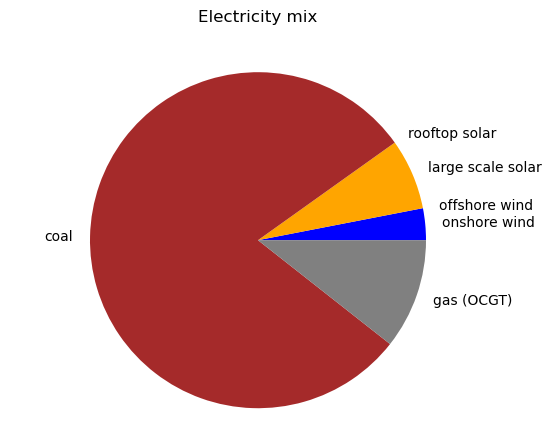

In [33]:
labels = ['onshore wind',
            'offshore wind',
            'large scale solar',
            'rooftop solar',
            'coal',
            'gas (OCGT)']
       
sizes = [network.generators_t.p['onshorewind'].sum(),
            network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['PV'].sum(),
            network.generators_t.p['rooftopPV'].sum(),
            network.generators_t.p['coal'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'darkblue', 'orange', 'yellow', 'brown', 'grey']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

__Installed Capacities of each generator__

In [34]:
network.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind      8.350420
offshorewind     0.000000
PV              33.368777
rooftopPV        0.000000
OCGT            28.614407
coal            48.134363
Name: p_nom_opt, dtype: float64

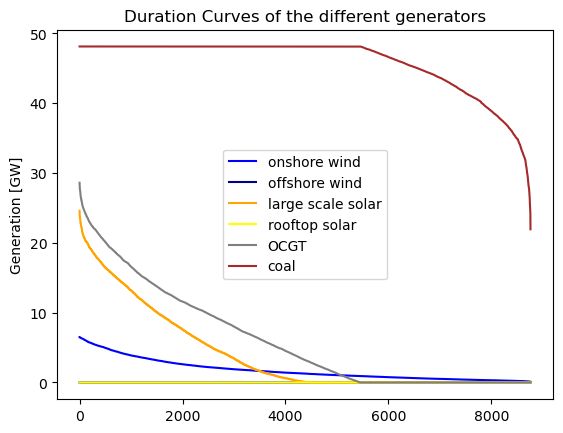

In [35]:
# Duration Curves
cf_onshore = network.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_offshore = network.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = network.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_rooftopPV = network.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = network.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = network.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'offshore wind', 'large scale solar', 'rooftop solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

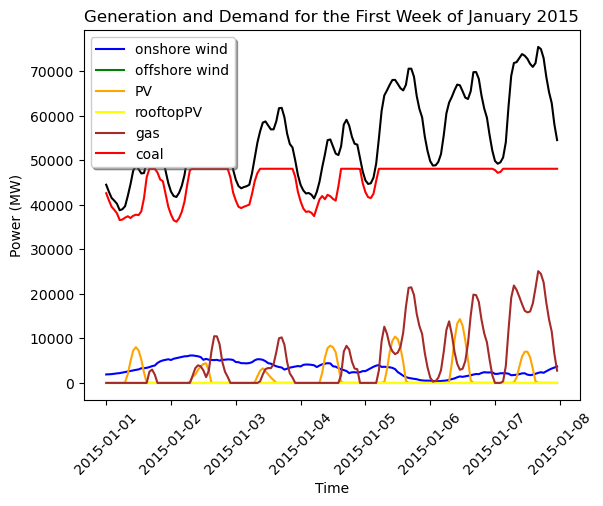

In [36]:
# Plot dispatch for a week in winter
start_date_1 = '2015-01-01'
end_date_1 = '2015-01-07'
week_1 = network.generators_t.p.loc[start_date_1:end_date_1]


plt.plot(week_1['onshorewind'], color='blue', label='onshore wind')
plt.plot(week_1['offshorewind'], color='green', label='offshore wind')
plt.plot(week_1['PV'], color='orange', label='PV')
plt.plot(week_1['rooftopPV'], color='yellow', label='rooftopPV')
plt.plot(week_1['OCGT'], color='brown', label='gas')
plt.plot(week_1['coal'], color='red', label='coal')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.plot(network.loads_t.p['load'].loc[start_date_1:end_date_1], color='black', label='demand')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Generation and Demand for the First Week of January 2015')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

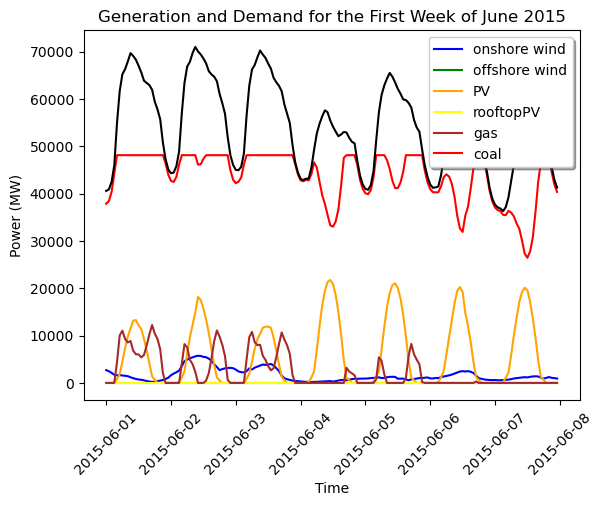

In [37]:
# Plot dispatch for a week in summer
start_date_2 = '2015-06-01'
end_date_2 = '2015-06-07'
week_2 = network.generators_t.p.loc[start_date_2:end_date_2]


plt.plot(week_2['onshorewind'], color='blue', label='onshore wind')
plt.plot(week_2['offshorewind'], color='green', label='offshore wind')
plt.plot(week_2['PV'], color='orange', label='PV')
plt.plot(week_2['rooftopPV'], color='yellow', label='rooftopPV')
plt.plot(week_2['OCGT'], color='brown', label='gas')
plt.plot(week_2['coal'], color='red', label='coal')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.plot(network.loads_t.p['load'].loc[start_date_2:end_date_2], color='black', label='demand')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Generation and Demand for the First Week of June 2015')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [38]:
(network.statistics.capex() + network.statistics.opex()).div(1e6)

component  carrier    
Generator  coal           18478.567500
           gas             4388.622204
           onshorewind             NaN
           solarPV                 NaN
dtype: float64

# Section B

__2025 CO2 cap in Germany__

In [39]:
# CO2 emissions in germany (2024): 152 million tonnes
# Source: https://www.ise.fraunhofer.de/en/press-media/press-releases/2025/public-electricity-generation-2024-renewable-energies-cover-more-than-60-percent-of-german-electricity-consumption-for-the-first-time.html
#CO2 price: https://www.dehst.de/SharedDocs/Pressemitteilungen/EN/2020_064_co2-pricing-for-emissions-in-heating-and-transport.html

In [40]:
network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=152000000, #152MtCO2
)

#colors_adjusted=['blue', 'orange', 'brown', 'grey']

Index(['CO2Limit'], dtype='object')

In [41]:
network.optimize(solver_name='gurobi')

Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.59it/s]
INFO:linopy.io: Writing time: 0.68s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-s8hi24qr.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-s8hi24qr.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xba5020d9


INFO:gurobipy:Model fingerprint: 0xba5020d9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.49878728e+12  0.00000000e+00  2.92e+10 0.00e+00  3.47e+09     0s


INFO:gurobipy:   0   5.49878728e+12  0.00000000e+00  2.92e+10 0.00e+00  3.47e+09     0s


   1   7.79016996e+12 -1.14487422e+12  4.49e+09 3.00e+02  6.80e+08     0s


INFO:gurobipy:   1   7.79016996e+12 -1.14487422e+12  4.49e+09 3.00e+02  6.80e+08     0s


   2   5.09937483e+12 -1.40417531e+12  8.02e+07 1.62e-09  5.36e+07     0s


INFO:gurobipy:   2   5.09937483e+12 -1.40417531e+12  8.02e+07 1.62e-09  5.36e+07     0s


   3   8.68003406e+11 -4.27057315e+11  1.16e+07 1.80e-09  1.00e+07     0s


INFO:gurobipy:   3   8.68003406e+11 -4.27057315e+11  1.16e+07 1.80e-09  1.00e+07     0s


   4   7.00004929e+11 -3.54895979e+11  9.13e+06 1.21e-09  8.14e+06     0s


INFO:gurobipy:   4   7.00004929e+11 -3.54895979e+11  9.13e+06 1.21e-09  8.14e+06     0s


   5   3.86900037e+11 -2.27695297e+11  4.66e+06 2.76e-10  4.71e+06     0s


INFO:gurobipy:   5   3.86900037e+11 -2.27695297e+11  4.66e+06 2.76e-10  4.71e+06     0s


   6   2.36826775e+11 -1.25538932e+11  2.61e+06 3.27e-10  2.76e+06     0s


INFO:gurobipy:   6   2.36826775e+11 -1.25538932e+11  2.61e+06 3.27e-10  2.76e+06     0s


   7   1.07063396e+11 -6.26234693e+10  9.09e+05 2.18e-09  1.29e+06     0s


INFO:gurobipy:   7   1.07063396e+11 -6.26234693e+10  9.09e+05 2.18e-09  1.29e+06     0s


   8   7.88214647e+10 -3.39418903e+10  5.67e+05 5.28e-10  8.56e+05     0s


INFO:gurobipy:   8   7.88214647e+10 -3.39418903e+10  5.67e+05 5.28e-10  8.56e+05     0s


   9   6.10843155e+10 -9.59200227e+08  3.52e+05 2.69e-09  4.71e+05     0s


INFO:gurobipy:   9   6.10843155e+10 -9.59200227e+08  3.52e+05 2.69e-09  4.71e+05     0s


  10   4.90475535e+10  8.34832637e+09  2.21e+05 1.66e-09  3.09e+05     0s


INFO:gurobipy:  10   4.90475535e+10  8.34832637e+09  2.21e+05 1.66e-09  3.09e+05     0s


  11   4.72190432e+10  1.30281849e+10  2.03e+05 2.36e-09  2.59e+05     1s


INFO:gurobipy:  11   4.72190432e+10  1.30281849e+10  2.03e+05 2.36e-09  2.59e+05     1s


  12   3.94306610e+10  1.57091507e+10  1.15e+05 1.67e-09  1.80e+05     1s


INFO:gurobipy:  12   3.94306610e+10  1.57091507e+10  1.15e+05 1.67e-09  1.80e+05     1s


  13   3.56481547e+10  1.86316836e+10  7.16e+04 1.04e-09  1.29e+05     1s


INFO:gurobipy:  13   3.56481547e+10  1.86316836e+10  7.16e+04 1.04e-09  1.29e+05     1s


  14   3.31023482e+10  2.29334397e+10  4.31e+04 1.02e-09  7.70e+04     1s


INFO:gurobipy:  14   3.31023482e+10  2.29334397e+10  4.31e+04 1.02e-09  7.70e+04     1s


  15   3.16921021e+10  2.50405124e+10  2.97e+04 1.94e-10  5.04e+04     1s


INFO:gurobipy:  15   3.16921021e+10  2.50405124e+10  2.97e+04 1.94e-10  5.04e+04     1s


  16   3.09601779e+10  2.55306898e+10  2.32e+04 5.24e-10  4.11e+04     1s


INFO:gurobipy:  16   3.09601779e+10  2.55306898e+10  2.32e+04 5.24e-10  4.11e+04     1s


  17   3.04013103e+10  2.63210630e+10  1.83e+04 4.44e-10  3.09e+04     1s


INFO:gurobipy:  17   3.04013103e+10  2.63210630e+10  1.83e+04 4.44e-10  3.09e+04     1s


  18   2.98747553e+10  2.70722078e+10  1.39e+04 1.72e-09  2.12e+04     1s


INFO:gurobipy:  18   2.98747553e+10  2.70722078e+10  1.39e+04 1.72e-09  2.12e+04     1s


  19   2.91916858e+10  2.72979786e+10  8.45e+03 3.57e-10  1.43e+04     1s


INFO:gurobipy:  19   2.91916858e+10  2.72979786e+10  8.45e+03 3.57e-10  1.43e+04     1s


  20   2.89099191e+10  2.75439336e+10  6.24e+03 7.09e-10  1.03e+04     1s


INFO:gurobipy:  20   2.89099191e+10  2.75439336e+10  6.24e+03 7.09e-10  1.03e+04     1s


  21   2.86356269e+10  2.76779225e+10  4.17e+03 2.51e-10  7.25e+03     1s


INFO:gurobipy:  21   2.86356269e+10  2.76779225e+10  4.17e+03 2.51e-10  7.25e+03     1s


  22   2.83903523e+10  2.78102097e+10  2.39e+03 1.42e-10  4.39e+03     1s


INFO:gurobipy:  22   2.83903523e+10  2.78102097e+10  2.39e+03 1.42e-10  4.39e+03     1s


  23   2.82431584e+10  2.78920290e+10  1.39e+03 8.33e-10  2.66e+03     1s


INFO:gurobipy:  23   2.82431584e+10  2.78920290e+10  1.39e+03 8.33e-10  2.66e+03     1s


  24   2.81442632e+10  2.79206323e+10  7.53e+02 1.26e-09  1.69e+03     1s


INFO:gurobipy:  24   2.81442632e+10  2.79206323e+10  7.53e+02 1.26e-09  1.69e+03     1s


  25   2.81041366e+10  2.79532317e+10  5.09e+02 2.50e-10  1.14e+03     1s


INFO:gurobipy:  25   2.81041366e+10  2.79532317e+10  5.09e+02 2.50e-10  1.14e+03     1s


  26   2.80637685e+10  2.79685552e+10  2.72e+02 2.51e-09  7.21e+02     1s


INFO:gurobipy:  26   2.80637685e+10  2.79685552e+10  2.72e+02 2.51e-09  7.21e+02     1s


  27   2.80423451e+10  2.79801343e+10  1.51e+02 1.34e-09  4.71e+02     1s


INFO:gurobipy:  27   2.80423451e+10  2.79801343e+10  1.51e+02 1.34e-09  4.71e+02     1s


  28   2.80324536e+10  2.79962074e+10  9.57e+01 9.09e-11  2.74e+02     1s


INFO:gurobipy:  28   2.80324536e+10  2.79962074e+10  9.57e+01 9.09e-11  2.74e+02     1s


  29   2.80268491e+10  2.79993812e+10  6.68e+01 2.67e-10  2.08e+02     1s


INFO:gurobipy:  29   2.80268491e+10  2.79993812e+10  6.68e+01 2.67e-10  2.08e+02     1s


  30   2.80224050e+10  2.80023112e+10  4.42e+01 7.19e-10  1.52e+02     1s


INFO:gurobipy:  30   2.80224050e+10  2.80023112e+10  4.42e+01 7.19e-10  1.52e+02     1s


  31   2.80185787e+10  2.80066160e+10  2.54e+01 2.00e-09  9.05e+01     1s


INFO:gurobipy:  31   2.80185787e+10  2.80066160e+10  2.54e+01 2.00e-09  9.05e+01     1s


  32   2.80168957e+10  2.80089274e+10  1.72e+01 1.12e-09  6.03e+01     1s


INFO:gurobipy:  32   2.80168957e+10  2.80089274e+10  1.72e+01 1.12e-09  6.03e+01     1s


  33   2.80148614e+10  2.80109213e+10  7.97e+00 9.68e-10  2.98e+01     1s


INFO:gurobipy:  33   2.80148614e+10  2.80109213e+10  7.97e+00 9.68e-10  2.98e+01     1s


  34   2.80139909e+10  2.80117741e+10  3.91e+00 3.49e-10  1.68e+01     1s


INFO:gurobipy:  34   2.80139909e+10  2.80117741e+10  3.91e+00 3.49e-10  1.68e+01     1s


  35   2.80135403e+10  2.80125510e+10  1.97e+00 1.24e-09  7.49e+00     1s


INFO:gurobipy:  35   2.80135403e+10  2.80125510e+10  1.97e+00 1.24e-09  7.49e+00     1s


  36   2.80132580e+10  2.80129542e+10  7.10e-01 1.12e-09  2.30e+00     1s


INFO:gurobipy:  36   2.80132580e+10  2.80129542e+10  7.10e-01 1.12e-09  2.30e+00     1s


  37   2.80130968e+10  2.80130757e+10  5.79e-02 2.42e-10  1.60e-01     1s


INFO:gurobipy:  37   2.80130968e+10  2.80130757e+10  5.79e-02 2.42e-10  1.60e-01     1s


  38   2.80130787e+10  2.80130779e+10  7.87e-04 1.21e-09  5.78e-03     1s


INFO:gurobipy:  38   2.80130787e+10  2.80130779e+10  7.87e-04 1.21e-09  5.78e-03     1s


  39   2.80130783e+10  2.80130783e+10  3.86e-06 1.36e-09  5.81e-06     1s


INFO:gurobipy:  39   2.80130783e+10  2.80130783e+10  3.86e-06 1.36e-09  5.81e-06     1s


  40   2.80130783e+10  2.80130783e+10  1.32e-09 6.95e-09  5.81e-09     1s


INFO:gurobipy:  40   2.80130783e+10  2.80130783e+10  1.32e-09 6.95e-09  5.81e-09     1s


INFO:gurobipy:


Barrier solved model in 40 iterations and 1.43 seconds (0.78 work units)


INFO:gurobipy:Barrier solved model in 40 iterations and 1.43 seconds (0.78 work units)


Optimal objective 2.80130783e+10


INFO:gurobipy:Optimal objective 2.80130783e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     932 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:     932 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6101640e-08      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6101640e-08      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12096    2.8013078e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12096    2.8013078e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12096 iterations and 2.24 seconds (3.60 work units)


INFO:gurobipy:Solved in 12096 iterations and 2.24 seconds (3.60 work units)


Optimal objective  2.801307826e+10


INFO:gurobipy:Optimal objective  2.801307826e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.80e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Text(0.5, 1.07, 'Generation mix')

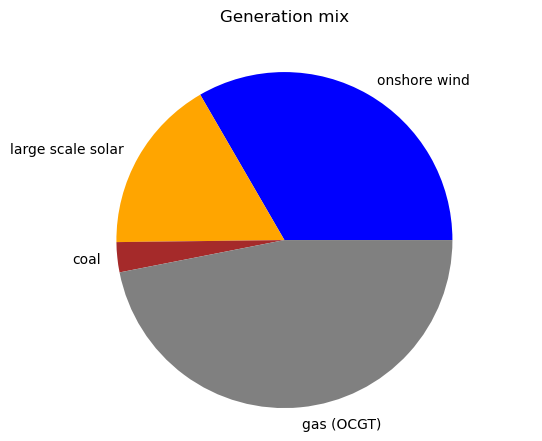

In [42]:

labels = ['onshore wind',
            #'offshore wind',
            'large scale solar',
            #'rooftop solar',
            'coal',
            'gas (OCGT)']
      
sizes = [network.generators_t.p['onshorewind'].sum(),
            #network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['PV'].sum(),
            #network.generators_t.p['rooftopPV'].sum(),
            network.generators_t.p['coal'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown', 'grey']

plt.pie(sizes,
      colors=colors,
      labels=labels,
      wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Generation mix', y=1.07)



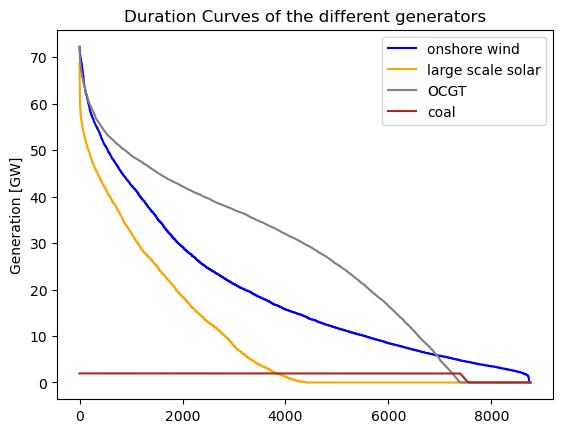

In [43]:
# Duration Curves
cf_onshore = network.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
#cf_offshore = network.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = network.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
#cf_rooftopPV = network.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = network.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = network.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
#cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
#cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'large scale solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

In [44]:
network.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind     93.144348
offshorewind     0.000000
PV              93.364269
rooftopPV        0.000000
OCGT            72.315298
coal             1.955093
Name: p_nom_opt, dtype: float64

In [45]:
print(f"Total cost: {round(network.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(network.objective/network.loads_t.p.sum().iloc[0]))} EUR/MWh")

Total cost: 28013.08 mio€
Cost per MWh of electricity produced 55 EUR/MWh


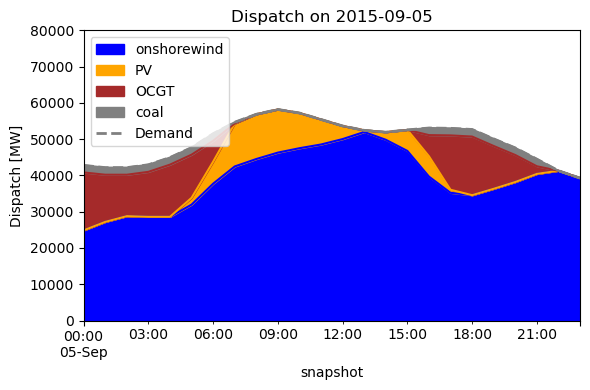

In [46]:
#Dispatch plot used in task D without storage (in D with storage)
day = "2015-09-05"
 
# Get all generator names
generators = network.generators.index
 
# Filter out "rooftopPV" and "offshorewind"
filtered_generators = generators[~generators.str.contains("rooftopPV|offshorewind")]
 
# Plot only the filtered generators
ax = network.generators_t.p.loc[day, filtered_generators].plot.area(
    figsize=(6, 4), ylabel="Dispatch [MW]", legend=True, color=['blue', 'orange', 'brown', 'grey']
)
 
# 2. Overlay storage unit dispatch and demand
network.loads_t.p['load'].loc[day].plot(ax=ax, linewidth=2, linestyle="--", color="grey", label="Demand")
 
# 3. Customize
plt.title(f"Dispatch on {day}")
plt.tight_layout()
plt.ylim(0, 80000)
plt.legend(loc="upper left")
plt.show()

__Sensitivity Analysis__

In [47]:
systemcost = []
onwind = []
#offwind = []
pv = []
#rooftop = []
coal = []
ocgt = []

onwind_cap = []
#offwind_cap = []
pv_cap = []
#rooftop_cap = []
coal_cap = []
ocgt_cap = []

co2_tax = []


for co2 in [2000, 1500, 1000, 500, 250, 152, 100, 0]: # in MtCO2
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    network.optimize(solver_name="gurobi")
    systemcost.append(network.objective / 1e6)  # in million euros
    onwind.append(network.generators_t.p["onshorewind"].sum())
    #offwind.append(network.generators_t.p["offshorewind"].sum())
    pv.append(network.generators_t.p["PV"].sum())
    #rooftop.append(network.generators_t.p["rooftopPV"].sum())
    coal.append(network.generators_t.p["coal"].sum())
    ocgt.append(network.generators_t.p["OCGT"].sum())

    onwind_cap.append(network.generators.p_nom_opt.loc["onshorewind"])
    #offwind_cap.append(network.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(network.generators.p_nom_opt.loc["PV"])
    #rooftop_cap.append(network.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(network.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(network.generators.p_nom_opt.loc["OCGT"])

    co2_tax.append(-network.global_constraints.mu['CO2Limit'])
    
    

Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.15it/s]
INFO:linopy.io: Writing time: 0.68s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-r8jppfdk.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-r8jppfdk.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x96b95d0b


INFO:gurobipy:Model fingerprint: 0x96b95d0b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 61043 rows and 8476 columns


INFO:gurobipy:Presolve removed 61043 rows and 8476 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  5.24e-10 4.12e-02  3.73e+05     0s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  5.24e-10 4.12e-02  3.73e+05     0s


   6   4.89505730e+10  1.61827315e+10  3.73e-09 3.57e-02  2.49e+05     0s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  3.73e-09 3.57e-02  2.49e+05     0s


   7   4.10081204e+10  2.04457327e+10  3.58e-09 8.06e-03  1.56e+05     0s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  3.58e-09 8.06e-03  1.56e+05     0s


   8   4.00328497e+10  2.13247459e+10  1.00e-08 5.72e-03  1.42e+05     0s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  1.00e-08 5.72e-03  1.42e+05     0s


   9   3.35780868e+10  2.23124197e+10  1.84e-07 5.09e-11  8.53e+04     0s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  1.84e-07 5.09e-11  8.53e+04     0s


  10   2.89054547e+10  2.31739019e+10  3.31e-07 1.32e-09  4.34e+04     1s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  3.31e-07 1.32e-09  4.34e+04     1s


  11   2.72997183e+10  2.37155948e+10  2.19e-07 6.28e-10  2.72e+04     1s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  2.19e-07 6.28e-10  2.72e+04     1s


  12   2.64698707e+10  2.38954623e+10  4.03e-07 6.29e-10  1.95e+04     1s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  4.03e-07 6.29e-10  1.95e+04     1s


  13   2.60400183e+10  2.40809592e+10  4.99e-07 5.59e-10  1.48e+04     1s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  4.99e-07 5.59e-10  1.48e+04     1s


  14   2.56994267e+10  2.42218790e+10  1.55e-07 6.46e-10  1.12e+04     1s


INFO:gurobipy:  14   2.56994267e+10  2.42218790e+10  1.55e-07 6.46e-10  1.12e+04     1s


  15   2.54060227e+10  2.43695458e+10  1.14e-06 1.75e-10  7.85e+03     1s


INFO:gurobipy:  15   2.54060227e+10  2.43695458e+10  1.14e-06 1.75e-10  7.85e+03     1s


  16   2.52304373e+10  2.44533951e+10  1.00e-06 3.66e-10  5.89e+03     1s


INFO:gurobipy:  16   2.52304373e+10  2.44533951e+10  1.00e-06 3.66e-10  5.89e+03     1s


  17   2.51347517e+10  2.45220887e+10  8.31e-07 6.51e-10  4.64e+03     1s


INFO:gurobipy:  17   2.51347517e+10  2.45220887e+10  8.31e-07 6.51e-10  4.64e+03     1s


  18   2.50998844e+10  2.45657197e+10  3.79e-07 5.23e-10  4.05e+03     1s


INFO:gurobipy:  18   2.50998844e+10  2.45657197e+10  3.79e-07 5.23e-10  4.05e+03     1s


  19   2.50854757e+10  2.45987608e+10  5.90e-06 2.95e-10  3.69e+03     1s


INFO:gurobipy:  19   2.50854757e+10  2.45987608e+10  5.90e-06 2.95e-10  3.69e+03     1s


  20   2.50127867e+10  2.46419299e+10  4.51e-06 8.44e-10  2.81e+03     1s


INFO:gurobipy:  20   2.50127867e+10  2.46419299e+10  4.51e-06 8.44e-10  2.81e+03     1s


  21   2.49285243e+10  2.46586364e+10  2.79e-06 5.40e-10  2.04e+03     1s


INFO:gurobipy:  21   2.49285243e+10  2.46586364e+10  2.79e-06 5.40e-10  2.04e+03     1s


  22   2.48862002e+10  2.46768936e+10  1.35e-06 5.02e-10  1.59e+03     1s


INFO:gurobipy:  22   2.48862002e+10  2.46768936e+10  1.35e-06 5.02e-10  1.59e+03     1s


  23   2.48588825e+10  2.46982403e+10  1.69e-06 0.00e+00  1.22e+03     1s


INFO:gurobipy:  23   2.48588825e+10  2.46982403e+10  1.69e-06 0.00e+00  1.22e+03     1s


  24   2.48304054e+10  2.47050067e+10  9.56e-07 7.40e-10  9.50e+02     1s


INFO:gurobipy:  24   2.48304054e+10  2.47050067e+10  9.56e-07 7.40e-10  9.50e+02     1s


  25   2.48079011e+10  2.47164594e+10  4.49e-07 1.10e-09  6.93e+02     1s


INFO:gurobipy:  25   2.48079011e+10  2.47164594e+10  4.49e-07 1.10e-09  6.93e+02     1s


  26   2.47999834e+10  2.47236749e+10  6.94e-07 2.68e-10  5.78e+02     1s


INFO:gurobipy:  26   2.47999834e+10  2.47236749e+10  6.94e-07 2.68e-10  5.78e+02     1s


  27   2.47907317e+10  2.47273682e+10  1.12e-06 1.82e-09  4.80e+02     1s


INFO:gurobipy:  27   2.47907317e+10  2.47273682e+10  1.12e-06 1.82e-09  4.80e+02     1s


  28   2.47785678e+10  2.47333915e+10  1.14e-06 0.00e+00  3.42e+02     1s


INFO:gurobipy:  28   2.47785678e+10  2.47333915e+10  1.14e-06 0.00e+00  3.42e+02     1s


  29   2.47748985e+10  2.47370889e+10  1.42e-06 1.05e-09  2.87e+02     1s


INFO:gurobipy:  29   2.47748985e+10  2.47370889e+10  1.42e-06 1.05e-09  2.87e+02     1s


  30   2.47723574e+10  2.47393165e+10  8.93e-07 8.28e-10  2.50e+02     1s


INFO:gurobipy:  30   2.47723574e+10  2.47393165e+10  8.93e-07 8.28e-10  2.50e+02     1s


  31   2.47684472e+10  2.47411024e+10  9.75e-07 7.58e-10  2.07e+02     1s


INFO:gurobipy:  31   2.47684472e+10  2.47411024e+10  9.75e-07 7.58e-10  2.07e+02     1s


  32   2.47651729e+10  2.47420360e+10  1.51e-06 6.34e-10  1.75e+02     1s


INFO:gurobipy:  32   2.47651729e+10  2.47420360e+10  1.51e-06 6.34e-10  1.75e+02     1s


  33   2.47637032e+10  2.47433311e+10  9.83e-07 6.72e-10  1.54e+02     1s


INFO:gurobipy:  33   2.47637032e+10  2.47433311e+10  9.83e-07 6.72e-10  1.54e+02     1s


  34   2.47611417e+10  2.47445989e+10  1.51e-06 4.60e-10  1.25e+02     1s


INFO:gurobipy:  34   2.47611417e+10  2.47445989e+10  1.51e-06 4.60e-10  1.25e+02     1s


  35   2.47598894e+10  2.47456100e+10  1.33e-06 4.27e-10  1.08e+02     1s


INFO:gurobipy:  35   2.47598894e+10  2.47456100e+10  1.33e-06 4.27e-10  1.08e+02     1s


  36   2.47586572e+10  2.47464062e+10  9.58e-07 9.53e-10  9.29e+01     1s


INFO:gurobipy:  36   2.47586572e+10  2.47464062e+10  9.58e-07 9.53e-10  9.29e+01     1s


  37   2.47574455e+10  2.47472548e+10  1.51e-06 1.00e-09  7.73e+01     1s


INFO:gurobipy:  37   2.47574455e+10  2.47472548e+10  1.51e-06 1.00e-09  7.73e+01     1s


  38   2.47566581e+10  2.47484510e+10  9.22e-07 8.29e-10  6.23e+01     1s


INFO:gurobipy:  38   2.47566581e+10  2.47484510e+10  9.22e-07 8.29e-10  6.23e+01     1s


  39   2.47556937e+10  2.47488290e+10  1.68e-06 1.03e-09  5.21e+01     1s


INFO:gurobipy:  39   2.47556937e+10  2.47488290e+10  1.68e-06 1.03e-09  5.21e+01     1s


  40   2.47556092e+10  2.47491688e+10  1.55e-06 6.07e-10  4.89e+01     1s


INFO:gurobipy:  40   2.47556092e+10  2.47491688e+10  1.55e-06 6.07e-10  4.89e+01     1s


  41   2.47549917e+10  2.47497706e+10  5.37e-07 1.27e-09  3.96e+01     1s


INFO:gurobipy:  41   2.47549917e+10  2.47497706e+10  5.37e-07 1.27e-09  3.96e+01     1s


  42   2.47544348e+10  2.47500371e+10  6.85e-07 8.95e-10  3.34e+01     2s


INFO:gurobipy:  42   2.47544348e+10  2.47500371e+10  6.85e-07 8.95e-10  3.34e+01     2s


  43   2.47540579e+10  2.47505931e+10  7.46e-07 7.00e-10  2.63e+01     2s


INFO:gurobipy:  43   2.47540579e+10  2.47505931e+10  7.46e-07 7.00e-10  2.63e+01     2s


  44   2.47535625e+10  2.47512465e+10  2.18e-06 5.93e-10  1.76e+01     2s


INFO:gurobipy:  44   2.47535625e+10  2.47512465e+10  2.18e-06 5.93e-10  1.76e+01     2s


  45   2.47534511e+10  2.47514604e+10  1.79e-06 0.00e+00  1.51e+01     2s


INFO:gurobipy:  45   2.47534511e+10  2.47514604e+10  1.79e-06 0.00e+00  1.51e+01     2s


  46   2.47534048e+10  2.47518593e+10  5.47e-06 4.17e-10  1.17e+01     2s


INFO:gurobipy:  46   2.47534048e+10  2.47518593e+10  5.47e-06 4.17e-10  1.17e+01     2s


  47   2.47533786e+10  2.47520146e+10  7.82e-06 1.49e-10  1.04e+01     2s


INFO:gurobipy:  47   2.47533786e+10  2.47520146e+10  7.82e-06 1.49e-10  1.04e+01     2s


  48   2.47532783e+10  2.47523456e+10  1.75e-05 2.02e-10  7.09e+00     2s


INFO:gurobipy:  48   2.47532783e+10  2.47523456e+10  1.75e-05 2.02e-10  7.09e+00     2s


  49   2.47532580e+10  2.47526391e+10  2.08e-05 6.62e-10  4.71e+00     2s


INFO:gurobipy:  49   2.47532580e+10  2.47526391e+10  2.08e-05 6.62e-10  4.71e+00     2s


  50   2.47532421e+10  2.47526518e+10  2.00e-05 1.28e-09  4.49e+00     2s


INFO:gurobipy:  50   2.47532421e+10  2.47526518e+10  2.00e-05 1.28e-09  4.49e+00     2s


  51   2.47532286e+10  2.47529864e+10  1.90e-05 4.69e-09  1.84e+00     2s


INFO:gurobipy:  51   2.47532286e+10  2.47529864e+10  1.90e-05 4.69e-09  1.84e+00     2s


  52   2.47532237e+10  2.47530317e+10  1.50e-05 8.46e-10  1.46e+00     2s


INFO:gurobipy:  52   2.47532237e+10  2.47530317e+10  1.50e-05 8.46e-10  1.46e+00     2s


  53   2.47532182e+10  2.47530837e+10  5.79e-06 1.51e-09  1.02e+00     2s


INFO:gurobipy:  53   2.47532182e+10  2.47530837e+10  5.79e-06 1.51e-09  1.02e+00     2s


  54   2.47532174e+10  2.47531591e+10  5.76e-06 2.88e-08  4.43e-01     2s


INFO:gurobipy:  54   2.47532174e+10  2.47531591e+10  5.76e-06 2.88e-08  4.43e-01     2s


  55   2.47532155e+10  2.47532139e+10  2.18e-06 1.95e-10  1.20e-02     2s


INFO:gurobipy:  55   2.47532155e+10  2.47532139e+10  2.18e-06 1.95e-10  1.20e-02     2s


  56   2.47532143e+10  2.47532143e+10  5.80e-09 4.90e-10  1.12e-05     2s


INFO:gurobipy:  56   2.47532143e+10  2.47532143e+10  5.80e-09 4.90e-10  1.12e-05     2s


  57   2.47532143e+10  2.47532143e+10  1.16e-10 1.55e-09  1.14e-11     2s


INFO:gurobipy:  57   2.47532143e+10  2.47532143e+10  1.16e-10 1.55e-09  1.14e-11     2s


INFO:gurobipy:


Barrier solved model in 57 iterations and 1.99 seconds (1.08 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 1.99 seconds (1.08 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5998161e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5998161e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13313 iterations and 2.23 seconds (1.15 work units)


INFO:gurobipy:Solved in 13313 iterations and 2.23 seconds (1.15 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.73it/s]
INFO:linopy.io: Writing time: 0.67s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-vzzt90z0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-vzzt90z0.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x0ee7df54


INFO:gurobipy:Model fingerprint: 0x0ee7df54


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.31893456e+13  0.00000000e+00  1.24e+11 0.00e+00  1.35e+10     0s


INFO:gurobipy:   0   2.31893456e+13  0.00000000e+00  1.24e+11 0.00e+00  1.35e+10     0s


   1   3.24162238e+13 -1.94195084e+12  1.96e+10 2.76e+02  2.67e+09     0s


INFO:gurobipy:   1   3.24162238e+13 -1.94195084e+12  1.96e+10 2.76e+02  2.67e+09     0s


   2   2.06813565e+13 -2.06451170e+12  1.01e+09 3.93e-10  2.28e+08     0s


INFO:gurobipy:   2   2.06813565e+13 -2.06451170e+12  1.01e+09 3.93e-10  2.28e+08     0s


   3   4.46546317e+12 -1.39915006e+12  1.78e+08 6.00e-10  5.56e+07     0s


INFO:gurobipy:   3   4.46546317e+12 -1.39915006e+12  1.78e+08 6.00e-10  5.56e+07     0s


   4   9.65979510e+11 -7.06743766e+11  1.45e+04 4.07e-10  1.34e+07     0s


INFO:gurobipy:   4   9.65979510e+11 -7.06743766e+11  1.45e+04 4.07e-10  1.34e+07     0s


   5   3.35196583e+11 -2.46578335e+11  4.44e+03 3.64e-10  4.52e+06     0s


INFO:gurobipy:   5   3.35196583e+11 -2.46578335e+11  4.44e+03 3.64e-10  4.52e+06     0s


   6   1.26987085e+11 -5.64302947e+10  1.37e+03 1.64e-09  1.41e+06     0s


INFO:gurobipy:   6   1.26987085e+11 -5.64302947e+10  1.37e+03 1.64e-09  1.41e+06     0s


   7   5.63766087e+10 -1.65187341e+10  4.02e+02 4.64e-10  5.56e+05     0s


INFO:gurobipy:   7   5.63766087e+10 -1.65187341e+10  4.02e+02 4.64e-10  5.56e+05     0s


   8   4.40372306e+10 -4.88300361e+08  2.46e+02 7.13e-10  3.39e+05     0s


INFO:gurobipy:   8   4.40372306e+10 -4.88300361e+08  2.46e+02 7.13e-10  3.39e+05     0s


   9   4.02978678e+10  1.25875706e+10  2.02e+02 7.86e-10  2.11e+05     1s


INFO:gurobipy:   9   4.02978678e+10  1.25875706e+10  2.02e+02 7.86e-10  2.11e+05     1s


  10   3.69035505e+10  1.89107912e+10  1.60e+02 8.59e-10  1.37e+05     1s


INFO:gurobipy:  10   3.69035505e+10  1.89107912e+10  1.60e+02 8.59e-10  1.37e+05     1s


  11   3.07134357e+10  2.09145535e+10  7.46e+01 4.43e-10  7.47e+04     1s


INFO:gurobipy:  11   3.07134357e+10  2.09145535e+10  7.46e+01 4.43e-10  7.47e+04     1s


  12   2.86567662e+10  2.16359276e+10  4.90e+01 7.86e-10  5.34e+04     1s


INFO:gurobipy:  12   2.86567662e+10  2.16359276e+10  4.90e+01 7.86e-10  5.34e+04     1s


  13   2.75763760e+10  2.22052140e+10  3.44e+01 1.13e-09  4.09e+04     1s


INFO:gurobipy:  13   2.75763760e+10  2.22052140e+10  3.44e+01 1.13e-09  4.09e+04     1s


  14   2.68284846e+10  2.27566115e+10  2.51e+01 2.58e-10  3.10e+04     1s


INFO:gurobipy:  14   2.68284846e+10  2.27566115e+10  2.51e+01 2.58e-10  3.10e+04     1s


  15   2.62628989e+10  2.33537749e+10  1.81e+01 2.67e-10  2.21e+04     1s


INFO:gurobipy:  15   2.62628989e+10  2.33537749e+10  1.81e+01 2.67e-10  2.21e+04     1s


  16   2.58202584e+10  2.36998553e+10  1.27e+01 8.29e-10  1.61e+04     1s


INFO:gurobipy:  16   2.58202584e+10  2.36998553e+10  1.27e+01 8.29e-10  1.61e+04     1s


  17   2.55570032e+10  2.39981361e+10  9.54e+00 1.63e-09  1.18e+04     1s


INFO:gurobipy:  17   2.55570032e+10  2.39981361e+10  9.54e+00 1.63e-09  1.18e+04     1s


  18   2.53876865e+10  2.40692542e+10  7.54e+00 1.07e-09  1.00e+04     1s


INFO:gurobipy:  18   2.53876865e+10  2.40692542e+10  7.54e+00 1.07e-09  1.00e+04     1s


  19   2.52237404e+10  2.41445558e+10  5.65e+00 9.82e-10  8.20e+03     1s


INFO:gurobipy:  19   2.52237404e+10  2.41445558e+10  5.65e+00 9.82e-10  8.20e+03     1s


  20   2.51502445e+10  2.42193159e+10  4.76e+00 2.91e-10  7.07e+03     1s


INFO:gurobipy:  20   2.51502445e+10  2.42193159e+10  4.76e+00 2.91e-10  7.07e+03     1s


  21   2.51156619e+10  2.43328363e+10  4.27e+00 9.24e-10  5.95e+03     1s


INFO:gurobipy:  21   2.51156619e+10  2.43328363e+10  4.27e+00 9.24e-10  5.95e+03     1s


  22   2.50338918e+10  2.44988432e+10  2.99e+00 8.24e-10  4.06e+03     1s


INFO:gurobipy:  22   2.50338918e+10  2.44988432e+10  2.99e+00 8.24e-10  4.06e+03     1s


  23   2.49590326e+10  2.45671205e+10  2.13e+00 1.06e-09  2.98e+03     1s


INFO:gurobipy:  23   2.49590326e+10  2.45671205e+10  2.13e+00 1.06e-09  2.98e+03     1s


  24   2.49387166e+10  2.46083914e+10  1.93e+00 1.75e-10  2.51e+03     1s


INFO:gurobipy:  24   2.49387166e+10  2.46083914e+10  1.93e+00 1.75e-10  2.51e+03     1s


  25   2.48807459e+10  2.46252664e+10  1.31e+00 1.83e-09  1.94e+03     1s


INFO:gurobipy:  25   2.48807459e+10  2.46252664e+10  1.31e+00 1.83e-09  1.94e+03     1s


  26   2.48622928e+10  2.46428064e+10  1.12e+00 7.79e-10  1.67e+03     1s


INFO:gurobipy:  26   2.48622928e+10  2.46428064e+10  1.12e+00 7.79e-10  1.67e+03     1s


  27   2.48491680e+10  2.46530121e+10  9.91e-01 2.48e-10  1.49e+03     1s


INFO:gurobipy:  27   2.48491680e+10  2.46530121e+10  9.91e-01 2.48e-10  1.49e+03     1s


  28   2.48402530e+10  2.46589713e+10  8.98e-01 3.20e-10  1.38e+03     1s


INFO:gurobipy:  28   2.48402530e+10  2.46589713e+10  8.98e-01 3.20e-10  1.38e+03     1s


  29   2.48272198e+10  2.46750678e+10  7.60e-01 5.61e-10  1.15e+03     1s


INFO:gurobipy:  29   2.48272198e+10  2.46750678e+10  7.60e-01 5.61e-10  1.15e+03     1s


  30   2.48130091e+10  2.46898451e+10  6.12e-01 3.68e-11  9.35e+02     1s


INFO:gurobipy:  30   2.48130091e+10  2.46898451e+10  6.12e-01 3.68e-11  9.35e+02     1s


  31   2.48062438e+10  2.46958535e+10  5.38e-01 4.23e-10  8.38e+02     1s


INFO:gurobipy:  31   2.48062438e+10  2.46958535e+10  5.38e-01 4.23e-10  8.38e+02     1s


  32   2.47919766e+10  2.47102891e+10  3.88e-01 2.30e-10  6.20e+02     1s


INFO:gurobipy:  32   2.47919766e+10  2.47102891e+10  3.88e-01 2.30e-10  6.20e+02     1s


  33   2.47881318e+10  2.47127432e+10  3.47e-01 2.83e-10  5.72e+02     1s


INFO:gurobipy:  33   2.47881318e+10  2.47127432e+10  3.47e-01 2.83e-10  5.72e+02     1s


  34   2.47818392e+10  2.47199814e+10  2.82e-01 1.11e-09  4.69e+02     1s


INFO:gurobipy:  34   2.47818392e+10  2.47199814e+10  2.82e-01 1.11e-09  4.69e+02     1s


  35   2.47786560e+10  2.47231715e+10  2.49e-01 1.90e-10  4.21e+02     1s


INFO:gurobipy:  35   2.47786560e+10  2.47231715e+10  2.49e-01 1.90e-10  4.21e+02     1s


  36   2.47687455e+10  2.47265373e+10  1.48e-01 2.22e-10  3.20e+02     1s


INFO:gurobipy:  36   2.47687455e+10  2.47265373e+10  1.48e-01 2.22e-10  3.20e+02     1s


  37   2.47664872e+10  2.47282055e+10  1.24e-01 7.06e-10  2.90e+02     1s


INFO:gurobipy:  37   2.47664872e+10  2.47282055e+10  1.24e-01 7.06e-10  2.90e+02     1s


  38   2.47631238e+10  2.47354671e+10  9.13e-02 4.95e-10  2.10e+02     2s


INFO:gurobipy:  38   2.47631238e+10  2.47354671e+10  9.13e-02 4.95e-10  2.10e+02     2s


  39   2.47622216e+10  2.47370666e+10  8.29e-02 1.80e-09  1.91e+02     2s


INFO:gurobipy:  39   2.47622216e+10  2.47370666e+10  8.29e-02 1.80e-09  1.91e+02     2s


  40   2.47609459e+10  2.47382677e+10  7.11e-02 4.51e-10  1.72e+02     2s


INFO:gurobipy:  40   2.47609459e+10  2.47382677e+10  7.11e-02 4.51e-10  1.72e+02     2s


  41   2.47593801e+10  2.47395676e+10  5.60e-02 3.42e-10  1.50e+02     2s


INFO:gurobipy:  41   2.47593801e+10  2.47395676e+10  5.60e-02 3.42e-10  1.50e+02     2s


  42   2.47579967e+10  2.47405284e+10  4.34e-02 1.95e-10  1.32e+02     2s


INFO:gurobipy:  42   2.47579967e+10  2.47405284e+10  4.34e-02 1.95e-10  1.32e+02     2s


  43   2.47578201e+10  2.47416241e+10  4.18e-02 3.49e-10  1.23e+02     2s


INFO:gurobipy:  43   2.47578201e+10  2.47416241e+10  4.18e-02 3.49e-10  1.23e+02     2s


  44   2.47570189e+10  2.47433358e+10  3.41e-02 1.64e-09  1.04e+02     2s


INFO:gurobipy:  44   2.47570189e+10  2.47433358e+10  3.41e-02 1.64e-09  1.04e+02     2s


  45   2.47564256e+10  2.47451678e+10  2.82e-02 5.68e-10  8.53e+01     2s


INFO:gurobipy:  45   2.47564256e+10  2.47451678e+10  2.82e-02 5.68e-10  8.53e+01     2s


  46   2.47560036e+10  2.47453489e+10  2.44e-02 1.08e-11  8.07e+01     2s


INFO:gurobipy:  46   2.47560036e+10  2.47453489e+10  2.44e-02 1.08e-11  8.07e+01     2s


  47   2.47555496e+10  2.47483440e+10  2.02e-02 1.14e-13  5.46e+01     2s


INFO:gurobipy:  47   2.47555496e+10  2.47483440e+10  2.02e-02 1.14e-13  5.46e+01     2s


  48   2.47550890e+10  2.47495294e+10  1.60e-02 5.68e-14  4.21e+01     2s


INFO:gurobipy:  48   2.47550890e+10  2.47495294e+10  1.60e-02 5.68e-14  4.21e+01     2s


  49   2.47545309e+10  2.47498028e+10  1.10e-02 4.73e-10  3.58e+01     2s


INFO:gurobipy:  49   2.47545309e+10  2.47498028e+10  1.10e-02 4.73e-10  3.58e+01     2s


  50   2.47537965e+10  2.47504086e+10  4.50e-03 3.43e-10  2.56e+01     2s


INFO:gurobipy:  50   2.47537965e+10  2.47504086e+10  4.50e-03 3.43e-10  2.56e+01     2s


  51   2.47536202e+10  2.47507729e+10  3.13e-03 7.93e-10  2.15e+01     2s


INFO:gurobipy:  51   2.47536202e+10  2.47507729e+10  3.13e-03 7.93e-10  2.15e+01     2s


  52   2.47535274e+10  2.47512492e+10  2.32e-03 1.01e-09  1.72e+01     2s


INFO:gurobipy:  52   2.47535274e+10  2.47512492e+10  2.32e-03 1.01e-09  1.72e+01     2s


  53   2.47534587e+10  2.47519150e+10  1.80e-03 9.13e-10  1.17e+01     2s


INFO:gurobipy:  53   2.47534587e+10  2.47519150e+10  1.80e-03 9.13e-10  1.17e+01     2s


  54   2.47533840e+10  2.47520615e+10  1.24e-03 4.23e-10  1.00e+01     2s


INFO:gurobipy:  54   2.47533840e+10  2.47520615e+10  1.24e-03 4.23e-10  1.00e+01     2s


  55   2.47532362e+10  2.47526685e+10  6.19e-05 2.47e-10  4.29e+00     2s


INFO:gurobipy:  55   2.47532362e+10  2.47526685e+10  6.19e-05 2.47e-10  4.29e+00     2s


  56   2.47532287e+10  2.47527567e+10  4.03e-05 2.79e-09  3.57e+00     2s


INFO:gurobipy:  56   2.47532287e+10  2.47527567e+10  4.03e-05 2.79e-09  3.57e+00     2s


  57   2.47532238e+10  2.47529549e+10  1.13e-05 1.92e-09  2.03e+00     2s


INFO:gurobipy:  57   2.47532238e+10  2.47529549e+10  1.13e-05 1.92e-09  2.03e+00     2s


  58   2.47532182e+10  2.47530224e+10  5.29e-06 4.01e-09  1.48e+00     2s


INFO:gurobipy:  58   2.47532182e+10  2.47530224e+10  5.29e-06 4.01e-09  1.48e+00     2s


  59   2.47532182e+10  2.47531035e+10  5.07e-06 3.94e-09  8.67e-01     2s


INFO:gurobipy:  59   2.47532182e+10  2.47531035e+10  5.07e-06 3.94e-09  8.67e-01     2s


  60   2.47532159e+10  2.47531784e+10  3.12e-06 1.77e-10  2.83e-01     2s


INFO:gurobipy:  60   2.47532159e+10  2.47531784e+10  3.12e-06 1.77e-10  2.83e-01     2s


  61   2.47532143e+10  2.47532118e+10  1.57e-06 2.57e-09  1.87e-02     2s


INFO:gurobipy:  61   2.47532143e+10  2.47532118e+10  1.57e-06 2.57e-09  1.87e-02     2s


  62   2.47532143e+10  2.47532137e+10  1.11e-08 1.19e-09  4.53e-03     2s


INFO:gurobipy:  62   2.47532143e+10  2.47532137e+10  1.11e-08 1.19e-09  4.53e-03     2s


  63   2.47532143e+10  2.47532143e+10  8.95e-08 1.07e-09  1.78e-06     2s


INFO:gurobipy:  63   2.47532143e+10  2.47532143e+10  8.95e-08 1.07e-09  1.78e-06     2s


  64   2.47532143e+10  2.47532143e+10  2.33e-10 3.93e-09  1.79e-12     2s


INFO:gurobipy:  64   2.47532143e+10  2.47532143e+10  2.33e-10 3.93e-09  1.79e-12     2s


INFO:gurobipy:


Barrier solved model in 64 iterations and 2.37 seconds (1.22 work units)


INFO:gurobipy:Barrier solved model in 64 iterations and 2.37 seconds (1.22 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13301 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13301 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8050450e-11      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.8050450e-11      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13304    2.4753214e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13304    2.4753214e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13304 iterations and 2.60 seconds (1.29 work units)


INFO:gurobipy:Solved in 13304 iterations and 2.60 seconds (1.29 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.52it/s]
INFO:linopy.io: Writing time: 0.67s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-voq3o1vl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-voq3o1vl.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xfe0d4387


INFO:gurobipy:Model fingerprint: 0xfe0d4387


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+09]


INFO:gurobipy:  RHS range        [4e+04, 1e+09]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.45442347e+13  0.00000000e+00  7.74e+10 0.00e+00  8.61e+09     0s


INFO:gurobipy:   0   1.45442347e+13  0.00000000e+00  7.74e+10 0.00e+00  8.61e+09     0s


   1   2.03935537e+13 -1.64710150e+12  1.22e+10 2.81e+02  1.70e+09     0s


INFO:gurobipy:   1   2.03935537e+13 -1.64710150e+12  1.22e+10 2.81e+02  1.70e+09     0s


   2   1.30909958e+13 -1.83879280e+12  5.50e+08 9.90e-10  1.43e+08     0s


INFO:gurobipy:   2   1.30909958e+13 -1.83879280e+12  5.50e+08 9.90e-10  1.43e+08     0s


   3   1.90396976e+12 -1.28300920e+12  5.76e+07 8.62e-10  2.78e+07     0s


INFO:gurobipy:   3   1.90396976e+12 -1.28300920e+12  5.76e+07 8.62e-10  2.78e+07     0s


   4   5.90325030e+11 -3.78084789e+11  6.98e+03 1.09e-09  7.64e+06     0s


INFO:gurobipy:   4   5.90325030e+11 -3.78084789e+11  6.98e+03 1.09e-09  7.64e+06     0s


   5   1.70414663e+11 -8.90977277e+10  1.63e+03 1.22e-09  1.99e+06     0s


INFO:gurobipy:   5   1.70414663e+11 -8.90977277e+10  1.63e+03 1.22e-09  1.99e+06     0s


   6   8.77446883e+10 -4.26799526e+10  6.87e+02 2.33e-09  9.97e+05     0s


INFO:gurobipy:   6   8.77446883e+10 -4.26799526e+10  6.87e+02 2.33e-09  9.97e+05     0s


   7   4.72630515e+10 -1.35584967e+10  2.33e+02 5.58e-10  4.63e+05     0s


INFO:gurobipy:   7   4.72630515e+10 -1.35584967e+10  2.33e+02 5.58e-10  4.63e+05     0s


   8   4.48498554e+10 -6.45911404e+08  2.08e+02 3.48e-10  3.46e+05     0s


INFO:gurobipy:   8   4.48498554e+10 -6.45911404e+08  2.08e+02 3.48e-10  3.46e+05     0s


   9   4.09574821e+10  1.15375483e+10  1.69e+02 1.18e-09  2.24e+05     0s


INFO:gurobipy:   9   4.09574821e+10  1.15375483e+10  1.69e+02 1.18e-09  2.24e+05     0s


  10   3.33041571e+10  1.70222349e+10  8.56e+01 6.18e-10  1.24e+05     1s


INFO:gurobipy:  10   3.33041571e+10  1.70222349e+10  8.56e+01 6.18e-10  1.24e+05     1s


  11   2.93536002e+10  1.90016870e+10  4.45e+01 9.90e-10  7.86e+04     1s


INFO:gurobipy:  11   2.93536002e+10  1.90016870e+10  4.45e+01 9.90e-10  7.86e+04     1s


  12   2.82374395e+10  1.97790668e+10  3.31e+01 5.17e-10  6.42e+04     1s


INFO:gurobipy:  12   2.82374395e+10  1.97790668e+10  3.31e+01 5.17e-10  6.42e+04     1s


  13   2.73377013e+10  2.07002243e+10  2.39e+01 4.87e-10  5.04e+04     1s


INFO:gurobipy:  13   2.73377013e+10  2.07002243e+10  2.39e+01 4.87e-10  5.04e+04     1s


  14   2.67227980e+10  2.14912199e+10  1.77e+01 1.42e-10  3.97e+04     1s


INFO:gurobipy:  14   2.67227980e+10  2.14912199e+10  1.77e+01 1.42e-10  3.97e+04     1s


  15   2.62143662e+10  2.25822029e+10  1.28e+01 2.16e-10  2.76e+04     1s


INFO:gurobipy:  15   2.62143662e+10  2.25822029e+10  1.28e+01 2.16e-10  2.76e+04     1s


  16   2.59405094e+10  2.32195658e+10  1.03e+01 6.59e-10  2.06e+04     1s


INFO:gurobipy:  16   2.59405094e+10  2.32195658e+10  1.03e+01 6.59e-10  2.06e+04     1s


  17   2.56602197e+10  2.37620522e+10  7.73e+00 8.73e-10  1.44e+04     1s


INFO:gurobipy:  17   2.56602197e+10  2.37620522e+10  7.73e+00 8.73e-10  1.44e+04     1s


  18   2.54410570e+10  2.38812044e+10  5.80e+00 7.28e-10  1.18e+04     1s


INFO:gurobipy:  18   2.54410570e+10  2.38812044e+10  5.80e+00 7.28e-10  1.18e+04     1s


  19   2.53433681e+10  2.39508489e+10  4.95e+00 2.79e-09  1.06e+04     1s


INFO:gurobipy:  19   2.53433681e+10  2.39508489e+10  4.95e+00 2.79e-09  1.06e+04     1s


  20   2.52230545e+10  2.41009210e+10  3.87e+00 1.32e-09  8.51e+03     1s


INFO:gurobipy:  20   2.52230545e+10  2.41009210e+10  3.87e+00 1.32e-09  8.51e+03     1s


  21   2.51157771e+10  2.43163179e+10  2.94e+00 1.00e-09  6.06e+03     1s


INFO:gurobipy:  21   2.51157771e+10  2.43163179e+10  2.94e+00 1.00e-09  6.06e+03     1s


  22   2.50605253e+10  2.44443681e+10  2.47e+00 3.64e-10  4.67e+03     1s


INFO:gurobipy:  22   2.50605253e+10  2.44443681e+10  2.47e+00 3.64e-10  4.67e+03     1s


  23   2.49890662e+10  2.44892933e+10  1.88e+00 9.90e-10  3.79e+03     1s


INFO:gurobipy:  23   2.49890662e+10  2.44892933e+10  1.88e+00 9.90e-10  3.79e+03     1s


  24   2.49511326e+10  2.45168946e+10  1.56e+00 6.18e-10  3.29e+03     1s


INFO:gurobipy:  24   2.49511326e+10  2.45168946e+10  1.56e+00 6.18e-10  3.29e+03     1s


  25   2.49145081e+10  2.45866497e+10  1.23e+00 4.96e-10  2.49e+03     1s


INFO:gurobipy:  25   2.49145081e+10  2.45866497e+10  1.23e+00 4.96e-10  2.49e+03     1s


  26   2.48611860e+10  2.46422585e+10  7.78e-01 1.22e-09  1.66e+03     1s


INFO:gurobipy:  26   2.48611860e+10  2.46422585e+10  7.78e-01 1.22e-09  1.66e+03     1s


  27   2.48428388e+10  2.46458104e+10  6.22e-01 2.57e-11  1.49e+03     1s


INFO:gurobipy:  27   2.48428388e+10  2.46458104e+10  6.22e-01 2.57e-11  1.49e+03     1s


  28   2.48271595e+10  2.46801391e+10  4.95e-01 6.07e-10  1.11e+03     1s


INFO:gurobipy:  28   2.48271595e+10  2.46801391e+10  4.95e-01 6.07e-10  1.11e+03     1s


  29   2.48113327e+10  2.46859409e+10  3.66e-01 5.38e-10  9.50e+02     1s


INFO:gurobipy:  29   2.48113327e+10  2.46859409e+10  3.66e-01 5.38e-10  9.50e+02     1s


  30   2.48055661e+10  2.47060420e+10  3.23e-01 3.72e-10  7.54e+02     1s


INFO:gurobipy:  30   2.48055661e+10  2.47060420e+10  3.23e-01 3.72e-10  7.54e+02     1s


  31   2.47967194e+10  2.47098182e+10  2.56e-01 2.87e-09  6.59e+02     1s


INFO:gurobipy:  31   2.47967194e+10  2.47098182e+10  2.56e-01 2.87e-09  6.59e+02     1s


  32   2.47917316e+10  2.47243920e+10  2.17e-01 3.19e-10  5.10e+02     1s


INFO:gurobipy:  32   2.47917316e+10  2.47243920e+10  2.17e-01 3.19e-10  5.10e+02     1s


  33   2.47850158e+10  2.47286847e+10  1.65e-01 4.25e-10  4.27e+02     1s


INFO:gurobipy:  33   2.47850158e+10  2.47286847e+10  1.65e-01 4.25e-10  4.27e+02     1s


  34   2.47832518e+10  2.47320318e+10  1.51e-01 3.74e-10  3.88e+02     1s


INFO:gurobipy:  34   2.47832518e+10  2.47320318e+10  1.51e-01 3.74e-10  3.88e+02     1s


  35   2.47772876e+10  2.47398728e+10  1.06e-01 6.91e-10  2.84e+02     1s


INFO:gurobipy:  35   2.47772876e+10  2.47398728e+10  1.06e-01 6.91e-10  2.84e+02     1s


  36   2.47729586e+10  2.47426139e+10  7.35e-02 6.06e-10  2.30e+02     1s


INFO:gurobipy:  36   2.47729586e+10  2.47426139e+10  7.35e-02 6.06e-10  2.30e+02     1s


  37   2.47713559e+10  2.47472665e+10  6.17e-02 9.17e-10  1.82e+02     1s


INFO:gurobipy:  37   2.47713559e+10  2.47472665e+10  6.17e-02 9.17e-10  1.82e+02     1s


  38   2.47694980e+10  2.47485394e+10  4.81e-02 5.80e-10  1.59e+02     2s


INFO:gurobipy:  38   2.47694980e+10  2.47485394e+10  4.81e-02 5.80e-10  1.59e+02     2s


  39   2.47664119e+10  2.47518629e+10  2.58e-02 1.69e-09  1.10e+02     2s


INFO:gurobipy:  39   2.47664119e+10  2.47518629e+10  2.58e-02 1.69e-09  1.10e+02     2s


  40   2.47654272e+10  2.47536605e+10  1.89e-02 1.13e-09  8.91e+01     2s


INFO:gurobipy:  40   2.47654272e+10  2.47536605e+10  1.89e-02 1.13e-09  8.91e+01     2s


  41   2.47641447e+10  2.47555935e+10  1.01e-02 7.59e-10  6.47e+01     2s


INFO:gurobipy:  41   2.47641447e+10  2.47555935e+10  1.01e-02 7.59e-10  6.47e+01     2s


  42   2.47639139e+10  2.47586094e+10  8.65e-03 1.96e-09  4.02e+01     2s


INFO:gurobipy:  42   2.47639139e+10  2.47586094e+10  8.65e-03 1.96e-09  4.02e+01     2s


  43   2.47631784e+10  2.47589613e+10  4.15e-03 2.92e-10  3.19e+01     2s


INFO:gurobipy:  43   2.47631784e+10  2.47589613e+10  4.15e-03 2.92e-10  3.19e+01     2s


  44   2.47627905e+10  2.47614503e+10  1.57e-03 4.07e-10  1.01e+01     2s


INFO:gurobipy:  44   2.47627905e+10  2.47614503e+10  1.57e-03 4.07e-10  1.01e+01     2s


  45   2.47625037e+10  2.47624004e+10  2.23e-05 3.77e-09  7.82e-01     2s


INFO:gurobipy:  45   2.47625037e+10  2.47624004e+10  2.23e-05 3.77e-09  7.82e-01     2s


  46   2.47624965e+10  2.47624947e+10  2.06e-06 6.70e-10  1.38e-02     2s


INFO:gurobipy:  46   2.47624965e+10  2.47624947e+10  2.06e-06 6.70e-10  1.38e-02     2s


  47   2.47624954e+10  2.47624953e+10  3.62e-05 5.73e-10  1.17e-03     2s


INFO:gurobipy:  47   2.47624954e+10  2.47624953e+10  3.62e-05 5.73e-10  1.17e-03     2s


  48   2.47624953e+10  2.47624953e+10  3.74e-05 1.65e-09  5.71e-06     2s


INFO:gurobipy:  48   2.47624953e+10  2.47624953e+10  3.74e-05 1.65e-09  5.71e-06     2s


  49   2.47624953e+10  2.47624953e+10  1.19e-04 6.40e-09  1.02e-10     2s


INFO:gurobipy:  49   2.47624953e+10  2.47624953e+10  1.19e-04 6.40e-09  1.02e-10     2s


INFO:gurobipy:


Barrier solved model in 49 iterations and 1.89 seconds (0.96 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 1.89 seconds (0.96 work units)


Optimal objective 2.47624953e+10


INFO:gurobipy:Optimal objective 2.47624953e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.7556173e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.7556173e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13306    2.4762495e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13306    2.4762495e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13306 iterations and 3.45 seconds (6.11 work units)


INFO:gurobipy:Solved in 13306 iterations and 3.45 seconds (6.11 work units)


Optimal objective  2.476249527e+10


INFO:gurobipy:Optimal objective  2.476249527e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.24it/s]
INFO:linopy.io: Writing time: 0.68s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-eq0ubnd0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-eq0ubnd0.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xdc957b80


INFO:gurobipy:Model fingerprint: 0xdc957b80


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+08]


INFO:gurobipy:  RHS range        [4e+04, 5e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.75351082e+12  0.00000000e+00  4.65e+10 0.00e+00  5.42e+09     0s


INFO:gurobipy:   0   8.75351082e+12  0.00000000e+00  4.65e+10 0.00e+00  5.42e+09     0s


   1   1.23569960e+13 -1.38036093e+12  7.28e+09 2.94e+02  1.07e+09     0s


INFO:gurobipy:   1   1.23569960e+13 -1.38036093e+12  7.28e+09 2.94e+02  1.07e+09     0s


   2   8.05334321e+12 -1.66808956e+12  2.36e+08 1.94e-09  8.68e+07     0s


INFO:gurobipy:   2   8.05334321e+12 -1.66808956e+12  2.36e+08 1.94e-09  8.68e+07     0s


   3   1.22555257e+12 -6.20423631e+11  3.12e+07 1.90e-09  1.48e+07     0s


INFO:gurobipy:   3   1.22555257e+12 -6.20423631e+11  3.12e+07 1.90e-09  1.48e+07     0s


   4   4.09279975e+11 -2.19650871e+11  3.20e+03 1.94e-09  4.87e+06     0s


INFO:gurobipy:   4   4.09279975e+11 -2.19650871e+11  3.20e+03 1.94e-09  4.87e+06     0s


   5   1.34698925e+11 -8.09398053e+10  8.18e+02 8.88e-10  1.65e+06     0s


INFO:gurobipy:   5   1.34698925e+11 -8.09398053e+10  8.18e+02 8.88e-10  1.65e+06     0s


   6   7.55472672e+10 -1.45243908e+10  3.67e+02 3.68e-09  6.86e+05     0s


INFO:gurobipy:   6   7.55472672e+10 -1.45243908e+10  3.67e+02 3.68e-09  6.86e+05     0s


   7   4.95973143e+10  7.51276649e+09  1.75e+02 9.75e-10  3.20e+05     0s


INFO:gurobipy:   7   4.95973143e+10  7.51276649e+09  1.75e+02 9.75e-10  3.20e+05     0s


   8   4.77092331e+10  1.32276221e+10  1.61e+02 2.95e-10  2.62e+05     0s


INFO:gurobipy:   8   4.77092331e+10  1.32276221e+10  1.61e+02 2.95e-10  2.62e+05     0s


   9   4.28503233e+10  1.70165313e+10  1.29e+02 1.86e-09  1.96e+05     0s


INFO:gurobipy:   9   4.28503233e+10  1.70165313e+10  1.29e+02 1.86e-09  1.96e+05     0s


  10   3.45428185e+10  2.12069046e+10  6.30e+01 6.18e-10  1.01e+05     1s


INFO:gurobipy:  10   3.45428185e+10  2.12069046e+10  6.30e+01 6.18e-10  1.01e+05     1s


  11   3.06063494e+10  2.31300377e+10  3.12e+01 1.27e-09  5.68e+04     1s


INFO:gurobipy:  11   3.06063494e+10  2.31300377e+10  3.12e+01 1.27e-09  5.68e+04     1s


  12   2.87656881e+10  2.41848134e+10  1.68e+01 8.24e-10  3.47e+04     1s


INFO:gurobipy:  12   2.87656881e+10  2.41848134e+10  1.68e+01 8.24e-10  3.47e+04     1s


  13   2.76641994e+10  2.50152497e+10  8.87e+00 6.51e-11  2.01e+04     1s


INFO:gurobipy:  13   2.76641994e+10  2.50152497e+10  8.87e+00 6.51e-11  2.01e+04     1s


  14   2.74311570e+10  2.56161370e+10  7.34e+00 2.95e-10  1.38e+04     1s


INFO:gurobipy:  14   2.74311570e+10  2.56161370e+10  7.34e+00 2.95e-10  1.38e+04     1s


  15   2.66564374e+10  2.59492229e+10  2.23e+00 1.30e-09  5.36e+03     1s


INFO:gurobipy:  15   2.66564374e+10  2.59492229e+10  2.23e+00 1.30e-09  5.36e+03     1s


  16   2.63996753e+10  2.61553942e+10  6.70e-01 2.58e-10  1.85e+03     1s


INFO:gurobipy:  16   2.63996753e+10  2.61553942e+10  6.70e-01 2.58e-10  1.85e+03     1s


  17   2.63152783e+10  2.62584251e+10  1.94e-01 7.02e-10  4.31e+02     1s


INFO:gurobipy:  17   2.63152783e+10  2.62584251e+10  1.94e-01 7.02e-10  4.31e+02     1s


  18   2.62876167e+10  2.62678028e+10  4.84e-02 4.62e-10  1.50e+02     1s


INFO:gurobipy:  18   2.62876167e+10  2.62678028e+10  4.84e-02 4.62e-10  1.50e+02     1s


  19   2.62806048e+10  2.62724187e+10  1.36e-02 4.67e-10  6.20e+01     1s


INFO:gurobipy:  19   2.62806048e+10  2.62724187e+10  1.36e-02 4.67e-10  6.20e+01     1s


  20   2.62788588e+10  2.62757542e+10  5.32e-03 1.07e-09  2.35e+01     1s


INFO:gurobipy:  20   2.62788588e+10  2.62757542e+10  5.32e-03 1.07e-09  2.35e+01     1s


  21   2.62777671e+10  2.62773693e+10  2.92e-04 1.76e-09  3.01e+00     1s


INFO:gurobipy:  21   2.62777671e+10  2.62773693e+10  2.92e-04 1.76e-09  3.01e+00     1s


  22   2.62776830e+10  2.62775468e+10  1.77e-06 2.05e-09  1.03e+00     1s


INFO:gurobipy:  22   2.62776830e+10  2.62775468e+10  1.77e-06 2.05e-09  1.03e+00     1s


  23   2.62776847e+10  2.62776722e+10  9.19e-07 1.49e-08  9.44e-02     1s


INFO:gurobipy:  23   2.62776847e+10  2.62776722e+10  9.19e-07 1.49e-08  9.44e-02     1s


  24   2.62776819e+10  2.62776808e+10  1.92e-07 5.82e-10  8.06e-03     1s


INFO:gurobipy:  24   2.62776819e+10  2.62776808e+10  1.92e-07 5.82e-10  8.06e-03     1s


  25   2.62776813e+10  2.62776810e+10  3.95e-08 9.87e-10  2.41e-03     1s


INFO:gurobipy:  25   2.62776813e+10  2.62776810e+10  3.95e-08 9.87e-10  2.41e-03     1s


  26   2.62776811e+10  2.62776811e+10  1.15e-07 1.23e-10  1.30e-05     1s


INFO:gurobipy:  26   2.62776811e+10  2.62776811e+10  1.15e-07 1.23e-10  1.30e-05     1s


  27   2.62776811e+10  2.62776811e+10  4.81e-08 5.88e-09  1.32e-11     1s


INFO:gurobipy:  27   2.62776811e+10  2.62776811e+10  4.81e-08 5.88e-09  1.32e-11     1s


INFO:gurobipy:


Barrier solved model in 27 iterations and 1.10 seconds (0.58 work units)


INFO:gurobipy:Barrier solved model in 27 iterations and 1.10 seconds (0.58 work units)


Optimal objective 2.62776811e+10


INFO:gurobipy:Optimal objective 2.62776811e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     213 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:     213 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4852587e-08      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4852587e-08      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13038    2.6277681e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13038    2.6277681e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13038 iterations and 3.10 seconds (7.44 work units)


INFO:gurobipy:Solved in 13038 iterations and 3.10 seconds (7.44 work units)


Optimal objective  2.627768113e+10


INFO:gurobipy:Optimal objective  2.627768113e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.63e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.74it/s]
INFO:linopy.io: Writing time: 0.67s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-ps964xd0.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-ps964xd0.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x43da828b


INFO:gurobipy:Model fingerprint: 0x43da828b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 3e+08]


INFO:gurobipy:  RHS range        [4e+04, 3e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.80292833e+12  0.00000000e+00  3.61e+10 0.00e+00  4.27e+09     0s


INFO:gurobipy:   0   6.80292833e+12  0.00000000e+00  3.61e+10 0.00e+00  4.27e+09     0s


   1   9.62727024e+12 -1.21894275e+12  5.61e+09 2.99e+02  8.40e+08     0s


INFO:gurobipy:   1   9.62727024e+12 -1.21894275e+12  5.61e+09 2.99e+02  8.40e+08     0s


   2   6.29433352e+12 -1.51712281e+12  1.27e+08 7.68e-10  6.62e+07     0s


INFO:gurobipy:   2   6.29433352e+12 -1.51712281e+12  1.27e+08 7.68e-10  6.62e+07     0s


   3   1.16751094e+12 -4.94466993e+11  2.07e+07 2.88e-09  1.30e+07     0s


INFO:gurobipy:   3   1.16751094e+12 -4.94466993e+11  2.07e+07 2.88e-09  1.30e+07     0s


   4   6.10581667e+11 -3.61647942e+11  1.00e+07 2.54e-10  7.53e+06     0s


INFO:gurobipy:   4   6.10581667e+11 -3.61647942e+11  1.00e+07 2.54e-10  7.53e+06     0s


   5   3.36277502e+11 -2.22404017e+11  5.06e+06 3.26e-09  4.29e+06     0s


INFO:gurobipy:   5   3.36277502e+11 -2.22404017e+11  5.06e+06 3.26e-09  4.29e+06     0s


   6   1.40648200e+11 -8.14248218e+10  1.68e+06 2.03e-10  1.69e+06     0s


INFO:gurobipy:   6   1.40648200e+11 -8.14248218e+10  1.68e+06 2.03e-10  1.69e+06     0s


   7   7.85686248e+10 -3.43368990e+10  6.83e+05 8.66e-10  8.58e+05     0s


INFO:gurobipy:   7   7.85686248e+10 -3.43368990e+10  6.83e+05 8.66e-10  8.58e+05     0s


   8   5.96422276e+10 -1.51892769e+10  4.15e+05 1.06e-09  5.68e+05     0s


INFO:gurobipy:   8   5.96422276e+10 -1.51892769e+10  4.15e+05 1.06e-09  5.68e+05     0s


   9   5.12613133e+10  1.02275463e+10  3.01e+05 5.71e-10  3.11e+05     0s


INFO:gurobipy:   9   5.12613133e+10  1.02275463e+10  3.01e+05 5.71e-10  3.11e+05     0s


  10   4.25073212e+10  1.70467326e+10  1.90e+05 5.11e-10  1.93e+05     1s


INFO:gurobipy:  10   4.25073212e+10  1.70467326e+10  1.90e+05 5.11e-10  1.93e+05     1s


  11   3.51846926e+10  2.13314859e+10  8.35e+04 5.78e-10  1.05e+05     1s


INFO:gurobipy:  11   3.51846926e+10  2.13314859e+10  8.35e+04 5.78e-10  1.05e+05     1s


  12   3.26169810e+10  2.34238890e+10  5.25e+04 2.51e-10  6.97e+04     1s


INFO:gurobipy:  12   3.26169810e+10  2.34238890e+10  5.25e+04 2.51e-10  6.97e+04     1s


  13   3.11748188e+10  2.48217282e+10  3.58e+04 1.35e-09  4.81e+04     1s


INFO:gurobipy:  13   3.11748188e+10  2.48217282e+10  3.58e+04 1.35e-09  4.81e+04     1s


  14   3.00043586e+10  2.57239402e+10  2.32e+04 2.59e-09  3.24e+04     1s


INFO:gurobipy:  14   3.00043586e+10  2.57239402e+10  2.32e+04 2.59e-09  3.24e+04     1s


  15   2.89839223e+10  2.67140518e+10  1.29e+04 5.04e-10  1.72e+04     1s


INFO:gurobipy:  15   2.89839223e+10  2.67140518e+10  1.29e+04 5.04e-10  1.72e+04     1s


  16   2.80516186e+10  2.70579387e+10  4.38e+03 1.43e-09  7.53e+03     1s


INFO:gurobipy:  16   2.80516186e+10  2.70579387e+10  4.38e+03 1.43e-09  7.53e+03     1s


  17   2.77698706e+10  2.72981605e+10  2.14e+03 1.59e-09  3.57e+03     1s


INFO:gurobipy:  17   2.77698706e+10  2.72981605e+10  2.14e+03 1.59e-09  3.57e+03     1s


  18   2.76144484e+10  2.73639408e+10  9.84e+02 5.53e-10  1.90e+03     1s


INFO:gurobipy:  18   2.76144484e+10  2.73639408e+10  9.84e+02 5.53e-10  1.90e+03     1s


  19   2.75393172e+10  2.74095803e+10  4.62e+02 1.13e-10  9.82e+02     1s


INFO:gurobipy:  19   2.75393172e+10  2.74095803e+10  4.62e+02 1.13e-10  9.82e+02     1s


  20   2.75075457e+10  2.74305177e+10  2.43e+02 6.13e-10  5.83e+02     1s


INFO:gurobipy:  20   2.75075457e+10  2.74305177e+10  2.43e+02 6.13e-10  5.83e+02     1s


  21   2.74872860e+10  2.74500125e+10  1.13e+02 1.96e-10  2.82e+02     1s


INFO:gurobipy:  21   2.74872860e+10  2.74500125e+10  1.13e+02 1.96e-10  2.82e+02     1s


  22   2.74767370e+10  2.74589006e+10  4.59e+01 2.03e-10  1.35e+02     1s


INFO:gurobipy:  22   2.74767370e+10  2.74589006e+10  4.59e+01 2.03e-10  1.35e+02     1s


  23   2.74726207e+10  2.74625183e+10  2.24e+01 2.18e-10  7.65e+01     1s


INFO:gurobipy:  23   2.74726207e+10  2.74625183e+10  2.24e+01 2.18e-10  7.65e+01     1s


  24   2.74707157e+10  2.74639537e+10  1.19e+01 6.66e-10  5.12e+01     1s


INFO:gurobipy:  24   2.74707157e+10  2.74639537e+10  1.19e+01 6.66e-10  5.12e+01     1s


  25   2.74688719e+10  2.74662051e+10  1.88e+00 5.75e-10  2.02e+01     1s


INFO:gurobipy:  25   2.74688719e+10  2.74662051e+10  1.88e+00 5.75e-10  2.02e+01     1s


  26   2.74686619e+10  2.74678291e+10  1.00e+00 3.58e-09  6.30e+00     1s


INFO:gurobipy:  26   2.74686619e+10  2.74678291e+10  1.00e+00 3.58e-09  6.30e+00     1s


  27   2.74683850e+10  2.74679705e+10  1.98e-02 7.13e-10  3.13e+00     1s


INFO:gurobipy:  27   2.74683850e+10  2.74679705e+10  1.98e-02 7.13e-10  3.13e+00     1s


  28   2.74683793e+10  2.74680434e+10  1.44e-02 2.31e-09  2.54e+00     1s


INFO:gurobipy:  28   2.74683793e+10  2.74680434e+10  1.44e-02 2.31e-09  2.54e+00     1s


  29   2.74683648e+10  2.74683607e+10  1.48e-06 1.25e-09  3.12e-02     1s


INFO:gurobipy:  29   2.74683648e+10  2.74683607e+10  1.48e-06 1.25e-09  3.12e-02     1s


  30   2.74683633e+10  2.74683633e+10  3.97e-06 4.26e-10  3.22e-05     1s


INFO:gurobipy:  30   2.74683633e+10  2.74683633e+10  3.97e-06 4.26e-10  3.22e-05     1s


  31   2.74683633e+10  2.74683633e+10  3.51e-05 2.48e-09  3.22e-08     1s


INFO:gurobipy:  31   2.74683633e+10  2.74683633e+10  3.51e-05 2.48e-09  3.22e-08     1s


  32   2.74683633e+10  2.74683633e+10  1.09e-10 3.35e-09  3.22e-14     1s


INFO:gurobipy:  32   2.74683633e+10  2.74683633e+10  1.09e-10 3.35e-09  3.22e-14     1s


INFO:gurobipy:


Barrier solved model in 32 iterations and 1.27 seconds (0.65 work units)


INFO:gurobipy:Barrier solved model in 32 iterations and 1.27 seconds (0.65 work units)


Optimal objective 2.74683633e+10


INFO:gurobipy:Optimal objective 2.74683633e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     735 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:     735 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2707064e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.2707064e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 2


INFO:gurobipy:Extra simplex iterations after uncrush: 2


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12358    2.7468363e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12358    2.7468363e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12358 iterations and 2.21 seconds (3.62 work units)


INFO:gurobipy:Solved in 12358 iterations and 2.21 seconds (3.62 work units)


Optimal objective  2.746836334e+10


INFO:gurobipy:Optimal objective  2.746836334e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.75e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.28it/s]
INFO:linopy.io: Writing time: 0.68s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-aftkhh0z.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-aftkhh0z.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0xba5020d9


INFO:gurobipy:Model fingerprint: 0xba5020d9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.49878728e+12  0.00000000e+00  2.92e+10 0.00e+00  3.47e+09     0s


INFO:gurobipy:   0   5.49878728e+12  0.00000000e+00  2.92e+10 0.00e+00  3.47e+09     0s


   1   7.79016996e+12 -1.14487422e+12  4.49e+09 3.00e+02  6.80e+08     0s


INFO:gurobipy:   1   7.79016996e+12 -1.14487422e+12  4.49e+09 3.00e+02  6.80e+08     0s


   2   5.09937483e+12 -1.40417531e+12  8.02e+07 1.62e-09  5.36e+07     0s


INFO:gurobipy:   2   5.09937483e+12 -1.40417531e+12  8.02e+07 1.62e-09  5.36e+07     0s


   3   8.68003406e+11 -4.27057315e+11  1.16e+07 1.80e-09  1.00e+07     0s


INFO:gurobipy:   3   8.68003406e+11 -4.27057315e+11  1.16e+07 1.80e-09  1.00e+07     0s


   4   7.00004929e+11 -3.54895979e+11  9.13e+06 1.21e-09  8.14e+06     0s


INFO:gurobipy:   4   7.00004929e+11 -3.54895979e+11  9.13e+06 1.21e-09  8.14e+06     0s


   5   3.86900037e+11 -2.27695297e+11  4.66e+06 2.76e-10  4.71e+06     0s


INFO:gurobipy:   5   3.86900037e+11 -2.27695297e+11  4.66e+06 2.76e-10  4.71e+06     0s


   6   2.36826775e+11 -1.25538932e+11  2.61e+06 3.27e-10  2.76e+06     0s


INFO:gurobipy:   6   2.36826775e+11 -1.25538932e+11  2.61e+06 3.27e-10  2.76e+06     0s


   7   1.07063396e+11 -6.26234693e+10  9.09e+05 2.18e-09  1.29e+06     0s


INFO:gurobipy:   7   1.07063396e+11 -6.26234693e+10  9.09e+05 2.18e-09  1.29e+06     0s


   8   7.88214647e+10 -3.39418903e+10  5.67e+05 5.28e-10  8.56e+05     0s


INFO:gurobipy:   8   7.88214647e+10 -3.39418903e+10  5.67e+05 5.28e-10  8.56e+05     0s


   9   6.10843155e+10 -9.59200227e+08  3.52e+05 2.69e-09  4.71e+05     0s


INFO:gurobipy:   9   6.10843155e+10 -9.59200227e+08  3.52e+05 2.69e-09  4.71e+05     0s


  10   4.90475535e+10  8.34832637e+09  2.21e+05 1.66e-09  3.09e+05     1s


INFO:gurobipy:  10   4.90475535e+10  8.34832637e+09  2.21e+05 1.66e-09  3.09e+05     1s


  11   4.72190432e+10  1.30281849e+10  2.03e+05 2.36e-09  2.59e+05     1s


INFO:gurobipy:  11   4.72190432e+10  1.30281849e+10  2.03e+05 2.36e-09  2.59e+05     1s


  12   3.94306610e+10  1.57091507e+10  1.15e+05 1.67e-09  1.80e+05     1s


INFO:gurobipy:  12   3.94306610e+10  1.57091507e+10  1.15e+05 1.67e-09  1.80e+05     1s


  13   3.56481547e+10  1.86316836e+10  7.16e+04 1.04e-09  1.29e+05     1s


INFO:gurobipy:  13   3.56481547e+10  1.86316836e+10  7.16e+04 1.04e-09  1.29e+05     1s


  14   3.31023482e+10  2.29334397e+10  4.31e+04 1.02e-09  7.70e+04     1s


INFO:gurobipy:  14   3.31023482e+10  2.29334397e+10  4.31e+04 1.02e-09  7.70e+04     1s


  15   3.16921021e+10  2.50405124e+10  2.97e+04 1.94e-10  5.04e+04     1s


INFO:gurobipy:  15   3.16921021e+10  2.50405124e+10  2.97e+04 1.94e-10  5.04e+04     1s


  16   3.09601779e+10  2.55306898e+10  2.32e+04 5.24e-10  4.11e+04     1s


INFO:gurobipy:  16   3.09601779e+10  2.55306898e+10  2.32e+04 5.24e-10  4.11e+04     1s


  17   3.04013103e+10  2.63210630e+10  1.83e+04 4.44e-10  3.09e+04     1s


INFO:gurobipy:  17   3.04013103e+10  2.63210630e+10  1.83e+04 4.44e-10  3.09e+04     1s


  18   2.98747553e+10  2.70722078e+10  1.39e+04 1.72e-09  2.12e+04     1s


INFO:gurobipy:  18   2.98747553e+10  2.70722078e+10  1.39e+04 1.72e-09  2.12e+04     1s


  19   2.91916858e+10  2.72979786e+10  8.45e+03 3.57e-10  1.43e+04     1s


INFO:gurobipy:  19   2.91916858e+10  2.72979786e+10  8.45e+03 3.57e-10  1.43e+04     1s


  20   2.89099191e+10  2.75439336e+10  6.24e+03 7.09e-10  1.03e+04     1s


INFO:gurobipy:  20   2.89099191e+10  2.75439336e+10  6.24e+03 7.09e-10  1.03e+04     1s


  21   2.86356269e+10  2.76779225e+10  4.17e+03 2.51e-10  7.25e+03     1s


INFO:gurobipy:  21   2.86356269e+10  2.76779225e+10  4.17e+03 2.51e-10  7.25e+03     1s


  22   2.83903523e+10  2.78102097e+10  2.39e+03 1.42e-10  4.39e+03     1s


INFO:gurobipy:  22   2.83903523e+10  2.78102097e+10  2.39e+03 1.42e-10  4.39e+03     1s


  23   2.82431584e+10  2.78920290e+10  1.39e+03 8.33e-10  2.66e+03     1s


INFO:gurobipy:  23   2.82431584e+10  2.78920290e+10  1.39e+03 8.33e-10  2.66e+03     1s


  24   2.81442632e+10  2.79206323e+10  7.53e+02 1.26e-09  1.69e+03     1s


INFO:gurobipy:  24   2.81442632e+10  2.79206323e+10  7.53e+02 1.26e-09  1.69e+03     1s


  25   2.81041366e+10  2.79532317e+10  5.09e+02 2.50e-10  1.14e+03     1s


INFO:gurobipy:  25   2.81041366e+10  2.79532317e+10  5.09e+02 2.50e-10  1.14e+03     1s


  26   2.80637685e+10  2.79685552e+10  2.72e+02 2.51e-09  7.21e+02     1s


INFO:gurobipy:  26   2.80637685e+10  2.79685552e+10  2.72e+02 2.51e-09  7.21e+02     1s


  27   2.80423451e+10  2.79801343e+10  1.51e+02 1.34e-09  4.71e+02     1s


INFO:gurobipy:  27   2.80423451e+10  2.79801343e+10  1.51e+02 1.34e-09  4.71e+02     1s


  28   2.80324536e+10  2.79962074e+10  9.57e+01 9.09e-11  2.74e+02     1s


INFO:gurobipy:  28   2.80324536e+10  2.79962074e+10  9.57e+01 9.09e-11  2.74e+02     1s


  29   2.80268491e+10  2.79993812e+10  6.68e+01 2.67e-10  2.08e+02     1s


INFO:gurobipy:  29   2.80268491e+10  2.79993812e+10  6.68e+01 2.67e-10  2.08e+02     1s


  30   2.80224050e+10  2.80023112e+10  4.42e+01 7.19e-10  1.52e+02     1s


INFO:gurobipy:  30   2.80224050e+10  2.80023112e+10  4.42e+01 7.19e-10  1.52e+02     1s


  31   2.80185787e+10  2.80066160e+10  2.54e+01 2.00e-09  9.05e+01     1s


INFO:gurobipy:  31   2.80185787e+10  2.80066160e+10  2.54e+01 2.00e-09  9.05e+01     1s


  32   2.80168957e+10  2.80089274e+10  1.72e+01 1.12e-09  6.03e+01     1s


INFO:gurobipy:  32   2.80168957e+10  2.80089274e+10  1.72e+01 1.12e-09  6.03e+01     1s


  33   2.80148614e+10  2.80109213e+10  7.97e+00 9.68e-10  2.98e+01     1s


INFO:gurobipy:  33   2.80148614e+10  2.80109213e+10  7.97e+00 9.68e-10  2.98e+01     1s


  34   2.80139909e+10  2.80117741e+10  3.91e+00 3.49e-10  1.68e+01     1s


INFO:gurobipy:  34   2.80139909e+10  2.80117741e+10  3.91e+00 3.49e-10  1.68e+01     1s


  35   2.80135403e+10  2.80125510e+10  1.97e+00 1.24e-09  7.49e+00     1s


INFO:gurobipy:  35   2.80135403e+10  2.80125510e+10  1.97e+00 1.24e-09  7.49e+00     1s


  36   2.80132580e+10  2.80129542e+10  7.10e-01 1.12e-09  2.30e+00     1s


INFO:gurobipy:  36   2.80132580e+10  2.80129542e+10  7.10e-01 1.12e-09  2.30e+00     1s


  37   2.80130968e+10  2.80130757e+10  5.79e-02 2.42e-10  1.60e-01     1s


INFO:gurobipy:  37   2.80130968e+10  2.80130757e+10  5.79e-02 2.42e-10  1.60e-01     1s


  38   2.80130787e+10  2.80130779e+10  7.87e-04 1.21e-09  5.78e-03     1s


INFO:gurobipy:  38   2.80130787e+10  2.80130779e+10  7.87e-04 1.21e-09  5.78e-03     1s


  39   2.80130783e+10  2.80130783e+10  3.86e-06 1.36e-09  5.81e-06     2s


INFO:gurobipy:  39   2.80130783e+10  2.80130783e+10  3.86e-06 1.36e-09  5.81e-06     2s


  40   2.80130783e+10  2.80130783e+10  1.32e-09 6.95e-09  5.81e-09     2s


INFO:gurobipy:  40   2.80130783e+10  2.80130783e+10  1.32e-09 6.95e-09  5.81e-09     2s


INFO:gurobipy:


Barrier solved model in 40 iterations and 1.54 seconds (0.78 work units)


INFO:gurobipy:Barrier solved model in 40 iterations and 1.54 seconds (0.78 work units)


Optimal objective 2.80130783e+10


INFO:gurobipy:Optimal objective 2.80130783e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


     932 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:     932 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6101640e-08      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6101640e-08      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12096    2.8013078e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   12096    2.8013078e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 12096 iterations and 2.39 seconds (3.60 work units)


INFO:gurobipy:Solved in 12096 iterations and 2.39 seconds (3.60 work units)


Optimal objective  2.801307826e+10


INFO:gurobipy:Optimal objective  2.801307826e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.80e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.81it/s]
INFO:linopy.io: Writing time: 0.68s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-0fq8w3cb.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-0fq8w3cb.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x4b04c6be


INFO:gurobipy:Model fingerprint: 0x4b04c6be


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+08]


INFO:gurobipy:  RHS range        [4e+04, 1e+08]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:Presolved: 52845 rows, 44090 columns, 149772 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.144e+05


INFO:gurobipy: AA' NZ     : 1.144e+05


 Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 5.178e+05 (roughly 40 MB of memory)


 Factor Ops : 5.355e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.355e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.54453416e+12  0.00000000e+00  2.41e+10 0.00e+00  2.87e+09     0s


INFO:gurobipy:   0   4.54453416e+12  0.00000000e+00  2.41e+10 0.00e+00  2.87e+09     0s


   1   6.44355183e+12 -1.10033724e+12  3.67e+09 3.01e+02  5.62e+08     0s


INFO:gurobipy:   1   6.44355183e+12 -1.10033724e+12  3.67e+09 3.01e+02  5.62e+08     0s


   2   4.21755746e+12 -1.31167313e+12  4.53e+07 1.41e-09  4.43e+07     0s


INFO:gurobipy:   2   4.21755746e+12 -1.31167313e+12  4.53e+07 1.41e-09  4.43e+07     0s


   3   8.24096077e+11 -4.16808901e+11  7.57e+06 1.31e-09  9.55e+06     0s


INFO:gurobipy:   3   8.24096077e+11 -4.16808901e+11  7.57e+06 1.31e-09  9.55e+06     0s


   4   5.75539829e+11 -3.13169297e+11  5.12e+06 2.91e-11  6.81e+06     0s


INFO:gurobipy:   4   5.75539829e+11 -3.13169297e+11  5.12e+06 2.91e-11  6.81e+06     0s


   5   3.60658276e+11 -2.31673821e+11  2.97e+06 1.37e-09  4.52e+06     0s


INFO:gurobipy:   5   3.60658276e+11 -2.31673821e+11  2.97e+06 1.37e-09  4.52e+06     0s


   6   1.68100040e+11 -9.63750477e+10  1.16e+06 8.73e-10  2.01e+06     0s


INFO:gurobipy:   6   1.68100040e+11 -9.63750477e+10  1.16e+06 8.73e-10  2.01e+06     0s


   7   1.02740804e+11 -5.10337153e+10  5.82e+05 1.50e-09  1.17e+06     0s


INFO:gurobipy:   7   1.02740804e+11 -5.10337153e+10  5.82e+05 1.50e-09  1.17e+06     0s


   8   7.87431986e+10 -2.60970968e+10  3.86e+05 7.77e-10  7.95e+05     1s


INFO:gurobipy:   8   7.87431986e+10 -2.60970968e+10  3.86e+05 7.77e-10  7.95e+05     1s


   9   7.17570994e+10 -2.24339427e+09  3.29e+05 4.26e-10  5.61e+05     1s


INFO:gurobipy:   9   7.17570994e+10 -2.24339427e+09  3.29e+05 4.26e-10  5.61e+05     1s


  10   5.56547910e+10  7.20892228e+09  2.04e+05 4.31e-10  3.67e+05     1s


INFO:gurobipy:  10   5.56547910e+10  7.20892228e+09  2.04e+05 4.31e-10  3.67e+05     1s


  11   4.75330073e+10  1.44569633e+10  1.43e+05 6.77e-10  2.51e+05     1s


INFO:gurobipy:  11   4.75330073e+10  1.44569633e+10  1.43e+05 6.77e-10  2.51e+05     1s


  12   3.88968884e+10  1.85080085e+10  6.52e+04 1.51e-09  1.54e+05     1s


INFO:gurobipy:  12   3.88968884e+10  1.85080085e+10  6.52e+04 1.51e-09  1.54e+05     1s


  13   3.57457801e+10  2.41300084e+10  4.02e+04 5.60e-10  8.79e+04     1s


INFO:gurobipy:  13   3.57457801e+10  2.41300084e+10  4.02e+04 5.60e-10  8.79e+04     1s


  14   3.36517635e+10  2.50706946e+10  2.72e+04 1.73e-10  6.50e+04     1s


INFO:gurobipy:  14   3.36517635e+10  2.50706946e+10  2.72e+04 1.73e-10  6.50e+04     1s


  15   3.31156186e+10  2.59939415e+10  2.38e+04 6.82e-13  5.39e+04     1s


INFO:gurobipy:  15   3.31156186e+10  2.59939415e+10  2.38e+04 6.82e-13  5.39e+04     1s


  16   3.16072650e+10  2.67280174e+10  1.50e+04 9.55e-11  3.69e+04     1s


INFO:gurobipy:  16   3.16072650e+10  2.67280174e+10  1.50e+04 9.55e-11  3.69e+04     1s


  17   3.09191047e+10  2.70971984e+10  1.09e+04 2.30e-09  2.89e+04     1s


INFO:gurobipy:  17   3.09191047e+10  2.70971984e+10  1.09e+04 2.30e-09  2.89e+04     1s


  18   3.01674285e+10  2.79385079e+10  6.75e+03 7.80e-10  1.69e+04     1s


INFO:gurobipy:  18   3.01674285e+10  2.79385079e+10  6.75e+03 7.80e-10  1.69e+04     1s


  19   2.96956119e+10  2.82783304e+10  4.35e+03 3.00e-12  1.07e+04     1s


INFO:gurobipy:  19   2.96956119e+10  2.82783304e+10  4.35e+03 3.00e-12  1.07e+04     1s


  20   2.94889658e+10  2.84442375e+10  3.36e+03 1.09e-09  7.91e+03     1s


INFO:gurobipy:  20   2.94889658e+10  2.84442375e+10  3.36e+03 1.09e-09  7.91e+03     1s


  21   2.93722978e+10  2.84889100e+10  2.80e+03 5.47e-10  6.69e+03     1s


INFO:gurobipy:  21   2.93722978e+10  2.84889100e+10  2.80e+03 5.47e-10  6.69e+03     1s


  22   2.93566360e+10  2.85536573e+10  2.73e+03 3.31e-10  6.08e+03     1s


INFO:gurobipy:  22   2.93566360e+10  2.85536573e+10  2.73e+03 3.31e-10  6.08e+03     1s


  23   2.90884254e+10  2.86062075e+10  1.46e+03 6.41e-10  3.65e+03     1s


INFO:gurobipy:  23   2.90884254e+10  2.86062075e+10  1.46e+03 6.41e-10  3.65e+03     1s


  24   2.89990843e+10  2.86254227e+10  1.05e+03 1.89e-09  2.83e+03     1s


INFO:gurobipy:  24   2.89990843e+10  2.86254227e+10  1.05e+03 1.89e-09  2.83e+03     1s


  25   2.89090137e+10  2.86611416e+10  6.35e+02 3.04e-10  1.88e+03     1s


INFO:gurobipy:  25   2.89090137e+10  2.86611416e+10  6.35e+02 3.04e-10  1.88e+03     1s


  26   2.88594006e+10  2.87088685e+10  4.08e+02 4.90e-10  1.14e+03     1s


INFO:gurobipy:  26   2.88594006e+10  2.87088685e+10  4.08e+02 4.90e-10  1.14e+03     1s


  27   2.88243264e+10  2.87355008e+10  2.55e+02 8.04e-10  6.72e+02     1s


INFO:gurobipy:  27   2.88243264e+10  2.87355008e+10  2.55e+02 8.04e-10  6.72e+02     1s


  28   2.88033561e+10  2.87419385e+10  1.65e+02 1.78e-09  4.65e+02     1s


INFO:gurobipy:  28   2.88033561e+10  2.87419385e+10  1.65e+02 1.78e-09  4.65e+02     1s


  29   2.87920984e+10  2.87488415e+10  1.17e+02 4.06e-10  3.27e+02     1s


INFO:gurobipy:  29   2.87920984e+10  2.87488415e+10  1.17e+02 4.06e-10  3.27e+02     1s


  30   2.87893519e+10  2.87503099e+10  1.05e+02 2.02e-09  2.95e+02     1s


INFO:gurobipy:  30   2.87893519e+10  2.87503099e+10  1.05e+02 2.02e-09  2.95e+02     1s


  31   2.87888259e+10  2.87521001e+10  1.03e+02 4.56e-10  2.78e+02     1s


INFO:gurobipy:  31   2.87888259e+10  2.87521001e+10  1.03e+02 4.56e-10  2.78e+02     1s


  32   2.87766709e+10  2.87565505e+10  5.18e+01 4.75e-10  1.52e+02     1s


INFO:gurobipy:  32   2.87766709e+10  2.87565505e+10  5.18e+01 4.75e-10  1.52e+02     1s


  33   2.87706945e+10  2.87598472e+10  2.73e+01 2.10e-09  8.21e+01     1s


INFO:gurobipy:  33   2.87706945e+10  2.87598472e+10  2.73e+01 2.10e-09  8.21e+01     1s


  34   2.87664588e+10  2.87626711e+10  1.05e+01 1.73e-10  2.87e+01     1s


INFO:gurobipy:  34   2.87664588e+10  2.87626711e+10  1.05e+01 1.73e-10  2.87e+01     1s


  35   2.87641668e+10  2.87637241e+10  1.43e+00 7.88e-10  3.35e+00     2s


INFO:gurobipy:  35   2.87641668e+10  2.87637241e+10  1.43e+00 7.88e-10  3.35e+00     2s


  36   2.87637940e+10  2.87637691e+10  6.71e-02 1.50e-09  1.88e-01     2s


INFO:gurobipy:  36   2.87637940e+10  2.87637691e+10  6.71e-02 1.50e-09  1.88e-01     2s


  37   2.87637718e+10  2.87637718e+10  1.50e-07 1.85e-09  1.88e-04     2s


INFO:gurobipy:  37   2.87637718e+10  2.87637718e+10  1.50e-07 1.85e-09  1.88e-04     2s


  38   2.87637718e+10  2.87637718e+10  1.32e-06 2.50e-09  1.88e-07     2s


INFO:gurobipy:  38   2.87637718e+10  2.87637718e+10  1.32e-06 2.50e-09  1.88e-07     2s


  39   2.87637718e+10  2.87637718e+10  5.82e-11 2.91e-09  1.88e-10     2s


INFO:gurobipy:  39   2.87637718e+10  2.87637718e+10  5.82e-11 2.91e-09  1.88e-10     2s


INFO:gurobipy:


Barrier solved model in 39 iterations and 1.67 seconds (0.77 work units)


INFO:gurobipy:Barrier solved model in 39 iterations and 1.67 seconds (0.77 work units)


Optimal objective 2.87637718e+10


INFO:gurobipy:Optimal objective 2.87637718e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22058 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   22058 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    1593 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    1593 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2326522e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2326522e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11086    2.8763772e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   11086    2.8763772e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 11086 iterations and 2.56 seconds (2.96 work units)


INFO:gurobipy:Solved in 11086 iterations and 2.56 seconds (2.96 work units)


Optimal objective  2.876377179e+10


INFO:gurobipy:Optimal objective  2.876377179e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 2.88e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.32it/s]
INFO:linopy.io: Writing time: 0.68s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-jpfv24z7.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-jpfv24z7.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 113887 rows, 52566 columns, 219290 nonzeros


INFO:gurobipy:obj: 113887 rows, 52566 columns, 219290 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


INFO:gurobipy:Optimize a model with 113887 rows, 52566 columns and 219290 nonzeros


Model fingerprint: 0x957fb44a


INFO:gurobipy:Model fingerprint: 0x957fb44a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 82789 rows and 30224 columns


INFO:gurobipy:Presolve removed 82789 rows and 30224 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 31098 rows, 22342 columns, 71240 nonzeros


INFO:gurobipy:Presolved: 31098 rows, 22342 columns, 71240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 4.890e+04


INFO:gurobipy: AA' NZ     : 4.890e+04


 Factor NZ  : 1.880e+05 (roughly 23 MB of memory)


INFO:gurobipy: Factor NZ  : 1.880e+05 (roughly 23 MB of memory)


 Factor Ops : 1.259e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.259e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


Barrier performed 0 iterations in 0.13 seconds (0.10 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.13 seconds (0.10 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with primal simplex


INFO:gurobipy:Solved with primal simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


      22    3.7225583e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      22    3.7225583e+11   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 22 iterations and 0.19 seconds (0.17 work units)


INFO:gurobipy:Solved in 22 iterations and 0.19 seconds (0.17 work units)


Optimal objective  3.722558329e+11


INFO:gurobipy:Optimal objective  3.722558329e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113887 duals
Objective: 3.72e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Text(175, 300000000.0, '2024 CO2 emission\n limit in Germany')

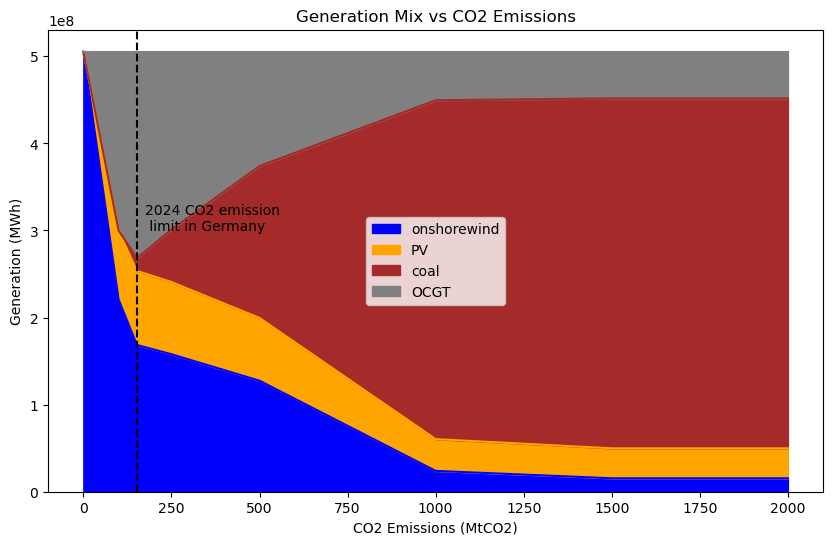

In [48]:
results = pd.DataFrame(
    np.array([onwind, pv, coal, ocgt]).T,
    columns=["onshorewind", "PV", "coal", "OCGT"],
    index=[2000, 1500, 1000, 500, 250, 152, 100, 0],
)
results.plot.area(
    stacked=True,
    title="Generation Mix vs CO2 Emissions",
    ylabel="Generation (MWh)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)
plt.vlines(
    152, 0, 6e8, color="black", linestyle="--", label="2024 CO2 emission limit"
)
plt.text(
    175, 3e8, "2024 CO2 emission\n limit in Germany", color="black", fontsize=10, ha="left"
)


<Axes: title={'center': 'Generation Capacity vs CO2 Emissions'}, xlabel='CO2 Emissions (MtCO2)', ylabel='Generation Capacity (MW)'>

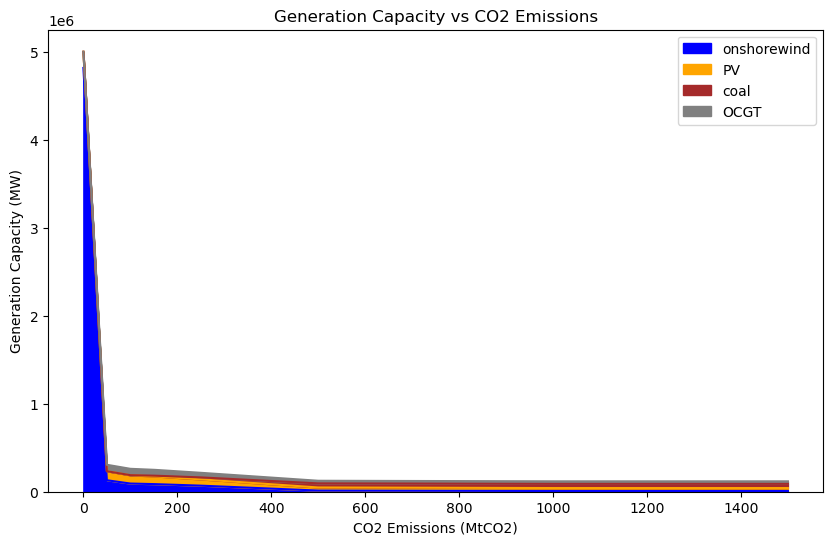

In [49]:
results_cap = pd.DataFrame(
    np.array([onwind_cap, pv_cap, coal_cap, ocgt_cap]).T,
    columns=["onshorewind", "PV", "coal", "OCGT"],
    index=[1500, 1000, 500, 250, 152, 100, 50, 0],
)
results_cap.plot.area(
    stacked=True,
    title="Generation Capacity vs CO2 Emissions",
    ylabel="Generation Capacity (MW)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)

Text(0, 0.5, 'System Cost (million euros)')

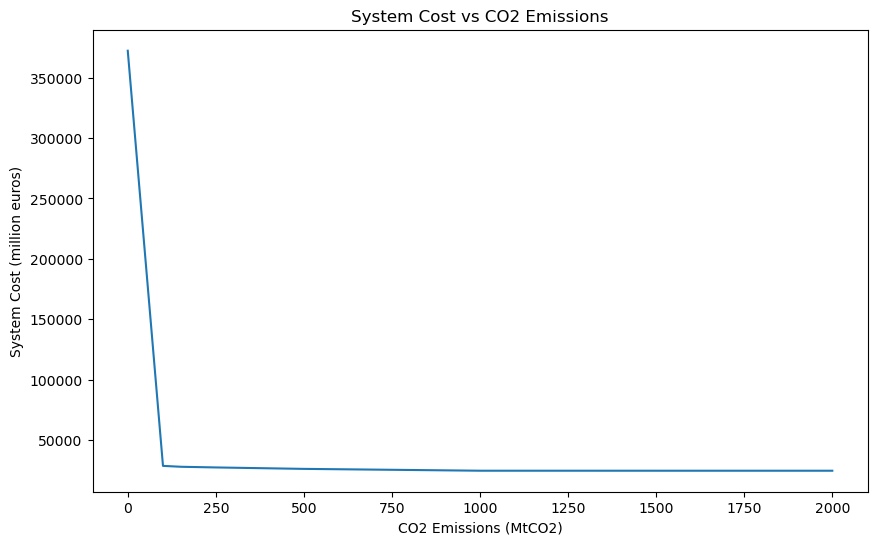

In [50]:
plt.figure(figsize=(10, 6))
plt.plot([2000, 1500, 1000, 500, 250, 152, 100, 0], systemcost)
plt.title("System Cost vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("System Cost (million euros)")

In [51]:
co2_tax

[-0.0,
 -0.0,
 0.586480549218269,
 4.173332350112169,
 5.337998133562092,
 5.76237834956526,
 50.242697968656486,
 8138720.623421226]

# Section C

In [52]:
years = df_offshorewind.index.year.unique()
years = years[(years >= 2001) & (years != 2016) & (years != 2012) & (years != 2008) & (years != 2004)]

# Remove the CO2 cap constraint
network.global_constraints.drop("CO2Limit", inplace=True)


systemcost = []
onwind = []
#offwind = []
pv = []
#rooftop = []
coal = []
ocgt = []

onwind_cap = []
#offwind_cap = []
pv_cap = []
#rooftop_cap = []
coal_cap = []
ocgt_cap = []


for year in years:
    network.generators_t.p_max_pu["onshorewind"] = df_onshorewind[country][df_onshorewind.index.year == year].values
    network.generators_t.p_max_pu["offshorewind"] = df_offshorewind[country][df_offshorewind.index.year == year].values
    network.generators_t.p_max_pu["PV"] = df_pv[country][df_pv.index.year == year].values
    network.generators_t.p_max_pu["rooftopPV"] = df_rooftop[country][df_rooftop.index.year == year].values
    
    network.optimize(solver_name="gurobi")
    systemcost.append(network.objective / 1e6)  # in million euros
    onwind.append(network.generators_t.p["onshorewind"].sum())
    #offwind.append(network.generators_t.p["offshorewind"].sum())
    pv.append(network.generators_t.p["PV"].sum())
    #rooftop.append(network.generators_t.p["rooftopPV"].sum())
    coal.append(network.generators_t.p["coal"].sum())
    ocgt.append(network.generators_t.p["OCGT"].sum())

    onwind_cap.append(network.generators.p_nom_opt.loc["onshorewind"])
    #offwind_cap.append(network.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(network.generators.p_nom_opt.loc["PV"])
    #rooftop_cap.append(network.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(network.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(network.generators.p_nom_opt.loc["OCGT"])
    

Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 18.40it/s]
INFO:linopy.io: Writing time: 0.67s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-zilgvl9n.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-zilgvl9n.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113886 rows, 52566 columns, 201768 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201768 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201768 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201768 nonzeros


Model fingerprint: 0xc39c5a18


INFO:gurobipy:Model fingerprint: 0xc39c5a18


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61044 rows and 8478 columns


INFO:gurobipy:Presolve removed 61044 rows and 8478 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52842 rows, 44088 columns, 132246 nonzeros


INFO:gurobipy:Presolved: 52842 rows, 44088 columns, 132246 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.36861268e+11  0.00000000e+00  6.36e+05 0.00e+00  2.02e+08     0s


INFO:gurobipy:   0   3.36861268e+11  0.00000000e+00  6.36e+05 0.00e+00  2.02e+08     0s


   1   5.09086687e+11 -7.41020650e+11  8.84e+04 3.60e+02  4.27e+07     0s


INFO:gurobipy:   1   5.09086687e+11 -7.41020650e+11  8.84e+04 3.60e+02  4.27e+07     0s


   2   3.40015833e+11 -2.74171672e+11  1.16e-10 4.47e+00  4.93e+06     0s


INFO:gurobipy:   2   3.40015833e+11 -2.74171672e+11  1.16e-10 4.47e+00  4.93e+06     0s


   3   1.21162310e+11 -2.46831029e+10  1.16e-10 4.64e-01  1.12e+06     0s


INFO:gurobipy:   3   1.21162310e+11 -2.46831029e+10  1.16e-10 4.64e-01  1.12e+06     0s


   4   8.01192312e+10  4.97536699e+09  1.75e-10 8.08e-02  5.73e+05     0s


INFO:gurobipy:   4   8.01192312e+10  4.97536699e+09  1.75e-10 8.08e-02  5.73e+05     0s


   5   5.59561065e+10  1.25972594e+10  2.33e-10 1.72e-09  3.30e+05     0s


INFO:gurobipy:   5   5.59561065e+10  1.25972594e+10  2.33e-10 1.72e-09  3.30e+05     0s


   6   4.17757760e+10  1.71042656e+10  2.91e-10 0.00e+00  1.88e+05     0s


INFO:gurobipy:   6   4.17757760e+10  1.71042656e+10  2.91e-10 0.00e+00  1.88e+05     0s


   7   3.93349331e+10  2.12519259e+10  2.91e-09 2.69e-09  1.37e+05     0s


INFO:gurobipy:   7   3.93349331e+10  2.12519259e+10  2.91e-09 2.69e-09  1.37e+05     0s


   8   3.48124951e+10  2.25661295e+10  3.23e-08 2.02e-09  9.29e+04     0s


INFO:gurobipy:   8   3.48124951e+10  2.25661295e+10  3.23e-08 2.02e-09  9.29e+04     0s


   9   2.88784739e+10  2.33180685e+10  4.04e-07 2.53e-10  4.22e+04     0s


INFO:gurobipy:   9   2.88784739e+10  2.33180685e+10  4.04e-07 2.53e-10  4.22e+04     0s


  10   2.71912269e+10  2.41434587e+10  5.69e-07 2.34e-09  2.31e+04     1s


INFO:gurobipy:  10   2.71912269e+10  2.41434587e+10  5.69e-07 2.34e-09  2.31e+04     1s


  11   2.62897959e+10  2.44317523e+10  1.22e-06 2.91e-10  1.41e+04     1s


INFO:gurobipy:  11   2.62897959e+10  2.44317523e+10  1.22e-06 2.91e-10  1.41e+04     1s


  12   2.58429692e+10  2.45365866e+10  1.94e-07 3.30e-10  9.90e+03     1s


INFO:gurobipy:  12   2.58429692e+10  2.45365866e+10  1.94e-07 3.30e-10  9.90e+03     1s


  13   2.56140150e+10  2.46337769e+10  7.67e-07 1.75e-09  7.43e+03     1s


INFO:gurobipy:  13   2.56140150e+10  2.46337769e+10  7.67e-07 1.75e-09  7.43e+03     1s


  14   2.54573379e+10  2.47033774e+10  1.67e-06 7.03e-10  5.72e+03     1s


INFO:gurobipy:  14   2.54573379e+10  2.47033774e+10  1.67e-06 7.03e-10  5.72e+03     1s


  15   2.53028050e+10  2.47756967e+10  1.65e-06 1.71e-09  4.00e+03     1s


INFO:gurobipy:  15   2.53028050e+10  2.47756967e+10  1.65e-06 1.71e-09  4.00e+03     1s


  16   2.52123002e+10  2.48159677e+10  1.01e-06 6.73e-10  3.00e+03     1s


INFO:gurobipy:  16   2.52123002e+10  2.48159677e+10  1.01e-06 6.73e-10  3.00e+03     1s


  17   2.51667138e+10  2.48291373e+10  4.39e-07 3.28e-10  2.56e+03     1s


INFO:gurobipy:  17   2.51667138e+10  2.48291373e+10  4.39e-07 3.28e-10  2.56e+03     1s


  18   2.51160279e+10  2.48505290e+10  2.93e-07 7.97e-10  2.01e+03     1s


INFO:gurobipy:  18   2.51160279e+10  2.48505290e+10  2.93e-07 7.97e-10  2.01e+03     1s


  19   2.50829169e+10  2.48725235e+10  1.18e-06 1.39e-09  1.59e+03     1s


INFO:gurobipy:  19   2.50829169e+10  2.48725235e+10  1.18e-06 1.39e-09  1.59e+03     1s


  20   2.50642678e+10  2.48771015e+10  4.20e-07 1.06e-09  1.42e+03     1s


INFO:gurobipy:  20   2.50642678e+10  2.48771015e+10  4.20e-07 1.06e-09  1.42e+03     1s


  21   2.50395717e+10  2.48907676e+10  8.23e-07 4.89e-10  1.13e+03     1s


INFO:gurobipy:  21   2.50395717e+10  2.48907676e+10  8.23e-07 4.89e-10  1.13e+03     1s


  22   2.50194493e+10  2.48951016e+10  6.93e-07 4.92e-10  9.43e+02     1s


INFO:gurobipy:  22   2.50194493e+10  2.48951016e+10  6.93e-07 4.92e-10  9.43e+02     1s


  23   2.50093624e+10  2.48977910e+10  6.04e-07 1.51e-09  8.46e+02     1s


INFO:gurobipy:  23   2.50093624e+10  2.48977910e+10  6.04e-07 1.51e-09  8.46e+02     1s


  24   2.50034309e+10  2.49056388e+10  5.65e-07 6.19e-10  7.41e+02     1s


INFO:gurobipy:  24   2.50034309e+10  2.49056388e+10  5.65e-07 6.19e-10  7.41e+02     1s


  25   2.49902268e+10  2.49081185e+10  7.36e-07 5.89e-10  6.22e+02     1s


INFO:gurobipy:  25   2.49902268e+10  2.49081185e+10  7.36e-07 5.89e-10  6.22e+02     1s


  26   2.49829869e+10  2.49094430e+10  1.28e-06 4.12e-10  5.57e+02     1s


INFO:gurobipy:  26   2.49829869e+10  2.49094430e+10  1.28e-06 4.12e-10  5.57e+02     1s


  27   2.49767260e+10  2.49110980e+10  8.53e-07 4.73e-10  4.97e+02     1s


INFO:gurobipy:  27   2.49767260e+10  2.49110980e+10  8.53e-07 4.73e-10  4.97e+02     1s


  28   2.49715745e+10  2.49126194e+10  8.79e-07 8.82e-10  4.47e+02     1s


INFO:gurobipy:  28   2.49715745e+10  2.49126194e+10  8.79e-07 8.82e-10  4.47e+02     1s


  29   2.49680616e+10  2.49133942e+10  8.93e-07 3.52e-09  4.14e+02     1s


INFO:gurobipy:  29   2.49680616e+10  2.49133942e+10  8.93e-07 3.52e-09  4.14e+02     1s


  30   2.49662357e+10  2.49141823e+10  3.06e-06 6.45e-09  3.95e+02     1s


INFO:gurobipy:  30   2.49662357e+10  2.49141823e+10  3.06e-06 6.45e-09  3.95e+02     1s


  31   2.49593714e+10  2.49161921e+10  2.63e-06 1.30e-08  3.27e+02     1s


INFO:gurobipy:  31   2.49593714e+10  2.49161921e+10  2.63e-06 1.30e-08  3.27e+02     1s


  32   2.49570948e+10  2.49169497e+10  2.44e-06 1.32e-08  3.04e+02     1s


INFO:gurobipy:  32   2.49570948e+10  2.49169497e+10  2.44e-06 1.32e-08  3.04e+02     1s


  33   2.49529202e+10  2.49188031e+10  2.25e-06 1.95e-08  2.59e+02     1s


INFO:gurobipy:  33   2.49529202e+10  2.49188031e+10  2.25e-06 1.95e-08  2.59e+02     1s


  34   2.49503935e+10  2.49192536e+10  2.08e-06 2.07e-08  2.36e+02     1s


INFO:gurobipy:  34   2.49503935e+10  2.49192536e+10  2.08e-06 2.07e-08  2.36e+02     1s


  35   2.49495604e+10  2.49195828e+10  2.01e-06 2.14e-08  2.27e+02     1s


INFO:gurobipy:  35   2.49495604e+10  2.49195828e+10  2.01e-06 2.14e-08  2.27e+02     1s


INFO:gurobipy:


Barrier performed 35 iterations in 1.41 seconds (0.69 work units)


INFO:gurobipy:Barrier performed 35 iterations in 1.41 seconds (0.69 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33067    2.4925832e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   33067    2.4925832e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 33067 iterations and 1.47 seconds (1.03 work units)


INFO:gurobipy:Solved in 33067 iterations and 1.47 seconds (1.03 work units)


Optimal objective  2.492583166e+10


INFO:gurobipy:Optimal objective  2.492583166e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.49e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.73it/s]
INFO:linopy.io: Writing time: 0.7s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-wcaq9369.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-wcaq9369.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113886 rows, 52566 columns, 201733 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201733 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201733 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201733 nonzeros


Model fingerprint: 0x224f6b3c


INFO:gurobipy:Model fingerprint: 0x224f6b3c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61079 rows and 8513 columns


INFO:gurobipy:Presolve removed 61079 rows and 8513 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52807 rows, 44053 columns, 132141 nonzeros


INFO:gurobipy:Presolved: 52807 rows, 44053 columns, 132141 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.809e+04


INFO:gurobipy: AA' NZ     : 8.809e+04


 Factor NZ  : 4.642e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.642e+05 (roughly 40 MB of memory)


 Factor Ops : 4.363e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.363e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.16152772e+11  0.00000000e+00  6.29e+05 0.00e+00  1.95e+08     0s


INFO:gurobipy:   0   3.16152772e+11  0.00000000e+00  6.29e+05 0.00e+00  1.95e+08     0s


   1   4.65605470e+11 -7.09938934e+11  9.47e+04 3.52e+02  4.48e+07     0s


INFO:gurobipy:   1   4.65605470e+11 -7.09938934e+11  9.47e+04 3.52e+02  4.48e+07     0s


   2   3.42703217e+11 -2.90156196e+11  1.16e-10 5.79e+00  5.15e+06     0s


INFO:gurobipy:   2   3.42703217e+11 -2.90156196e+11  1.16e-10 5.79e+00  5.15e+06     0s


   3   9.99200160e+10 -1.46925019e+10  1.16e-10 3.65e-01  8.84e+05     0s


INFO:gurobipy:   3   9.99200160e+10 -1.46925019e+10  1.16e-10 3.65e-01  8.84e+05     0s


   4   7.21577109e+10  6.86949843e+09  1.16e-10 5.56e-02  4.99e+05     0s


INFO:gurobipy:   4   7.21577109e+10  6.86949843e+09  1.16e-10 5.56e-02  4.99e+05     0s


   5   5.66116696e+10  1.30192769e+10  1.16e-10 1.10e-02  3.32e+05     0s


INFO:gurobipy:   5   5.66116696e+10  1.30192769e+10  1.16e-10 1.10e-02  3.32e+05     0s


   6   4.12573623e+10  1.60254236e+10  5.24e-10 2.44e-09  1.92e+05     0s


INFO:gurobipy:   6   4.12573623e+10  1.60254236e+10  5.24e-10 2.44e-09  1.92e+05     0s


   7   3.76207590e+10  2.11711161e+10  2.44e-09 1.76e-09  1.25e+05     0s


INFO:gurobipy:   7   3.76207590e+10  2.11711161e+10  2.44e-09 1.76e-09  1.25e+05     0s


   8   3.56581335e+10  2.20602774e+10  5.82e-08 8.73e-10  1.03e+05     0s


INFO:gurobipy:   8   3.56581335e+10  2.20602774e+10  5.82e-08 8.73e-10  1.03e+05     0s


   9   2.99316909e+10  2.28271099e+10  9.70e-08 2.38e-10  5.39e+04     0s


INFO:gurobipy:   9   2.99316909e+10  2.28271099e+10  9.70e-08 2.38e-10  5.39e+04     0s


  10   2.70075827e+10  2.36229907e+10  5.03e-08 1.20e-09  2.57e+04     0s


INFO:gurobipy:  10   2.70075827e+10  2.36229907e+10  5.03e-08 1.20e-09  2.57e+04     0s


  11   2.65250996e+10  2.42197985e+10  3.43e-07 1.38e-09  1.75e+04     1s


INFO:gurobipy:  11   2.65250996e+10  2.42197985e+10  3.43e-07 1.38e-09  1.75e+04     1s


  12   2.56999596e+10  2.44334928e+10  9.48e-07 7.49e-10  9.60e+03     1s


INFO:gurobipy:  12   2.56999596e+10  2.44334928e+10  9.48e-07 7.49e-10  9.60e+03     1s


  13   2.52993924e+10  2.45424298e+10  4.50e-07 2.98e-10  5.74e+03     1s


INFO:gurobipy:  13   2.52993924e+10  2.45424298e+10  4.50e-07 2.98e-10  5.74e+03     1s


  14   2.51357256e+10  2.46047766e+10  3.05e-07 3.24e-10  4.03e+03     1s


INFO:gurobipy:  14   2.51357256e+10  2.46047766e+10  3.05e-07 3.24e-10  4.03e+03     1s


  15   2.50324482e+10  2.46845888e+10  2.16e-07 3.26e-10  2.64e+03     1s


INFO:gurobipy:  15   2.50324482e+10  2.46845888e+10  2.16e-07 3.26e-10  2.64e+03     1s


  16   2.49511927e+10  2.47214207e+10  2.27e-07 1.24e-09  1.74e+03     1s


INFO:gurobipy:  16   2.49511927e+10  2.47214207e+10  2.27e-07 1.24e-09  1.74e+03     1s


  17   2.49049321e+10  2.47394371e+10  2.38e-07 3.69e-10  1.26e+03     1s


INFO:gurobipy:  17   2.49049321e+10  2.47394371e+10  2.38e-07 3.69e-10  1.26e+03     1s


  18   2.48763554e+10  2.47485264e+10  3.99e-07 5.26e-10  9.70e+02     1s


INFO:gurobipy:  18   2.48763554e+10  2.47485264e+10  3.99e-07 5.26e-10  9.70e+02     1s


  19   2.48645798e+10  2.47590857e+10  3.30e-07 2.56e-09  8.01e+02     1s


INFO:gurobipy:  19   2.48645798e+10  2.47590857e+10  3.30e-07 2.56e-09  8.01e+02     1s


  20   2.48485342e+10  2.47736427e+10  2.56e-07 3.42e-10  5.68e+02     1s


INFO:gurobipy:  20   2.48485342e+10  2.47736427e+10  2.56e-07 3.42e-10  5.68e+02     1s


  21   2.48368347e+10  2.47809862e+10  1.20e-07 1.22e-09  4.24e+02     1s


INFO:gurobipy:  21   2.48368347e+10  2.47809862e+10  1.20e-07 1.22e-09  4.24e+02     1s


  22   2.48325669e+10  2.47851936e+10  6.03e-08 2.75e-10  3.60e+02     1s


INFO:gurobipy:  22   2.48325669e+10  2.47851936e+10  6.03e-08 2.75e-10  3.60e+02     1s


  23   2.48276074e+10  2.47882444e+10  1.51e-07 6.58e-10  2.99e+02     1s


INFO:gurobipy:  23   2.48276074e+10  2.47882444e+10  1.51e-07 6.58e-10  2.99e+02     1s


  24   2.48233436e+10  2.47919487e+10  1.28e-07 3.46e-10  2.38e+02     1s


INFO:gurobipy:  24   2.48233436e+10  2.47919487e+10  1.28e-07 3.46e-10  2.38e+02     1s


  25   2.48178086e+10  2.47976215e+10  3.12e-07 6.15e-10  1.53e+02     1s


INFO:gurobipy:  25   2.48178086e+10  2.47976215e+10  3.12e-07 6.15e-10  1.53e+02     1s


  26   2.48153350e+10  2.47997803e+10  4.23e-07 4.27e-10  1.18e+02     1s


INFO:gurobipy:  26   2.48153350e+10  2.47997803e+10  4.23e-07 4.27e-10  1.18e+02     1s


  27   2.48139299e+10  2.48013754e+10  4.54e-07 8.55e-10  9.54e+01     1s


INFO:gurobipy:  27   2.48139299e+10  2.48013754e+10  4.54e-07 8.55e-10  9.54e+01     1s


  28   2.48129011e+10  2.48022077e+10  2.10e-07 5.05e-10  8.13e+01     1s


INFO:gurobipy:  28   2.48129011e+10  2.48022077e+10  2.10e-07 5.05e-10  8.13e+01     1s


  29   2.48119864e+10  2.48024290e+10  1.29e-06 8.72e-10  7.27e+01     1s


INFO:gurobipy:  29   2.48119864e+10  2.48024290e+10  1.29e-06 8.72e-10  7.27e+01     1s


  30   2.48116421e+10  2.48039151e+10  1.04e-06 1.09e-09  5.87e+01     1s


INFO:gurobipy:  30   2.48116421e+10  2.48039151e+10  1.04e-06 1.09e-09  5.87e+01     1s


  31   2.48109632e+10  2.48045511e+10  2.26e-06 1.78e-09  4.88e+01     1s


INFO:gurobipy:  31   2.48109632e+10  2.48045511e+10  2.26e-06 1.78e-09  4.88e+01     1s


  32   2.48105479e+10  2.48058466e+10  1.70e-06 1.55e-09  3.57e+01     1s


INFO:gurobipy:  32   2.48105479e+10  2.48058466e+10  1.70e-06 1.55e-09  3.57e+01     1s


  33   2.48099415e+10  2.48074529e+10  1.32e-06 2.29e-09  1.89e+01     1s


INFO:gurobipy:  33   2.48099415e+10  2.48074529e+10  1.32e-06 2.29e-09  1.89e+01     1s


  34   2.48094927e+10  2.48081470e+10  7.36e-07 1.44e-09  1.02e+01     1s


INFO:gurobipy:  34   2.48094927e+10  2.48081470e+10  7.36e-07 1.44e-09  1.02e+01     1s


  35   2.48093752e+10  2.48086480e+10  7.78e-07 1.59e-09  5.54e+00     1s


INFO:gurobipy:  35   2.48093752e+10  2.48086480e+10  7.78e-07 1.59e-09  5.54e+00     1s


  36   2.48093044e+10  2.48090555e+10  3.38e-06 1.84e-09  1.89e+00     1s


INFO:gurobipy:  36   2.48093044e+10  2.48090555e+10  3.38e-06 1.84e-09  1.89e+00     1s


  37   2.48092957e+10  2.48090886e+10  3.11e-06 2.68e-09  1.58e+00     1s


INFO:gurobipy:  37   2.48092957e+10  2.48090886e+10  3.11e-06 2.68e-09  1.58e+00     1s


  38   2.48092898e+10  2.48091445e+10  2.34e-06 7.02e-10  1.11e+00     1s


INFO:gurobipy:  38   2.48092898e+10  2.48091445e+10  2.34e-06 7.02e-10  1.11e+00     1s


  39   2.48092861e+10  2.48092390e+10  1.60e-06 3.78e-10  3.59e-01     1s


INFO:gurobipy:  39   2.48092861e+10  2.48092390e+10  1.60e-06 3.78e-10  3.59e-01     1s


  40   2.48092848e+10  2.48092803e+10  8.16e-07 3.00e-10  3.42e-02     1s


INFO:gurobipy:  40   2.48092848e+10  2.48092803e+10  8.16e-07 3.00e-10  3.42e-02     1s


  41   2.48092846e+10  2.48092845e+10  3.41e-07 1.81e-09  4.70e-04     1s


INFO:gurobipy:  41   2.48092846e+10  2.48092845e+10  3.41e-07 1.81e-09  4.70e-04     1s


  42   2.48092846e+10  2.48092846e+10  9.54e-09 1.09e-09  1.58e-06     2s


INFO:gurobipy:  42   2.48092846e+10  2.48092846e+10  9.54e-09 1.09e-09  1.58e-06     2s


  43   2.48092846e+10  2.48092846e+10  1.16e-10 8.73e-10  1.59e-12     2s


INFO:gurobipy:  43   2.48092846e+10  2.48092846e+10  1.16e-10 8.73e-10  1.59e-12     2s


INFO:gurobipy:


Barrier solved model in 43 iterations and 1.57 seconds (0.80 work units)


INFO:gurobipy:Barrier solved model in 43 iterations and 1.57 seconds (0.80 work units)


Optimal objective 2.48092846e+10


INFO:gurobipy:Optimal objective 2.48092846e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13281 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13281 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6589669e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6589669e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13285    2.4809285e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13285    2.4809285e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13285 iterations and 1.77 seconds (0.87 work units)


INFO:gurobipy:Solved in 13285 iterations and 1.77 seconds (0.87 work units)


Optimal objective  2.480928456e+10


INFO:gurobipy:Optimal objective  2.480928456e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.64it/s]
INFO:linopy.io: Writing time: 0.66s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-dppoj_sy.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-dppoj_sy.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113886 rows, 52566 columns, 201756 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201756 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201756 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201756 nonzeros


Model fingerprint: 0x3a3f7fcf


INFO:gurobipy:Model fingerprint: 0x3a3f7fcf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61056 rows and 8490 columns


INFO:gurobipy:Presolve removed 61056 rows and 8490 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 52830 rows, 44076 columns, 132210 nonzeros


INFO:gurobipy:Presolved: 52830 rows, 44076 columns, 132210 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.814e+04


INFO:gurobipy: AA' NZ     : 8.814e+04


 Factor NZ  : 4.646e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.646e+05 (roughly 40 MB of memory)


 Factor Ops : 4.369e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.369e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.31017209e+11  0.00000000e+00  6.23e+05 0.00e+00  1.99e+08     0s


INFO:gurobipy:   0   3.31017209e+11  0.00000000e+00  6.23e+05 0.00e+00  1.99e+08     0s


   1   4.95144804e+11 -7.77854446e+11  8.79e+04 3.63e+02  4.21e+07     0s


INFO:gurobipy:   1   4.95144804e+11 -7.77854446e+11  8.79e+04 3.63e+02  4.21e+07     0s


   2   3.31334736e+11 -2.74026881e+11  1.16e-10 6.41e+00  4.95e+06     0s


INFO:gurobipy:   2   3.31334736e+11 -2.74026881e+11  1.16e-10 6.41e+00  4.95e+06     0s


   3   1.31204554e+11 -1.04629706e+10  4.07e-10 3.48e-01  1.09e+06     0s


INFO:gurobipy:   3   1.31204554e+11 -1.04629706e+10  4.07e-10 3.48e-01  1.09e+06     0s


   4   8.48185810e+10  6.18706062e+09  1.75e-10 1.31e-01  6.01e+05     0s


INFO:gurobipy:   4   8.48185810e+10  6.18706062e+09  1.75e-10 1.31e-01  6.01e+05     0s


   5   5.80068380e+10  9.56730376e+09  1.75e-10 1.31e-01  3.70e+05     0s


INFO:gurobipy:   5   5.80068380e+10  9.56730376e+09  1.75e-10 1.31e-01  3.70e+05     0s


   6   4.38627444e+10  1.29058106e+10  3.20e-10 6.41e-02  2.36e+05     0s


INFO:gurobipy:   6   4.38627444e+10  1.29058106e+10  3.20e-10 6.41e-02  2.36e+05     0s


   7   3.90399817e+10  1.91920248e+10  9.90e-10 2.59e-02  1.51e+05     0s


INFO:gurobipy:   7   3.90399817e+10  1.91920248e+10  9.90e-10 2.59e-02  1.51e+05     0s


   8   3.56597577e+10  2.12810740e+10  5.37e-09 1.91e-02  1.09e+05     0s


INFO:gurobipy:   8   3.56597577e+10  2.12810740e+10  5.37e-09 1.91e-02  1.09e+05     0s


   9   2.96924895e+10  2.24764766e+10  5.10e-08 7.86e-03  5.49e+04     0s


INFO:gurobipy:   9   2.96924895e+10  2.24764766e+10  5.10e-08 7.86e-03  5.49e+04     0s


  10   2.72625295e+10  2.35368545e+10  5.58e-08 2.96e-03  2.83e+04     1s


INFO:gurobipy:  10   2.72625295e+10  2.35368545e+10  5.58e-08 2.96e-03  2.83e+04     1s


  11   2.67299583e+10  2.40125513e+10  6.74e-08 2.23e-03  2.06e+04     1s


INFO:gurobipy:  11   2.67299583e+10  2.40125513e+10  6.74e-08 2.23e-03  2.06e+04     1s


  12   2.62921283e+10  2.41751921e+10  1.33e-06 1.86e-03  1.61e+04     1s


INFO:gurobipy:  12   2.62921283e+10  2.41751921e+10  1.33e-06 1.86e-03  1.61e+04     1s


  13   2.56952597e+10  2.42857977e+10  8.42e-07 1.99e-09  1.07e+04     1s


INFO:gurobipy:  13   2.56952597e+10  2.42857977e+10  8.42e-07 1.99e-09  1.07e+04     1s


  14   2.53547119e+10  2.43644841e+10  6.90e-07 3.80e-10  7.52e+03     1s


INFO:gurobipy:  14   2.53547119e+10  2.43644841e+10  6.90e-07 3.80e-10  7.52e+03     1s


  15   2.51549296e+10  2.44627890e+10  5.49e-07 1.07e-09  5.25e+03     1s


INFO:gurobipy:  15   2.51549296e+10  2.44627890e+10  5.49e-07 1.07e-09  5.25e+03     1s


  16   2.50279808e+10  2.45144283e+10  3.76e-07 1.72e-05  3.90e+03     1s


INFO:gurobipy:  16   2.50279808e+10  2.45144283e+10  3.76e-07 1.72e-05  3.90e+03     1s


  17   2.49439065e+10  2.45336485e+10  7.73e-07 2.21e-05  3.12e+03     1s


INFO:gurobipy:  17   2.49439065e+10  2.45336485e+10  7.73e-07 2.21e-05  3.12e+03     1s


  18   2.48973064e+10  2.45513496e+10  9.65e-07 2.35e-05  2.63e+03     1s


INFO:gurobipy:  18   2.48973064e+10  2.45513496e+10  9.65e-07 2.35e-05  2.63e+03     1s


  19   2.48656380e+10  2.45828198e+10  6.34e-07 2.52e-05  2.15e+03     1s


INFO:gurobipy:  19   2.48656380e+10  2.45828198e+10  6.34e-07 2.52e-05  2.15e+03     1s


  20   2.48387701e+10  2.46001872e+10  5.49e-07 2.25e-05  1.81e+03     1s


INFO:gurobipy:  20   2.48387701e+10  2.46001872e+10  5.49e-07 2.25e-05  1.81e+03     1s


  21   2.48090525e+10  2.46184213e+10  2.17e-07 1.96e-05  1.45e+03     1s


INFO:gurobipy:  21   2.48090525e+10  2.46184213e+10  2.17e-07 1.96e-05  1.45e+03     1s


  22   2.47750583e+10  2.46309536e+10  1.99e-07 1.60e-05  1.09e+03     1s


INFO:gurobipy:  22   2.47750583e+10  2.46309536e+10  1.99e-07 1.60e-05  1.09e+03     1s


  23   2.47626588e+10  2.46342729e+10  2.10e-07 1.46e-05  9.74e+02     1s


INFO:gurobipy:  23   2.47626588e+10  2.46342729e+10  2.10e-07 1.46e-05  9.74e+02     1s


  24   2.47404844e+10  2.46435030e+10  2.40e-07 6.88e-06  7.36e+02     1s


INFO:gurobipy:  24   2.47404844e+10  2.46435030e+10  2.40e-07 6.88e-06  7.36e+02     1s


  25   2.47337575e+10  2.46449788e+10  1.74e-07 6.32e-06  6.74e+02     1s


INFO:gurobipy:  25   2.47337575e+10  2.46449788e+10  1.74e-07 6.32e-06  6.74e+02     1s


  26   2.47226038e+10  2.46496056e+10  2.21e-07 4.65e-06  5.54e+02     1s


INFO:gurobipy:  26   2.47226038e+10  2.46496056e+10  2.21e-07 4.65e-06  5.54e+02     1s


  27   2.47115446e+10  2.46531492e+10  3.20e-07 3.21e-06  4.43e+02     1s


INFO:gurobipy:  27   2.47115446e+10  2.46531492e+10  3.20e-07 3.21e-06  4.43e+02     1s


  28   2.47065551e+10  2.46549528e+10  1.65e-07 2.43e-06  3.91e+02     1s


INFO:gurobipy:  28   2.47065551e+10  2.46549528e+10  1.65e-07 2.43e-06  3.91e+02     1s


  29   2.46983059e+10  2.46565231e+10  1.87e-06 1.74e-06  3.17e+02     1s


INFO:gurobipy:  29   2.46983059e+10  2.46565231e+10  1.87e-06 1.74e-06  3.17e+02     1s


  30   2.46920688e+10  2.46587717e+10  1.52e-06 8.67e-07  2.53e+02     1s


INFO:gurobipy:  30   2.46920688e+10  2.46587717e+10  1.52e-06 8.67e-07  2.53e+02     1s


  31   2.46888741e+10  2.46593013e+10  1.33e-06 6.59e-07  2.24e+02     1s


INFO:gurobipy:  31   2.46888741e+10  2.46593013e+10  1.33e-06 6.59e-07  2.24e+02     1s


  32   2.46866413e+10  2.46605679e+10  1.22e-06 5.04e-09  1.98e+02     1s


INFO:gurobipy:  32   2.46866413e+10  2.46605679e+10  1.22e-06 5.04e-09  1.98e+02     1s


  33   2.46839217e+10  2.46612545e+10  1.06e-06 6.98e-09  1.72e+02     1s


INFO:gurobipy:  33   2.46839217e+10  2.46612545e+10  1.06e-06 6.98e-09  1.72e+02     1s


  34   2.46804788e+10  2.46621930e+10  8.58e-07 6.70e-09  1.39e+02     1s


INFO:gurobipy:  34   2.46804788e+10  2.46621930e+10  8.58e-07 6.70e-09  1.39e+02     1s


  35   2.46791377e+10  2.46623671e+10  7.84e-07 6.53e-09  1.27e+02     1s


INFO:gurobipy:  35   2.46791377e+10  2.46623671e+10  7.84e-07 6.53e-09  1.27e+02     1s


  36   2.46762068e+10  2.46626263e+10  6.68e-07 7.12e-09  1.03e+02     1s


INFO:gurobipy:  36   2.46762068e+10  2.46626263e+10  6.68e-07 7.12e-09  1.03e+02     1s


  37   2.46746632e+10  2.46632008e+10  6.64e-07 7.02e-09  8.69e+01     1s


INFO:gurobipy:  37   2.46746632e+10  2.46632008e+10  6.64e-07 7.02e-09  8.69e+01     1s


  38   2.46736229e+10  2.46633196e+10  1.80e-06 6.62e-09  7.81e+01     1s


INFO:gurobipy:  38   2.46736229e+10  2.46633196e+10  1.80e-06 6.62e-09  7.81e+01     1s


  39   2.46726118e+10  2.46635820e+10  1.49e-06 6.29e-09  6.85e+01     1s


INFO:gurobipy:  39   2.46726118e+10  2.46635820e+10  1.49e-06 6.29e-09  6.85e+01     1s


  40   2.46715870e+10  2.46637592e+10  1.27e-06 5.60e-09  5.93e+01     1s


INFO:gurobipy:  40   2.46715870e+10  2.46637592e+10  1.27e-06 5.60e-09  5.93e+01     1s


  41   2.46712270e+10  2.46640458e+10  1.21e-06 4.39e-09  5.44e+01     2s


INFO:gurobipy:  41   2.46712270e+10  2.46640458e+10  1.21e-06 4.39e-09  5.44e+01     2s


  42   2.46707649e+10  2.46641989e+10  1.10e-06 3.80e-09  4.97e+01     2s


INFO:gurobipy:  42   2.46707649e+10  2.46641989e+10  1.10e-06 3.80e-09  4.97e+01     2s


  43   2.46700277e+10  2.46643255e+10  9.59e-07 4.44e-09  4.32e+01     2s


INFO:gurobipy:  43   2.46700277e+10  2.46643255e+10  9.59e-07 4.44e-09  4.32e+01     2s


  44   2.46685972e+10  2.46643697e+10  1.94e-06 4.06e-09  3.20e+01     2s


INFO:gurobipy:  44   2.46685972e+10  2.46643697e+10  1.94e-06 4.06e-09  3.20e+01     2s


  45   2.46673390e+10  2.46645577e+10  3.58e-06 3.26e-09  2.11e+01     2s


INFO:gurobipy:  45   2.46673390e+10  2.46645577e+10  3.58e-06 3.26e-09  2.11e+01     2s


  46   2.46664167e+10  2.46646911e+10  3.16e-06 2.32e-09  1.31e+01     2s


INFO:gurobipy:  46   2.46664167e+10  2.46646911e+10  3.16e-06 2.32e-09  1.31e+01     2s


  47   2.46660016e+10  2.46647835e+10  2.28e-06 1.72e-09  9.23e+00     2s


INFO:gurobipy:  47   2.46660016e+10  2.46647835e+10  2.28e-06 1.72e-09  9.23e+00     2s


  48   2.46652678e+10  2.46649348e+10  2.67e-06 2.58e-09  2.52e+00     2s


INFO:gurobipy:  48   2.46652678e+10  2.46649348e+10  2.67e-06 2.58e-09  2.52e+00     2s


  49   2.46652069e+10  2.46649418e+10  2.15e-06 1.16e-09  2.01e+00     2s


INFO:gurobipy:  49   2.46652069e+10  2.46649418e+10  2.15e-06 1.16e-09  2.01e+00     2s


  50   2.46651333e+10  2.46649432e+10  1.53e-06 9.35e-10  1.44e+00     2s


INFO:gurobipy:  50   2.46651333e+10  2.46649432e+10  1.53e-06 9.35e-10  1.44e+00     2s


  51   2.46650361e+10  2.46649446e+10  7.21e-07 7.66e-10  6.92e-01     2s


INFO:gurobipy:  51   2.46650361e+10  2.46649446e+10  7.21e-07 7.66e-10  6.92e-01     2s


  52   2.46649827e+10  2.46649466e+10  2.81e-07 3.51e-10  2.74e-01     2s


INFO:gurobipy:  52   2.46649827e+10  2.46649466e+10  2.81e-07 3.51e-10  2.74e-01     2s


  53   2.46649501e+10  2.46649480e+10  5.02e-09 1.09e-09  1.66e-02     2s


INFO:gurobipy:  53   2.46649501e+10  2.46649480e+10  5.02e-09 1.09e-09  1.66e-02     2s


  54   2.46649488e+10  2.46649488e+10  3.06e-10 3.62e-10  3.10e-04     2s


INFO:gurobipy:  54   2.46649488e+10  2.46649488e+10  3.06e-10 3.62e-10  3.10e-04     2s


  55   2.46649488e+10  2.46649488e+10  1.27e-09 1.78e-09  4.29e-09     2s


INFO:gurobipy:  55   2.46649488e+10  2.46649488e+10  1.27e-09 1.78e-09  4.29e-09     2s


INFO:gurobipy:


Barrier solved model in 55 iterations and 1.98 seconds (1.04 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 1.98 seconds (1.04 work units)


Optimal objective 2.46649488e+10


INFO:gurobipy:Optimal objective 2.46649488e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   22056 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   22056 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.9210414e-11      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.9210414e-11      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   22059    2.4664949e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   22059    2.4664949e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 22059 iterations and 2.18 seconds (1.10 work units)


INFO:gurobipy:Solved in 22059 iterations and 2.18 seconds (1.10 work units)


Optimal objective  2.466494876e+10


INFO:gurobipy:Optimal objective  2.466494876e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.47e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.32it/s]
INFO:linopy.io: Writing time: 0.65s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-ay87mbni.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-ay87mbni.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0xc9983026


INFO:gurobipy:Model fingerprint: 0xc9983026


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.14757797e+11  0.00000000e+00  6.24e+05 0.00e+00  1.93e+08     0s


INFO:gurobipy:   0   3.14757797e+11  0.00000000e+00  6.24e+05 0.00e+00  1.93e+08     0s


   1   4.81957999e+11 -7.00036761e+11  8.85e+04 3.96e+02  4.37e+07     0s


INFO:gurobipy:   1   4.81957999e+11 -7.00036761e+11  8.85e+04 3.96e+02  4.37e+07     0s


   2   3.41291615e+11 -2.75273033e+11  2.33e-10 4.61e+00  4.95e+06     0s


INFO:gurobipy:   2   3.41291615e+11 -2.75273033e+11  2.33e-10 4.61e+00  4.95e+06     0s


   3   9.79211081e+10 -2.62252408e+10  1.16e-10 4.43e-01  9.58e+05     0s


INFO:gurobipy:   3   9.79211081e+10 -2.62252408e+10  1.16e-10 4.43e-01  9.58e+05     0s


   4   6.80253937e+10  6.94484167e+09  1.16e-10 8.90e-02  4.65e+05     0s


INFO:gurobipy:   4   6.80253937e+10  6.94484167e+09  1.16e-10 8.90e-02  4.65e+05     0s


   5   5.67222517e+10  1.10387173e+10  1.75e-10 3.91e-02  3.48e+05     0s


INFO:gurobipy:   5   5.67222517e+10  1.10387173e+10  1.75e-10 3.91e-02  3.48e+05     0s


   6   4.20131303e+10  1.49144329e+10  3.20e-10 5.91e-02  2.06e+05     0s


INFO:gurobipy:   6   4.20131303e+10  1.49144329e+10  3.20e-10 5.91e-02  2.06e+05     0s


   7   3.88450459e+10  2.07134093e+10  7.45e-09 3.65e-03  1.37e+05     0s


INFO:gurobipy:   7   3.88450459e+10  2.07134093e+10  7.45e-09 3.65e-03  1.37e+05     0s


   8   3.44033864e+10  2.21877420e+10  3.04e-08 2.42e-09  9.26e+04     0s


INFO:gurobipy:   8   3.44033864e+10  2.21877420e+10  3.04e-08 2.42e-09  9.26e+04     0s


   9   2.92421080e+10  2.30245609e+10  4.75e-08 3.84e-10  4.71e+04     0s


INFO:gurobipy:   9   2.92421080e+10  2.30245609e+10  4.75e-08 3.84e-10  4.71e+04     0s


  10   2.71335627e+10  2.38995287e+10  5.60e-07 9.66e-10  2.45e+04     1s


INFO:gurobipy:  10   2.71335627e+10  2.38995287e+10  5.60e-07 9.66e-10  2.45e+04     1s


  11   2.62328964e+10  2.42596211e+10  3.84e-07 1.69e-09  1.49e+04     1s


INFO:gurobipy:  11   2.62328964e+10  2.42596211e+10  3.84e-07 1.69e-09  1.49e+04     1s


  12   2.56822280e+10  2.43711077e+10  7.88e-07 4.01e-09  9.93e+03     1s


INFO:gurobipy:  12   2.56822280e+10  2.43711077e+10  7.88e-07 4.01e-09  9.93e+03     1s


  13   2.54163728e+10  2.44723215e+10  1.47e-06 2.44e-09  7.15e+03     1s


INFO:gurobipy:  13   2.54163728e+10  2.44723215e+10  1.47e-06 2.44e-09  7.15e+03     1s


  14   2.52337675e+10  2.45396976e+10  2.07e-06 1.71e-09  5.26e+03     1s


INFO:gurobipy:  14   2.52337675e+10  2.45396976e+10  2.07e-06 1.71e-09  5.26e+03     1s


  15   2.50846387e+10  2.46054963e+10  1.42e-05 1.05e-10  3.63e+03     1s


INFO:gurobipy:  15   2.50846387e+10  2.46054963e+10  1.42e-05 1.05e-10  3.63e+03     1s


  16   2.49906809e+10  2.46383123e+10  9.50e-06 5.38e-10  2.67e+03     1s


INFO:gurobipy:  16   2.49906809e+10  2.46383123e+10  9.50e-06 5.38e-10  2.67e+03     1s


  17   2.49391986e+10  2.46517751e+10  3.87e-06 6.25e-11  2.18e+03     1s


INFO:gurobipy:  17   2.49391986e+10  2.46517751e+10  3.87e-06 6.25e-11  2.18e+03     1s


  18   2.49262290e+10  2.46655134e+10  3.37e-06 4.08e-11  1.97e+03     1s


INFO:gurobipy:  18   2.49262290e+10  2.46655134e+10  3.37e-06 4.08e-11  1.97e+03     1s


  19   2.49232004e+10  2.47014049e+10  2.03e-05 1.12e-10  1.68e+03     1s


INFO:gurobipy:  19   2.49232004e+10  2.47014049e+10  2.03e-05 1.12e-10  1.68e+03     1s


  20   2.48252780e+10  2.47225318e+10  6.37e-05 2.33e-09  7.78e+02     1s


INFO:gurobipy:  20   2.48252780e+10  2.47225318e+10  6.37e-05 2.33e-09  7.78e+02     1s


  21   2.48174189e+10  2.47265829e+10  5.58e-05 5.97e-10  6.88e+02     1s


INFO:gurobipy:  21   2.48174189e+10  2.47265829e+10  5.58e-05 5.97e-10  6.88e+02     1s


  22   2.48123244e+10  2.47284730e+10  5.10e-05 8.22e-10  6.35e+02     1s


INFO:gurobipy:  22   2.48123244e+10  2.47284730e+10  5.10e-05 8.22e-10  6.35e+02     1s


  23   2.48053221e+10  2.47317218e+10  4.44e-05 3.66e-10  5.58e+02     1s


INFO:gurobipy:  23   2.48053221e+10  2.47317218e+10  4.44e-05 3.66e-10  5.58e+02     1s


  24   2.47973467e+10  2.47379438e+10  3.69e-05 9.28e-10  4.50e+02     1s


INFO:gurobipy:  24   2.47973467e+10  2.47379438e+10  3.69e-05 9.28e-10  4.50e+02     1s


  25   2.47892367e+10  2.47434344e+10  2.91e-05 1.50e-09  3.47e+02     1s


INFO:gurobipy:  25   2.47892367e+10  2.47434344e+10  2.91e-05 1.50e-09  3.47e+02     1s


  26   2.47870737e+10  2.47444348e+10  2.69e-05 1.07e-09  3.23e+02     1s


INFO:gurobipy:  26   2.47870737e+10  2.47444348e+10  2.69e-05 1.07e-09  3.23e+02     1s


  27   2.47836780e+10  2.47464254e+10  2.38e-05 7.06e-10  2.82e+02     1s


INFO:gurobipy:  27   2.47836780e+10  2.47464254e+10  2.38e-05 7.06e-10  2.82e+02     1s


  28   2.47815794e+10  2.47477382e+10  2.18e-05 7.28e-10  2.56e+02     1s


INFO:gurobipy:  28   2.47815794e+10  2.47477382e+10  2.18e-05 7.28e-10  2.56e+02     1s


  29   2.47798708e+10  2.47488566e+10  2.00e-05 4.06e-10  2.35e+02     1s


INFO:gurobipy:  29   2.47798708e+10  2.47488566e+10  2.00e-05 4.06e-10  2.35e+02     1s


  30   2.47770208e+10  2.47504515e+10  1.70e-05 6.95e-10  2.01e+02     1s


INFO:gurobipy:  30   2.47770208e+10  2.47504515e+10  1.70e-05 6.95e-10  2.01e+02     1s


  31   2.47738977e+10  2.47510737e+10  1.36e-05 1.18e-10  1.73e+02     1s


INFO:gurobipy:  31   2.47738977e+10  2.47510737e+10  1.36e-05 1.18e-10  1.73e+02     1s


  32   2.47698129e+10  2.47523569e+10  9.68e-06 6.34e-10  1.32e+02     1s


INFO:gurobipy:  32   2.47698129e+10  2.47523569e+10  9.68e-06 6.34e-10  1.32e+02     1s


  33   2.47666952e+10  2.47530142e+10  6.63e-06 5.82e-11  1.04e+02     1s


INFO:gurobipy:  33   2.47666952e+10  2.47530142e+10  6.63e-06 5.82e-11  1.04e+02     1s


  34   2.47662398e+10  2.47536038e+10  6.16e-06 7.28e-10  9.58e+01     1s


INFO:gurobipy:  34   2.47662398e+10  2.47536038e+10  6.16e-06 7.28e-10  9.58e+01     1s


  35   2.47656321e+10  2.47539845e+10  5.57e-06 8.59e-10  8.83e+01     1s


INFO:gurobipy:  35   2.47656321e+10  2.47539845e+10  5.57e-06 8.59e-10  8.83e+01     1s


  36   2.47653531e+10  2.47541732e+10  5.31e-06 6.15e-10  8.47e+01     1s


INFO:gurobipy:  36   2.47653531e+10  2.47541732e+10  5.31e-06 6.15e-10  8.47e+01     1s


  37   2.47649173e+10  2.47547622e+10  4.90e-06 1.08e-09  7.70e+01     1s


INFO:gurobipy:  37   2.47649173e+10  2.47547622e+10  4.90e-06 1.08e-09  7.70e+01     1s


  38   2.47640370e+10  2.47554446e+10  4.08e-06 6.60e-10  6.51e+01     1s


INFO:gurobipy:  38   2.47640370e+10  2.47554446e+10  4.08e-06 6.60e-10  6.51e+01     1s


  39   2.47636270e+10  2.47555263e+10  3.71e-06 5.78e-10  6.14e+01     1s


INFO:gurobipy:  39   2.47636270e+10  2.47555263e+10  3.71e-06 5.78e-10  6.14e+01     1s


  40   2.47634319e+10  2.47557767e+10  3.53e-06 9.71e-10  5.80e+01     1s


INFO:gurobipy:  40   2.47634319e+10  2.47557767e+10  3.53e-06 9.71e-10  5.80e+01     1s


  41   2.47626489e+10  2.47559378e+10  2.80e-06 1.11e-09  5.09e+01     2s


INFO:gurobipy:  41   2.47626489e+10  2.47559378e+10  2.80e-06 1.11e-09  5.09e+01     2s


  42   2.47624656e+10  2.47563305e+10  2.64e-06 3.77e-10  4.65e+01     2s


INFO:gurobipy:  42   2.47624656e+10  2.47563305e+10  2.64e-06 3.77e-10  4.65e+01     2s


  43   2.47621638e+10  2.47566319e+10  2.38e-06 9.90e-10  4.19e+01     2s


INFO:gurobipy:  43   2.47621638e+10  2.47566319e+10  2.38e-06 9.90e-10  4.19e+01     2s


  44   2.47616993e+10  2.47568686e+10  5.94e-06 2.67e-10  3.66e+01     2s


INFO:gurobipy:  44   2.47616993e+10  2.47568686e+10  5.94e-06 2.67e-10  3.66e+01     2s


  45   2.47615746e+10  2.47569960e+10  6.27e-06 8.59e-10  3.47e+01     2s


INFO:gurobipy:  45   2.47615746e+10  2.47569960e+10  6.27e-06 8.59e-10  3.47e+01     2s


  46   2.47614955e+10  2.47570506e+10  6.02e-06 8.51e-10  3.37e+01     2s


INFO:gurobipy:  46   2.47614955e+10  2.47570506e+10  6.02e-06 8.51e-10  3.37e+01     2s


  47   2.47612542e+10  2.47574186e+10  5.24e-06 6.79e-11  2.91e+01     2s


INFO:gurobipy:  47   2.47612542e+10  2.47574186e+10  5.24e-06 6.79e-11  2.91e+01     2s


  48   2.47610856e+10  2.47575513e+10  4.72e-06 1.99e-09  2.68e+01     2s


INFO:gurobipy:  48   2.47610856e+10  2.47575513e+10  4.72e-06 1.99e-09  2.68e+01     2s


  49   2.47609377e+10  2.47577876e+10  4.22e-06 1.67e-09  2.39e+01     2s


INFO:gurobipy:  49   2.47609377e+10  2.47577876e+10  4.22e-06 1.67e-09  2.39e+01     2s


  50   2.47608755e+10  2.47579337e+10  4.06e-06 1.41e-09  2.23e+01     2s


INFO:gurobipy:  50   2.47608755e+10  2.47579337e+10  4.06e-06 1.41e-09  2.23e+01     2s


  51   2.47607103e+10  2.47579631e+10  3.50e-06 1.63e-09  2.08e+01     2s


INFO:gurobipy:  51   2.47607103e+10  2.47579631e+10  3.50e-06 1.63e-09  2.08e+01     2s


  52   2.47606599e+10  2.47581452e+10  3.30e-06 1.36e-09  1.91e+01     2s


INFO:gurobipy:  52   2.47606599e+10  2.47581452e+10  3.30e-06 1.36e-09  1.91e+01     2s


  53   2.47602580e+10  2.47583737e+10  1.97e-06 3.37e-09  1.43e+01     2s


INFO:gurobipy:  53   2.47602580e+10  2.47583737e+10  1.97e-06 3.37e-09  1.43e+01     2s


  54   2.47601616e+10  2.47585121e+10  1.79e-06 1.29e-10  1.25e+01     2s


INFO:gurobipy:  54   2.47601616e+10  2.47585121e+10  1.79e-06 1.29e-10  1.25e+01     2s


  55   2.47601419e+10  2.47586419e+10  1.76e-06 1.34e-09  1.14e+01     2s


INFO:gurobipy:  55   2.47601419e+10  2.47586419e+10  1.76e-06 1.34e-09  1.14e+01     2s


  56   2.47600591e+10  2.47588140e+10  1.77e-06 4.90e-11  9.44e+00     2s


INFO:gurobipy:  56   2.47600591e+10  2.47588140e+10  1.77e-06 4.90e-11  9.44e+00     2s


  57   2.47599726e+10  2.47588730e+10  1.82e-06 9.06e-10  8.34e+00     2s


INFO:gurobipy:  57   2.47599726e+10  2.47588730e+10  1.82e-06 9.06e-10  8.34e+00     2s


  58   2.47598034e+10  2.47590134e+10  1.50e-06 5.94e-10  5.99e+00     2s


INFO:gurobipy:  58   2.47598034e+10  2.47590134e+10  1.50e-06 5.94e-10  5.99e+00     2s


  59   2.47597730e+10  2.47591484e+10  3.23e-06 5.64e-09  4.74e+00     2s


INFO:gurobipy:  59   2.47597730e+10  2.47591484e+10  3.23e-06 5.64e-09  4.74e+00     2s


  60   2.47597003e+10  2.47593169e+10  4.18e-06 2.72e-09  2.91e+00     2s


INFO:gurobipy:  60   2.47597003e+10  2.47593169e+10  4.18e-06 2.72e-09  2.91e+00     2s


  61   2.47596297e+10  2.47595506e+10  5.75e-06 4.96e-09  6.00e-01     2s


INFO:gurobipy:  61   2.47596297e+10  2.47595506e+10  5.75e-06 4.96e-09  6.00e-01     2s


  62   2.47596099e+10  2.47595721e+10  4.16e-06 4.93e-09  2.87e-01     2s


INFO:gurobipy:  62   2.47596099e+10  2.47595721e+10  4.16e-06 4.93e-09  2.87e-01     2s


  63   2.47596089e+10  2.47595811e+10  2.60e-07 3.01e-09  2.11e-01     2s


INFO:gurobipy:  63   2.47596089e+10  2.47595811e+10  2.60e-07 3.01e-09  2.11e-01     2s


  64   2.47596086e+10  2.47596063e+10  8.37e-08 1.08e-09  1.74e-02     2s


INFO:gurobipy:  64   2.47596086e+10  2.47596063e+10  8.37e-08 1.08e-09  1.74e-02     2s


  65   2.47596082e+10  2.47596082e+10  4.13e-08 2.20e-10  3.49e-06     2s


INFO:gurobipy:  65   2.47596082e+10  2.47596082e+10  4.13e-08 2.20e-10  3.49e-06     2s


  66   2.47596082e+10  2.47596082e+10  8.73e-11 7.86e-10  3.56e-12     2s


INFO:gurobipy:  66   2.47596082e+10  2.47596082e+10  8.73e-11 7.86e-10  3.56e-12     2s


INFO:gurobipy:


Barrier solved model in 66 iterations and 2.35 seconds (1.23 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 2.35 seconds (1.23 work units)


Optimal objective 2.47596082e+10


INFO:gurobipy:Optimal objective 2.47596082e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13312 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13312 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       3 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       3 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.3062172e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.3062172e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13316    2.4759608e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13316    2.4759608e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13316 iterations and 2.54 seconds (1.30 work units)


INFO:gurobipy:Solved in 13316 iterations and 2.54 seconds (1.30 work units)


Optimal objective  2.475960824e+10


INFO:gurobipy:Optimal objective  2.475960824e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.77it/s]
INFO:linopy.io: Writing time: 0.65s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-rcs9z1z3.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-rcs9z1z3.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113886 rows, 52566 columns, 201765 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201765 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


Model fingerprint: 0x6489905b


INFO:gurobipy:Model fingerprint: 0x6489905b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61047 rows and 8481 columns


INFO:gurobipy:Presolve removed 61047 rows and 8481 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.18882999e+11  0.00000000e+00  5.99e+05 0.00e+00  1.91e+08     0s


INFO:gurobipy:   0   3.18882999e+11  0.00000000e+00  5.99e+05 0.00e+00  1.91e+08     0s


   1   4.80360763e+11 -7.29003306e+11  8.90e+04 4.01e+02  4.20e+07     0s


INFO:gurobipy:   1   4.80360763e+11 -7.29003306e+11  8.90e+04 4.01e+02  4.20e+07     0s


   2   3.29911422e+11 -2.77437412e+11  1.16e-10 5.09e+00  4.90e+06     0s


INFO:gurobipy:   2   3.29911422e+11 -2.77437412e+11  1.16e-10 5.09e+00  4.90e+06     0s


   3   1.33272912e+11 -2.08784028e+10  8.73e-11 4.04e-01  1.19e+06     0s


INFO:gurobipy:   3   1.33272912e+11 -2.08784028e+10  8.73e-11 4.04e-01  1.19e+06     0s


   4   7.91121590e+10  5.77486650e+09  2.33e-10 1.39e-01  5.59e+05     0s


INFO:gurobipy:   4   7.91121590e+10  5.77486650e+09  2.33e-10 1.39e-01  5.59e+05     0s


   5   6.10620387e+10  1.20104714e+10  1.75e-10 6.15e-10  3.73e+05     0s


INFO:gurobipy:   5   6.10620387e+10  1.20104714e+10  1.75e-10 6.15e-10  3.73e+05     0s


   6   4.63792748e+10  1.57904993e+10  4.66e-10 2.13e-10  2.33e+05     0s


INFO:gurobipy:   6   4.63792748e+10  1.57904993e+10  4.66e-10 2.13e-10  2.33e+05     0s


   7   4.14935089e+10  2.11014088e+10  9.08e-09 1.27e-03  1.55e+05     0s


INFO:gurobipy:   7   4.14935089e+10  2.11014088e+10  9.08e-09 1.27e-03  1.55e+05     0s


   8   3.75120304e+10  2.20054818e+10  3.78e-07 8.02e-03  1.18e+05     0s


INFO:gurobipy:   8   3.75120304e+10  2.20054818e+10  3.78e-07 8.02e-03  1.18e+05     0s


   9   3.24481763e+10  2.27678811e+10  2.16e-07 8.55e-10  7.34e+04     0s


INFO:gurobipy:   9   3.24481763e+10  2.27678811e+10  2.16e-07 8.55e-10  7.34e+04     0s


  10   2.85402712e+10  2.35608547e+10  5.09e-07 3.97e-10  3.77e+04     0s


INFO:gurobipy:  10   2.85402712e+10  2.35608547e+10  5.09e-07 3.97e-10  3.77e+04     0s


  11   2.68012875e+10  2.41320401e+10  6.32e-07 1.32e-09  2.02e+04     1s


INFO:gurobipy:  11   2.68012875e+10  2.41320401e+10  6.32e-07 1.32e-09  2.02e+04     1s


  12   2.60052333e+10  2.42830832e+10  1.88e-06 9.82e-11  1.30e+04     1s


INFO:gurobipy:  12   2.60052333e+10  2.42830832e+10  1.88e-06 9.82e-11  1.30e+04     1s


  13   2.56325118e+10  2.44046645e+10  1.76e-06 3.93e-10  9.30e+03     1s


INFO:gurobipy:  13   2.56325118e+10  2.44046645e+10  1.76e-06 3.93e-10  9.30e+03     1s


  14   2.54597570e+10  2.44856358e+10  5.76e-07 5.04e-10  7.38e+03     1s


INFO:gurobipy:  14   2.54597570e+10  2.44856358e+10  5.76e-07 5.04e-10  7.38e+03     1s


  15   2.52459739e+10  2.45774705e+10  2.32e-06 2.69e-10  5.06e+03     1s


INFO:gurobipy:  15   2.52459739e+10  2.45774705e+10  2.32e-06 2.69e-10  5.06e+03     1s


  16   2.51225040e+10  2.46300488e+10  2.60e-06 8.25e-10  3.73e+03     1s


INFO:gurobipy:  16   2.51225040e+10  2.46300488e+10  2.60e-06 8.25e-10  3.73e+03     1s


  17   2.50632587e+10  2.46473384e+10  2.58e-06 4.85e-10  3.15e+03     1s


INFO:gurobipy:  17   2.50632587e+10  2.46473384e+10  2.58e-06 4.85e-10  3.15e+03     1s


  18   2.49972879e+10  2.46817681e+10  2.86e-06 3.13e-10  2.39e+03     1s


INFO:gurobipy:  18   2.49972879e+10  2.46817681e+10  2.86e-06 3.13e-10  2.39e+03     1s


  19   2.49509909e+10  2.47011947e+10  2.44e-06 2.41e-10  1.89e+03     1s


INFO:gurobipy:  19   2.49509909e+10  2.47011947e+10  2.44e-06 2.41e-10  1.89e+03     1s


  20   2.49249690e+10  2.47144481e+10  2.90e-06 6.62e-10  1.59e+03     1s


INFO:gurobipy:  20   2.49249690e+10  2.47144481e+10  2.90e-06 6.62e-10  1.59e+03     1s


  21   2.49101471e+10  2.47199103e+10  2.44e-06 3.92e-10  1.44e+03     1s


INFO:gurobipy:  21   2.49101471e+10  2.47199103e+10  2.44e-06 3.92e-10  1.44e+03     1s


  22   2.49000038e+10  2.47309317e+10  2.12e-06 9.17e-10  1.28e+03     1s


INFO:gurobipy:  22   2.49000038e+10  2.47309317e+10  2.12e-06 9.17e-10  1.28e+03     1s


  23   2.48736459e+10  2.47408484e+10  2.39e-06 2.22e-09  1.01e+03     1s


INFO:gurobipy:  23   2.48736459e+10  2.47408484e+10  2.39e-06 2.22e-09  1.01e+03     1s


  24   2.48552643e+10  2.47443898e+10  3.33e-06 2.07e-09  8.40e+02     1s


INFO:gurobipy:  24   2.48552643e+10  2.47443898e+10  3.33e-06 2.07e-09  8.40e+02     1s


  25   2.48448011e+10  2.47471724e+10  3.65e-06 2.62e-10  7.39e+02     1s


INFO:gurobipy:  25   2.48448011e+10  2.47471724e+10  3.65e-06 2.62e-10  7.39e+02     1s


  26   2.48359357e+10  2.47510350e+10  3.21e-06 3.45e-10  6.43e+02     1s


INFO:gurobipy:  26   2.48359357e+10  2.47510350e+10  3.21e-06 3.45e-10  6.43e+02     1s


  27   2.48316055e+10  2.47521415e+10  2.35e-06 1.57e-09  6.02e+02     1s


INFO:gurobipy:  27   2.48316055e+10  2.47521415e+10  2.35e-06 1.57e-09  6.02e+02     1s


  28   2.48227010e+10  2.47555148e+10  1.46e-06 1.34e-09  5.09e+02     1s


INFO:gurobipy:  28   2.48227010e+10  2.47555148e+10  1.46e-06 1.34e-09  5.09e+02     1s


  29   2.48138297e+10  2.47567963e+10  1.59e-06 4.73e-10  4.32e+02     1s


INFO:gurobipy:  29   2.48138297e+10  2.47567963e+10  1.59e-06 4.73e-10  4.32e+02     1s


  30   2.48099195e+10  2.47592515e+10  1.60e-06 7.07e-10  3.84e+02     1s


INFO:gurobipy:  30   2.48099195e+10  2.47592515e+10  1.60e-06 7.07e-10  3.84e+02     1s


  31   2.48059367e+10  2.47609957e+10  1.50e-06 1.14e-09  3.40e+02     1s


INFO:gurobipy:  31   2.48059367e+10  2.47609957e+10  1.50e-06 1.14e-09  3.40e+02     1s


  32   2.48023993e+10  2.47645525e+10  2.35e-05 6.55e-10  2.87e+02     1s


INFO:gurobipy:  32   2.48023993e+10  2.47645525e+10  2.35e-05 6.55e-10  2.87e+02     1s


  33   2.47985661e+10  2.47651717e+10  5.17e-05 2.11e-09  2.53e+02     1s


INFO:gurobipy:  33   2.47985661e+10  2.47651717e+10  5.17e-05 2.11e-09  2.53e+02     1s


  34   2.47875211e+10  2.47682794e+10  3.96e-05 5.84e-10  1.46e+02     1s


INFO:gurobipy:  34   2.47875211e+10  2.47682794e+10  3.96e-05 5.84e-10  1.46e+02     1s


  35   2.47800803e+10  2.47718187e+10  1.12e-04 9.68e-10  6.26e+01     1s


INFO:gurobipy:  35   2.47800803e+10  2.47718187e+10  1.12e-04 9.68e-10  6.26e+01     1s


  36   2.47764539e+10  2.47732963e+10  1.67e-04 1.84e-09  2.39e+01     1s


INFO:gurobipy:  36   2.47764539e+10  2.47732963e+10  1.67e-04 1.84e-09  2.39e+01     1s


  37   2.47753961e+10  2.47745044e+10  1.67e-04 6.55e-10  6.76e+00     1s


INFO:gurobipy:  37   2.47753961e+10  2.47745044e+10  1.67e-04 6.55e-10  6.76e+00     1s


  38   2.47750079e+10  2.47748291e+10  1.95e-05 9.30e-10  1.36e+00     1s


INFO:gurobipy:  38   2.47750079e+10  2.47748291e+10  1.95e-05 9.30e-10  1.36e+00     1s


  39   2.47749563e+10  2.47749533e+10  9.10e-07 1.61e-09  2.24e-02     1s


INFO:gurobipy:  39   2.47749563e+10  2.47749533e+10  9.10e-07 1.61e-09  2.24e-02     1s


  40   2.47749545e+10  2.47749545e+10  1.91e-08 4.81e-10  4.55e-07     1s


INFO:gurobipy:  40   2.47749545e+10  2.47749545e+10  1.91e-08 4.81e-10  4.55e-07     1s


  41   2.47749545e+10  2.47749545e+10  5.09e-10 2.31e-09  4.55e-13     1s


INFO:gurobipy:  41   2.47749545e+10  2.47749545e+10  5.09e-10 2.31e-09  4.55e-13     1s


INFO:gurobipy:


Barrier solved model in 41 iterations and 1.49 seconds (0.78 work units)


INFO:gurobipy:Barrier solved model in 41 iterations and 1.49 seconds (0.78 work units)


Optimal objective 2.47749545e+10


INFO:gurobipy:Optimal objective 2.47749545e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13304 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13304 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6855079e-11      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.6855079e-11      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13307    2.4774954e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13307    2.4774954e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13307 iterations and 1.68 seconds (0.85 work units)


INFO:gurobipy:Solved in 13307 iterations and 1.68 seconds (0.85 work units)


Optimal objective  2.477495447e+10


INFO:gurobipy:Optimal objective  2.477495447e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.57it/s]
INFO:linopy.io: Writing time: 0.66s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-6e74n8dj.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-6e74n8dj.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113886 rows, 52566 columns, 201729 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201729 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201729 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201729 nonzeros


Model fingerprint: 0x925f05ec


INFO:gurobipy:Model fingerprint: 0x925f05ec


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61083 rows and 8517 columns


INFO:gurobipy:Presolve removed 61083 rows and 8517 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 52803 rows, 44049 columns, 132129 nonzeros


INFO:gurobipy:Presolved: 52803 rows, 44049 columns, 132129 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.809e+04


INFO:gurobipy: AA' NZ     : 8.809e+04


 Factor NZ  : 4.641e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.641e+05 (roughly 40 MB of memory)


 Factor Ops : 4.362e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.362e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.15539018e+11  0.00000000e+00  5.96e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.15539018e+11  0.00000000e+00  5.96e+05 0.00e+00  1.89e+08     0s


   1   4.46013530e+11 -7.46332489e+11  9.04e+04 3.32e+02  4.01e+07     0s


INFO:gurobipy:   1   4.46013530e+11 -7.46332489e+11  9.04e+04 3.32e+02  4.01e+07     0s


   2   3.09768740e+11 -2.77963835e+11  1.75e-10 5.06e+00  4.74e+06     0s


INFO:gurobipy:   2   3.09768740e+11 -2.77963835e+11  1.75e-10 5.06e+00  4.74e+06     0s


   3   1.09361088e+11 -1.41570773e+10  1.46e-10 2.82e-01  9.50e+05     0s


INFO:gurobipy:   3   1.09361088e+11 -1.41570773e+10  1.46e-10 2.82e-01  9.50e+05     0s


   4   7.35287605e+10  4.72115405e+09  1.46e-10 8.34e-10  5.26e+05     0s


INFO:gurobipy:   4   7.35287605e+10  4.72115405e+09  1.46e-10 8.34e-10  5.26e+05     0s


   5   5.44505055e+10  1.28823228e+10  1.75e-10 2.28e-09  3.17e+05     0s


INFO:gurobipy:   5   5.44505055e+10  1.28823228e+10  1.75e-10 2.28e-09  3.17e+05     0s


   6   4.16742338e+10  1.72069440e+10  3.49e-10 3.19e-02  1.86e+05     0s


INFO:gurobipy:   6   4.16742338e+10  1.72069440e+10  3.49e-10 3.19e-02  1.86e+05     0s


   7   3.94585492e+10  1.91484592e+10  1.89e-09 2.83e-02  1.54e+05     0s


INFO:gurobipy:   7   3.94585492e+10  1.91484592e+10  1.89e-09 2.83e-02  1.54e+05     0s


   8   3.88177206e+10  2.02678018e+10  9.26e-09 2.43e-02  1.41e+05     0s


INFO:gurobipy:   8   3.88177206e+10  2.02678018e+10  9.26e-09 2.43e-02  1.41e+05     0s


   9   3.79135108e+10  2.14184924e+10  1.62e-08 1.34e-02  1.25e+05     1s


INFO:gurobipy:   9   3.79135108e+10  2.14184924e+10  1.62e-08 1.34e-02  1.25e+05     1s


  10   3.42593308e+10  2.23191142e+10  9.43e-08 6.55e-10  9.06e+04     1s


INFO:gurobipy:  10   3.42593308e+10  2.23191142e+10  9.43e-08 6.55e-10  9.06e+04     1s


  11   2.97693335e+10  2.30227251e+10  1.42e-07 4.17e-10  5.12e+04     1s


INFO:gurobipy:  11   2.97693335e+10  2.30227251e+10  1.42e-07 4.17e-10  5.12e+04     1s


  12   2.74455150e+10  2.38523710e+10  7.40e-08 2.72e-09  2.72e+04     1s


INFO:gurobipy:  12   2.74455150e+10  2.38523710e+10  7.40e-08 2.72e-09  2.72e+04     1s


  13   2.61963186e+10  2.40694337e+10  6.47e-08 2.48e-09  1.61e+04     1s


INFO:gurobipy:  13   2.61963186e+10  2.40694337e+10  6.47e-08 2.48e-09  1.61e+04     1s


  14   2.55763522e+10  2.42722323e+10  7.13e-07 3.17e-09  9.89e+03     1s


INFO:gurobipy:  14   2.55763522e+10  2.42722323e+10  7.13e-07 3.17e-09  9.89e+03     1s


  15   2.51475411e+10  2.43805279e+10  6.92e-08 1.16e-09  5.82e+03     1s


INFO:gurobipy:  15   2.51475411e+10  2.43805279e+10  6.92e-08 1.16e-09  5.82e+03     1s


  16   2.49426494e+10  2.44932697e+10  4.79e-07 1.04e-09  3.41e+03     1s


INFO:gurobipy:  16   2.49426494e+10  2.44932697e+10  4.79e-07 1.04e-09  3.41e+03     1s


  17   2.48115107e+10  2.45323449e+10  7.68e-07 5.09e-10  2.12e+03     1s


INFO:gurobipy:  17   2.48115107e+10  2.45323449e+10  7.68e-07 5.09e-10  2.12e+03     1s


  18   2.47184872e+10  2.45869208e+10  4.79e-07 1.34e-09  9.98e+02     1s


INFO:gurobipy:  18   2.47184872e+10  2.45869208e+10  4.79e-07 1.34e-09  9.98e+02     1s


  19   2.46860751e+10  2.46008500e+10  6.77e-07 2.83e-09  6.47e+02     1s


INFO:gurobipy:  19   2.46860751e+10  2.46008500e+10  6.77e-07 2.83e-09  6.47e+02     1s


  20   2.46715968e+10  2.46094046e+10  1.09e-07 4.26e-10  4.72e+02     1s


INFO:gurobipy:  20   2.46715968e+10  2.46094046e+10  1.09e-07 4.26e-10  4.72e+02     1s


  21   2.46636627e+10  2.46136037e+10  2.53e-07 1.45e-09  3.80e+02     1s


INFO:gurobipy:  21   2.46636627e+10  2.46136037e+10  2.53e-07 1.45e-09  3.80e+02     1s


  22   2.46586139e+10  2.46211816e+10  7.04e-07 2.34e-09  2.84e+02     1s


INFO:gurobipy:  22   2.46586139e+10  2.46211816e+10  7.04e-07 2.34e-09  2.84e+02     1s


  23   2.46504380e+10  2.46275185e+10  2.22e-06 4.01e-10  1.74e+02     1s


INFO:gurobipy:  23   2.46504380e+10  2.46275185e+10  2.22e-06 4.01e-10  1.74e+02     1s


  24   2.46480787e+10  2.46311588e+10  1.46e-06 9.13e-10  1.29e+02     1s


INFO:gurobipy:  24   2.46480787e+10  2.46311588e+10  1.46e-06 9.13e-10  1.29e+02     1s


  25   2.46466344e+10  2.46344476e+10  1.43e-06 6.55e-10  9.26e+01     1s


INFO:gurobipy:  25   2.46466344e+10  2.46344476e+10  1.43e-06 6.55e-10  9.26e+01     1s


  26   2.46454226e+10  2.46366245e+10  7.45e-07 1.11e-09  6.69e+01     1s


INFO:gurobipy:  26   2.46454226e+10  2.46366245e+10  7.45e-07 1.11e-09  6.69e+01     1s


  27   2.46441877e+10  2.46395115e+10  1.84e-07 1.55e-09  3.56e+01     1s


INFO:gurobipy:  27   2.46441877e+10  2.46395115e+10  1.84e-07 1.55e-09  3.56e+01     1s


  28   2.46435306e+10  2.46403770e+10  2.75e-07 2.87e-10  2.40e+01     1s


INFO:gurobipy:  28   2.46435306e+10  2.46403770e+10  2.75e-07 2.87e-10  2.40e+01     1s


  29   2.46433608e+10  2.46411249e+10  6.81e-07 4.98e-10  1.70e+01     1s


INFO:gurobipy:  29   2.46433608e+10  2.46411249e+10  6.81e-07 4.98e-10  1.70e+01     1s


  30   2.46431107e+10  2.46429905e+10  2.17e-06 4.73e-09  9.11e-01     1s


INFO:gurobipy:  30   2.46431107e+10  2.46429905e+10  2.17e-06 4.73e-09  9.11e-01     1s


  31   2.46430504e+10  2.46430492e+10  8.14e-07 5.82e-10  8.97e-03     1s


INFO:gurobipy:  31   2.46430504e+10  2.46430492e+10  8.14e-07 5.82e-10  8.97e-03     1s


  32   2.46430496e+10  2.46430496e+10  8.91e-09 9.66e-10  1.20e-04     1s


INFO:gurobipy:  32   2.46430496e+10  2.46430496e+10  8.91e-09 9.66e-10  1.20e-04     1s


  33   2.46430496e+10  2.46430496e+10  4.40e-10 1.02e-09  2.13e-10     1s


INFO:gurobipy:  33   2.46430496e+10  2.46430496e+10  4.40e-10 1.02e-09  2.13e-10     1s


INFO:gurobipy:


Barrier solved model in 33 iterations and 1.27 seconds (0.65 work units)


INFO:gurobipy:Barrier solved model in 33 iterations and 1.27 seconds (0.65 work units)


Optimal objective 2.46430496e+10


INFO:gurobipy:Optimal objective 2.46430496e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13292 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13292 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1375045e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1375045e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13296    2.4643050e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   13296    2.4643050e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 13296 iterations and 1.47 seconds (0.72 work units)


INFO:gurobipy:Solved in 13296 iterations and 1.47 seconds (0.72 work units)


Optimal objective  2.464304961e+10


INFO:gurobipy:Optimal objective  2.464304961e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 21.07it/s]
INFO:linopy.io: Writing time: 0.64s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-1ghrksph.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-1ghrksph.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113886 rows, 52566 columns, 201766 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201766 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201766 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201766 nonzeros


Model fingerprint: 0xa152c19d


INFO:gurobipy:Model fingerprint: 0xa152c19d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61046 rows and 8480 columns


INFO:gurobipy:Presolve removed 61046 rows and 8480 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52840 rows, 44086 columns, 132240 nonzeros


INFO:gurobipy:Presolved: 52840 rows, 44086 columns, 132240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.18818004e+11  0.00000000e+00  5.98e+05 0.00e+00  1.91e+08     0s


INFO:gurobipy:   0   3.18818004e+11  0.00000000e+00  5.98e+05 0.00e+00  1.91e+08     0s


   1   4.75107572e+11 -7.50676999e+11  8.11e+04 3.11e+02  3.95e+07     0s


INFO:gurobipy:   1   4.75107572e+11 -7.50676999e+11  8.11e+04 3.11e+02  3.95e+07     0s


   2   3.14003455e+11 -2.53517986e+11  8.73e-11 4.18e+00  4.54e+06     0s


INFO:gurobipy:   2   3.14003455e+11 -2.53517986e+11  8.73e-11 4.18e+00  4.54e+06     0s


   3   9.45485486e+10 -9.56145011e+09  1.16e-10 2.89e-01  7.99e+05     0s


INFO:gurobipy:   3   9.45485486e+10 -9.56145011e+09  1.16e-10 2.89e-01  7.99e+05     0s


   4   6.84330338e+10  6.11661986e+09  3.49e-10 1.39e-01  4.76e+05     0s


INFO:gurobipy:   4   6.84330338e+10  6.11661986e+09  3.49e-10 1.39e-01  4.76e+05     0s


   5   5.44269363e+10  1.24552915e+10  1.75e-10 4.64e-02  3.20e+05     0s


INFO:gurobipy:   5   5.44269363e+10  1.24552915e+10  1.75e-10 4.64e-02  3.20e+05     0s


   6   4.19591113e+10  1.59442578e+10  7.57e-10 3.02e-02  1.98e+05     0s


INFO:gurobipy:   6   4.19591113e+10  1.59442578e+10  7.57e-10 3.02e-02  1.98e+05     0s


   7   3.98004817e+10  1.96210444e+10  1.98e-09 1.86e-02  1.53e+05     0s


INFO:gurobipy:   7   3.98004817e+10  1.96210444e+10  1.98e-09 1.86e-02  1.53e+05     0s


   8   3.74491305e+10  2.11526356e+10  1.21e-07 2.74e-02  1.24e+05     0s


INFO:gurobipy:   8   3.74491305e+10  2.11526356e+10  1.21e-07 2.74e-02  1.24e+05     0s


   9   3.26491459e+10  2.27869320e+10  1.09e-07 7.13e-03  7.48e+04     0s


INFO:gurobipy:   9   3.26491459e+10  2.27869320e+10  1.09e-07 7.13e-03  7.48e+04     0s


  10   2.86336367e+10  2.35643205e+10  2.35e-07 2.57e-09  3.84e+04     0s


INFO:gurobipy:  10   2.86336367e+10  2.35643205e+10  2.35e-07 2.57e-09  3.84e+04     0s


  11   2.69588401e+10  2.41430700e+10  5.91e-07 3.35e-04  2.13e+04     1s


INFO:gurobipy:  11   2.69588401e+10  2.41430700e+10  5.91e-07 3.35e-04  2.13e+04     1s


  12   2.62169707e+10  2.42950262e+10  1.62e-07 2.66e-04  1.46e+04     1s


INFO:gurobipy:  12   2.62169707e+10  2.42950262e+10  1.62e-07 2.66e-04  1.46e+04     1s


  13   2.58299020e+10  2.44367931e+10  1.78e-06 1.95e-04  1.06e+04     1s


INFO:gurobipy:  13   2.58299020e+10  2.44367931e+10  1.78e-06 1.95e-04  1.06e+04     1s


  14   2.55601465e+10  2.45370119e+10  5.00e-07 1.38e-04  7.75e+03     1s


INFO:gurobipy:  14   2.55601465e+10  2.45370119e+10  5.00e-07 1.38e-04  7.75e+03     1s


  15   2.53179278e+10  2.46533070e+10  1.34e-07 7.35e-05  5.03e+03     1s


INFO:gurobipy:  15   2.53179278e+10  2.46533070e+10  1.34e-07 7.35e-05  5.03e+03     1s


  16   2.51540176e+10  2.47053875e+10  2.09e-06 4.92e-05  3.40e+03     1s


INFO:gurobipy:  16   2.51540176e+10  2.47053875e+10  2.09e-06 4.92e-05  3.40e+03     1s


  17   2.50846136e+10  2.47405296e+10  1.03e-06 3.38e-05  2.61e+03     1s


INFO:gurobipy:  17   2.50846136e+10  2.47405296e+10  1.03e-06 3.38e-05  2.61e+03     1s


  18   2.50414210e+10  2.47516317e+10  2.15e-07 2.88e-05  2.19e+03     1s


INFO:gurobipy:  18   2.50414210e+10  2.47516317e+10  2.15e-07 2.88e-05  2.19e+03     1s


  19   2.50075924e+10  2.47665023e+10  2.06e-07 2.14e-05  1.83e+03     1s


INFO:gurobipy:  19   2.50075924e+10  2.47665023e+10  2.06e-07 2.14e-05  1.83e+03     1s


  20   2.49600855e+10  2.47821534e+10  3.52e-07 1.32e-05  1.35e+03     1s


INFO:gurobipy:  20   2.49600855e+10  2.47821534e+10  3.52e-07 1.32e-05  1.35e+03     1s


  21   2.49371845e+10  2.47875378e+10  1.03e-06 1.12e-05  1.13e+03     1s


INFO:gurobipy:  21   2.49371845e+10  2.47875378e+10  1.03e-06 1.12e-05  1.13e+03     1s


  22   2.49245225e+10  2.47931728e+10  3.95e-07 9.08e-06  9.94e+02     1s


INFO:gurobipy:  22   2.49245225e+10  2.47931728e+10  3.95e-07 9.08e-06  9.94e+02     1s


  23   2.49139918e+10  2.47999376e+10  5.20e-07 6.43e-06  8.63e+02     1s


INFO:gurobipy:  23   2.49139918e+10  2.47999376e+10  5.20e-07 6.43e-06  8.63e+02     1s


  24   2.48954435e+10  2.48034033e+10  1.30e-06 5.11e-06  6.97e+02     1s


INFO:gurobipy:  24   2.48954435e+10  2.48034033e+10  1.30e-06 5.11e-06  6.97e+02     1s


  25   2.48834930e+10  2.48050636e+10  1.07e-06 4.54e-06  5.94e+02     1s


INFO:gurobipy:  25   2.48834930e+10  2.48050636e+10  1.07e-06 4.54e-06  5.94e+02     1s


  26   2.48699806e+10  2.48082222e+10  1.01e-06 3.36e-06  4.68e+02     1s


INFO:gurobipy:  26   2.48699806e+10  2.48082222e+10  1.01e-06 3.36e-06  4.68e+02     1s


  27   2.48646789e+10  2.48100585e+10  1.72e-06 2.72e-06  4.13e+02     1s


INFO:gurobipy:  27   2.48646789e+10  2.48100585e+10  1.72e-06 2.72e-06  4.13e+02     1s


  28   2.48597922e+10  2.48118488e+10  1.19e-06 2.16e-06  3.63e+02     1s


INFO:gurobipy:  28   2.48597922e+10  2.48118488e+10  1.19e-06 2.16e-06  3.63e+02     1s


  29   2.48558042e+10  2.48124870e+10  1.23e-06 1.96e-06  3.28e+02     1s


INFO:gurobipy:  29   2.48558042e+10  2.48124870e+10  1.23e-06 1.96e-06  3.28e+02     1s


  30   2.48521360e+10  2.48138309e+10  1.06e-06 1.56e-06  2.90e+02     1s


INFO:gurobipy:  30   2.48521360e+10  2.48138309e+10  1.06e-06 1.56e-06  2.90e+02     1s


  31   2.48496348e+10  2.48145116e+10  1.21e-06 1.36e-06  2.66e+02     1s


INFO:gurobipy:  31   2.48496348e+10  2.48145116e+10  1.21e-06 1.36e-06  2.66e+02     1s


  32   2.48459101e+10  2.48150592e+10  9.66e-07 1.19e-06  2.34e+02     1s


INFO:gurobipy:  32   2.48459101e+10  2.48150592e+10  9.66e-07 1.19e-06  2.34e+02     1s


  33   2.48435609e+10  2.48152666e+10  2.08e-06 1.14e-06  2.14e+02     1s


INFO:gurobipy:  33   2.48435609e+10  2.48152666e+10  2.08e-06 1.14e-06  2.14e+02     1s


  34   2.48399000e+10  2.48159653e+10  4.01e-06 1.25e-09  1.81e+02     1s


INFO:gurobipy:  34   2.48399000e+10  2.48159653e+10  4.01e-06 1.25e-09  1.81e+02     1s


  35   2.48373986e+10  2.48164573e+10  3.40e-06 1.09e-09  1.59e+02     1s


INFO:gurobipy:  35   2.48373986e+10  2.48164573e+10  3.40e-06 1.09e-09  1.59e+02     1s


  36   2.48362440e+10  2.48169471e+10  3.45e-06 1.05e-09  1.46e+02     1s


INFO:gurobipy:  36   2.48362440e+10  2.48169471e+10  3.45e-06 1.05e-09  1.46e+02     1s


  37   2.48353747e+10  2.48170324e+10  3.18e-06 1.21e-09  1.39e+02     1s


INFO:gurobipy:  37   2.48353747e+10  2.48170324e+10  3.18e-06 1.21e-09  1.39e+02     1s


  38   2.48336488e+10  2.48173871e+10  2.81e-06 1.01e-09  1.23e+02     1s


INFO:gurobipy:  38   2.48336488e+10  2.48173871e+10  2.81e-06 1.01e-09  1.23e+02     1s


  39   2.48321998e+10  2.48178334e+10  2.52e-06 1.09e-09  1.09e+02     1s


INFO:gurobipy:  39   2.48321998e+10  2.48178334e+10  2.52e-06 1.09e-09  1.09e+02     1s


  40   2.48304304e+10  2.48183528e+10  3.39e-06 6.03e-10  9.14e+01     1s


INFO:gurobipy:  40   2.48304304e+10  2.48183528e+10  3.39e-06 6.03e-10  9.14e+01     1s


  41   2.48278870e+10  2.48189935e+10  6.09e-06 1.62e-09  6.73e+01     2s


INFO:gurobipy:  41   2.48278870e+10  2.48189935e+10  6.09e-06 1.62e-09  6.73e+01     2s


  42   2.48269075e+10  2.48191628e+10  5.29e-06 8.66e-10  5.86e+01     2s


INFO:gurobipy:  42   2.48269075e+10  2.48191628e+10  5.29e-06 8.66e-10  5.86e+01     2s


  43   2.48264008e+10  2.48194287e+10  4.65e-06 6.59e-10  5.28e+01     2s


INFO:gurobipy:  43   2.48264008e+10  2.48194287e+10  4.65e-06 6.59e-10  5.28e+01     2s


  44   2.48259542e+10  2.48195554e+10  4.87e-06 7.09e-10  4.84e+01     2s


INFO:gurobipy:  44   2.48259542e+10  2.48195554e+10  4.87e-06 7.09e-10  4.84e+01     2s


  45   2.48248955e+10  2.48196365e+10  5.68e-06 6.84e-10  3.98e+01     2s


INFO:gurobipy:  45   2.48248955e+10  2.48196365e+10  5.68e-06 6.84e-10  3.98e+01     2s


  46   2.48247972e+10  2.48197142e+10  5.53e-06 1.15e-09  3.85e+01     2s


INFO:gurobipy:  46   2.48247972e+10  2.48197142e+10  5.53e-06 1.15e-09  3.85e+01     2s


  47   2.48244460e+10  2.48198851e+10  5.01e-06 7.63e-10  3.45e+01     2s


INFO:gurobipy:  47   2.48244460e+10  2.48198851e+10  5.01e-06 7.63e-10  3.45e+01     2s


  48   2.48239340e+10  2.48200217e+10  4.28e-06 6.73e-10  2.96e+01     2s


INFO:gurobipy:  48   2.48239340e+10  2.48200217e+10  4.28e-06 6.73e-10  2.96e+01     2s


  49   2.48237888e+10  2.48201050e+10  4.02e-06 8.39e-10  2.79e+01     2s


INFO:gurobipy:  49   2.48237888e+10  2.48201050e+10  4.02e-06 8.39e-10  2.79e+01     2s


  50   2.48234798e+10  2.48201453e+10  3.57e-06 6.55e-10  2.53e+01     2s


INFO:gurobipy:  50   2.48234798e+10  2.48201453e+10  3.57e-06 6.55e-10  2.53e+01     2s


  51   2.48228262e+10  2.48203045e+10  1.15e-05 1.02e-09  1.91e+01     2s


INFO:gurobipy:  51   2.48228262e+10  2.48203045e+10  1.15e-05 1.02e-09  1.91e+01     2s


  52   2.48226564e+10  2.48203254e+10  6.29e-06 1.20e-09  1.77e+01     2s


INFO:gurobipy:  52   2.48226564e+10  2.48203254e+10  6.29e-06 1.20e-09  1.77e+01     2s


  53   2.48226071e+10  2.48204277e+10  6.18e-06 8.86e-10  1.65e+01     2s


INFO:gurobipy:  53   2.48226071e+10  2.48204277e+10  6.18e-06 8.86e-10  1.65e+01     2s


  54   2.48224126e+10  2.48204426e+10  5.66e-06 1.13e-09  1.49e+01     2s


INFO:gurobipy:  54   2.48224126e+10  2.48204426e+10  5.66e-06 1.13e-09  1.49e+01     2s


  55   2.48222269e+10  2.48204912e+10  5.39e-06 8.07e-10  1.31e+01     2s


INFO:gurobipy:  55   2.48222269e+10  2.48204912e+10  5.39e-06 8.07e-10  1.31e+01     2s


  56   2.48220808e+10  2.48205515e+10  4.38e-06 1.28e-09  1.16e+01     2s


INFO:gurobipy:  56   2.48220808e+10  2.48205515e+10  4.38e-06 1.28e-09  1.16e+01     2s


  57   2.48220209e+10  2.48206148e+10  4.06e-06 1.79e-09  1.07e+01     2s


INFO:gurobipy:  57   2.48220209e+10  2.48206148e+10  4.06e-06 1.79e-09  1.07e+01     2s


  58   2.48219280e+10  2.48206283e+10  4.20e-06 1.66e-09  9.85e+00     2s


INFO:gurobipy:  58   2.48219280e+10  2.48206283e+10  4.20e-06 1.66e-09  9.85e+00     2s


  59   2.48218882e+10  2.48206871e+10  5.42e-06 2.00e-09  9.10e+00     2s


INFO:gurobipy:  59   2.48218882e+10  2.48206871e+10  5.42e-06 2.00e-09  9.10e+00     2s


  60   2.48217840e+10  2.48207162e+10  3.19e-06 2.69e-09  8.09e+00     2s


INFO:gurobipy:  60   2.48217840e+10  2.48207162e+10  3.19e-06 2.69e-09  8.09e+00     2s


  61   2.48216200e+10  2.48207709e+10  1.17e-05 2.51e-09  6.44e+00     2s


INFO:gurobipy:  61   2.48216200e+10  2.48207709e+10  1.17e-05 2.51e-09  6.44e+00     2s


  62   2.48215944e+10  2.48208234e+10  1.11e-05 2.17e-09  5.84e+00     2s


INFO:gurobipy:  62   2.48215944e+10  2.48208234e+10  1.11e-05 2.17e-09  5.84e+00     2s


  63   2.48215533e+10  2.48208614e+10  1.32e-05 2.94e-09  5.24e+00     2s


INFO:gurobipy:  63   2.48215533e+10  2.48208614e+10  1.32e-05 2.94e-09  5.24e+00     2s


  64   2.48215144e+10  2.48208749e+10  1.19e-05 2.83e-09  4.85e+00     2s


INFO:gurobipy:  64   2.48215144e+10  2.48208749e+10  1.19e-05 2.83e-09  4.85e+00     2s


  65   2.48214925e+10  2.48209075e+10  1.10e-05 2.51e-09  4.43e+00     2s


INFO:gurobipy:  65   2.48214925e+10  2.48209075e+10  1.10e-05 2.51e-09  4.43e+00     2s


  66   2.48214799e+10  2.48209167e+10  1.06e-05 2.42e-09  4.27e+00     2s


INFO:gurobipy:  66   2.48214799e+10  2.48209167e+10  1.06e-05 2.42e-09  4.27e+00     2s


  67   2.48214493e+10  2.48209399e+10  9.57e-06 2.23e-09  3.86e+00     3s


INFO:gurobipy:  67   2.48214493e+10  2.48209399e+10  9.57e-06 2.23e-09  3.86e+00     3s


  68   2.48214277e+10  2.48209537e+10  8.97e-06 2.07e-09  3.59e+00     3s


INFO:gurobipy:  68   2.48214277e+10  2.48209537e+10  8.97e-06 2.07e-09  3.59e+00     3s


INFO:gurobipy:


Barrier performed 68 iterations in 2.60 seconds (1.33 work units)


INFO:gurobipy:Barrier performed 68 iterations in 2.60 seconds (1.33 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33605    2.4821178e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   33605    2.4821178e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 33605 iterations and 2.66 seconds (1.88 work units)


INFO:gurobipy:Solved in 33605 iterations and 2.66 seconds (1.88 work units)


Optimal objective  2.482117806e+10


INFO:gurobipy:Optimal objective  2.482117806e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.61it/s]
INFO:linopy.io: Writing time: 0.64s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-at1t_d5k.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-at1t_d5k.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113886 rows, 52566 columns, 201748 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201748 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201748 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201748 nonzeros


Model fingerprint: 0xa081c5fa


INFO:gurobipy:Model fingerprint: 0xa081c5fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61064 rows and 8498 columns


INFO:gurobipy:Presolve removed 61064 rows and 8498 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52822 rows, 44068 columns, 132186 nonzeros


INFO:gurobipy:Presolved: 52822 rows, 44068 columns, 132186 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.812e+04


INFO:gurobipy: AA' NZ     : 8.812e+04


 Factor NZ  : 4.645e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.645e+05 (roughly 40 MB of memory)


 Factor Ops : 4.367e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.367e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.25197796e+11  0.00000000e+00  6.11e+05 0.00e+00  1.95e+08     0s


INFO:gurobipy:   0   3.25197796e+11  0.00000000e+00  6.11e+05 0.00e+00  1.95e+08     0s


   1   4.83615488e+11 -7.63205918e+11  8.40e+04 3.53e+02  4.10e+07     0s


INFO:gurobipy:   1   4.83615488e+11 -7.63205918e+11  8.40e+04 3.53e+02  4.10e+07     0s


   2   3.24823667e+11 -2.63004075e+11  1.16e-10 5.62e+00  4.78e+06     0s


INFO:gurobipy:   2   3.24823667e+11 -2.63004075e+11  1.16e-10 5.62e+00  4.78e+06     0s


   3   1.23799498e+11 -9.79082195e+09  1.46e-10 2.85e-01  1.03e+06     0s


INFO:gurobipy:   3   1.23799498e+11 -9.79082195e+09  1.46e-10 2.85e-01  1.03e+06     0s


   4   7.43223599e+10  7.11976501e+09  1.46e-10 6.88e-02  5.13e+05     0s


INFO:gurobipy:   4   7.43223599e+10  7.11976501e+09  1.46e-10 6.88e-02  5.13e+05     0s


   5   6.18325583e+10  1.20450441e+10  2.04e-10 5.88e-10  3.79e+05     0s


INFO:gurobipy:   5   6.18325583e+10  1.20450441e+10  2.04e-10 5.88e-10  3.79e+05     0s


   6   4.47738790e+10  1.66744652e+10  2.62e-10 2.11e-02  2.14e+05     0s


INFO:gurobipy:   6   4.47738790e+10  1.66744652e+10  2.62e-10 2.11e-02  2.14e+05     0s


   7   3.84988479e+10  2.12284630e+10  1.78e-09 7.99e-03  1.31e+05     1s


INFO:gurobipy:   7   3.84988479e+10  2.12284630e+10  1.78e-09 7.99e-03  1.31e+05     1s


   8   3.54003762e+10  2.21947914e+10  1.51e-08 6.58e-03  1.00e+05     1s


INFO:gurobipy:   8   3.54003762e+10  2.21947914e+10  1.51e-08 6.58e-03  1.00e+05     1s


   9   3.05087829e+10  2.32485690e+10  3.24e-08 1.19e-03  5.50e+04     1s


INFO:gurobipy:   9   3.05087829e+10  2.32485690e+10  3.24e-08 1.19e-03  5.50e+04     1s


  10   2.74886434e+10  2.39057664e+10  6.06e-08 8.28e-10  2.72e+04     1s


INFO:gurobipy:  10   2.74886434e+10  2.39057664e+10  6.06e-08 8.28e-10  2.72e+04     1s


  11   2.63801908e+10  2.42292653e+10  5.90e-07 1.54e-09  1.63e+04     1s


INFO:gurobipy:  11   2.63801908e+10  2.42292653e+10  5.90e-07 1.54e-09  1.63e+04     1s


  12   2.58123510e+10  2.43448748e+10  3.93e-07 1.09e-09  1.11e+04     1s


INFO:gurobipy:  12   2.58123510e+10  2.43448748e+10  3.93e-07 1.09e-09  1.11e+04     1s


  13   2.55409700e+10  2.44423006e+10  2.26e-07 9.24e-10  8.33e+03     1s


INFO:gurobipy:  13   2.55409700e+10  2.44423006e+10  2.26e-07 9.24e-10  8.33e+03     1s


  14   2.53953164e+10  2.45192214e+10  3.72e-07 3.14e-10  6.64e+03     1s


INFO:gurobipy:  14   2.53953164e+10  2.45192214e+10  3.72e-07 3.14e-10  6.64e+03     1s


  15   2.52223436e+10  2.46036909e+10  2.26e-07 2.79e-10  4.69e+03     1s


INFO:gurobipy:  15   2.52223436e+10  2.46036909e+10  2.26e-07 2.79e-10  4.69e+03     1s


  16   2.51064529e+10  2.46365269e+10  7.45e-07 8.08e-10  3.56e+03     1s


INFO:gurobipy:  16   2.51064529e+10  2.46365269e+10  7.45e-07 8.08e-10  3.56e+03     1s


  17   2.50463416e+10  2.46557793e+10  9.46e-07 6.60e-10  2.96e+03     1s


INFO:gurobipy:  17   2.50463416e+10  2.46557793e+10  9.46e-07 6.60e-10  2.96e+03     1s


  18   2.50115404e+10  2.46711071e+10  9.87e-07 9.31e-10  2.58e+03     1s


INFO:gurobipy:  18   2.50115404e+10  2.46711071e+10  9.87e-07 9.31e-10  2.58e+03     1s


  19   2.49929534e+10  2.46984150e+10  8.29e-07 4.71e-10  2.23e+03     1s


INFO:gurobipy:  19   2.49929534e+10  2.46984150e+10  8.29e-07 4.71e-10  2.23e+03     1s


  20   2.49780169e+10  2.47399203e+10  3.37e-06 8.85e-10  1.80e+03     1s


INFO:gurobipy:  20   2.49780169e+10  2.47399203e+10  3.37e-06 8.85e-10  1.80e+03     1s


  21   2.49116949e+10  2.47680605e+10  9.30e-06 1.03e-09  1.09e+03     1s


INFO:gurobipy:  21   2.49116949e+10  2.47680605e+10  9.30e-06 1.03e-09  1.09e+03     1s


  22   2.48825992e+10  2.47816733e+10  7.87e-06 6.69e-10  7.65e+02     1s


INFO:gurobipy:  22   2.48825992e+10  2.47816733e+10  7.87e-06 6.69e-10  7.65e+02     1s


  23   2.48725892e+10  2.47850862e+10  5.45e-06 8.15e-10  6.64e+02     1s


INFO:gurobipy:  23   2.48725892e+10  2.47850862e+10  5.45e-06 8.15e-10  6.64e+02     1s


  24   2.48662744e+10  2.47907914e+10  5.18e-06 4.49e-10  5.73e+02     1s


INFO:gurobipy:  24   2.48662744e+10  2.47907914e+10  5.18e-06 4.49e-10  5.73e+02     1s


  25   2.48599477e+10  2.47995080e+10  3.24e-06 3.80e-10  4.58e+02     1s


INFO:gurobipy:  25   2.48599477e+10  2.47995080e+10  3.24e-06 3.80e-10  4.58e+02     1s


  26   2.48567734e+10  2.48026770e+10  2.95e-06 8.66e-10  4.10e+02     1s


INFO:gurobipy:  26   2.48567734e+10  2.48026770e+10  2.95e-06 8.66e-10  4.10e+02     1s


  27   2.48528534e+10  2.48052783e+10  3.85e-06 2.53e-10  3.61e+02     1s


INFO:gurobipy:  27   2.48528534e+10  2.48052783e+10  3.85e-06 2.53e-10  3.61e+02     1s


  28   2.48487786e+10  2.48068544e+10  3.17e-06 5.46e-10  3.18e+02     1s


INFO:gurobipy:  28   2.48487786e+10  2.48068544e+10  3.17e-06 5.46e-10  3.18e+02     1s


  29   2.48470983e+10  2.48076487e+10  2.83e-06 6.77e-10  2.99e+02     1s


INFO:gurobipy:  29   2.48470983e+10  2.48076487e+10  2.83e-06 6.77e-10  2.99e+02     1s


  30   2.48425564e+10  2.48116385e+10  8.38e-07 6.55e-10  2.34e+02     1s


INFO:gurobipy:  30   2.48425564e+10  2.48116385e+10  8.38e-07 6.55e-10  2.34e+02     1s


  31   2.48400706e+10  2.48128909e+10  8.68e-07 4.33e-10  2.06e+02     1s


INFO:gurobipy:  31   2.48400706e+10  2.48128909e+10  8.68e-07 4.33e-10  2.06e+02     1s


  32   2.48386345e+10  2.48134081e+10  7.48e-07 7.16e-10  1.91e+02     1s


INFO:gurobipy:  32   2.48386345e+10  2.48134081e+10  7.48e-07 7.16e-10  1.91e+02     1s


  33   2.48370719e+10  2.48141944e+10  6.82e-07 4.38e-10  1.74e+02     1s


INFO:gurobipy:  33   2.48370719e+10  2.48141944e+10  6.82e-07 4.38e-10  1.74e+02     1s


  34   2.48348488e+10  2.48156612e+10  1.18e-06 9.22e-10  1.46e+02     1s


INFO:gurobipy:  34   2.48348488e+10  2.48156612e+10  1.18e-06 9.22e-10  1.46e+02     1s


  35   2.48325415e+10  2.48170084e+10  9.85e-06 4.51e-10  1.18e+02     2s


INFO:gurobipy:  35   2.48325415e+10  2.48170084e+10  9.85e-06 4.51e-10  1.18e+02     2s


  36   2.48307266e+10  2.48178117e+10  7.98e-06 3.66e-10  9.80e+01     2s


INFO:gurobipy:  36   2.48307266e+10  2.48178117e+10  7.98e-06 3.66e-10  9.80e+01     2s


  37   2.48295261e+10  2.48182397e+10  7.06e-06 0.00e+00  8.56e+01     2s


INFO:gurobipy:  37   2.48295261e+10  2.48182397e+10  7.06e-06 0.00e+00  8.56e+01     2s


  38   2.48284724e+10  2.48184288e+10  5.52e-06 1.14e-09  7.62e+01     2s


INFO:gurobipy:  38   2.48284724e+10  2.48184288e+10  5.52e-06 1.14e-09  7.62e+01     2s


  39   2.48272666e+10  2.48187341e+10  4.71e-06 4.28e-10  6.48e+01     2s


INFO:gurobipy:  39   2.48272666e+10  2.48187341e+10  4.71e-06 4.28e-10  6.48e+01     2s


  40   2.48268492e+10  2.48193416e+10  4.22e-06 7.08e-10  5.70e+01     2s


INFO:gurobipy:  40   2.48268492e+10  2.48193416e+10  4.22e-06 7.08e-10  5.70e+01     2s


  41   2.48264225e+10  2.48194803e+10  4.19e-06 5.05e-10  5.27e+01     2s


INFO:gurobipy:  41   2.48264225e+10  2.48194803e+10  4.19e-06 5.05e-10  5.27e+01     2s


  42   2.48256352e+10  2.48197160e+10  3.25e-06 3.52e-10  4.49e+01     2s


INFO:gurobipy:  42   2.48256352e+10  2.48197160e+10  3.25e-06 3.52e-10  4.49e+01     2s


  43   2.48254665e+10  2.48200352e+10  3.87e-06 1.59e-09  4.12e+01     2s


INFO:gurobipy:  43   2.48254665e+10  2.48200352e+10  3.87e-06 1.59e-09  4.12e+01     2s


  44   2.48253338e+10  2.48203433e+10  3.75e-06 1.70e-09  3.79e+01     2s


INFO:gurobipy:  44   2.48253338e+10  2.48203433e+10  3.75e-06 1.70e-09  3.79e+01     2s


  45   2.48248456e+10  2.48206779e+10  5.82e-06 2.39e-09  3.16e+01     2s


INFO:gurobipy:  45   2.48248456e+10  2.48206779e+10  5.82e-06 2.39e-09  3.16e+01     2s


  46   2.48246226e+10  2.48207845e+10  2.59e-06 1.53e-09  2.91e+01     2s


INFO:gurobipy:  46   2.48246226e+10  2.48207845e+10  2.59e-06 1.53e-09  2.91e+01     2s


  47   2.48244502e+10  2.48209209e+10  4.77e-06 2.33e-09  2.68e+01     2s


INFO:gurobipy:  47   2.48244502e+10  2.48209209e+10  4.77e-06 2.33e-09  2.68e+01     2s


  48   2.48243193e+10  2.48213324e+10  4.37e-06 5.09e-09  2.27e+01     2s


INFO:gurobipy:  48   2.48243193e+10  2.48213324e+10  4.37e-06 5.09e-09  2.27e+01     2s


  49   2.48241847e+10  2.48214442e+10  3.94e-06 5.27e-09  2.08e+01     2s


INFO:gurobipy:  49   2.48241847e+10  2.48214442e+10  3.94e-06 5.27e-09  2.08e+01     2s


  50   2.48239514e+10  2.48216379e+10  3.27e-06 5.60e-09  1.76e+01     2s


INFO:gurobipy:  50   2.48239514e+10  2.48216379e+10  3.27e-06 5.60e-09  1.76e+01     2s


  51   2.48238030e+10  2.48217970e+10  3.41e-06 3.22e-09  1.52e+01     2s


INFO:gurobipy:  51   2.48238030e+10  2.48217970e+10  3.41e-06 3.22e-09  1.52e+01     2s


  52   2.48235962e+10  2.48219527e+10  3.76e-06 3.08e-09  1.25e+01     2s


INFO:gurobipy:  52   2.48235962e+10  2.48219527e+10  3.76e-06 3.08e-09  1.25e+01     2s


  53   2.48234052e+10  2.48223078e+10  2.33e-06 4.04e-10  8.33e+00     2s


INFO:gurobipy:  53   2.48234052e+10  2.48223078e+10  2.33e-06 4.04e-10  8.33e+00     2s


  54   2.48233459e+10  2.48224387e+10  2.04e-06 1.45e-09  6.89e+00     2s


INFO:gurobipy:  54   2.48233459e+10  2.48224387e+10  2.04e-06 1.45e-09  6.89e+00     2s


  55   2.48230425e+10  2.48226671e+10  6.97e-06 1.99e-09  2.85e+00     2s


INFO:gurobipy:  55   2.48230425e+10  2.48226671e+10  6.97e-06 1.99e-09  2.85e+00     2s


  56   2.48229661e+10  2.48226850e+10  4.31e-06 1.78e-09  2.14e+00     2s


INFO:gurobipy:  56   2.48229661e+10  2.48226850e+10  4.31e-06 1.78e-09  2.14e+00     2s


  57   2.48229371e+10  2.48227993e+10  7.77e-06 3.04e-09  1.05e+00     2s


INFO:gurobipy:  57   2.48229371e+10  2.48227993e+10  7.77e-06 3.04e-09  1.05e+00     2s


  58   2.48229346e+10  2.48228140e+10  6.91e-06 2.64e-09  9.18e-01     2s


INFO:gurobipy:  58   2.48229346e+10  2.48228140e+10  6.91e-06 2.64e-09  9.18e-01     2s


  59   2.48229287e+10  2.48228351e+10  4.64e-06 2.04e-09  7.12e-01     2s


INFO:gurobipy:  59   2.48229287e+10  2.48228351e+10  4.64e-06 2.04e-09  7.12e-01     2s


  60   2.48229214e+10  2.48228398e+10  1.30e-06 1.98e-09  6.21e-01     2s


INFO:gurobipy:  60   2.48229214e+10  2.48228398e+10  1.30e-06 1.98e-09  6.21e-01     2s


  61   2.48229202e+10  2.48228454e+10  1.05e-06 1.81e-09  5.70e-01     2s


INFO:gurobipy:  61   2.48229202e+10  2.48228454e+10  1.05e-06 1.81e-09  5.70e-01     2s


  62   2.48229172e+10  2.48228906e+10  1.49e-06 4.65e-10  2.03e-01     3s


INFO:gurobipy:  62   2.48229172e+10  2.48228906e+10  1.49e-06 4.65e-10  2.03e-01     3s


  63   2.48229167e+10  2.48228967e+10  1.01e-06 7.46e-10  1.52e-01     3s


INFO:gurobipy:  63   2.48229167e+10  2.48228967e+10  1.01e-06 7.46e-10  1.52e-01     3s


  64   2.48229159e+10  2.48229135e+10  1.47e-07 5.59e-10  1.84e-02     3s


INFO:gurobipy:  64   2.48229159e+10  2.48229135e+10  1.47e-07 5.59e-10  1.84e-02     3s


  65   2.48229157e+10  2.48229140e+10  3.74e-09 4.00e-10  1.24e-02     3s


INFO:gurobipy:  65   2.48229157e+10  2.48229140e+10  3.74e-09 4.00e-10  1.24e-02     3s


  66   2.48229156e+10  2.48229146e+10  9.75e-10 2.32e-10  8.26e-03     3s


INFO:gurobipy:  66   2.48229156e+10  2.48229146e+10  9.75e-10 2.32e-10  8.26e-03     3s


  67   2.48229156e+10  2.48229155e+10  7.06e-10 2.54e-09  6.69e-04     3s


INFO:gurobipy:  67   2.48229156e+10  2.48229155e+10  7.06e-10 2.54e-09  6.69e-04     3s


  68   2.48229156e+10  2.48229156e+10  1.16e-10 2.21e-10  5.35e-06     3s


INFO:gurobipy:  68   2.48229156e+10  2.48229156e+10  1.16e-10 2.21e-10  5.35e-06     3s


  69   2.48229156e+10  2.48229156e+10  5.82e-11 7.86e-10  5.47e-12     3s


INFO:gurobipy:  69   2.48229156e+10  2.48229156e+10  5.82e-11 7.86e-10  5.47e-12     3s


INFO:gurobipy:


Barrier solved model in 69 iterations and 2.76 seconds (1.28 work units)


INFO:gurobipy:Barrier solved model in 69 iterations and 2.76 seconds (1.28 work units)


Optimal objective 2.48229156e+10


INFO:gurobipy:Optimal objective 2.48229156e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13304 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:   13304 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.0173821e-10      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.0173821e-10      3s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13308    2.4822916e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13308    2.4822916e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13308 iterations and 2.98 seconds (1.35 work units)


INFO:gurobipy:Solved in 13308 iterations and 2.98 seconds (1.35 work units)


Optimal objective  2.482291561e+10


INFO:gurobipy:Optimal objective  2.482291561e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.22it/s]
INFO:linopy.io: Writing time: 0.63s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-g9f7zve6.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-g9f7zve6.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0x9163aacc


INFO:gurobipy:Model fingerprint: 0x9163aacc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.99630705e+11  0.00000000e+00  5.93e+05 0.00e+00  1.85e+08     0s


INFO:gurobipy:   0   2.99630705e+11  0.00000000e+00  5.93e+05 0.00e+00  1.85e+08     0s


   1   4.61989076e+11 -7.00454846e+11  7.35e+04 3.46e+02  3.98e+07     0s


INFO:gurobipy:   1   4.61989076e+11 -7.00454846e+11  7.35e+04 3.46e+02  3.98e+07     0s


   2   3.19654028e+11 -2.25646522e+11  1.16e-10 6.23e+00  4.48e+06     0s


INFO:gurobipy:   2   3.19654028e+11 -2.25646522e+11  1.16e-10 6.23e+00  4.48e+06     0s


   3   9.32441491e+10 -1.54201511e+10  2.62e-10 5.58e-01  8.43e+05     0s


INFO:gurobipy:   3   9.32441491e+10 -1.54201511e+10  2.62e-10 5.58e-01  8.43e+05     0s


   4   6.12334278e+10  5.23420043e+09  2.62e-10 2.38e-01  4.29e+05     0s


INFO:gurobipy:   4   6.12334278e+10  5.23420043e+09  2.62e-10 2.38e-01  4.29e+05     0s


   5   5.09316634e+10  1.14085453e+10  1.75e-10 8.00e-02  3.02e+05     0s


INFO:gurobipy:   5   5.09316634e+10  1.14085453e+10  1.75e-10 8.00e-02  3.02e+05     0s


   6   3.83101851e+10  1.66430713e+10  3.49e-10 1.53e-02  1.65e+05     0s


INFO:gurobipy:   6   3.83101851e+10  1.66430713e+10  3.49e-10 1.53e-02  1.65e+05     0s


   7   3.50239951e+10  2.11172105e+10  2.44e-09 9.75e-03  1.06e+05     0s


INFO:gurobipy:   7   3.50239951e+10  2.11172105e+10  2.44e-09 9.75e-03  1.06e+05     0s


   8   3.06842292e+10  2.23426225e+10  5.59e-08 1.37e-02  6.34e+04     0s


INFO:gurobipy:   8   3.06842292e+10  2.23426225e+10  5.59e-08 1.37e-02  6.34e+04     0s


   9   2.82126412e+10  2.35496215e+10  4.60e-08 4.55e-03  3.54e+04     1s


INFO:gurobipy:   9   2.82126412e+10  2.35496215e+10  4.60e-08 4.55e-03  3.54e+04     1s


  10   2.65680182e+10  2.39959814e+10  3.46e-07 2.09e-03  1.95e+04     1s


INFO:gurobipy:  10   2.65680182e+10  2.39959814e+10  3.46e-07 2.09e-03  1.95e+04     1s


  11   2.57621681e+10  2.42289766e+10  4.36e-07 9.50e-04  1.16e+04     1s


INFO:gurobipy:  11   2.57621681e+10  2.42289766e+10  4.36e-07 9.50e-04  1.16e+04     1s


  12   2.53771584e+10  2.43132502e+10  4.29e-07 7.06e-04  8.07e+03     1s


INFO:gurobipy:  12   2.53771584e+10  2.43132502e+10  4.29e-07 7.06e-04  8.07e+03     1s


  13   2.51589442e+10  2.43912799e+10  9.65e-07 5.04e-04  5.82e+03     1s


INFO:gurobipy:  13   2.51589442e+10  2.43912799e+10  9.65e-07 5.04e-04  5.82e+03     1s


  14   2.50313756e+10  2.44457769e+10  7.57e-07 3.61e-04  4.44e+03     1s


INFO:gurobipy:  14   2.50313756e+10  2.44457769e+10  7.57e-07 3.61e-04  4.44e+03     1s


  15   2.49035242e+10  2.44994164e+10  1.29e-06 2.21e-04  3.06e+03     1s


INFO:gurobipy:  15   2.49035242e+10  2.44994164e+10  1.29e-06 2.21e-04  3.06e+03     1s


  16   2.48325617e+10  2.45296307e+10  1.06e-06 1.64e-04  2.30e+03     1s


INFO:gurobipy:  16   2.48325617e+10  2.45296307e+10  1.06e-06 1.64e-04  2.30e+03     1s


  17   2.47926261e+10  2.45394543e+10  2.26e-06 1.46e-04  1.92e+03     1s


INFO:gurobipy:  17   2.47926261e+10  2.45394543e+10  2.26e-06 1.46e-04  1.92e+03     1s


  18   2.47569562e+10  2.45507463e+10  1.12e-06 1.25e-04  1.56e+03     1s


INFO:gurobipy:  18   2.47569562e+10  2.45507463e+10  1.12e-06 1.25e-04  1.56e+03     1s


  19   2.47473721e+10  2.45588652e+10  9.45e-07 1.10e-04  1.43e+03     1s


INFO:gurobipy:  19   2.47473721e+10  2.45588652e+10  9.45e-07 1.10e-04  1.43e+03     1s


  20   2.47352076e+10  2.45681880e+10  6.08e-07 9.43e-05  1.27e+03     1s


INFO:gurobipy:  20   2.47352076e+10  2.45681880e+10  6.08e-07 9.43e-05  1.27e+03     1s


  21   2.47306740e+10  2.45987927e+10  1.21e-06 5.13e-05  1.00e+03     1s


INFO:gurobipy:  21   2.47306740e+10  2.45987927e+10  1.21e-06 5.13e-05  1.00e+03     1s


  22   2.46987661e+10  2.46125311e+10  6.01e-06 8.28e-07  6.54e+02     1s


INFO:gurobipy:  22   2.46987661e+10  2.46125311e+10  6.01e-06 8.28e-07  6.54e+02     1s


  23   2.46916541e+10  2.46167829e+10  5.05e-06 2.22e-07  5.67e+02     1s


INFO:gurobipy:  23   2.46916541e+10  2.46167829e+10  5.05e-06 2.22e-07  5.67e+02     1s


  24   2.46769085e+10  2.46296505e+10  4.25e-06 4.68e-09  3.58e+02     1s


INFO:gurobipy:  24   2.46769085e+10  2.46296505e+10  4.25e-06 4.68e-09  3.58e+02     1s


  25   2.46550639e+10  2.46319993e+10  6.45e-06 6.07e-09  1.75e+02     1s


INFO:gurobipy:  25   2.46550639e+10  2.46319993e+10  6.45e-06 6.07e-09  1.75e+02     1s


  26   2.46433780e+10  2.46340776e+10  5.65e-06 5.30e-09  7.05e+01     1s


INFO:gurobipy:  26   2.46433780e+10  2.46340776e+10  5.65e-06 5.30e-09  7.05e+01     1s


  27   2.46382238e+10  2.46349242e+10  1.42e-05 2.57e-09  2.50e+01     1s


INFO:gurobipy:  27   2.46382238e+10  2.46349242e+10  1.42e-05 2.57e-09  2.50e+01     1s


  28   2.46368212e+10  2.46355822e+10  1.88e-06 1.96e-09  9.40e+00     1s


INFO:gurobipy:  28   2.46368212e+10  2.46355822e+10  1.88e-06 1.96e-09  9.40e+00     1s


  29   2.46360757e+10  2.46358024e+10  1.02e-05 0.00e+00  2.08e+00     1s


INFO:gurobipy:  29   2.46360757e+10  2.46358024e+10  1.02e-05 0.00e+00  2.08e+00     1s


  30   2.46360641e+10  2.46359419e+10  8.17e-06 1.12e-09  9.30e-01     1s


INFO:gurobipy:  30   2.46360641e+10  2.46359419e+10  8.17e-06 1.12e-09  9.30e-01     1s


  31   2.46360578e+10  2.46360027e+10  4.43e-06 2.13e-10  4.20e-01     1s


INFO:gurobipy:  31   2.46360578e+10  2.46360027e+10  4.43e-06 2.13e-10  4.20e-01     1s


  32   2.46360502e+10  2.46360495e+10  2.83e-07 3.18e-10  5.14e-03     1s


INFO:gurobipy:  32   2.46360502e+10  2.46360495e+10  2.83e-07 3.18e-10  5.14e-03     1s


  33   2.46360498e+10  2.46360497e+10  1.16e-10 1.14e-09  4.85e-05     1s


INFO:gurobipy:  33   2.46360498e+10  2.46360497e+10  1.16e-10 1.14e-09  4.85e-05     1s


  34   2.46360498e+10  2.46360498e+10  8.73e-11 3.17e-09  4.85e-08     1s


INFO:gurobipy:  34   2.46360498e+10  2.46360498e+10  8.73e-11 3.17e-09  4.85e-08     1s


  35   2.46360498e+10  2.46360498e+10  1.60e-10 2.06e-09  4.85e-14     1s


INFO:gurobipy:  35   2.46360498e+10  2.46360498e+10  1.60e-10 2.06e-09  4.85e-14     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 1.45 seconds (0.68 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 1.45 seconds (0.68 work units)


Optimal objective 2.46360498e+10


INFO:gurobipy:Optimal objective 2.46360498e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13298 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13298 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9998316e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9998316e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13301    2.4636050e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13301    2.4636050e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13301 iterations and 1.66 seconds (0.75 work units)


INFO:gurobipy:Solved in 13301 iterations and 1.66 seconds (0.75 work units)


Optimal objective  2.463604975e+10


INFO:gurobipy:Optimal objective  2.463604975e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.15it/s]
INFO:linopy.io: Writing time: 0.63s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-aevyo26_.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-aevyo26_.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 113886 rows, 52566 columns, 201765 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201765 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201765 nonzeros


Model fingerprint: 0x71ea84c0


INFO:gurobipy:Model fingerprint: 0x71ea84c0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61047 rows and 8481 columns


INFO:gurobipy:Presolve removed 61047 rows and 8481 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:Presolved: 52839 rows, 44085 columns, 132237 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.44029472e+11  0.00000000e+00  6.51e+05 0.00e+00  2.06e+08     0s


INFO:gurobipy:   0   3.44029472e+11  0.00000000e+00  6.51e+05 0.00e+00  2.06e+08     0s


   1   5.09864130e+11 -7.57405418e+11  1.04e+05 3.80e+02  4.63e+07     0s


INFO:gurobipy:   1   5.09864130e+11 -7.57405418e+11  1.04e+05 3.80e+02  4.63e+07     0s


   2   3.55264860e+11 -3.24034225e+11  1.46e-10 5.33e+00  5.44e+06     0s


INFO:gurobipy:   2   3.55264860e+11 -3.24034225e+11  1.46e-10 5.33e+00  5.44e+06     0s


   3   1.39001282e+11 -2.50669310e+10  1.16e-10 3.50e-01  1.26e+06     0s


INFO:gurobipy:   3   1.39001282e+11 -2.50669310e+10  1.16e-10 3.50e-01  1.26e+06     0s


   4   8.15645132e+10  5.66650166e+09  1.16e-10 1.13e-01  5.78e+05     0s


INFO:gurobipy:   4   8.15645132e+10  5.66650166e+09  1.16e-10 1.13e-01  5.78e+05     0s


   5   5.90868702e+10  1.19372171e+10  1.16e-10 3.84e-02  3.58e+05     0s


INFO:gurobipy:   5   5.90868702e+10  1.19372171e+10  1.16e-10 3.84e-02  3.58e+05     0s


   6   4.83910776e+10  1.64620096e+10  5.53e-10 3.21e-02  2.42e+05     0s


INFO:gurobipy:   6   4.83910776e+10  1.64620096e+10  5.53e-10 3.21e-02  2.42e+05     0s


   7   3.94205638e+10  2.05707479e+10  3.55e-09 6.31e-03  1.43e+05     0s


INFO:gurobipy:   7   3.94205638e+10  2.05707479e+10  3.55e-09 6.31e-03  1.43e+05     0s


   8   3.56932858e+10  2.19428898e+10  1.47e-08 1.81e-09  1.04e+05     0s


INFO:gurobipy:   8   3.56932858e+10  2.19428898e+10  1.47e-08 1.81e-09  1.04e+05     0s


   9   2.98127531e+10  2.30144286e+10  2.04e-07 2.34e-09  5.15e+04     1s


INFO:gurobipy:   9   2.98127531e+10  2.30144286e+10  2.04e-07 2.34e-09  5.15e+04     1s


  10   2.72370797e+10  2.38143931e+10  4.39e-07 1.30e-09  2.59e+04     1s


INFO:gurobipy:  10   2.72370797e+10  2.38143931e+10  4.39e-07 1.30e-09  2.59e+04     1s


  11   2.63073670e+10  2.41932430e+10  2.53e-07 8.88e-10  1.60e+04     1s


INFO:gurobipy:  11   2.63073670e+10  2.41932430e+10  2.53e-07 8.88e-10  1.60e+04     1s


  12   2.58315471e+10  2.43317442e+10  1.60e-07 1.62e-09  1.14e+04     1s


INFO:gurobipy:  12   2.58315471e+10  2.43317442e+10  1.60e-07 1.62e-09  1.14e+04     1s


  13   2.55567291e+10  2.44506650e+10  3.38e-08 6.84e-10  8.39e+03     1s


INFO:gurobipy:  13   2.55567291e+10  2.44506650e+10  3.38e-08 6.84e-10  8.39e+03     1s


  14   2.53920139e+10  2.45376278e+10  4.83e-07 5.55e-11  6.48e+03     1s


INFO:gurobipy:  14   2.53920139e+10  2.45376278e+10  4.83e-07 5.55e-11  6.48e+03     1s


  15   2.52219117e+10  2.46337777e+10  3.82e-07 1.45e-09  4.46e+03     1s


INFO:gurobipy:  15   2.52219117e+10  2.46337777e+10  3.82e-07 1.45e-09  4.46e+03     1s


  16   2.51229829e+10  2.46827097e+10  2.61e-07 6.50e-10  3.34e+03     1s


INFO:gurobipy:  16   2.51229829e+10  2.46827097e+10  2.61e-07 6.50e-10  3.34e+03     1s


  17   2.50657659e+10  2.46989423e+10  1.51e-07 6.04e-10  2.78e+03     1s


INFO:gurobipy:  17   2.50657659e+10  2.46989423e+10  1.51e-07 6.04e-10  2.78e+03     1s


  18   2.50063179e+10  2.47298268e+10  6.36e-07 3.11e-10  2.10e+03     1s


INFO:gurobipy:  18   2.50063179e+10  2.47298268e+10  6.36e-07 3.11e-10  2.10e+03     1s


  19   2.49687519e+10  2.47483652e+10  4.73e-07 2.84e-09  1.67e+03     1s


INFO:gurobipy:  19   2.49687519e+10  2.47483652e+10  4.73e-07 2.84e-09  1.67e+03     1s


  20   2.49607023e+10  2.47672317e+10  9.60e-08 1.43e-10  1.47e+03     1s


INFO:gurobipy:  20   2.49607023e+10  2.47672317e+10  9.60e-08 1.43e-10  1.47e+03     1s


  21   2.49588379e+10  2.47709728e+10  3.11e-06 6.33e-10  1.42e+03     1s


INFO:gurobipy:  21   2.49588379e+10  2.47709728e+10  3.11e-06 6.33e-10  1.42e+03     1s


  22   2.49343318e+10  2.47923391e+10  1.05e-05 5.08e-10  1.08e+03     1s


INFO:gurobipy:  22   2.49343318e+10  2.47923391e+10  1.05e-05 5.08e-10  1.08e+03     1s


  23   2.48770710e+10  2.48035068e+10  6.25e-06 5.33e-10  5.58e+02     1s


INFO:gurobipy:  23   2.48770710e+10  2.48035068e+10  6.25e-06 5.33e-10  5.58e+02     1s


  24   2.48592044e+10  2.48196316e+10  1.43e-05 2.60e-10  3.00e+02     1s


INFO:gurobipy:  24   2.48592044e+10  2.48196316e+10  1.43e-05 2.60e-10  3.00e+02     1s


  25   2.48509766e+10  2.48324366e+10  4.60e-06 5.44e-10  1.41e+02     1s


INFO:gurobipy:  25   2.48509766e+10  2.48324366e+10  4.60e-06 5.44e-10  1.41e+02     1s


  26   2.48461588e+10  2.48358009e+10  1.01e-05 1.96e-10  7.87e+01     1s


INFO:gurobipy:  26   2.48461588e+10  2.48358009e+10  1.01e-05 1.96e-10  7.87e+01     1s


  27   2.48453903e+10  2.48393758e+10  5.34e-06 1.14e-09  4.57e+01     1s


INFO:gurobipy:  27   2.48453903e+10  2.48393758e+10  5.34e-06 1.14e-09  4.57e+01     1s


  28   2.48444749e+10  2.48422615e+10  2.70e-05 6.44e-10  1.68e+01     1s


INFO:gurobipy:  28   2.48444749e+10  2.48422615e+10  2.70e-05 6.44e-10  1.68e+01     1s


  29   2.48443574e+10  2.48433020e+10  2.56e-06 1.73e-09  8.02e+00     1s


INFO:gurobipy:  29   2.48443574e+10  2.48433020e+10  2.56e-06 1.73e-09  8.02e+00     1s


  30   2.48443060e+10  2.48442176e+10  1.59e-06 2.03e-09  6.70e-01     1s


INFO:gurobipy:  30   2.48443060e+10  2.48442176e+10  1.59e-06 2.03e-09  6.70e-01     1s


  31   2.48442499e+10  2.48442488e+10  7.03e-07 1.71e-09  8.36e-03     1s


INFO:gurobipy:  31   2.48442499e+10  2.48442488e+10  7.03e-07 1.71e-09  8.36e-03     1s


  32   2.48442495e+10  2.48442495e+10  5.50e-09 1.27e-11  8.36e-06     1s


INFO:gurobipy:  32   2.48442495e+10  2.48442495e+10  5.50e-09 1.27e-11  8.36e-06     1s


  33   2.48442495e+10  2.48442495e+10  4.95e-09 1.85e-09  8.36e-09     1s


INFO:gurobipy:  33   2.48442495e+10  2.48442495e+10  4.95e-09 1.85e-09  8.36e-09     1s


INFO:gurobipy:


Barrier solved model in 33 iterations and 1.37 seconds (0.64 work units)


INFO:gurobipy:Barrier solved model in 33 iterations and 1.37 seconds (0.64 work units)


Optimal objective 2.48442495e+10


INFO:gurobipy:Optimal objective 2.48442495e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13300 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:   13300 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3479662e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3479662e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13303    2.4844250e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   13303    2.4844250e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 13303 iterations and 1.61 seconds (0.71 work units)


INFO:gurobipy:Solved in 13303 iterations and 1.61 seconds (0.71 work units)


Optimal objective  2.484424953e+10


INFO:gurobipy:Optimal objective  2.484424953e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.93it/s]
INFO:linopy.io: Writing time: 0.64s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-91fys_gx.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-91fys_gx.lp


Reading time = 0.18 seconds


INFO:gurobipy:Reading time = 0.18 seconds


obj: 113886 rows, 52566 columns, 201767 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201767 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201767 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201767 nonzeros


Model fingerprint: 0xae786874


INFO:gurobipy:Model fingerprint: 0xae786874


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61045 rows and 8479 columns


INFO:gurobipy:Presolve removed 61045 rows and 8479 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52841 rows, 44087 columns, 132243 nonzeros


INFO:gurobipy:Presolved: 52841 rows, 44087 columns, 132243 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.816e+04


INFO:gurobipy: AA' NZ     : 8.816e+04


 Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.648e+05 (roughly 40 MB of memory)


 Factor Ops : 4.371e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.371e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.15681143e+11  0.00000000e+00  5.94e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.15681143e+11  0.00000000e+00  5.94e+05 0.00e+00  1.89e+08     0s


   1   4.68888946e+11 -7.17268428e+11  9.56e+04 4.39e+02  4.44e+07     0s


INFO:gurobipy:   1   4.68888946e+11 -7.17268428e+11  9.56e+04 4.39e+02  4.44e+07     0s


   2   3.37982432e+11 -3.22434024e+11  1.16e-10 4.10e+00  5.24e+06     0s


INFO:gurobipy:   2   3.37982432e+11 -3.22434024e+11  1.16e-10 4.10e+00  5.24e+06     0s


   3   1.48973859e+11 -1.41460555e+10  1.75e-10 2.22e-01  1.25e+06     0s


INFO:gurobipy:   3   1.48973859e+11 -1.41460555e+10  1.75e-10 2.22e-01  1.25e+06     0s


   4   7.32642188e+10  7.47853554e+09  2.33e-10 7.33e-02  5.00e+05     0s


INFO:gurobipy:   4   7.32642188e+10  7.47853554e+09  2.33e-10 7.33e-02  5.00e+05     0s


   5   5.92787157e+10  1.25450623e+10  1.75e-10 1.78e-09  3.55e+05     0s


INFO:gurobipy:   5   5.92787157e+10  1.25450623e+10  1.75e-10 1.78e-09  3.55e+05     0s


   6   4.45629105e+10  1.68998486e+10  3.49e-10 1.24e-09  2.10e+05     0s


INFO:gurobipy:   6   4.45629105e+10  1.68998486e+10  3.49e-10 1.24e-09  2.10e+05     0s


   7   3.81202471e+10  2.13853938e+10  7.97e-09 5.17e-10  1.27e+05     0s


INFO:gurobipy:   7   3.81202471e+10  2.13853938e+10  7.97e-09 5.17e-10  1.27e+05     0s


   8   3.42600767e+10  2.22699530e+10  8.79e-09 1.14e-09  9.08e+04     1s


INFO:gurobipy:   8   3.42600767e+10  2.22699530e+10  8.79e-09 1.14e-09  9.08e+04     1s


   9   2.93851948e+10  2.32190643e+10  9.13e-08 2.87e-10  4.67e+04     1s


INFO:gurobipy:   9   2.93851948e+10  2.32190643e+10  9.13e-08 2.87e-10  4.67e+04     1s


  10   2.67885619e+10  2.37857152e+10  9.36e-07 6.54e-10  2.28e+04     1s


INFO:gurobipy:  10   2.67885619e+10  2.37857152e+10  9.36e-07 6.54e-10  2.28e+04     1s


  11   2.60242460e+10  2.41642444e+10  4.17e-07 4.55e-10  1.41e+04     1s


INFO:gurobipy:  11   2.60242460e+10  2.41642444e+10  4.17e-07 4.55e-10  1.41e+04     1s


  12   2.55672997e+10  2.42967953e+10  5.89e-07 8.22e-10  9.63e+03     1s


INFO:gurobipy:  12   2.55672997e+10  2.42967953e+10  5.89e-07 8.22e-10  9.63e+03     1s


  13   2.53537939e+10  2.44009188e+10  3.82e-07 5.75e-10  7.22e+03     1s


INFO:gurobipy:  13   2.53537939e+10  2.44009188e+10  3.82e-07 5.75e-10  7.22e+03     1s


  14   2.52160797e+10  2.44878290e+10  3.64e-07 4.47e-10  5.52e+03     1s


INFO:gurobipy:  14   2.52160797e+10  2.44878290e+10  3.64e-07 4.47e-10  5.52e+03     1s


  15   2.51028606e+10  2.45670933e+10  2.92e-07 7.15e-10  4.06e+03     1s


INFO:gurobipy:  15   2.51028606e+10  2.45670933e+10  2.92e-07 7.15e-10  4.06e+03     1s


  16   2.50310368e+10  2.45959828e+10  2.00e-05 1.33e-09  3.30e+03     1s


INFO:gurobipy:  16   2.50310368e+10  2.45959828e+10  2.00e-05 1.33e-09  3.30e+03     1s


  17   2.49427390e+10  2.46236469e+10  1.21e-05 9.61e-10  2.42e+03     1s


INFO:gurobipy:  17   2.49427390e+10  2.46236469e+10  1.21e-05 9.61e-10  2.42e+03     1s


  18   2.49140854e+10  2.46450088e+10  7.34e-06 1.03e-09  2.04e+03     1s


INFO:gurobipy:  18   2.49140854e+10  2.46450088e+10  7.34e-06 1.03e-09  2.04e+03     1s


  19   2.49008600e+10  2.46594777e+10  7.41e-06 6.32e-10  1.83e+03     1s


INFO:gurobipy:  19   2.49008600e+10  2.46594777e+10  7.41e-06 6.32e-10  1.83e+03     1s


  20   2.48877769e+10  2.46890653e+10  5.71e-06 4.39e-10  1.51e+03     1s


INFO:gurobipy:  20   2.48877769e+10  2.46890653e+10  5.71e-06 4.39e-10  1.51e+03     1s


  21   2.48811576e+10  2.46967654e+10  5.10e-06 5.31e-10  1.40e+03     1s


INFO:gurobipy:  21   2.48811576e+10  2.46967654e+10  5.10e-06 5.31e-10  1.40e+03     1s


  22   2.48555133e+10  2.47026138e+10  2.10e-06 8.40e-10  1.16e+03     1s


INFO:gurobipy:  22   2.48555133e+10  2.47026138e+10  2.10e-06 8.40e-10  1.16e+03     1s


  23   2.48404673e+10  2.47088299e+10  2.25e-06 5.24e-10  9.98e+02     1s


INFO:gurobipy:  23   2.48404673e+10  2.47088299e+10  2.25e-06 5.24e-10  9.98e+02     1s


  24   2.48347945e+10  2.47148821e+10  2.01e-06 4.91e-10  9.09e+02     1s


INFO:gurobipy:  24   2.48347945e+10  2.47148821e+10  2.01e-06 4.91e-10  9.09e+02     1s


  25   2.48268821e+10  2.47207782e+10  2.30e-06 5.23e-10  8.05e+02     1s


INFO:gurobipy:  25   2.48268821e+10  2.47207782e+10  2.30e-06 5.23e-10  8.05e+02     1s


  26   2.48162074e+10  2.47243203e+10  4.19e-06 1.46e-09  6.97e+02     1s


INFO:gurobipy:  26   2.48162074e+10  2.47243203e+10  4.19e-06 1.46e-09  6.97e+02     1s


  27   2.48117162e+10  2.47335162e+10  4.31e-06 3.52e-10  5.93e+02     1s


INFO:gurobipy:  27   2.48117162e+10  2.47335162e+10  4.31e-06 3.52e-10  5.93e+02     1s


  28   2.48074639e+10  2.47355006e+10  3.43e-06 1.74e-10  5.46e+02     1s


INFO:gurobipy:  28   2.48074639e+10  2.47355006e+10  3.43e-06 1.74e-10  5.46e+02     1s


  29   2.48056835e+10  2.47374192e+10  2.80e-06 1.98e-10  5.18e+02     1s


INFO:gurobipy:  29   2.48056835e+10  2.47374192e+10  2.80e-06 1.98e-10  5.18e+02     1s


  30   2.48050670e+10  2.47447367e+10  4.42e-06 3.40e-09  4.57e+02     1s


INFO:gurobipy:  30   2.48050670e+10  2.47447367e+10  4.42e-06 3.40e-09  4.57e+02     1s


  31   2.47970061e+10  2.47493606e+10  1.79e-05 2.11e-09  3.61e+02     1s


INFO:gurobipy:  31   2.47970061e+10  2.47493606e+10  1.79e-05 2.11e-09  3.61e+02     1s


  32   2.47950267e+10  2.47511005e+10  1.65e-05 2.93e-09  3.33e+02     1s


INFO:gurobipy:  32   2.47950267e+10  2.47511005e+10  1.65e-05 2.93e-09  3.33e+02     1s


  33   2.47922332e+10  2.47558738e+10  1.68e-05 3.34e-09  2.76e+02     1s


INFO:gurobipy:  33   2.47922332e+10  2.47558738e+10  1.68e-05 3.34e-09  2.76e+02     1s


  34   2.47905048e+10  2.47568997e+10  1.62e-05 4.87e-10  2.55e+02     2s


INFO:gurobipy:  34   2.47905048e+10  2.47568997e+10  1.62e-05 4.87e-10  2.55e+02     2s


  35   2.47887450e+10  2.47581400e+10  1.54e-05 2.03e-09  2.32e+02     2s


INFO:gurobipy:  35   2.47887450e+10  2.47581400e+10  1.54e-05 2.03e-09  2.32e+02     2s


  36   2.47875901e+10  2.47590005e+10  1.48e-05 4.17e-10  2.17e+02     2s


INFO:gurobipy:  36   2.47875901e+10  2.47590005e+10  1.48e-05 4.17e-10  2.17e+02     2s


  37   2.47868076e+10  2.47595371e+10  1.40e-05 5.66e-10  2.07e+02     2s


INFO:gurobipy:  37   2.47868076e+10  2.47595371e+10  1.40e-05 5.66e-10  2.07e+02     2s


  38   2.47857787e+10  2.47603981e+10  1.31e-05 0.00e+00  1.93e+02     2s


INFO:gurobipy:  38   2.47857787e+10  2.47603981e+10  1.31e-05 0.00e+00  1.93e+02     2s


  39   2.47853802e+10  2.47608922e+10  1.29e-05 2.22e-09  1.86e+02     2s


INFO:gurobipy:  39   2.47853802e+10  2.47608922e+10  1.29e-05 2.22e-09  1.86e+02     2s


  40   2.47837604e+10  2.47615267e+10  1.09e-05 2.04e-10  1.69e+02     2s


INFO:gurobipy:  40   2.47837604e+10  2.47615267e+10  1.09e-05 2.04e-10  1.69e+02     2s


  41   2.47825529e+10  2.47621971e+10  8.04e-06 2.56e-09  1.54e+02     2s


INFO:gurobipy:  41   2.47825529e+10  2.47621971e+10  8.04e-06 2.56e-09  1.54e+02     2s


  42   2.47819743e+10  2.47628454e+10  7.30e-06 1.46e-09  1.45e+02     2s


INFO:gurobipy:  42   2.47819743e+10  2.47628454e+10  7.30e-06 1.46e-09  1.45e+02     2s


  43   2.47813267e+10  2.47635489e+10  5.92e-06 5.58e-09  1.35e+02     2s


INFO:gurobipy:  43   2.47813267e+10  2.47635489e+10  5.92e-06 5.58e-09  1.35e+02     2s


  44   2.47804384e+10  2.47643893e+10  5.79e-06 7.43e-09  1.22e+02     2s


INFO:gurobipy:  44   2.47804384e+10  2.47643893e+10  5.79e-06 7.43e-09  1.22e+02     2s


  45   2.47798148e+10  2.47651101e+10  5.31e-06 6.08e-09  1.12e+02     2s


INFO:gurobipy:  45   2.47798148e+10  2.47651101e+10  5.31e-06 6.08e-09  1.12e+02     2s


  46   2.47795799e+10  2.47653623e+10  5.60e-06 6.15e-09  1.08e+02     2s


INFO:gurobipy:  46   2.47795799e+10  2.47653623e+10  5.60e-06 6.15e-09  1.08e+02     2s


  47   2.47792858e+10  2.47655095e+10  5.58e-06 5.57e-09  1.05e+02     2s


INFO:gurobipy:  47   2.47792858e+10  2.47655095e+10  5.58e-06 5.57e-09  1.05e+02     2s


  48   2.47788939e+10  2.47656901e+10  4.66e-06 6.37e-09  1.00e+02     2s


INFO:gurobipy:  48   2.47788939e+10  2.47656901e+10  4.66e-06 6.37e-09  1.00e+02     2s


  49   2.47782642e+10  2.47659549e+10  4.96e-06 8.34e-09  9.34e+01     2s


INFO:gurobipy:  49   2.47782642e+10  2.47659549e+10  4.96e-06 8.34e-09  9.34e+01     2s


  50   2.47779610e+10  2.47664603e+10  4.94e-06 7.64e-09  8.73e+01     2s


INFO:gurobipy:  50   2.47779610e+10  2.47664603e+10  4.94e-06 7.64e-09  8.73e+01     2s


  51   2.47777718e+10  2.47665411e+10  4.67e-06 7.73e-09  8.52e+01     2s


INFO:gurobipy:  51   2.47777718e+10  2.47665411e+10  4.67e-06 7.73e-09  8.52e+01     2s


  52   2.47765062e+10  2.47671262e+10  4.62e-06 1.25e-08  7.12e+01     2s


INFO:gurobipy:  52   2.47765062e+10  2.47671262e+10  4.62e-06 1.25e-08  7.12e+01     2s


  53   2.47755687e+10  2.47687464e+10  3.54e-06 8.16e-09  5.18e+01     2s


INFO:gurobipy:  53   2.47755687e+10  2.47687464e+10  3.54e-06 8.16e-09  5.18e+01     2s


  54   2.47752579e+10  2.47690287e+10  3.05e-06 7.27e-09  4.73e+01     2s


INFO:gurobipy:  54   2.47752579e+10  2.47690287e+10  3.05e-06 7.27e-09  4.73e+01     2s


  55   2.47746680e+10  2.47692355e+10  5.49e-06 6.18e-09  4.12e+01     2s


INFO:gurobipy:  55   2.47746680e+10  2.47692355e+10  5.49e-06 6.18e-09  4.12e+01     2s


  56   2.47744725e+10  2.47693538e+10  5.19e-06 6.76e-09  3.88e+01     2s


INFO:gurobipy:  56   2.47744725e+10  2.47693538e+10  5.19e-06 6.76e-09  3.88e+01     2s


INFO:gurobipy:


Barrier performed 56 iterations in 2.34 seconds (1.05 work units)


INFO:gurobipy:Barrier performed 56 iterations in 2.34 seconds (1.05 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33958    2.4771304e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:   33958    2.4771304e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 33958 iterations and 2.40 seconds (1.67 work units)


INFO:gurobipy:Solved in 33958 iterations and 2.40 seconds (1.67 work units)


Optimal objective  2.477130373e+10


INFO:gurobipy:Optimal objective  2.477130373e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 19.77it/s]
INFO:linopy.io: Writing time: 0.64s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-cx8wv895.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-cx8wv895.lp


Reading time = 0.22 seconds


INFO:gurobipy:Reading time = 0.22 seconds


obj: 113886 rows, 52566 columns, 201770 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201770 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201770 nonzeros


Model fingerprint: 0xe1aed75c


INFO:gurobipy:Model fingerprint: 0xe1aed75c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61042 rows and 8476 columns


INFO:gurobipy:Presolve removed 61042 rows and 8476 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:Presolved: 52844 rows, 44090 columns, 132252 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.817e+04


INFO:gurobipy: AA' NZ     : 8.817e+04


 Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.649e+05 (roughly 40 MB of memory)


 Factor Ops : 4.372e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.372e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   3.05843728e+11  0.00000000e+00  6.09e+05 0.00e+00  1.89e+08     0s


   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


INFO:gurobipy:   1   4.54453500e+11 -5.88184592e+11  9.72e+04 7.10e+02  5.57e+07     0s


   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


INFO:gurobipy:   2   3.77032119e+11 -3.09172378e+11  1.16e-10 5.78e+00  5.47e+06     0s


   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


INFO:gurobipy:   3   1.61650436e+11 -2.01317169e+10  1.75e-10 3.22e-01  1.39e+06     0s


   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


INFO:gurobipy:   4   9.92170059e+10  7.71370830e+09  1.16e-10 1.03e-01  6.96e+05     0s


   5   6.13372975e+10  1.22646767e+10  5.24e-10 4.12e-02  3.73e+05     0s


INFO:gurobipy:   5   6.13372975e+10  1.22646767e+10  5.24e-10 4.12e-02  3.73e+05     0s


   6   4.89505730e+10  1.61827315e+10  3.73e-09 3.57e-02  2.49e+05     0s


INFO:gurobipy:   6   4.89505730e+10  1.61827315e+10  3.73e-09 3.57e-02  2.49e+05     0s


   7   4.10081204e+10  2.04457327e+10  3.58e-09 8.06e-03  1.56e+05     0s


INFO:gurobipy:   7   4.10081204e+10  2.04457327e+10  3.58e-09 8.06e-03  1.56e+05     0s


   8   4.00328497e+10  2.13247459e+10  1.00e-08 5.72e-03  1.42e+05     0s


INFO:gurobipy:   8   4.00328497e+10  2.13247459e+10  1.00e-08 5.72e-03  1.42e+05     0s


   9   3.35780868e+10  2.23124197e+10  1.84e-07 5.09e-11  8.53e+04     1s


INFO:gurobipy:   9   3.35780868e+10  2.23124197e+10  1.84e-07 5.09e-11  8.53e+04     1s


  10   2.89054547e+10  2.31739019e+10  3.31e-07 1.32e-09  4.34e+04     1s


INFO:gurobipy:  10   2.89054547e+10  2.31739019e+10  3.31e-07 1.32e-09  4.34e+04     1s


  11   2.72997183e+10  2.37155948e+10  2.19e-07 6.28e-10  2.72e+04     1s


INFO:gurobipy:  11   2.72997183e+10  2.37155948e+10  2.19e-07 6.28e-10  2.72e+04     1s


  12   2.64698707e+10  2.38954623e+10  4.03e-07 6.29e-10  1.95e+04     1s


INFO:gurobipy:  12   2.64698707e+10  2.38954623e+10  4.03e-07 6.29e-10  1.95e+04     1s


  13   2.60400183e+10  2.40809592e+10  4.99e-07 5.59e-10  1.48e+04     1s


INFO:gurobipy:  13   2.60400183e+10  2.40809592e+10  4.99e-07 5.59e-10  1.48e+04     1s


  14   2.56994267e+10  2.42218790e+10  1.55e-07 6.46e-10  1.12e+04     1s


INFO:gurobipy:  14   2.56994267e+10  2.42218790e+10  1.55e-07 6.46e-10  1.12e+04     1s


  15   2.54060227e+10  2.43695458e+10  1.14e-06 1.75e-10  7.85e+03     1s


INFO:gurobipy:  15   2.54060227e+10  2.43695458e+10  1.14e-06 1.75e-10  7.85e+03     1s


  16   2.52304373e+10  2.44533951e+10  1.00e-06 3.66e-10  5.89e+03     1s


INFO:gurobipy:  16   2.52304373e+10  2.44533951e+10  1.00e-06 3.66e-10  5.89e+03     1s


  17   2.51347517e+10  2.45220887e+10  8.31e-07 6.51e-10  4.64e+03     1s


INFO:gurobipy:  17   2.51347517e+10  2.45220887e+10  8.31e-07 6.51e-10  4.64e+03     1s


  18   2.50998844e+10  2.45657197e+10  3.79e-07 5.23e-10  4.05e+03     1s


INFO:gurobipy:  18   2.50998844e+10  2.45657197e+10  3.79e-07 5.23e-10  4.05e+03     1s


  19   2.50854757e+10  2.45987608e+10  5.90e-06 2.95e-10  3.69e+03     1s


INFO:gurobipy:  19   2.50854757e+10  2.45987608e+10  5.90e-06 2.95e-10  3.69e+03     1s


  20   2.50127867e+10  2.46419299e+10  4.51e-06 8.44e-10  2.81e+03     1s


INFO:gurobipy:  20   2.50127867e+10  2.46419299e+10  4.51e-06 8.44e-10  2.81e+03     1s


  21   2.49285243e+10  2.46586364e+10  2.79e-06 5.40e-10  2.04e+03     1s


INFO:gurobipy:  21   2.49285243e+10  2.46586364e+10  2.79e-06 5.40e-10  2.04e+03     1s


  22   2.48862002e+10  2.46768936e+10  1.35e-06 5.02e-10  1.59e+03     1s


INFO:gurobipy:  22   2.48862002e+10  2.46768936e+10  1.35e-06 5.02e-10  1.59e+03     1s


  23   2.48588825e+10  2.46982403e+10  1.69e-06 0.00e+00  1.22e+03     1s


INFO:gurobipy:  23   2.48588825e+10  2.46982403e+10  1.69e-06 0.00e+00  1.22e+03     1s


  24   2.48304054e+10  2.47050067e+10  9.56e-07 7.40e-10  9.50e+02     1s


INFO:gurobipy:  24   2.48304054e+10  2.47050067e+10  9.56e-07 7.40e-10  9.50e+02     1s


  25   2.48079011e+10  2.47164594e+10  4.49e-07 1.10e-09  6.93e+02     1s


INFO:gurobipy:  25   2.48079011e+10  2.47164594e+10  4.49e-07 1.10e-09  6.93e+02     1s


  26   2.47999834e+10  2.47236749e+10  6.94e-07 2.68e-10  5.78e+02     1s


INFO:gurobipy:  26   2.47999834e+10  2.47236749e+10  6.94e-07 2.68e-10  5.78e+02     1s


  27   2.47907317e+10  2.47273682e+10  1.12e-06 1.82e-09  4.80e+02     1s


INFO:gurobipy:  27   2.47907317e+10  2.47273682e+10  1.12e-06 1.82e-09  4.80e+02     1s


  28   2.47785678e+10  2.47333915e+10  1.14e-06 0.00e+00  3.42e+02     1s


INFO:gurobipy:  28   2.47785678e+10  2.47333915e+10  1.14e-06 0.00e+00  3.42e+02     1s


  29   2.47748985e+10  2.47370889e+10  1.42e-06 1.05e-09  2.87e+02     1s


INFO:gurobipy:  29   2.47748985e+10  2.47370889e+10  1.42e-06 1.05e-09  2.87e+02     1s


  30   2.47723574e+10  2.47393165e+10  8.93e-07 8.28e-10  2.50e+02     1s


INFO:gurobipy:  30   2.47723574e+10  2.47393165e+10  8.93e-07 8.28e-10  2.50e+02     1s


  31   2.47684472e+10  2.47411024e+10  9.75e-07 7.58e-10  2.07e+02     1s


INFO:gurobipy:  31   2.47684472e+10  2.47411024e+10  9.75e-07 7.58e-10  2.07e+02     1s


  32   2.47651729e+10  2.47420360e+10  1.51e-06 6.34e-10  1.75e+02     1s


INFO:gurobipy:  32   2.47651729e+10  2.47420360e+10  1.51e-06 6.34e-10  1.75e+02     1s


  33   2.47637032e+10  2.47433311e+10  9.83e-07 6.72e-10  1.54e+02     1s


INFO:gurobipy:  33   2.47637032e+10  2.47433311e+10  9.83e-07 6.72e-10  1.54e+02     1s


  34   2.47611417e+10  2.47445989e+10  1.51e-06 4.60e-10  1.25e+02     1s


INFO:gurobipy:  34   2.47611417e+10  2.47445989e+10  1.51e-06 4.60e-10  1.25e+02     1s


  35   2.47598894e+10  2.47456100e+10  1.33e-06 4.27e-10  1.08e+02     2s


INFO:gurobipy:  35   2.47598894e+10  2.47456100e+10  1.33e-06 4.27e-10  1.08e+02     2s


  36   2.47586572e+10  2.47464062e+10  9.58e-07 9.53e-10  9.29e+01     2s


INFO:gurobipy:  36   2.47586572e+10  2.47464062e+10  9.58e-07 9.53e-10  9.29e+01     2s


  37   2.47574455e+10  2.47472548e+10  1.51e-06 1.00e-09  7.73e+01     2s


INFO:gurobipy:  37   2.47574455e+10  2.47472548e+10  1.51e-06 1.00e-09  7.73e+01     2s


  38   2.47566581e+10  2.47484510e+10  9.22e-07 8.29e-10  6.23e+01     2s


INFO:gurobipy:  38   2.47566581e+10  2.47484510e+10  9.22e-07 8.29e-10  6.23e+01     2s


  39   2.47556937e+10  2.47488290e+10  1.68e-06 1.03e-09  5.21e+01     2s


INFO:gurobipy:  39   2.47556937e+10  2.47488290e+10  1.68e-06 1.03e-09  5.21e+01     2s


  40   2.47556092e+10  2.47491688e+10  1.55e-06 6.07e-10  4.89e+01     2s


INFO:gurobipy:  40   2.47556092e+10  2.47491688e+10  1.55e-06 6.07e-10  4.89e+01     2s


  41   2.47549917e+10  2.47497706e+10  5.37e-07 1.27e-09  3.96e+01     2s


INFO:gurobipy:  41   2.47549917e+10  2.47497706e+10  5.37e-07 1.27e-09  3.96e+01     2s


  42   2.47544348e+10  2.47500371e+10  6.85e-07 8.95e-10  3.34e+01     2s


INFO:gurobipy:  42   2.47544348e+10  2.47500371e+10  6.85e-07 8.95e-10  3.34e+01     2s


  43   2.47540579e+10  2.47505931e+10  7.46e-07 7.00e-10  2.63e+01     2s


INFO:gurobipy:  43   2.47540579e+10  2.47505931e+10  7.46e-07 7.00e-10  2.63e+01     2s


  44   2.47535625e+10  2.47512465e+10  2.18e-06 5.93e-10  1.76e+01     2s


INFO:gurobipy:  44   2.47535625e+10  2.47512465e+10  2.18e-06 5.93e-10  1.76e+01     2s


  45   2.47534511e+10  2.47514604e+10  1.79e-06 0.00e+00  1.51e+01     2s


INFO:gurobipy:  45   2.47534511e+10  2.47514604e+10  1.79e-06 0.00e+00  1.51e+01     2s


  46   2.47534048e+10  2.47518593e+10  5.47e-06 4.17e-10  1.17e+01     2s


INFO:gurobipy:  46   2.47534048e+10  2.47518593e+10  5.47e-06 4.17e-10  1.17e+01     2s


  47   2.47533786e+10  2.47520146e+10  7.82e-06 1.49e-10  1.04e+01     2s


INFO:gurobipy:  47   2.47533786e+10  2.47520146e+10  7.82e-06 1.49e-10  1.04e+01     2s


  48   2.47532783e+10  2.47523456e+10  1.75e-05 2.02e-10  7.09e+00     2s


INFO:gurobipy:  48   2.47532783e+10  2.47523456e+10  1.75e-05 2.02e-10  7.09e+00     2s


  49   2.47532580e+10  2.47526391e+10  2.08e-05 6.62e-10  4.71e+00     2s


INFO:gurobipy:  49   2.47532580e+10  2.47526391e+10  2.08e-05 6.62e-10  4.71e+00     2s


  50   2.47532421e+10  2.47526518e+10  2.00e-05 1.28e-09  4.49e+00     2s


INFO:gurobipy:  50   2.47532421e+10  2.47526518e+10  2.00e-05 1.28e-09  4.49e+00     2s


  51   2.47532286e+10  2.47529864e+10  1.90e-05 4.69e-09  1.84e+00     2s


INFO:gurobipy:  51   2.47532286e+10  2.47529864e+10  1.90e-05 4.69e-09  1.84e+00     2s


  52   2.47532237e+10  2.47530317e+10  1.50e-05 8.46e-10  1.46e+00     2s


INFO:gurobipy:  52   2.47532237e+10  2.47530317e+10  1.50e-05 8.46e-10  1.46e+00     2s


  53   2.47532182e+10  2.47530837e+10  5.79e-06 1.51e-09  1.02e+00     2s


INFO:gurobipy:  53   2.47532182e+10  2.47530837e+10  5.79e-06 1.51e-09  1.02e+00     2s


  54   2.47532174e+10  2.47531591e+10  5.76e-06 2.88e-08  4.43e-01     2s


INFO:gurobipy:  54   2.47532174e+10  2.47531591e+10  5.76e-06 2.88e-08  4.43e-01     2s


  55   2.47532155e+10  2.47532139e+10  2.18e-06 1.95e-10  1.20e-02     2s


INFO:gurobipy:  55   2.47532155e+10  2.47532139e+10  2.18e-06 1.95e-10  1.20e-02     2s


  56   2.47532143e+10  2.47532143e+10  5.80e-09 4.90e-10  1.12e-05     2s


INFO:gurobipy:  56   2.47532143e+10  2.47532143e+10  5.80e-09 4.90e-10  1.12e-05     2s


  57   2.47532143e+10  2.47532143e+10  1.16e-10 1.55e-09  1.14e-11     2s


INFO:gurobipy:  57   2.47532143e+10  2.47532143e+10  1.16e-10 1.55e-09  1.14e-11     2s


INFO:gurobipy:


Barrier solved model in 57 iterations and 2.33 seconds (1.04 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 2.33 seconds (1.04 work units)


Optimal objective 2.47532143e+10


INFO:gurobipy:Optimal objective 2.47532143e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   13309 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:   13309 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


       1 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       1 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5998161e-10      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5998161e-10      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13313    2.4753214e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   13313    2.4753214e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 13313 iterations and 2.56 seconds (1.11 work units)


INFO:gurobipy:Solved in 13313 iterations and 2.56 seconds (1.11 work units)


Optimal objective  2.475321425e+10


INFO:gurobipy:Optimal objective  2.475321425e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.51it/s]
INFO:linopy.io: Writing time: 0.63s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-gx8xznl4.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-gx8xznl4.lp


Reading time = 0.22 seconds


INFO:gurobipy:Reading time = 0.22 seconds


obj: 113886 rows, 52566 columns, 201763 nonzeros


INFO:gurobipy:obj: 113886 rows, 52566 columns, 201763 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


INFO:gurobipy:Optimize a model with 113886 rows, 52566 columns and 201763 nonzeros


Model fingerprint: 0x09bb2471


INFO:gurobipy:Model fingerprint: 0x09bb2471


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 61049 rows and 8483 columns


INFO:gurobipy:Presolve removed 61049 rows and 8483 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:Presolved: 52837 rows, 44083 columns, 132231 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 8.815e+04


INFO:gurobipy: AA' NZ     : 8.815e+04


 Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


INFO:gurobipy: Factor NZ  : 4.647e+05 (roughly 40 MB of memory)


 Factor Ops : 4.370e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 4.370e+06 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.26986862e+11  0.00000000e+00  6.17e+05 0.00e+00  1.96e+08     0s


INFO:gurobipy:   0   3.26986862e+11  0.00000000e+00  6.17e+05 0.00e+00  1.96e+08     0s


   1   4.82235974e+11 -7.38473124e+11  9.13e+04 3.64e+02  4.33e+07     0s


INFO:gurobipy:   1   4.82235974e+11 -7.38473124e+11  9.13e+04 3.64e+02  4.33e+07     0s


   2   3.36731162e+11 -2.82173142e+11  1.46e-10 4.12e+00  4.95e+06     0s


INFO:gurobipy:   2   3.36731162e+11 -2.82173142e+11  1.46e-10 4.12e+00  4.95e+06     0s


   3   1.13577070e+11 -9.89788326e+09  8.73e-11 2.66e-01  9.45e+05     0s


INFO:gurobipy:   3   1.13577070e+11 -9.89788326e+09  8.73e-11 2.66e-01  9.45e+05     0s


   4   6.32878746e+10  7.04028650e+09  2.04e-10 9.58e-02  4.28e+05     0s


INFO:gurobipy:   4   6.32878746e+10  7.04028650e+09  2.04e-10 9.58e-02  4.28e+05     0s


   5   5.14813424e+10  1.17512976e+10  3.49e-10 6.59e-02  3.02e+05     0s


INFO:gurobipy:   5   5.14813424e+10  1.17512976e+10  3.49e-10 6.59e-02  3.02e+05     0s


   6   4.35457680e+10  1.63216224e+10  8.15e-10 3.44e-02  2.07e+05     0s


INFO:gurobipy:   6   4.35457680e+10  1.63216224e+10  8.15e-10 3.44e-02  2.07e+05     0s


   7   4.11388541e+10  1.86582740e+10  1.54e-09 3.47e-02  1.71e+05     0s


INFO:gurobipy:   7   4.11388541e+10  1.86582740e+10  1.54e-09 3.47e-02  1.71e+05     0s


   8   3.89656909e+10  1.99983438e+10  4.51e-08 3.05e-02  1.44e+05     0s


INFO:gurobipy:   8   3.89656909e+10  1.99983438e+10  4.51e-08 3.05e-02  1.44e+05     0s


   9   3.19888933e+10  2.24316330e+10  5.04e-08 9.87e-03  7.25e+04     0s


INFO:gurobipy:   9   3.19888933e+10  2.24316330e+10  5.04e-08 9.87e-03  7.25e+04     0s


  10   2.88211482e+10  2.34248695e+10  9.81e-08 1.47e-09  4.09e+04     1s


INFO:gurobipy:  10   2.88211482e+10  2.34248695e+10  9.81e-08 1.47e-09  4.09e+04     1s


  11   2.69805846e+10  2.39256739e+10  2.39e-07 4.66e-10  2.32e+04     1s


INFO:gurobipy:  11   2.69805846e+10  2.39256739e+10  2.39e-07 4.66e-10  2.32e+04     1s


  12   2.62440667e+10  2.41576520e+10  2.55e-07 7.57e-10  1.58e+04     1s


INFO:gurobipy:  12   2.62440667e+10  2.41576520e+10  2.55e-07 7.57e-10  1.58e+04     1s


  13   2.58328472e+10  2.43362710e+10  5.26e-07 8.82e-11  1.13e+04     1s


INFO:gurobipy:  13   2.58328472e+10  2.43362710e+10  5.26e-07 8.82e-11  1.13e+04     1s


  14   2.55193955e+10  2.44542465e+10  2.79e-07 3.59e-11  8.08e+03     1s


INFO:gurobipy:  14   2.55193955e+10  2.44542465e+10  2.79e-07 3.59e-11  8.08e+03     1s


  15   2.53331212e+10  2.45697256e+10  4.05e-07 1.39e-09  5.79e+03     1s


INFO:gurobipy:  15   2.53331212e+10  2.45697256e+10  4.05e-07 1.39e-09  5.79e+03     1s


  16   2.52025887e+10  2.46412870e+10  7.43e-07 7.37e-11  4.26e+03     1s


INFO:gurobipy:  16   2.52025887e+10  2.46412870e+10  7.43e-07 7.37e-11  4.26e+03     1s


  17   2.51091574e+10  2.46974028e+10  9.66e-06 7.64e-10  3.12e+03     1s


INFO:gurobipy:  17   2.51091574e+10  2.46974028e+10  9.66e-06 7.64e-10  3.12e+03     1s


  18   2.50436777e+10  2.47066940e+10  7.18e-06 8.37e-11  2.56e+03     1s


INFO:gurobipy:  18   2.50436777e+10  2.47066940e+10  7.18e-06 8.37e-11  2.56e+03     1s


  19   2.50029984e+10  2.47134468e+10  5.57e-06 5.97e-10  2.20e+03     1s


INFO:gurobipy:  19   2.50029984e+10  2.47134468e+10  5.57e-06 5.97e-10  2.20e+03     1s


  20   2.49811316e+10  2.47332543e+10  4.84e-06 3.74e-10  1.88e+03     1s


INFO:gurobipy:  20   2.49811316e+10  2.47332543e+10  4.84e-06 3.74e-10  1.88e+03     1s


  21   2.49618855e+10  2.47438537e+10  4.17e-06 3.98e-10  1.66e+03     1s


INFO:gurobipy:  21   2.49618855e+10  2.47438537e+10  4.17e-06 3.98e-10  1.66e+03     1s


  22   2.49414825e+10  2.47588860e+10  1.19e-05 2.10e-10  1.39e+03     1s


INFO:gurobipy:  22   2.49414825e+10  2.47588860e+10  1.19e-05 2.10e-10  1.39e+03     1s


  23   2.49293605e+10  2.47682216e+10  6.09e-06 1.98e-10  1.22e+03     1s


INFO:gurobipy:  23   2.49293605e+10  2.47682216e+10  6.09e-06 1.98e-10  1.22e+03     1s


  24   2.49134777e+10  2.47900277e+10  4.24e-06 7.31e-10  9.37e+02     1s


INFO:gurobipy:  24   2.49134777e+10  2.47900277e+10  4.24e-06 7.31e-10  9.37e+02     1s


  25   2.49056096e+10  2.48003481e+10  3.19e-06 5.00e-10  7.99e+02     1s


INFO:gurobipy:  25   2.49056096e+10  2.48003481e+10  3.19e-06 5.00e-10  7.99e+02     1s


  26   2.48983807e+10  2.48089639e+10  4.83e-06 2.15e-10  6.78e+02     1s


INFO:gurobipy:  26   2.48983807e+10  2.48089639e+10  4.83e-06 2.15e-10  6.78e+02     1s


  27   2.48983820e+10  2.48135460e+10  4.27e-05 0.00e+00  6.44e+02     1s


INFO:gurobipy:  27   2.48983820e+10  2.48135460e+10  4.27e-05 0.00e+00  6.44e+02     1s


  28   2.48842693e+10  2.48230756e+10  7.26e-05 4.32e-10  4.64e+02     1s


INFO:gurobipy:  28   2.48842693e+10  2.48230756e+10  7.26e-05 4.32e-10  4.64e+02     1s


  29   2.48751427e+10  2.48289312e+10  3.16e-05 9.68e-10  3.51e+02     1s


INFO:gurobipy:  29   2.48751427e+10  2.48289312e+10  3.16e-05 9.68e-10  3.51e+02     1s


  30   2.48707494e+10  2.48328461e+10  3.34e-05 0.00e+00  2.88e+02     1s


INFO:gurobipy:  30   2.48707494e+10  2.48328461e+10  3.34e-05 0.00e+00  2.88e+02     1s


  31   2.48668158e+10  2.48370310e+10  4.12e-05 2.33e-09  2.26e+02     1s


INFO:gurobipy:  31   2.48668158e+10  2.48370310e+10  4.12e-05 2.33e-09  2.26e+02     1s


  32   2.48650071e+10  2.48377487e+10  3.41e-05 2.26e-09  2.07e+02     1s


INFO:gurobipy:  32   2.48650071e+10  2.48377487e+10  3.41e-05 2.26e-09  2.07e+02     1s


  33   2.48638695e+10  2.48398431e+10  3.20e-05 1.92e-09  1.82e+02     1s


INFO:gurobipy:  33   2.48638695e+10  2.48398431e+10  3.20e-05 1.92e-09  1.82e+02     1s


  34   2.48632325e+10  2.48401918e+10  3.16e-05 1.70e-09  1.75e+02     1s


INFO:gurobipy:  34   2.48632325e+10  2.48401918e+10  3.16e-05 1.70e-09  1.75e+02     1s


  35   2.48602632e+10  2.48412850e+10  1.82e-05 1.18e-09  1.44e+02     2s


INFO:gurobipy:  35   2.48602632e+10  2.48412850e+10  1.82e-05 1.18e-09  1.44e+02     2s


  36   2.48590666e+10  2.48420565e+10  1.71e-05 2.97e-09  1.29e+02     2s


INFO:gurobipy:  36   2.48590666e+10  2.48420565e+10  1.71e-05 2.97e-09  1.29e+02     2s


  37   2.48585173e+10  2.48425892e+10  1.46e-05 3.51e-09  1.21e+02     2s


INFO:gurobipy:  37   2.48585173e+10  2.48425892e+10  1.46e-05 3.51e-09  1.21e+02     2s


  38   2.48563978e+10  2.48434690e+10  1.48e-05 3.37e-09  9.82e+01     2s


INFO:gurobipy:  38   2.48563978e+10  2.48434690e+10  1.48e-05 3.37e-09  9.82e+01     2s


  39   2.48560103e+10  2.48438416e+10  1.37e-05 3.82e-09  9.24e+01     2s


INFO:gurobipy:  39   2.48560103e+10  2.48438416e+10  1.37e-05 3.82e-09  9.24e+01     2s


  40   2.48552185e+10  2.48444077e+10  1.23e-05 4.87e-09  8.21e+01     2s


INFO:gurobipy:  40   2.48552185e+10  2.48444077e+10  1.23e-05 4.87e-09  8.21e+01     2s


  41   2.48545670e+10  2.48447248e+10  1.09e-05 5.21e-09  7.47e+01     2s


INFO:gurobipy:  41   2.48545670e+10  2.48447248e+10  1.09e-05 5.21e-09  7.47e+01     2s


  42   2.48539235e+10  2.48449846e+10  7.87e-06 5.67e-09  6.79e+01     2s


INFO:gurobipy:  42   2.48539235e+10  2.48449846e+10  7.87e-06 5.67e-09  6.79e+01     2s


  43   2.48536052e+10  2.48458896e+10  8.13e-06 3.02e-09  5.86e+01     2s


INFO:gurobipy:  43   2.48536052e+10  2.48458896e+10  8.13e-06 3.02e-09  5.86e+01     2s


  44   2.48530370e+10  2.48463855e+10  5.33e-06 1.92e-09  5.05e+01     2s


INFO:gurobipy:  44   2.48530370e+10  2.48463855e+10  5.33e-06 1.92e-09  5.05e+01     2s


  45   2.48528678e+10  2.48465631e+10  3.48e-06 1.10e-09  4.79e+01     2s


INFO:gurobipy:  45   2.48528678e+10  2.48465631e+10  3.48e-06 1.10e-09  4.79e+01     2s


  46   2.48526799e+10  2.48468354e+10  4.00e-06 1.76e-09  4.44e+01     2s


INFO:gurobipy:  46   2.48526799e+10  2.48468354e+10  4.00e-06 1.76e-09  4.44e+01     2s


  47   2.48524018e+10  2.48469858e+10  6.22e-06 1.86e-09  4.11e+01     2s


INFO:gurobipy:  47   2.48524018e+10  2.48469858e+10  6.22e-06 1.86e-09  4.11e+01     2s


  48   2.48521394e+10  2.48470621e+10  5.33e-06 1.45e-09  3.86e+01     2s


INFO:gurobipy:  48   2.48521394e+10  2.48470621e+10  5.33e-06 1.45e-09  3.86e+01     2s


  49   2.48519028e+10  2.48471616e+10  7.98e-06 1.46e-09  3.60e+01     2s


INFO:gurobipy:  49   2.48519028e+10  2.48471616e+10  7.98e-06 1.46e-09  3.60e+01     2s


  50   2.48516559e+10  2.48474290e+10  5.77e-06 7.02e-11  3.21e+01     2s


INFO:gurobipy:  50   2.48516559e+10  2.48474290e+10  5.77e-06 7.02e-11  3.21e+01     2s


  51   2.48514005e+10  2.48476264e+10  4.36e-06 7.28e-11  2.87e+01     2s


INFO:gurobipy:  51   2.48514005e+10  2.48476264e+10  4.36e-06 7.28e-11  2.87e+01     2s


  52   2.48513225e+10  2.48478895e+10  3.11e-06 3.92e-10  2.61e+01     2s


INFO:gurobipy:  52   2.48513225e+10  2.48478895e+10  3.11e-06 3.92e-10  2.61e+01     2s


  53   2.48511609e+10  2.48479530e+10  4.08e-06 1.12e-10  2.44e+01     2s


INFO:gurobipy:  53   2.48511609e+10  2.48479530e+10  4.08e-06 1.12e-10  2.44e+01     2s


  54   2.48510030e+10  2.48480113e+10  3.98e-06 0.00e+00  2.27e+01     2s


INFO:gurobipy:  54   2.48510030e+10  2.48480113e+10  3.98e-06 0.00e+00  2.27e+01     2s


  55   2.48509541e+10  2.48481025e+10  4.49e-06 1.66e-10  2.17e+01     2s


INFO:gurobipy:  55   2.48509541e+10  2.48481025e+10  4.49e-06 1.66e-10  2.17e+01     2s


  56   2.48509311e+10  2.48481412e+10  6.66e-06 4.56e-10  2.12e+01     2s


INFO:gurobipy:  56   2.48509311e+10  2.48481412e+10  6.66e-06 4.56e-10  2.12e+01     2s


  57   2.48505982e+10  2.48482964e+10  2.84e-06 2.54e-10  1.75e+01     2s


INFO:gurobipy:  57   2.48505982e+10  2.48482964e+10  2.84e-06 2.54e-10  1.75e+01     2s


  58   2.48505007e+10  2.48484866e+10  6.07e-06 1.31e-09  1.53e+01     2s


INFO:gurobipy:  58   2.48505007e+10  2.48484866e+10  6.07e-06 1.31e-09  1.53e+01     2s


  59   2.48504334e+10  2.48486628e+10  1.18e-05 2.25e-09  1.35e+01     2s


INFO:gurobipy:  59   2.48504334e+10  2.48486628e+10  1.18e-05 2.25e-09  1.35e+01     2s


  60   2.48503556e+10  2.48486957e+10  8.32e-06 7.07e-10  1.26e+01     2s


INFO:gurobipy:  60   2.48503556e+10  2.48486957e+10  8.32e-06 7.07e-10  1.26e+01     2s


  61   2.48502848e+10  2.48487464e+10  6.32e-06 2.19e-09  1.17e+01     2s


INFO:gurobipy:  61   2.48502848e+10  2.48487464e+10  6.32e-06 2.19e-09  1.17e+01     2s


  62   2.48502390e+10  2.48488698e+10  5.69e-06 6.94e-09  1.04e+01     3s


INFO:gurobipy:  62   2.48502390e+10  2.48488698e+10  5.69e-06 6.94e-09  1.04e+01     3s


  63   2.48501956e+10  2.48489616e+10  5.67e-06 1.13e-08  9.38e+00     3s


INFO:gurobipy:  63   2.48501956e+10  2.48489616e+10  5.67e-06 1.13e-08  9.38e+00     3s


  64   2.48501391e+10  2.48490543e+10  4.93e-06 9.40e-09  8.25e+00     3s


INFO:gurobipy:  64   2.48501391e+10  2.48490543e+10  4.93e-06 9.40e-09  8.25e+00     3s


  65   2.48500542e+10  2.48491254e+10  6.39e-06 1.40e-08  7.06e+00     3s


INFO:gurobipy:  65   2.48500542e+10  2.48491254e+10  6.39e-06 1.40e-08  7.06e+00     3s


  66   2.48498773e+10  2.48492314e+10  8.03e-06 1.14e-08  4.92e+00     3s


INFO:gurobipy:  66   2.48498773e+10  2.48492314e+10  8.03e-06 1.14e-08  4.92e+00     3s


  67   2.48498485e+10  2.48492688e+10  9.73e-06 6.21e-08  4.41e+00     3s


INFO:gurobipy:  67   2.48498485e+10  2.48492688e+10  9.73e-06 6.21e-08  4.41e+00     3s


  68   2.48498307e+10  2.48493962e+10  1.70e-05 1.01e-07  3.31e+00     3s


INFO:gurobipy:  68   2.48498307e+10  2.48493962e+10  1.70e-05 1.01e-07  3.31e+00     3s


  69   2.48498122e+10  2.48494181e+10  1.72e-05 8.82e-08  3.00e+00     3s


INFO:gurobipy:  69   2.48498122e+10  2.48494181e+10  1.72e-05 8.82e-08  3.00e+00     3s


  70   2.48497762e+10  2.48495539e+10  3.60e-06 3.33e-08  1.69e+00     3s


INFO:gurobipy:  70   2.48497762e+10  2.48495539e+10  3.60e-06 3.33e-08  1.69e+00     3s


  71   2.48497651e+10  2.48495683e+10  2.51e-06 3.29e-08  1.50e+00     3s


INFO:gurobipy:  71   2.48497651e+10  2.48495683e+10  2.51e-06 3.29e-08  1.50e+00     3s


  72   2.48497558e+10  2.48496145e+10  1.55e-06 2.33e-08  1.08e+00     3s


INFO:gurobipy:  72   2.48497558e+10  2.48496145e+10  1.55e-06 2.33e-08  1.08e+00     3s


INFO:gurobipy:


Barrier performed 72 iterations in 2.92 seconds (1.34 work units)


INFO:gurobipy:Barrier performed 72 iterations in 2.92 seconds (1.34 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33552    2.4849737e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:   33552    2.4849737e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 33552 iterations and 2.99 seconds (2.01 work units)


INFO:gurobipy:Solved in 33552 iterations and 2.99 seconds (2.01 work units)


Optimal objective  2.484973748e+10


INFO:gurobipy:Optimal objective  2.484973748e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52566 primals, 113886 duals
Objective: 2.48e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


C:\Users\Tuferome\AppData\Local\Temp\ipykernel_6976\69889214.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


Text(0.5, 0, 'Generation Type')

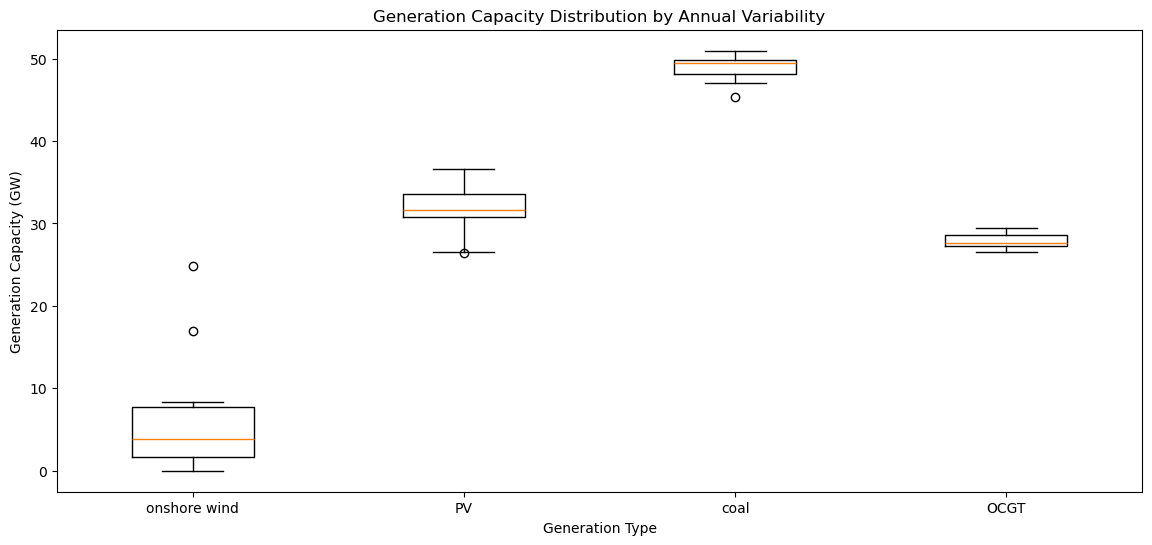

In [53]:
years_array = np.array([2001, 2002, 2003, 2005, 2006, 2007, 2009, 2010, 2011, 2013, 2014, 2015, 2017])  # match your data
results = pd.DataFrame(
    np.array([np.array(onwind_cap)/10**3, np.array(pv_cap)/10**3,
             np.array(coal_cap)/10**3, np.array(ocgt_cap)/10**3]).T,
    columns=["onshorewind", "PV", "coal", "OCGT"],
    index=years_array,
)
 
# Make a boxplot
plt.figure(figsize=(14, 6))
plt.boxplot(
    [results["onshorewind"], results["PV"], results["coal"], results["OCGT"]],
    labels=["onshore wind", "PV", "coal", "OCGT"]
)
plt.title("Generation Capacity Distribution by Annual Variability")
plt.ylabel("Generation Capacity (GW)")
plt.xlabel("Generation Type")
 

# Section D

In [54]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

# add electricity bus
n.add("Bus",
            f"E_bus{country}")

# add load to the bus
n.add("Load",
            "load",
            bus=f"E_bus{country}",
            p_set=df_elec[country].values)

# add the different carriers, only gas emits CO2
n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "coal", co2_emissions=0.9) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "solarPV")
n.add("Carrier", "rooftopPV")

''' Add renewable generators '''
# Add onshore wind
CF_wind_onshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 30 # years
discount_rate = 0.07 # 7%
capex = 910000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_onshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "onshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_onshore.values)
'''
# Add offshore wind
CF_wind_offshore = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 2506000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_offshorewind = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "offshorewind",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_offshore.values)
'''
# Add large scale solar
CF_solar = df_pv[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 425000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_pv = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "PV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="solarPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_pv,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)
'''
# Add rooftop solar
CF_rooftop = df_rooftop[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 725000 # in €/MW
fopex = 0.02 # 2% of capex
capital_cost_rooftop = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
n.add("Generator",
            "rooftopPV",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="rooftopPV",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_rooftop,
            marginal_cost = 0,
            p_max_pu = CF_rooftop.values)
'''

''' Add non-renewables generators '''
# add OCGT (Open Cycle Gas Turbine) generator
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 560000 # in €/MW
fopex = 0.033 # 3.3% of capex
capital_cost_OCGT = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 21.6 # in €/MWh_th
efficiency = 0.39 # MWh_elec/MWh_th
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el
n.add("Generator",
            "OCGT",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            efficiency = efficiency,
            marginal_cost = marginal_cost_OCGT)

# add coal generator (without CCS) # https://atb-archive.nrel.gov/electricity/2018/index.html?t=cc
lifetime = 25 # years
discount_rate = 0.07 # 7%
capex = 3294000 # in €/MW
fopex = 0.03 # 3% of capex
capital_cost_coal = annuity(lifetime,discount_rate)*capex*(1+fopex) # in €/MW
fuel_cost = 4 # in €/MWh_th 
efficiency = 0.36 # MWh_elec/MWh_th
marginal_cost_coal = fuel_cost/efficiency # in €/MWh_el
n.add("Generator",
            "coal",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            carrier="coal",
            #p_nom_max=1000,
            capital_cost = capital_cost_coal,
            efficiency = efficiency,
            marginal_cost = marginal_cost_coal)


# Add storage unit
n.add("StorageUnit",
            "battery",
            bus=f"E_bus{country}",
            p_nom_extendable=True,
            capital_cost=12894+24678,
            efficiency_dispatch=0.96,
            efficiency_store=0.96,
            max_hours=2,
            cyclic_state_of_charge=True,)

# Co2 Cap
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=152000000, #152MtCO2
)

Index(['CO2Limit'], dtype='object')

In [55]:
n.optimize(solver_name='gurobi')

Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 48.56it/s]
INFO:linopy.io: Writing time: 0.89s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-62oxg5kp.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-62oxg5kp.lp


Reading time = 0.22 seconds


INFO:gurobipy:Reading time = 0.22 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0xd989d505


INFO:gurobipy:Model fingerprint: 0xd989d505


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.93163666e+12  0.00000000e+00  3.22e+10 0.00e+00  3.36e+09     0s


INFO:gurobipy:   0   2.93163666e+12  0.00000000e+00  3.22e+10 0.00e+00  3.36e+09     0s


   1   3.55008883e+12 -5.98847544e+11  4.83e+09 1.76e+02  7.21e+08     0s


INFO:gurobipy:   1   3.55008883e+12 -5.98847544e+11  4.83e+09 1.76e+02  7.21e+08     0s


   2   2.62084477e+12 -4.70954431e+11  3.41e+08 1.93e+01  9.46e+07     0s


INFO:gurobipy:   2   2.62084477e+12 -4.70954431e+11  3.41e+08 1.93e+01  9.46e+07     0s


   3   9.92693989e+11 -1.48475459e+11  1.68e+07 1.82e+00  1.49e+07     1s


INFO:gurobipy:   3   9.92693989e+11 -1.48475459e+11  1.68e+07 1.82e+00  1.49e+07     1s


   4   3.73472251e+11 -2.36686976e+10  3.21e+06 2.52e-01  4.02e+06     1s


INFO:gurobipy:   4   3.73472251e+11 -2.36686976e+10  3.21e+06 2.52e-01  4.02e+06     1s


   5   1.18310593e+11  6.16757154e+09  6.99e+05 1.60e-10  1.00e+06     1s


INFO:gurobipy:   5   1.18310593e+11  6.16757154e+09  6.99e+05 1.60e-10  1.00e+06     1s


   6   7.11291551e+10  1.40373981e+10  3.59e+05 1.52e-09  5.04e+05     1s


INFO:gurobipy:   6   7.11291551e+10  1.40373981e+10  3.59e+05 1.52e-09  5.04e+05     1s


   7   4.55314663e+10  1.90840938e+10  1.56e+05 9.12e-10  2.33e+05     1s


INFO:gurobipy:   7   4.55314663e+10  1.90840938e+10  1.56e+05 9.12e-10  2.33e+05     1s


   8   3.93644605e+10  2.08702573e+10  1.04e+05 4.17e-10  1.63e+05     1s


INFO:gurobipy:   8   3.93644605e+10  2.08702573e+10  1.04e+05 4.17e-10  1.63e+05     1s


   9   3.47927951e+10  2.26024269e+10  6.48e+04 4.47e-10  1.07e+05     1s


INFO:gurobipy:   9   3.47927951e+10  2.26024269e+10  6.48e+04 4.47e-10  1.07e+05     1s


  10   3.28017462e+10  2.38794019e+10  4.73e+04 2.03e-10  7.83e+04     1s


INFO:gurobipy:  10   3.28017462e+10  2.38794019e+10  4.73e+04 2.03e-10  7.83e+04     1s


  11   3.19360643e+10  2.46764161e+10  3.94e+04 3.52e-10  6.37e+04     1s


INFO:gurobipy:  11   3.19360643e+10  2.46764161e+10  3.94e+04 3.52e-10  6.37e+04     1s


  12   3.07355129e+10  2.57191757e+10  2.88e+04 1.41e-10  4.40e+04     1s


INFO:gurobipy:  12   3.07355129e+10  2.57191757e+10  2.88e+04 1.41e-10  4.40e+04     1s


  13   2.95704535e+10  2.60344997e+10  1.85e+04 3.83e-10  3.10e+04     1s


INFO:gurobipy:  13   2.95704535e+10  2.60344997e+10  1.85e+04 3.83e-10  3.10e+04     1s


  14   2.92798682e+10  2.62330755e+10  1.58e+04 2.78e-10  2.67e+04     1s


INFO:gurobipy:  14   2.92798682e+10  2.62330755e+10  1.58e+04 2.78e-10  2.67e+04     1s


  15   2.91234033e+10  2.63598351e+10  1.44e+04 4.33e-10  2.42e+04     1s


INFO:gurobipy:  15   2.91234033e+10  2.63598351e+10  1.44e+04 4.33e-10  2.42e+04     1s


  16   2.87061135e+10  2.67829549e+10  1.04e+04 2.53e-10  1.69e+04     1s


INFO:gurobipy:  16   2.87061135e+10  2.67829549e+10  1.04e+04 2.53e-10  1.69e+04     1s


  17   2.86953504e+10  2.68686028e+10  9.98e+03 2.76e-10  1.60e+04     1s


INFO:gurobipy:  17   2.86953504e+10  2.68686028e+10  9.98e+03 2.76e-10  1.60e+04     1s


  18   2.84414477e+10  2.71229042e+10  7.26e+03 2.13e-10  1.16e+04     1s


INFO:gurobipy:  18   2.84414477e+10  2.71229042e+10  7.26e+03 2.13e-10  1.16e+04     1s


  19   2.83264655e+10  2.73970151e+10  4.77e+03 1.41e-10  8.15e+03     1s


INFO:gurobipy:  19   2.83264655e+10  2.73970151e+10  4.77e+03 1.41e-10  8.15e+03     1s


  20   2.82360856e+10  2.74984518e+10  3.89e+03 4.34e-10  6.47e+03     2s


INFO:gurobipy:  20   2.82360856e+10  2.74984518e+10  3.89e+03 4.34e-10  6.47e+03     2s


  21   2.82174045e+10  2.75279317e+10  3.73e+03 1.24e-09  6.04e+03     2s


INFO:gurobipy:  21   2.82174045e+10  2.75279317e+10  3.73e+03 1.24e-09  6.04e+03     2s


  22   2.80923405e+10  2.75419976e+10  2.27e+03 3.61e-10  4.82e+03     2s


INFO:gurobipy:  22   2.80923405e+10  2.75419976e+10  2.27e+03 3.61e-10  4.82e+03     2s


  23   2.80676403e+10  2.75839957e+10  1.71e+03 6.95e-10  4.24e+03     2s


INFO:gurobipy:  23   2.80676403e+10  2.75839957e+10  1.71e+03 6.95e-10  4.24e+03     2s


  24   2.80467175e+10  2.75979502e+10  1.58e+03 7.82e-10  3.93e+03     2s


INFO:gurobipy:  24   2.80467175e+10  2.75979502e+10  1.58e+03 7.82e-10  3.93e+03     2s


  25   2.80224713e+10  2.76297785e+10  1.43e+03 7.25e-10  3.44e+03     2s


INFO:gurobipy:  25   2.80224713e+10  2.76297785e+10  1.43e+03 7.25e-10  3.44e+03     2s


  26   2.79901149e+10  2.76397361e+10  1.24e+03 2.47e-10  3.07e+03     2s


INFO:gurobipy:  26   2.79901149e+10  2.76397361e+10  1.24e+03 2.47e-10  3.07e+03     2s


  27   2.79672752e+10  2.76469366e+10  1.09e+03 2.72e-10  2.81e+03     2s


INFO:gurobipy:  27   2.79672752e+10  2.76469366e+10  1.09e+03 2.72e-10  2.81e+03     2s


  28   2.79505461e+10  2.76597755e+10  9.96e+02 4.23e-10  2.55e+03     2s


INFO:gurobipy:  28   2.79505461e+10  2.76597755e+10  9.96e+02 4.23e-10  2.55e+03     2s


  29   2.79167224e+10  2.76705821e+10  8.04e+02 5.36e-10  2.16e+03     2s


INFO:gurobipy:  29   2.79167224e+10  2.76705821e+10  8.04e+02 5.36e-10  2.16e+03     2s


  30   2.79105054e+10  2.76966854e+10  7.43e+02 9.86e-10  1.87e+03     2s


INFO:gurobipy:  30   2.79105054e+10  2.76966854e+10  7.43e+02 9.86e-10  1.87e+03     2s


  31   2.79000118e+10  2.76961453e+10  7.08e+02 1.04e-09  1.79e+03     2s


INFO:gurobipy:  31   2.79000118e+10  2.76961453e+10  7.08e+02 1.04e-09  1.79e+03     2s


  32   2.78785329e+10  2.77509727e+10  4.18e+02 7.60e-10  1.12e+03     2s


INFO:gurobipy:  32   2.78785329e+10  2.77509727e+10  4.18e+02 7.60e-10  1.12e+03     2s


  33   2.78751103e+10  2.77651170e+10  3.87e+02 2.76e-10  9.64e+02     2s


INFO:gurobipy:  33   2.78751103e+10  2.77651170e+10  3.87e+02 2.76e-10  9.64e+02     2s


  34   2.78718190e+10  2.77712201e+10  3.62e+02 2.12e-10  8.82e+02     2s


INFO:gurobipy:  34   2.78718190e+10  2.77712201e+10  3.62e+02 2.12e-10  8.82e+02     2s


  35   2.78683735e+10  2.77758787e+10  3.34e+02 5.93e-10  8.11e+02     2s


INFO:gurobipy:  35   2.78683735e+10  2.77758787e+10  3.34e+02 5.93e-10  8.11e+02     2s


  36   2.78647505e+10  2.77770027e+10  3.08e+02 7.13e-10  7.69e+02     2s


INFO:gurobipy:  36   2.78647505e+10  2.77770027e+10  3.08e+02 7.13e-10  7.69e+02     2s


  37   2.78614630e+10  2.77822275e+10  2.83e+02 8.64e-10  6.94e+02     2s


INFO:gurobipy:  37   2.78614630e+10  2.77822275e+10  2.83e+02 8.64e-10  6.94e+02     2s


  38   2.78600152e+10  2.77862791e+10  2.51e+02 8.29e-10  6.46e+02     3s


INFO:gurobipy:  38   2.78600152e+10  2.77862791e+10  2.51e+02 8.29e-10  6.46e+02     3s


  39   2.78556902e+10  2.77861015e+10  2.19e+02 6.49e-10  6.10e+02     3s


INFO:gurobipy:  39   2.78556902e+10  2.77861015e+10  2.19e+02 6.49e-10  6.10e+02     3s


  40   2.78550035e+10  2.77908734e+10  2.08e+02 5.92e-10  5.62e+02     3s


INFO:gurobipy:  40   2.78550035e+10  2.77908734e+10  2.08e+02 5.92e-10  5.62e+02     3s


  41   2.78532169e+10  2.78000234e+10  1.87e+02 8.12e-10  4.66e+02     3s


INFO:gurobipy:  41   2.78532169e+10  2.78000234e+10  1.87e+02 8.12e-10  4.66e+02     3s


  42   2.78462606e+10  2.78070788e+10  9.29e+01 6.83e-10  3.43e+02     3s


INFO:gurobipy:  42   2.78462606e+10  2.78070788e+10  9.29e+01 6.83e-10  3.43e+02     3s


  43   2.78450615e+10  2.78096285e+10  7.98e+01 5.59e-10  3.11e+02     3s


INFO:gurobipy:  43   2.78450615e+10  2.78096285e+10  7.98e+01 5.59e-10  3.11e+02     3s


  44   2.78431760e+10  2.78135786e+10  5.56e+01 4.56e-10  2.59e+02     3s


INFO:gurobipy:  44   2.78431760e+10  2.78135786e+10  5.56e+01 4.56e-10  2.59e+02     3s


  45   2.78416474e+10  2.78214781e+10  3.69e+01 4.26e-10  1.77e+02     3s


INFO:gurobipy:  45   2.78416474e+10  2.78214781e+10  3.69e+01 4.26e-10  1.77e+02     3s


  46   2.78413639e+10  2.78272268e+10  3.29e+01 3.47e-10  1.24e+02     3s


INFO:gurobipy:  46   2.78413639e+10  2.78272268e+10  3.29e+01 3.47e-10  1.24e+02     3s


  47   2.78396790e+10  2.78288588e+10  1.39e+01 4.87e-10  9.48e+01     3s


INFO:gurobipy:  47   2.78396790e+10  2.78288588e+10  1.39e+01 4.87e-10  9.48e+01     3s


  48   2.78393590e+10  2.78321153e+10  1.02e+01 2.77e-10  6.35e+01     3s


INFO:gurobipy:  48   2.78393590e+10  2.78321153e+10  1.02e+01 2.77e-10  6.35e+01     3s


  49   2.78392652e+10  2.78331017e+10  9.13e+00 5.52e-10  5.40e+01     3s


INFO:gurobipy:  49   2.78392652e+10  2.78331017e+10  9.13e+00 5.52e-10  5.40e+01     3s


  50   2.78390243e+10  2.78373349e+10  6.41e+00 4.40e-10  1.48e+01     3s


INFO:gurobipy:  50   2.78390243e+10  2.78373349e+10  6.41e+00 4.40e-10  1.48e+01     3s


  51   2.78384416e+10  2.78383020e+10  5.24e-01 1.10e-09  1.22e+00     3s


INFO:gurobipy:  51   2.78384416e+10  2.78383020e+10  5.24e-01 1.10e-09  1.22e+00     3s


  52   2.78383680e+10  2.78383635e+10  7.98e-03 9.28e-10  3.95e-02     3s


INFO:gurobipy:  52   2.78383680e+10  2.78383635e+10  7.98e-03 9.28e-10  3.95e-02     3s


  53   2.78383661e+10  2.78383661e+10  1.54e-05 1.74e-09  3.76e-06     3s


INFO:gurobipy:  53   2.78383661e+10  2.78383661e+10  1.54e-05 1.74e-09  3.76e-06     3s


  54   2.78383661e+10  2.78383661e+10  7.75e-06 1.93e-09  2.09e-11     3s


INFO:gurobipy:  54   2.78383661e+10  2.78383661e+10  7.75e-06 1.93e-09  2.09e-11     3s


INFO:gurobipy:


Barrier solved model in 54 iterations and 3.46 seconds (1.87 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 3.46 seconds (1.87 work units)


Optimal objective 2.78383661e+10


INFO:gurobipy:Optimal objective 2.78383661e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     342 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:     342 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    9933 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:    9933 PPushes remaining with PInf 0.0000000e+00                 4s


    6919 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    6919 PPushes remaining with PInf 0.0000000e+00                 5s


       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0940443e-08      9s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.0940443e-08      9s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   10279    2.7838366e+10   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:   10279    2.7838366e+10   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:


Solved in 10279 iterations and 10.07 seconds (20.14 work units)


INFO:gurobipy:Solved in 10279 iterations and 10.07 seconds (20.14 work units)


Optimal objective  2.783836609e+10


INFO:gurobipy:Optimal objective  2.783836609e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 2.78e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='snapshot', ylabel='dispatch'>

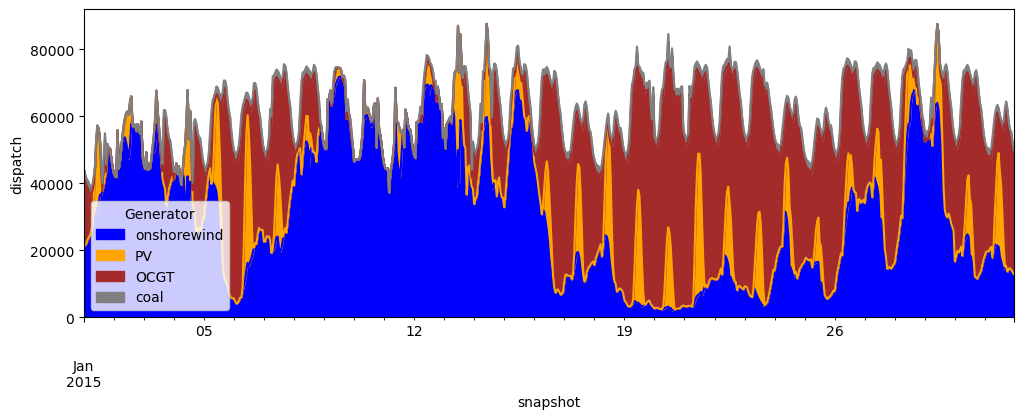

In [56]:
n.generators_t.p.loc["2015-01"].plot.area(figsize=(12, 4), ylabel="dispatch", color=['blue', 'orange', 'brown', 'grey'])


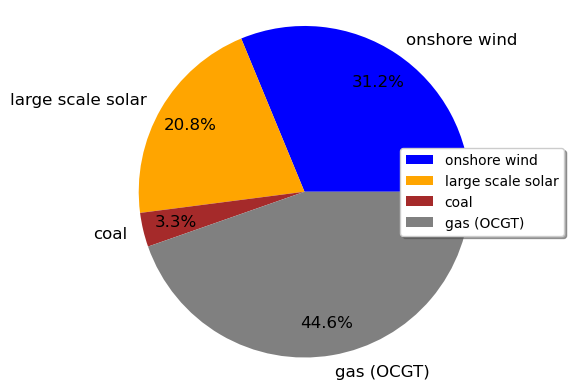

In [57]:
labels = ['onshore wind',
            #'offshore wind',
            'large scale solar',
            'coal',
            'gas (OCGT)']
      
sizes = [n.generators_t.p['onshorewind'].sum(),
         #n.generators_t.p['offshorewind'].sum(),
         n.generators_t.p['PV'].sum(),
         n.generators_t.p['coal'].sum(),
         n.generators_t.p['OCGT'].sum()]
 
colors=['blue', 'orange', 'brown', 'grey']
 
plt.figure(figsize=(6, 4))
plt.pie(
    sizes,
    colors=colors,
    labels=labels,
    autopct='%1.1f%%',  # Show percentages with 1 decimal place
    pctdistance=0.8,
    textprops={'fontsize': 12},
    startangle=0,      # Optional: rotate start for aesthetic
    wedgeprops={'linewidth': 0}
)
plt.axis('equal')  # Keeps pie chart circular
plt.legend(fancybox=True, shadow=True, loc='right')
#plt.title('Generation Mix', y=1.07, fontsize=18)
plt.tight_layout()
plt.show()

__Storage Installed__

In [58]:
# Storage installed capacity
print(f"Installed capacity of storage: {n.storage_units.p_nom_opt.loc['battery'] / 1e3} GW")

Installed capacity of storage: 13.06210970872763 GW


<Axes: xlabel='snapshot', ylabel='battery'>

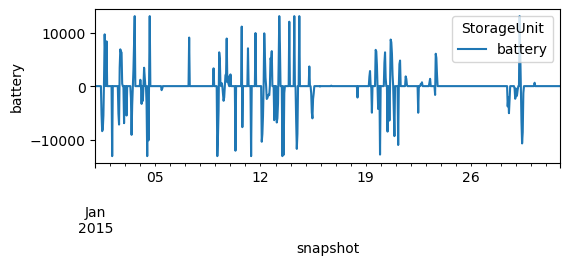

In [59]:
n.storage_units_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="battery")

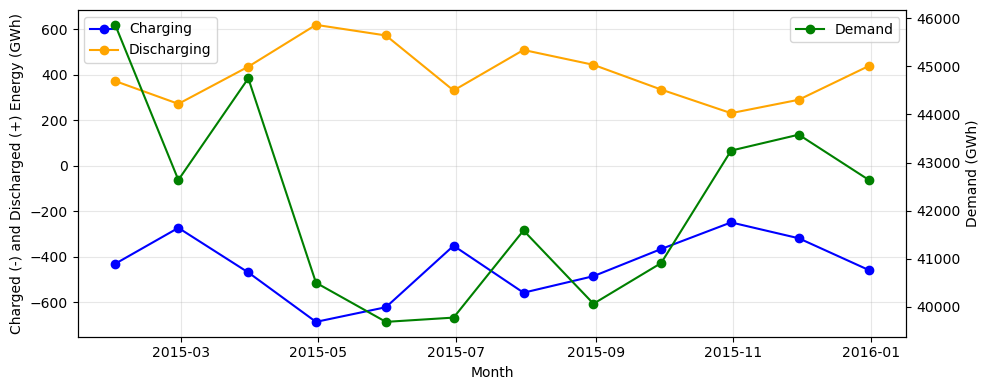

In [60]:
# Extract battery power series for 2015
battery_power = n.storage_units_t.p.loc["2015"]
 
# Charging (negative values in PyPSA convention)
charging_power = battery_power.where(battery_power < 0, 0)
 
# Discharging (positive values)
discharging_power = battery_power.where(battery_power > 0, 0)
 
# Demand
demand = n.loads_t.p.loc["2015", "load"].resample("ME").sum()/1e3  # Convert to GWh
 
# Resample to monthly sums
monthly_charging = charging_power.resample("ME").sum()/1e3  # Convert to GWh
monthly_discharging = discharging_power.resample("ME").sum()/1e3  # Convert to GWh
 
# Plot
fig, ax1 = plt.subplots(figsize=(10, 4))
 
# Plot Charging and Discharging on primary y-axis
ax1.plot(monthly_charging.index, monthly_charging, label="Charging", color="blue", marker='o')
ax1.plot(monthly_discharging.index, monthly_discharging, label="Discharging", color="orange", marker='o')
 
ax1.set_ylabel("Charged (-) and Discharged (+) Energy (GWh)")
ax1.set_xlabel("Month")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)
 
# Create secondary y-axis for demand
ax2 = ax1.twinx()
ax2.plot(demand.index, demand, label="Demand", color="green", marker='o')
ax2.set_ylabel("Demand (GWh)")
ax2.legend(loc="upper right")
 
plt.tight_layout()
plt.show()

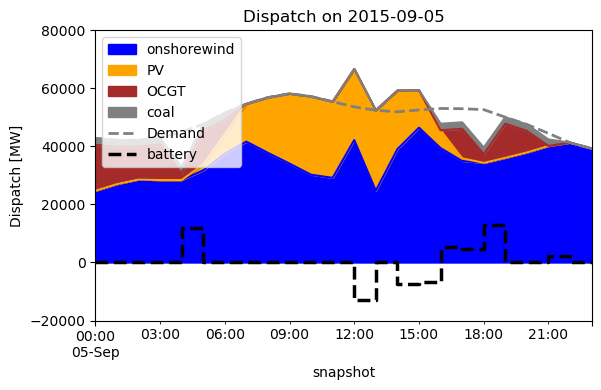

In [61]:
#Dispatch plot used in task D without storage (in D with storage)
day = "2015-09-05"
 
# Get all generator names
generators = n.generators.index
 
# Filter out "rooftopPV" and "offshorewind"
filtered_generators = generators[~generators.str.contains("rooftopPV|offshorewind")]
 
# Plot only the filtered generators
ax = n.generators_t.p.loc[day, filtered_generators].plot.area(
    figsize=(6, 4), ylabel="Dispatch [MW]", legend=True, color=['blue', 'orange', 'brown', 'grey']
)
 
# 2. Overlay storage unit dispatch and demand
n.loads_t.p['load'].loc[day].plot(ax=ax, linewidth=2, linestyle="--", color="grey", label="Demand")
n.storage_units_t.p.loc[day].plot(ax=ax, drawstyle="steps-post", linewidth=2.5, linestyle="--", color="black", label="Battery")
 
# 3. Customize
plt.title(f"Dispatch on {day}")
plt.tight_layout()
plt.ylim(-20000, 80000)
plt.legend(loc="upper left")
plt.show()

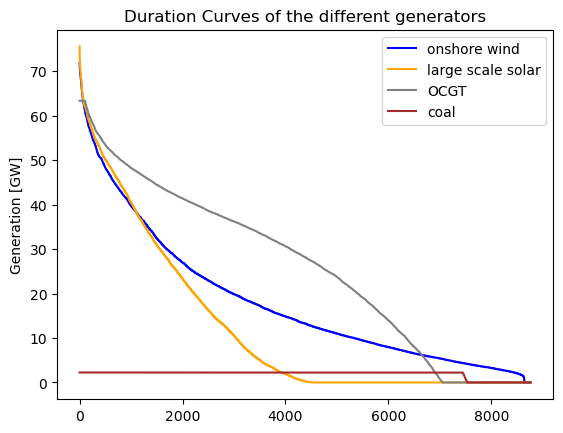

In [62]:
# Duration Curves
cf_onshore = n.generators_t.p['onshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
#cf_offshore = n.generators_t.p['offshorewind'].sort_values(ascending=False,ignore_index=True)/1e3
cf_PV = n.generators_t.p['PV'].sort_values(ascending=False,ignore_index=True)/1e3
#cf_rooftopPV = n.generators_t.p['rooftopPV'].sort_values(ascending=False,ignore_index=True)/1e3
cf_OCGT = n.generators_t.p['OCGT'].sort_values(ascending=False,ignore_index=True)/1e3
cf_coal = n.generators_t.p['coal'].sort_values(ascending=False,ignore_index=True)/1e3


cf_onshore.plot(kind='line', ylabel='CF onshore', color='blue')
#cf_offshore.plot(kind='line', ylabel='CF offshore', color='darkblue')
cf_PV.plot(kind='line', ylabel='CF PV', color='orange')
#cf_rooftopPV.plot(kind='line', ylabel='CF rooftopPV', color='yellow')
cf_OCGT.plot(kind='line', ylabel='CF OCGT', color='grey')
cf_coal.plot(kind='line', ylabel='CF coal', color='brown')
plt.title('Duration Curves of the different generators')
plt.legend(['onshore wind', 'large scale solar', 'OCGT', 'coal'])
plt.ylabel('Generation [GW]')
plt.show()

In [63]:
n.generators.p_nom_opt.div(1e3) # in GW

Generator
onshorewind     92.529390
PV             102.542553
OCGT            63.352489
coal             2.246037
Name: p_nom_opt, dtype: float64

In [64]:
print(f"Total cost: {round(n.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(n.objective/n.loads_t.p.sum().iloc[0]))} EUR/MWh")


Total cost: 27838.37 mio€
Cost per MWh of electricity produced 55 EUR/MWh


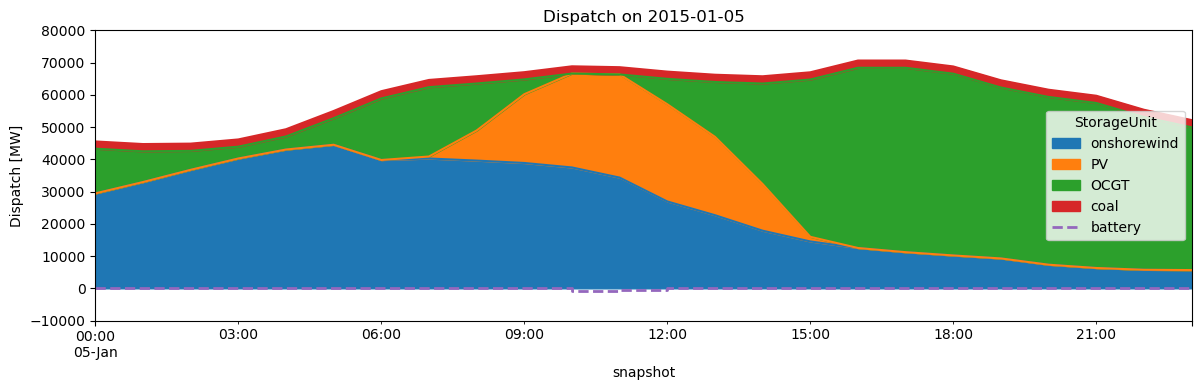

In [65]:
day = "2015-01-05"
ax = n.generators_t.p.loc[day].plot.area(figsize=(12, 4), ylabel="Dispatch [MW]", legend=True)

# 2. Overlay storage unit dispatch as step lines
n.storage_units_t.p.loc[day].plot(ax=ax, drawstyle="steps-post", linewidth=2, linestyle="--", legend=True)

# 3. Customize
plt.title(f"Dispatch on {day}")
plt.tight_layout()
plt.ylim(-10000, 80000)
plt.show()

# Section E

In [66]:
# Our desired target for CO2 emissions limit is 50MtCO2
co2 = 50 # in tCO2
n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6

n.optimize(solver_name='gurobi')


Index(['E_busDEU'], dtype='object', name='Bus')


Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 43.36it/s]
INFO:linopy.io: Writing time: 1.0s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-ueul9gq3.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-ueul9gq3.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0x8c2de34b


INFO:gurobipy:Model fingerprint: 0x8c2de34b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+07]


INFO:gurobipy:  RHS range        [4e+04, 5e+07]


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.09744533e+12  0.00000000e+00  2.30e+10 0.00e+00  2.28e+09     0s


INFO:gurobipy:   0   2.09744533e+12  0.00000000e+00  2.30e+10 0.00e+00  2.28e+09     0s


   1   2.52500939e+12 -5.06786378e+11  3.41e+09 1.67e+02  4.87e+08     0s


INFO:gurobipy:   1   2.52500939e+12 -5.06786378e+11  3.41e+09 1.67e+02  4.87e+08     0s


   2   1.84868799e+12 -3.42897572e+11  3.21e+08 1.75e+01  6.46e+07     0s


INFO:gurobipy:   2   1.84868799e+12 -3.42897572e+11  3.21e+08 1.75e+01  6.46e+07     0s


   3   7.60242051e+11 -1.03741802e+11  2.31e+07 2.46e+00  1.25e+07     1s


INFO:gurobipy:   3   7.60242051e+11 -1.03741802e+11  2.31e+07 2.46e+00  1.25e+07     1s


   4   3.42851120e+11 -2.48688417e+10  5.89e+06 5.08e-01  3.89e+06     1s


INFO:gurobipy:   4   3.42851120e+11 -2.48688417e+10  5.89e+06 5.08e-01  3.89e+06     1s


   5   1.42739029e+11  1.34694064e+09  1.76e+06 5.47e-02  1.31e+06     1s


INFO:gurobipy:   5   1.42739029e+11  1.34694064e+09  1.76e+06 5.47e-02  1.31e+06     1s


   6   7.18979433e+10  9.83933191e+09  6.49e+05 9.38e-10  5.60e+05     1s


INFO:gurobipy:   6   7.18979433e+10  9.83933191e+09  6.49e+05 9.38e-10  5.60e+05     1s


   7   5.36547565e+10  1.43634806e+10  3.79e+05 4.56e-03  3.51e+05     1s


INFO:gurobipy:   7   5.36547565e+10  1.43634806e+10  3.79e+05 4.56e-03  3.51e+05     1s


   8   5.12446887e+10  1.57009651e+10  3.43e+05 1.68e-02  3.17e+05     1s


INFO:gurobipy:   8   5.12446887e+10  1.57009651e+10  3.43e+05 1.68e-02  3.17e+05     1s


   9   4.60120266e+10  1.97683653e+10  2.52e+05 1.50e-02  2.33e+05     1s


INFO:gurobipy:   9   4.60120266e+10  1.97683653e+10  2.52e+05 1.50e-02  2.33e+05     1s


  10   4.05049527e+10  2.26410926e+10  1.66e+05 7.17e-03  1.58e+05     1s


INFO:gurobipy:  10   4.05049527e+10  2.26410926e+10  1.66e+05 7.17e-03  1.58e+05     1s


  11   3.79458895e+10  2.64372839e+10  1.21e+05 2.71e-10  1.01e+05     1s


INFO:gurobipy:  11   3.79458895e+10  2.64372839e+10  1.21e+05 2.71e-10  1.01e+05     1s


  12   3.56683434e+10  2.74585879e+10  7.76e+04 0.00e+00  7.23e+04     1s


INFO:gurobipy:  12   3.56683434e+10  2.74585879e+10  7.76e+04 0.00e+00  7.23e+04     1s


  13   3.51550378e+10  2.95338543e+10  6.54e+04 3.47e-10  4.95e+04     1s


INFO:gurobipy:  13   3.51550378e+10  2.95338543e+10  6.54e+04 3.47e-10  4.95e+04     1s


  14   3.41757929e+10  3.05811640e+10  3.89e+04 4.77e-10  3.16e+04     1s


INFO:gurobipy:  14   3.41757929e+10  3.05811640e+10  3.89e+04 4.77e-10  3.16e+04     1s


  15   3.33467770e+10  3.14616700e+10  1.90e+04 1.28e-10  1.66e+04     1s


INFO:gurobipy:  15   3.33467770e+10  3.14616700e+10  1.90e+04 1.28e-10  1.66e+04     1s


  16   3.29549678e+10  3.20649366e+10  9.44e+03 6.55e-11  7.83e+03     1s


INFO:gurobipy:  16   3.29549678e+10  3.20649366e+10  9.44e+03 6.55e-11  7.83e+03     1s


  17   3.27622622e+10  3.22990462e+10  4.05e+03 5.88e-10  4.07e+03     1s


INFO:gurobipy:  17   3.27622622e+10  3.22990462e+10  4.05e+03 5.88e-10  4.07e+03     1s


  18   3.26753927e+10  3.25066149e+10  1.76e+03 1.33e-09  1.48e+03     1s


INFO:gurobipy:  18   3.26753927e+10  3.25066149e+10  1.76e+03 1.33e-09  1.48e+03     1s


  19   3.26236794e+10  3.25671475e+10  4.75e+02 8.98e-10  4.97e+02     2s


INFO:gurobipy:  19   3.26236794e+10  3.25671475e+10  4.75e+02 8.98e-10  4.97e+02     2s


  20   3.26062798e+10  3.26016159e+10  5.07e+01 7.52e-10  4.10e+01     2s


INFO:gurobipy:  20   3.26062798e+10  3.26016159e+10  5.07e+01 7.52e-10  4.10e+01     2s


  21   3.26036612e+10  3.26033496e+10  2.94e+00 0.00e+00  2.74e+00     2s


INFO:gurobipy:  21   3.26036612e+10  3.26033496e+10  2.94e+00 0.00e+00  2.74e+00     2s


  22   3.26035425e+10  3.26033784e+10  1.01e+00 2.97e-10  1.44e+00     2s


INFO:gurobipy:  22   3.26035425e+10  3.26033784e+10  1.01e+00 2.97e-10  1.44e+00     2s


  23   3.26034932e+10  3.26034511e+10  2.33e-01 0.00e+00  3.69e-01     2s


INFO:gurobipy:  23   3.26034932e+10  3.26034511e+10  2.33e-01 0.00e+00  3.69e-01     2s


  24   3.26034773e+10  3.26034759e+10  3.40e-03 1.06e-08  1.22e-02     2s


INFO:gurobipy:  24   3.26034773e+10  3.26034759e+10  3.40e-03 1.06e-08  1.22e-02     2s


  25   3.26034766e+10  3.26034766e+10  1.53e-04 1.50e-08  1.68e-05     2s


INFO:gurobipy:  25   3.26034766e+10  3.26034766e+10  1.53e-04 1.50e-08  1.68e-05     2s


  26   3.26034766e+10  3.26034766e+10  1.32e-06 2.91e-09  8.34e-08     2s


INFO:gurobipy:  26   3.26034766e+10  3.26034766e+10  1.32e-06 2.91e-09  8.34e-08     2s


  27   3.26034766e+10  3.26034766e+10  4.44e-06 3.14e-09  5.58e-11     2s


INFO:gurobipy:  27   3.26034766e+10  3.26034766e+10  4.44e-06 3.14e-09  5.58e-11     2s


INFO:gurobipy:


Barrier solved model in 27 iterations and 2.13 seconds (1.03 work units)


INFO:gurobipy:Barrier solved model in 27 iterations and 2.13 seconds (1.03 work units)


Optimal objective 3.26034766e+10


INFO:gurobipy:Optimal objective 3.26034766e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8824 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    8824 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


   13500 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:   13500 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0940867e-09      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0940867e-09      4s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13608    3.2603477e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   13608    3.2603477e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 13608 iterations and 4.50 seconds (4.99 work units)


INFO:gurobipy:Solved in 13608 iterations and 4.50 seconds (4.99 work units)


Optimal objective  3.260347660e+10


INFO:gurobipy:Optimal objective  3.260347660e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 3.26e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [67]:
print(f"Total cost: {round(n.objective/1000000,2)} mio€")
print(f"Cost per MWh of electricity produced {round(float(n.objective/n.loads_t.p.sum().iloc[0]))} EUR/MWh")
print(f"CO2 tax {-n.global_constraints.mu['CO2Limit']} EUR/tCO2")

Total cost: 32603.48 mio€
Cost per MWh of electricity produced 65 EUR/MWh
CO2 tax 135.2678650033746 EUR/tCO2


In [69]:
systemcost = []
onwind = []
#offwind = []
pv = []
#rooftop = []
coal = []
ocgt = []

onwind_cap = []
#offwind_cap = []
pv_cap = []
#rooftop_cap = []
coal_cap = []
ocgt_cap = []

co2_tax = []

co2_index = [1500, 1000, 500, 250, 225, 100, 50, 0]

for co2 in co2_index: # in MtCO2
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.optimize(solver_name="gurobi")
    systemcost.append(n.objective / 1e6)  # in million euros
    onwind.append(n.generators_t.p["onshorewind"].sum())
    #offwind.append(n.generators_t.p["offshorewind"].sum())
    pv.append(n.generators_t.p["PV"].sum())
    #rooftop.append(n.generators_t.p["rooftopPV"].sum())
    coal.append(n.generators_t.p["coal"].sum())
    ocgt.append(n.generators_t.p["OCGT"].sum())

    onwind_cap.append(n.generators.p_nom_opt.loc["onshorewind"])
    #offwind_cap.append(n.generators.p_nom_opt.loc["offshorewind"])
    pv_cap.append(n.generators.p_nom_opt.loc["PV"])
    #rooftop_cap.append(n.generators.p_nom_opt.loc["rooftopPV"])
    coal_cap.append(n.generators.p_nom_opt.loc["coal"])
    ocgt_cap.append(n.generators.p_nom_opt.loc["OCGT"])

    co2_tax.append(-n.global_constraints.mu['CO2Limit'])
    
    

Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 48.53it/s]
INFO:linopy.io: Writing time: 0.98s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-u2mtuhqk.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-u2mtuhqk.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0xdebf2629


INFO:gurobipy:Model fingerprint: 0xdebf2629


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+09]


INFO:gurobipy:  RHS range        [4e+04, 2e+09]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.36771322e+13  0.00000000e+00  1.51e+11 0.00e+00  1.43e+10     0s


INFO:gurobipy:   0   1.36771322e+13  0.00000000e+00  1.51e+11 0.00e+00  1.43e+10     0s


   1   1.63282173e+13 -1.18728723e+12  2.46e+10 1.58e+02  3.09e+09     0s


INFO:gurobipy:   1   1.63282173e+13 -1.18728723e+12  2.46e+10 1.58e+02  3.09e+09     0s


   2   1.22226965e+13 -1.48927876e+12  1.35e+09 1.96e+01  4.37e+08     0s


INFO:gurobipy:   2   1.22226965e+13 -1.48927876e+12  1.35e+09 1.96e+01  4.37e+08     0s


   3   4.17090059e+12 -3.75018984e+11  5.83e+07 4.45e-01  4.62e+07     1s


INFO:gurobipy:   3   4.17090059e+12 -3.75018984e+11  5.83e+07 4.45e-01  4.62e+07     1s


   4   1.66973563e+12 -3.40604310e+10  2.05e+07 2.30e-02  1.55e+07     1s


INFO:gurobipy:   4   1.66973563e+12 -3.40604310e+10  2.05e+07 2.30e-02  1.55e+07     1s


   5   1.91848369e+11 -4.00430930e+09  1.00e+06 3.97e-10  1.75e+06     1s


INFO:gurobipy:   5   1.91848369e+11 -4.00430930e+09  1.00e+06 3.97e-10  1.75e+06     1s


   6   1.46951113e+11 -7.67472048e+09  1.97e+02 7.24e-10  1.38e+06     1s


INFO:gurobipy:   6   1.46951113e+11 -7.67472048e+09  1.97e+02 7.24e-10  1.38e+06     1s


   7   9.90204475e+10 -3.40902363e+09  1.20e+02 7.35e-10  9.09e+05     1s


INFO:gurobipy:   7   9.90204475e+10 -3.40902363e+09  1.20e+02 7.35e-10  9.09e+05     1s


   8   6.19524435e+10 -6.25363772e+08  6.71e+01 4.73e-10  5.53e+05     1s


INFO:gurobipy:   8   6.19524435e+10 -6.25363772e+08  6.71e+01 4.73e-10  5.53e+05     1s


   9   5.11571903e+10  6.95088148e+09  5.14e+01 9.86e-11  3.90e+05     1s


INFO:gurobipy:   9   5.11571903e+10  6.95088148e+09  5.14e+01 9.86e-11  3.90e+05     1s


  10   3.59394195e+10  1.53992141e+10  2.12e+01 2.76e-10  1.80e+05     1s


INFO:gurobipy:  10   3.59394195e+10  1.53992141e+10  2.12e+01 2.76e-10  1.80e+05     1s


  11   3.00482233e+10  1.99829936e+10  1.11e+01 3.06e-10  8.83e+04     1s


INFO:gurobipy:  11   3.00482233e+10  1.99829936e+10  1.11e+01 3.06e-10  8.83e+04     1s


  12   2.74306462e+10  2.23443505e+10  6.25e+00 0.00e+00  4.46e+04     1s


INFO:gurobipy:  12   2.74306462e+10  2.23443505e+10  6.25e+00 0.00e+00  4.46e+04     1s


  13   2.65525145e+10  2.32079386e+10  4.27e+00 6.03e-10  2.93e+04     1s


INFO:gurobipy:  13   2.65525145e+10  2.32079386e+10  4.27e+00 6.03e-10  2.93e+04     1s


  14   2.62828473e+10  2.37232135e+10  3.72e+00 3.52e-10  2.24e+04     1s


INFO:gurobipy:  14   2.62828473e+10  2.37232135e+10  3.72e+00 3.52e-10  2.24e+04     1s


  15   2.57386429e+10  2.38017654e+10  2.66e+00 6.11e-10  1.70e+04     1s


INFO:gurobipy:  15   2.57386429e+10  2.38017654e+10  2.66e+00 6.11e-10  1.70e+04     1s


  16   2.53512765e+10  2.40129611e+10  1.89e+00 2.51e-10  1.17e+04     1s


INFO:gurobipy:  16   2.53512765e+10  2.40129611e+10  1.89e+00 2.51e-10  1.17e+04     1s


  17   2.51957200e+10  2.41412987e+10  1.50e+00 4.60e-10  9.24e+03     1s


INFO:gurobipy:  17   2.51957200e+10  2.41412987e+10  1.50e+00 4.60e-10  9.24e+03     1s


  18   2.49495817e+10  2.42037381e+10  9.86e-01 7.24e-11  6.54e+03     1s


INFO:gurobipy:  18   2.49495817e+10  2.42037381e+10  9.86e-01 7.24e-11  6.54e+03     1s


  19   2.48912595e+10  2.42794823e+10  8.58e-01 7.46e-10  5.36e+03     2s


INFO:gurobipy:  19   2.48912595e+10  2.42794823e+10  8.58e-01 7.46e-10  5.36e+03     2s


  20   2.47854831e+10  2.43361298e+10  5.59e-01 4.05e-10  3.94e+03     2s


INFO:gurobipy:  20   2.47854831e+10  2.43361298e+10  5.59e-01 4.05e-10  3.94e+03     2s


  21   2.47301374e+10  2.43947997e+10  4.08e-01 1.05e-10  2.94e+03     2s


INFO:gurobipy:  21   2.47301374e+10  2.43947997e+10  4.08e-01 1.05e-10  2.94e+03     2s


  22   2.46703626e+10  2.44162224e+10  2.49e-01 2.78e-11  2.23e+03     2s


INFO:gurobipy:  22   2.46703626e+10  2.44162224e+10  2.49e-01 2.78e-11  2.23e+03     2s


  23   2.46621598e+10  2.44867264e+10  1.98e-01 5.21e-10  1.54e+03     2s


INFO:gurobipy:  23   2.46621598e+10  2.44867264e+10  1.98e-01 5.21e-10  1.54e+03     2s


  24   2.46123475e+10  2.44996712e+10  7.96e-02 7.44e-10  9.87e+02     2s


INFO:gurobipy:  24   2.46123475e+10  2.44996712e+10  7.96e-02 7.44e-10  9.87e+02     2s


  25   2.45995621e+10  2.45290446e+10  4.73e-02 8.83e-11  6.18e+02     2s


INFO:gurobipy:  25   2.45995621e+10  2.45290446e+10  4.73e-02 8.83e-11  6.18e+02     2s


  26   2.45925106e+10  2.45536933e+10  2.95e-02 9.64e-10  3.40e+02     2s


INFO:gurobipy:  26   2.45925106e+10  2.45536933e+10  2.95e-02 9.64e-10  3.40e+02     2s


  27   2.45855937e+10  2.45608728e+10  1.50e-02 2.60e-10  2.17e+02     2s


INFO:gurobipy:  27   2.45855937e+10  2.45608728e+10  1.50e-02 2.60e-10  2.17e+02     2s


  28   2.45837459e+10  2.45677159e+10  1.13e-02 4.61e-10  1.40e+02     2s


INFO:gurobipy:  28   2.45837459e+10  2.45677159e+10  1.13e-02 4.61e-10  1.40e+02     2s


  29   2.45827223e+10  2.45711693e+10  9.17e-03 1.49e-09  1.01e+02     2s


INFO:gurobipy:  29   2.45827223e+10  2.45711693e+10  9.17e-03 1.49e-09  1.01e+02     2s


  30   2.45810142e+10  2.45736597e+10  5.49e-03 1.56e-09  6.44e+01     2s


INFO:gurobipy:  30   2.45810142e+10  2.45736597e+10  5.49e-03 1.56e-09  6.44e+01     2s


  31   2.45793506e+10  2.45770675e+10  1.80e-03 1.57e-10  2.00e+01     2s


INFO:gurobipy:  31   2.45793506e+10  2.45770675e+10  1.80e-03 1.57e-10  2.00e+01     2s


  32   2.45790600e+10  2.45773221e+10  1.23e-03 2.40e-10  1.52e+01     2s


INFO:gurobipy:  32   2.45790600e+10  2.45773221e+10  1.23e-03 2.40e-10  1.52e+01     2s


  33   2.45789190e+10  2.45775435e+10  9.49e-04 5.38e-10  1.21e+01     2s


INFO:gurobipy:  33   2.45789190e+10  2.45775435e+10  9.49e-04 5.38e-10  1.21e+01     2s


  34   2.45787686e+10  2.45776542e+10  6.49e-04 9.65e-10  9.76e+00     2s


INFO:gurobipy:  34   2.45787686e+10  2.45776542e+10  6.49e-04 9.65e-10  9.76e+00     2s


  35   2.45786866e+10  2.45779517e+10  4.86e-04 2.80e-10  6.44e+00     3s


INFO:gurobipy:  35   2.45786866e+10  2.45779517e+10  4.86e-04 2.80e-10  6.44e+00     3s


  36   2.45786452e+10  2.45781315e+10  4.00e-04 5.43e-10  4.50e+00     3s


INFO:gurobipy:  36   2.45786452e+10  2.45781315e+10  4.00e-04 5.43e-10  4.50e+00     3s


  37   2.45785624e+10  2.45781755e+10  2.29e-04 2.07e-10  3.39e+00     3s


INFO:gurobipy:  37   2.45785624e+10  2.45781755e+10  2.29e-04 2.07e-10  3.39e+00     3s


  38   2.45785357e+10  2.45783398e+10  1.77e-04 3.83e-09  1.72e+00     3s


INFO:gurobipy:  38   2.45785357e+10  2.45783398e+10  1.77e-04 3.83e-09  1.72e+00     3s


  39   2.45785167e+10  2.45783499e+10  2.31e-04 3.44e-09  1.46e+00     3s


INFO:gurobipy:  39   2.45785167e+10  2.45783499e+10  2.31e-04 3.44e-09  1.46e+00     3s


  40   2.45785093e+10  2.45783668e+10  2.97e-04 2.99e-09  1.25e+00     3s


INFO:gurobipy:  40   2.45785093e+10  2.45783668e+10  2.97e-04 2.99e-09  1.25e+00     3s


  41   2.45784847e+10  2.45784013e+10  1.09e-04 1.03e-09  7.31e-01     3s


INFO:gurobipy:  41   2.45784847e+10  2.45784013e+10  1.09e-04 1.03e-09  7.31e-01     3s


  42   2.45784826e+10  2.45784237e+10  9.70e-05 2.60e-09  5.16e-01     3s


INFO:gurobipy:  42   2.45784826e+10  2.45784237e+10  9.70e-05 2.60e-09  5.16e-01     3s


  43   2.45784807e+10  2.45784308e+10  1.62e-04 2.89e-09  4.37e-01     3s


INFO:gurobipy:  43   2.45784807e+10  2.45784308e+10  1.62e-04 2.89e-09  4.37e-01     3s


  44   2.45784792e+10  2.45784324e+10  1.74e-04 2.78e-09  4.10e-01     3s


INFO:gurobipy:  44   2.45784792e+10  2.45784324e+10  1.74e-04 2.78e-09  4.10e-01     3s


  45   2.45784713e+10  2.45784334e+10  1.70e-04 1.85e-08  3.32e-01     3s


INFO:gurobipy:  45   2.45784713e+10  2.45784334e+10  1.70e-04 1.85e-08  3.32e-01     3s


  46   2.45784639e+10  2.45784363e+10  1.55e-04 7.81e-08  2.42e-01     3s


INFO:gurobipy:  46   2.45784639e+10  2.45784363e+10  1.55e-04 7.81e-08  2.42e-01     3s


  47   2.45784602e+10  2.45784405e+10  2.85e-04 7.70e-08  1.73e-01     3s


INFO:gurobipy:  47   2.45784602e+10  2.45784405e+10  2.85e-04 7.70e-08  1.73e-01     3s


  48   2.45784452e+10  2.45784426e+10  1.21e-03 5.15e-08  2.31e-02     3s


INFO:gurobipy:  48   2.45784452e+10  2.45784426e+10  1.21e-03 5.15e-08  2.31e-02     3s


  49   2.45784434e+10  2.45784432e+10  4.35e-04 1.93e-08  1.75e-03     3s


INFO:gurobipy:  49   2.45784434e+10  2.45784432e+10  4.35e-04 1.93e-08  1.75e-03     3s


  50   2.45784433e+10  2.45784433e+10  3.37e-05 5.62e-09  2.30e-05     3s


INFO:gurobipy:  50   2.45784433e+10  2.45784433e+10  3.37e-05 5.62e-09  2.30e-05     3s


  51   2.45784433e+10  2.45784433e+10  3.37e-05 5.62e-09  2.30e-05     4s


INFO:gurobipy:  51   2.45784433e+10  2.45784433e+10  3.37e-05 5.62e-09  2.30e-05     4s


INFO:gurobipy:


Barrier solved model in 51 iterations and 3.52 seconds (1.77 work units)


INFO:gurobipy:Barrier solved model in 51 iterations and 3.52 seconds (1.77 work units)


Optimal objective 2.45784433e+10


INFO:gurobipy:Optimal objective 2.45784433e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     205 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:     205 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:


   36544 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:   36544 PPushes remaining with PInf 0.0000000e+00                 4s


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6320197e+01      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6320197e+01      4s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   36752    2.4578443e+10   0.000000e+00   2.632020e+01      4s


INFO:gurobipy:   36752    2.4578443e+10   0.000000e+00   2.632020e+01      4s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   36754    2.4578443e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   36754    2.4578443e+10   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 36754 iterations and 4.03 seconds (1.97 work units)


INFO:gurobipy:Solved in 36754 iterations and 4.03 seconds (1.97 work units)


Optimal objective  2.457844327e+10


INFO:gurobipy:Optimal objective  2.457844327e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 39.70it/s]
INFO:linopy.io: Writing time: 0.98s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-5mjudi7p.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-5mjudi7p.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0x864aaac5


INFO:gurobipy:Model fingerprint: 0x864aaac5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+09]


INFO:gurobipy:  RHS range        [4e+04, 1e+09]


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.26772085e+12  0.00000000e+00  9.14e+10 0.00e+00  9.07e+09     0s


INFO:gurobipy:   0   8.26772085e+12  0.00000000e+00  9.14e+10 0.00e+00  9.07e+09     0s


   1   9.93415789e+12 -9.99727262e+11  1.48e+10 1.67e+02  1.97e+09     0s


INFO:gurobipy:   1   9.93415789e+12 -9.99727262e+11  1.48e+10 1.67e+02  1.97e+09     0s


   2   7.56030426e+12 -1.15875371e+12  8.54e+08 2.07e+01  2.79e+08     0s


INFO:gurobipy:   2   7.56030426e+12 -1.15875371e+12  8.54e+08 2.07e+01  2.79e+08     0s


   3   2.60603103e+12 -2.91671055e+11  3.42e+07 6.55e-01  3.09e+07     1s


INFO:gurobipy:   3   2.60603103e+12 -2.91671055e+11  3.42e+07 6.55e-01  3.09e+07     1s


   4   6.90318066e+11 -1.79736104e+10  6.15e+06 2.53e-02  6.52e+06     1s


INFO:gurobipy:   4   6.90318066e+11 -1.79736104e+10  6.15e+06 2.53e-02  6.52e+06     1s


   5   1.17134048e+11 -3.55135743e+09  4.40e+05 1.15e-02  1.08e+06     1s


INFO:gurobipy:   5   1.17134048e+11 -3.55135743e+09  4.40e+05 1.15e-02  1.08e+06     1s


   6   7.07654785e+10 -8.49288737e+09  7.98e+01 6.46e-10  7.08e+05     1s


INFO:gurobipy:   6   7.07654785e+10 -8.49288737e+09  7.98e+01 6.46e-10  7.08e+05     1s


   7   5.49328924e+10  1.45002400e+09  5.53e+01 9.62e-10  4.75e+05     1s


INFO:gurobipy:   7   5.49328924e+10  1.45002400e+09  5.53e+01 9.62e-10  4.75e+05     1s


   8   3.99836787e+10  1.26488938e+10  2.96e+01 2.37e-10  2.41e+05     1s


INFO:gurobipy:   8   3.99836787e+10  1.26488938e+10  2.96e+01 2.37e-10  2.41e+05     1s


   9   3.16447943e+10  1.93673033e+10  1.38e+01 1.16e-10  1.08e+05     1s


INFO:gurobipy:   9   3.16447943e+10  1.93673033e+10  1.38e+01 1.16e-10  1.08e+05     1s


  10   2.87130591e+10  2.18068996e+10  8.45e+00 4.89e-11  6.06e+04     1s


INFO:gurobipy:  10   2.87130591e+10  2.18068996e+10  8.45e+00 4.89e-11  6.06e+04     1s


  11   2.74311726e+10  2.30493489e+10  6.07e+00 4.29e-10  3.84e+04     1s


INFO:gurobipy:  11   2.74311726e+10  2.30493489e+10  6.07e+00 4.29e-10  3.84e+04     1s


  12   2.65335528e+10  2.35906831e+10  4.19e+00 5.44e-11  2.58e+04     1s


INFO:gurobipy:  12   2.65335528e+10  2.35906831e+10  4.19e+00 5.44e-11  2.58e+04     1s


  13   2.61460604e+10  2.38090732e+10  3.38e+00 2.72e-10  2.05e+04     1s


INFO:gurobipy:  13   2.61460604e+10  2.38090732e+10  3.38e+00 2.72e-10  2.05e+04     1s


  14   2.58967141e+10  2.38474256e+10  2.87e+00 6.91e-10  1.80e+04     1s


INFO:gurobipy:  14   2.58967141e+10  2.38474256e+10  2.87e+00 6.91e-10  1.80e+04     1s


  15   2.53722566e+10  2.39634585e+10  1.78e+00 9.06e-11  1.24e+04     1s


INFO:gurobipy:  15   2.53722566e+10  2.39634585e+10  1.78e+00 9.06e-11  1.24e+04     1s


  16   2.51135151e+10  2.40726096e+10  1.20e+00 1.95e-10  9.13e+03     1s


INFO:gurobipy:  16   2.51135151e+10  2.40726096e+10  1.20e+00 1.95e-10  9.13e+03     1s


  17   2.49732628e+10  2.42096991e+10  9.33e-01 2.68e-10  6.69e+03     1s


INFO:gurobipy:  17   2.49732628e+10  2.42096991e+10  9.33e-01 2.68e-10  6.69e+03     1s


  18   2.48833148e+10  2.42928862e+10  7.32e-01 6.29e-10  5.18e+03     2s


INFO:gurobipy:  18   2.48833148e+10  2.42928862e+10  7.32e-01 6.29e-10  5.18e+03     2s


  19   2.48344014e+10  2.43332919e+10  5.71e-01 1.35e-10  4.39e+03     2s


INFO:gurobipy:  19   2.48344014e+10  2.43332919e+10  5.71e-01 1.35e-10  4.39e+03     2s


  20   2.47506474e+10  2.44130723e+10  3.69e-01 1.44e-10  2.96e+03     2s


INFO:gurobipy:  20   2.47506474e+10  2.44130723e+10  3.69e-01 1.44e-10  2.96e+03     2s


  21   2.47037309e+10  2.44660344e+10  2.52e-01 1.22e-10  2.08e+03     2s


INFO:gurobipy:  21   2.47037309e+10  2.44660344e+10  2.52e-01 1.22e-10  2.08e+03     2s


  22   2.46768513e+10  2.44955924e+10  1.89e-01 2.20e-10  1.59e+03     2s


INFO:gurobipy:  22   2.46768513e+10  2.44955924e+10  1.89e-01 2.20e-10  1.59e+03     2s


  23   2.46635463e+10  2.45257760e+10  1.51e-01 4.31e-10  1.21e+03     2s


INFO:gurobipy:  23   2.46635463e+10  2.45257760e+10  1.51e-01 4.31e-10  1.21e+03     2s


  24   2.46405406e+10  2.45787494e+10  8.47e-02 3.29e-10  5.42e+02     2s


INFO:gurobipy:  24   2.46405406e+10  2.45787494e+10  8.47e-02 3.29e-10  5.42e+02     2s


  25   2.46327381e+10  2.45876608e+10  6.53e-02 3.73e-10  3.95e+02     2s


INFO:gurobipy:  25   2.46327381e+10  2.45876608e+10  6.53e-02 3.73e-10  3.95e+02     2s


  26   2.46249726e+10  2.45907811e+10  4.67e-02 3.29e-10  3.00e+02     2s


INFO:gurobipy:  26   2.46249726e+10  2.45907811e+10  4.67e-02 3.29e-10  3.00e+02     2s


  27   2.46125758e+10  2.45936962e+10  1.48e-02 4.27e-10  1.65e+02     2s


INFO:gurobipy:  27   2.46125758e+10  2.45936962e+10  1.48e-02 4.27e-10  1.65e+02     2s


  28   2.46119434e+10  2.45969886e+10  1.33e-02 8.21e-09  1.31e+02     2s


INFO:gurobipy:  28   2.46119434e+10  2.45969886e+10  1.33e-02 8.21e-09  1.31e+02     2s


  29   2.46089662e+10  2.46000770e+10  5.83e-03 1.37e-08  7.79e+01     2s


INFO:gurobipy:  29   2.46089662e+10  2.46000770e+10  5.83e-03 1.37e-08  7.79e+01     2s


  30   2.46082632e+10  2.46021999e+10  4.19e-03 1.02e-08  5.31e+01     2s


INFO:gurobipy:  30   2.46082632e+10  2.46021999e+10  4.19e-03 1.02e-08  5.31e+01     2s


  31   2.46074776e+10  2.46027821e+10  2.35e-03 1.06e-08  4.11e+01     2s


INFO:gurobipy:  31   2.46074776e+10  2.46027821e+10  2.35e-03 1.06e-08  4.11e+01     2s


  32   2.46070867e+10  2.46044016e+10  1.39e-03 4.93e-09  2.35e+01     2s


INFO:gurobipy:  32   2.46070867e+10  2.46044016e+10  1.39e-03 4.93e-09  2.35e+01     2s


  33   2.46067754e+10  2.46045989e+10  7.25e-04 4.46e-09  1.91e+01     3s


INFO:gurobipy:  33   2.46067754e+10  2.46045989e+10  7.25e-04 4.46e-09  1.91e+01     3s


  34   2.46064925e+10  2.46052667e+10  6.98e-05 4.22e-09  1.07e+01     3s


INFO:gurobipy:  34   2.46064925e+10  2.46052667e+10  6.98e-05 4.22e-09  1.07e+01     3s


  35   2.46064764e+10  2.46054865e+10  4.18e-05 2.09e-09  8.67e+00     3s


INFO:gurobipy:  35   2.46064764e+10  2.46054865e+10  4.18e-05 2.09e-09  8.67e+00     3s


  36   2.46064707e+10  2.46055775e+10  3.20e-05 2.05e-09  7.83e+00     3s


INFO:gurobipy:  36   2.46064707e+10  2.46055775e+10  3.20e-05 2.05e-09  7.83e+00     3s


  37   2.46064651e+10  2.46058949e+10  1.05e-05 1.21e-09  5.00e+00     3s


INFO:gurobipy:  37   2.46064651e+10  2.46058949e+10  1.05e-05 1.21e-09  5.00e+00     3s


  38   2.46064527e+10  2.46064460e+10  7.70e-06 1.71e-09  5.85e-02     3s


INFO:gurobipy:  38   2.46064527e+10  2.46064460e+10  7.70e-06 1.71e-09  5.85e-02     3s


  39   2.46064523e+10  2.46064523e+10  3.00e-07 5.62e-09  1.96e-04     3s


INFO:gurobipy:  39   2.46064523e+10  2.46064523e+10  3.00e-07 5.62e-09  1.96e-04     3s


  40   2.46064523e+10  2.46064523e+10  7.81e-05 3.55e-09  3.20e-07     3s


INFO:gurobipy:  40   2.46064523e+10  2.46064523e+10  7.81e-05 3.55e-09  3.20e-07     3s


  41   2.46064523e+10  2.46064523e+10  1.62e-04 2.53e-09  1.70e-11     3s


INFO:gurobipy:  41   2.46064523e+10  2.46064523e+10  1.62e-04 2.53e-09  1.70e-11     3s


INFO:gurobipy:


Barrier solved model in 41 iterations and 3.09 seconds (1.46 work units)


INFO:gurobipy:Barrier solved model in 41 iterations and 3.09 seconds (1.46 work units)


Optimal objective 2.46064523e+10


INFO:gurobipy:Optimal objective 2.46064523e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     170 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:     170 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    7293 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:    7293 PPushes remaining with PInf 0.0000000e+00                 4s


    6772 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    6772 PPushes remaining with PInf 0.0000000e+00                 5s


    4310 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    4310 PPushes remaining with PInf 0.0000000e+00                10s


    1876 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:    1876 PPushes remaining with PInf 0.0000000e+00                15s


       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.6746028e-09     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.6746028e-09     19s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 3


INFO:gurobipy:Extra simplex iterations after uncrush: 3


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    7469    2.4606452e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:    7469    2.4606452e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 7469 iterations and 20.05 seconds (43.91 work units)


INFO:gurobipy:Solved in 7469 iterations and 20.05 seconds (43.91 work units)


Optimal objective  2.460645230e+10


INFO:gurobipy:Optimal objective  2.460645230e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 2.46e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 49.56it/s]
INFO:linopy.io: Writing time: 0.87s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-_1sz3n8l.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-_1sz3n8l.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0x1ffef77b


INFO:gurobipy:Model fingerprint: 0x1ffef77b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+08]


INFO:gurobipy:  RHS range        [4e+04, 5e+08]


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.80850527e+12  0.00000000e+00  5.31e+10 0.00e+00  5.61e+09     0s


INFO:gurobipy:   0   4.80850527e+12  0.00000000e+00  5.31e+10 0.00e+00  5.61e+09     0s


   1   5.82422052e+12 -8.01624919e+11  8.40e+09 1.80e+02  1.22e+09     0s


INFO:gurobipy:   1   5.82422052e+12 -8.01624919e+11  8.40e+09 1.80e+02  1.22e+09     0s


   2   4.49219324e+12 -8.17098096e+11  4.50e+08 2.19e+01  1.70e+08     0s


INFO:gurobipy:   2   4.49219324e+12 -8.17098096e+11  4.50e+08 2.19e+01  1.70e+08     0s


   3   1.57871532e+12 -1.66122156e+11  1.91e+07 8.46e-01  1.93e+07     1s


INFO:gurobipy:   3   1.57871532e+12 -1.66122156e+11  1.91e+07 8.46e-01  1.93e+07     1s


   4   3.12171400e+11 -3.21754187e+09  2.19e+06 1.87e-02  2.87e+06     1s


INFO:gurobipy:   4   3.12171400e+11 -3.21754187e+09  2.19e+06 1.87e-02  2.87e+06     1s


   5   9.15462191e+10  2.61010196e+09  4.29e+05 1.06e-09  7.95e+05     1s


INFO:gurobipy:   5   9.15462191e+10  2.61010196e+09  4.29e+05 1.06e-09  7.95e+05     1s


   6   6.38378431e+10  1.08318110e+10  7.01e+01 7.01e-10  4.68e+05     1s


INFO:gurobipy:   6   6.38378431e+10  1.08318110e+10  7.01e+01 7.01e-10  4.68e+05     1s


   7   4.03080067e+10  1.83267389e+10  2.87e+01 2.96e-10  1.93e+05     1s


INFO:gurobipy:   7   4.03080067e+10  1.83267389e+10  2.87e+01 2.96e-10  1.93e+05     1s


   8   3.37348923e+10  2.16001265e+10  1.55e+01 4.28e-10  1.07e+05     1s


INFO:gurobipy:   8   3.37348923e+10  2.16001265e+10  1.55e+01 4.28e-10  1.07e+05     1s


   9   3.06338648e+10  2.33414562e+10  9.34e+00 1.66e-10  6.40e+04     1s


INFO:gurobipy:   9   3.06338648e+10  2.33414562e+10  9.34e+00 1.66e-10  6.40e+04     1s


  10   2.91482980e+10  2.43013254e+10  6.33e+00 8.53e-10  4.25e+04     1s


INFO:gurobipy:  10   2.91482980e+10  2.43013254e+10  6.33e+00 8.53e-10  4.25e+04     1s


  11   2.87436467e+10  2.44663377e+10  5.56e+00 4.67e-10  3.75e+04     1s


INFO:gurobipy:  11   2.87436467e+10  2.44663377e+10  5.56e+00 4.67e-10  3.75e+04     1s


  12   2.75082312e+10  2.49742700e+10  3.12e+00 6.78e-11  2.22e+04     1s


INFO:gurobipy:  12   2.75082312e+10  2.49742700e+10  3.12e+00 6.78e-11  2.22e+04     1s


  13   2.70591529e+10  2.53512013e+10  2.29e+00 5.36e-10  1.50e+04     1s


INFO:gurobipy:  13   2.70591529e+10  2.53512013e+10  2.29e+00 5.36e-10  1.50e+04     1s


  14   2.69787892e+10  2.54588418e+10  2.14e+00 7.66e-10  1.33e+04     1s


INFO:gurobipy:  14   2.69787892e+10  2.54588418e+10  2.14e+00 7.66e-10  1.33e+04     1s


  15   2.68577095e+10  2.55582909e+10  1.86e+00 1.56e-11  1.14e+04     1s


INFO:gurobipy:  15   2.68577095e+10  2.55582909e+10  1.86e+00 1.56e-11  1.14e+04     1s


  16   2.66605863e+10  2.57606336e+10  1.33e+00 4.23e-10  7.89e+03     1s


INFO:gurobipy:  16   2.66605863e+10  2.57606336e+10  1.33e+00 4.23e-10  7.89e+03     1s


  17   2.65415281e+10  2.58532603e+10  1.01e+00 7.20e-10  6.03e+03     1s


INFO:gurobipy:  17   2.65415281e+10  2.58532603e+10  1.01e+00 7.20e-10  6.03e+03     1s


  18   2.64831905e+10  2.58900224e+10  8.83e-01 1.51e-09  5.20e+03     1s


INFO:gurobipy:  18   2.64831905e+10  2.58900224e+10  8.83e-01 1.51e-09  5.20e+03     1s


  19   2.63977540e+10  2.59109415e+10  7.02e-01 9.91e-10  4.27e+03     1s


INFO:gurobipy:  19   2.63977540e+10  2.59109415e+10  7.02e-01 9.91e-10  4.27e+03     1s


  20   2.63026151e+10  2.59160822e+10  4.25e-01 1.03e-09  3.39e+03     2s


INFO:gurobipy:  20   2.63026151e+10  2.59160822e+10  4.25e-01 1.03e-09  3.39e+03     2s


  21   2.62837745e+10  2.59824749e+10  3.86e-01 4.48e-11  2.64e+03     2s


INFO:gurobipy:  21   2.62837745e+10  2.59824749e+10  3.86e-01 4.48e-11  2.64e+03     2s


  22   2.62145780e+10  2.60406427e+10  1.91e-01 6.08e-10  1.52e+03     2s


INFO:gurobipy:  22   2.62145780e+10  2.60406427e+10  1.91e-01 6.08e-10  1.52e+03     2s


  23   2.62037987e+10  2.60570570e+10  1.71e-01 2.16e-09  1.29e+03     2s


INFO:gurobipy:  23   2.62037987e+10  2.60570570e+10  1.71e-01 2.16e-09  1.29e+03     2s


  24   2.61924327e+10  2.60656076e+10  1.50e-01 2.44e-09  1.11e+03     2s


INFO:gurobipy:  24   2.61924327e+10  2.60656076e+10  1.50e-01 2.44e-09  1.11e+03     2s


  25   2.61864099e+10  2.60667216e+10  1.40e-01 2.51e-09  1.05e+03     2s


INFO:gurobipy:  25   2.61864099e+10  2.60667216e+10  1.40e-01 2.51e-09  1.05e+03     2s


  26   2.61758377e+10  2.60677795e+10  1.23e-01 2.42e-09  9.47e+02     2s


INFO:gurobipy:  26   2.61758377e+10  2.60677795e+10  1.23e-01 2.42e-09  9.47e+02     2s


  27   2.61743803e+10  2.60730268e+10  1.12e-01 2.14e-09  8.88e+02     2s


INFO:gurobipy:  27   2.61743803e+10  2.60730268e+10  1.12e-01 2.14e-09  8.88e+02     2s


  28   2.61622949e+10  2.60796140e+10  7.64e-02 1.32e-09  7.25e+02     2s


INFO:gurobipy:  28   2.61622949e+10  2.60796140e+10  7.64e-02 1.32e-09  7.25e+02     2s


  29   2.61559426e+10  2.61026224e+10  6.07e-02 7.79e-10  4.67e+02     2s


INFO:gurobipy:  29   2.61559426e+10  2.61026224e+10  6.07e-02 7.79e-10  4.67e+02     2s


  30   2.61519266e+10  2.61205747e+10  4.95e-02 3.35e-09  2.75e+02     2s


INFO:gurobipy:  30   2.61519266e+10  2.61205747e+10  4.95e-02 3.35e-09  2.75e+02     2s


  31   2.61426581e+10  2.61252142e+10  2.31e-02 2.57e-09  1.53e+02     2s


INFO:gurobipy:  31   2.61426581e+10  2.61252142e+10  2.31e-02 2.57e-09  1.53e+02     2s


  32   2.61401104e+10  2.61314542e+10  1.75e-02 2.13e-09  7.59e+01     2s


INFO:gurobipy:  32   2.61401104e+10  2.61314542e+10  1.75e-02 2.13e-09  7.59e+01     2s


  33   2.61369425e+10  2.61327766e+10  8.53e-03 8.89e-10  3.65e+01     2s


INFO:gurobipy:  33   2.61369425e+10  2.61327766e+10  8.53e-03 8.89e-10  3.65e+01     2s


  34   2.61356858e+10  2.61335285e+10  4.89e-03 8.27e-10  1.89e+01     2s


INFO:gurobipy:  34   2.61356858e+10  2.61335285e+10  4.89e-03 8.27e-10  1.89e+01     2s


  35   2.61341460e+10  2.61338431e+10  4.60e-04 4.23e-10  2.65e+00     2s


INFO:gurobipy:  35   2.61341460e+10  2.61338431e+10  4.60e-04 4.23e-10  2.65e+00     2s


  36   2.61339671e+10  2.61339585e+10  1.42e-05 7.40e-10  7.60e-02     3s


INFO:gurobipy:  36   2.61339671e+10  2.61339585e+10  1.42e-05 7.40e-10  7.60e-02     3s


  37   2.61339601e+10  2.61339598e+10  9.14e-05 7.31e-11  2.71e-03     3s


INFO:gurobipy:  37   2.61339601e+10  2.61339598e+10  9.14e-05 7.31e-11  2.71e-03     3s


  38   2.61339600e+10  2.61339600e+10  2.69e-06 4.04e-09  6.98e-06     3s


INFO:gurobipy:  38   2.61339600e+10  2.61339600e+10  2.69e-06 4.04e-09  6.98e-06     3s


  39   2.61339600e+10  2.61339600e+10  2.33e-05 7.01e-09  3.86e-10     3s


INFO:gurobipy:  39   2.61339600e+10  2.61339600e+10  2.33e-05 7.01e-09  3.86e-10     3s


INFO:gurobipy:


Barrier solved model in 39 iterations and 2.71 seconds (1.39 work units)


INFO:gurobipy:Barrier solved model in 39 iterations and 2.71 seconds (1.39 work units)


Optimal objective 2.61339600e+10


INFO:gurobipy:Optimal objective 2.61339600e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     570 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:     570 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    7840 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:    7840 PPushes remaining with PInf 0.0000000e+00                 3s


    6770 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    6770 PPushes remaining with PInf 0.0000000e+00                 5s


    4358 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    4358 PPushes remaining with PInf 0.0000000e+00                10s


    1983 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:    1983 PPushes remaining with PInf 0.0000000e+00                15s


       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                20s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.0182629e-09     20s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.0182629e-09     20s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8414    2.6133960e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:    8414    2.6133960e+10   0.000000e+00   0.000000e+00     21s


INFO:gurobipy:


Solved in 8414 iterations and 20.90 seconds (47.87 work units)


INFO:gurobipy:Solved in 8414 iterations and 20.90 seconds (47.87 work units)


Optimal objective  2.613396004e+10


INFO:gurobipy:Optimal objective  2.613396004e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 2.61e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 44.44it/s]
INFO:linopy.io: Writing time: 0.98s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-563e811i.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-563e811i.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0xccd9ca05


INFO:gurobipy:Model fingerprint: 0xccd9ca05


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 3e+08]


INFO:gurobipy:  RHS range        [4e+04, 3e+08]


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.64586536e+12  0.00000000e+00  4.02e+10 0.00e+00  4.20e+09     0s


INFO:gurobipy:   0   3.64586536e+12  0.00000000e+00  4.02e+10 0.00e+00  4.20e+09     0s


   1   4.41513356e+12 -6.58987706e+11  6.15e+09 1.77e+02  9.08e+08     0s


INFO:gurobipy:   1   4.41513356e+12 -6.58987706e+11  6.15e+09 1.77e+02  9.08e+08     0s


   2   3.50556093e+12 -5.86823720e+11  3.16e+08 2.53e+01  1.42e+08     0s


INFO:gurobipy:   2   3.50556093e+12 -5.86823720e+11  3.16e+08 2.53e+01  1.42e+08     0s


   3   1.30213125e+12 -1.49426397e+11  1.05e+07 1.86e+00  1.90e+07     1s


INFO:gurobipy:   3   1.30213125e+12 -1.49426397e+11  1.05e+07 1.86e+00  1.90e+07     1s


   4   4.64593642e+11 -3.01436868e+10  2.06e+06 3.45e-01  5.17e+06     1s


INFO:gurobipy:   4   4.64593642e+11 -3.01436868e+10  2.06e+06 3.45e-01  5.17e+06     1s


   5   1.60746878e+11  4.73347141e+09  4.99e+05 2.21e-10  1.42e+06     1s


INFO:gurobipy:   5   1.60746878e+11  4.73347141e+09  4.99e+05 2.21e-10  1.42e+06     1s


   6   8.89639093e+10  1.14847005e+10  1.79e+05 2.49e-10  6.89e+05     1s


INFO:gurobipy:   6   8.89639093e+10  1.14847005e+10  1.79e+05 2.49e-10  6.89e+05     1s


   7   4.95927233e+10  1.70176561e+10  2.33e+01 5.62e-10  2.87e+05     1s


INFO:gurobipy:   7   4.95927233e+10  1.70176561e+10  2.33e+01 5.62e-10  2.87e+05     1s


   8   4.00873897e+10  1.89910650e+10  1.42e+01 1.47e-10  1.86e+05     1s


INFO:gurobipy:   8   4.00873897e+10  1.89910650e+10  1.42e+01 1.47e-10  1.86e+05     1s


   9   3.59943289e+10  2.08692106e+10  5.94e+03 3.44e-10  1.33e+05     1s


INFO:gurobipy:   9   3.59943289e+10  2.08692106e+10  5.94e+03 3.44e-10  1.33e+05     1s


  10   3.33928708e+10  2.28461133e+10  9.57e+03 1.35e-10  9.26e+04     1s


INFO:gurobipy:  10   3.33928708e+10  2.28461133e+10  9.57e+03 1.35e-10  9.26e+04     1s


  11   3.22428642e+10  2.39340410e+10  8.56e+03 2.74e-10  7.29e+04     1s


INFO:gurobipy:  11   3.22428642e+10  2.39340410e+10  8.56e+03 2.74e-10  7.29e+04     1s


  12   3.05356241e+10  2.48385992e+10  6.37e+03 6.62e-10  5.00e+04     1s


INFO:gurobipy:  12   3.05356241e+10  2.48385992e+10  6.37e+03 6.62e-10  5.00e+04     1s


  13   2.90998634e+10  2.54049561e+10  4.30e+03 5.46e-10  3.24e+04     1s


INFO:gurobipy:  13   2.90998634e+10  2.54049561e+10  4.30e+03 5.46e-10  3.24e+04     1s


  14   2.87821064e+10  2.60621774e+10  3.53e+03 7.46e-10  2.38e+04     1s


INFO:gurobipy:  14   2.87821064e+10  2.60621774e+10  3.53e+03 7.46e-10  2.38e+04     1s


  15   2.83000488e+10  2.63079160e+10  2.49e+03 1.32e-10  1.75e+04     1s


INFO:gurobipy:  15   2.83000488e+10  2.63079160e+10  2.49e+03 1.32e-10  1.75e+04     1s


  16   2.82561052e+10  2.63498534e+10  2.37e+03 2.99e-10  1.67e+04     1s


INFO:gurobipy:  16   2.82561052e+10  2.63498534e+10  2.37e+03 2.99e-10  1.67e+04     1s


  17   2.80541979e+10  2.65429227e+10  1.92e+03 8.55e-10  1.32e+04     1s


INFO:gurobipy:  17   2.80541979e+10  2.65429227e+10  1.92e+03 8.55e-10  1.32e+04     1s


  18   2.77979530e+10  2.68076912e+10  9.12e+02 3.43e-10  8.68e+03     1s


INFO:gurobipy:  18   2.77979530e+10  2.68076912e+10  9.12e+02 3.43e-10  8.68e+03     1s


  19   2.77047733e+10  2.68962579e+10  7.68e+02 2.48e-10  7.09e+03     2s


INFO:gurobipy:  19   2.77047733e+10  2.68962579e+10  7.68e+02 2.48e-10  7.09e+03     2s


  20   2.75111223e+10  2.69100635e+10  3.88e+02 1.06e-09  5.27e+03     2s


INFO:gurobipy:  20   2.75111223e+10  2.69100635e+10  3.88e+02 1.06e-09  5.27e+03     2s


  21   2.74840458e+10  2.69850308e+10  3.29e+02 3.02e-10  4.37e+03     2s


INFO:gurobipy:  21   2.74840458e+10  2.69850308e+10  3.29e+02 3.02e-10  4.37e+03     2s


  22   2.74461714e+10  2.70576818e+10  1.67e+02 7.63e-10  3.41e+03     2s


INFO:gurobipy:  22   2.74461714e+10  2.70576818e+10  1.67e+02 7.63e-10  3.41e+03     2s


  23   2.74214275e+10  2.70772551e+10  1.43e+02 8.79e-10  3.02e+03     2s


INFO:gurobipy:  23   2.74214275e+10  2.70772551e+10  1.43e+02 8.79e-10  3.02e+03     2s


  24   2.73965624e+10  2.70904724e+10  1.19e+02 9.89e-10  2.68e+03     2s


INFO:gurobipy:  24   2.73965624e+10  2.70904724e+10  1.19e+02 9.89e-10  2.68e+03     2s


  25   2.73894504e+10  2.71013742e+10  1.14e+02 8.02e-10  2.53e+03     2s


INFO:gurobipy:  25   2.73894504e+10  2.71013742e+10  1.14e+02 8.02e-10  2.53e+03     2s


  26   2.73736204e+10  2.71066635e+10  1.00e+02 9.29e-10  2.34e+03     2s


INFO:gurobipy:  26   2.73736204e+10  2.71066635e+10  1.00e+02 9.29e-10  2.34e+03     2s


  27   2.73710676e+10  2.71298885e+10  9.20e+01 6.55e-10  2.11e+03     2s


INFO:gurobipy:  27   2.73710676e+10  2.71298885e+10  9.20e+01 6.55e-10  2.11e+03     2s


  28   2.73733390e+10  2.71349773e+10  8.66e+01 6.21e-10  2.09e+03     2s


INFO:gurobipy:  28   2.73733390e+10  2.71349773e+10  8.66e+01 6.21e-10  2.09e+03     2s


  29   2.73473590e+10  2.71506184e+10  6.21e+01 6.88e-10  1.72e+03     2s


INFO:gurobipy:  29   2.73473590e+10  2.71506184e+10  6.21e+01 6.88e-10  1.72e+03     2s


  30   2.73369501e+10  2.71545078e+10  5.64e+01 8.87e-10  1.60e+03     2s


INFO:gurobipy:  30   2.73369501e+10  2.71545078e+10  5.64e+01 8.87e-10  1.60e+03     2s


  31   2.73373700e+10  2.71894052e+10  5.40e+01 6.11e-10  1.30e+03     2s


INFO:gurobipy:  31   2.73373700e+10  2.71894052e+10  5.40e+01 6.11e-10  1.30e+03     2s


  32   2.73318301e+10  2.72123769e+10  4.46e+01 5.18e-10  1.05e+03     2s


INFO:gurobipy:  32   2.73318301e+10  2.72123769e+10  4.46e+01 5.18e-10  1.05e+03     2s


  33   2.73300178e+10  2.72292952e+10  4.17e+01 1.61e-09  8.83e+02     3s


INFO:gurobipy:  33   2.73300178e+10  2.72292952e+10  4.17e+01 1.61e-09  8.83e+02     3s


  34   2.73232326e+10  2.72327214e+10  3.39e+01 1.04e-09  7.93e+02     3s


INFO:gurobipy:  34   2.73232326e+10  2.72327214e+10  3.39e+01 1.04e-09  7.93e+02     3s


  35   2.73209383e+10  2.72426204e+10  3.14e+01 2.34e-09  6.86e+02     3s


INFO:gurobipy:  35   2.73209383e+10  2.72426204e+10  3.14e+01 2.34e-09  6.86e+02     3s


  36   2.73217594e+10  2.72461875e+10  3.02e+01 2.35e-09  6.62e+02     3s


INFO:gurobipy:  36   2.73217594e+10  2.72461875e+10  3.02e+01 2.35e-09  6.62e+02     3s


  37   2.73195836e+10  2.72478879e+10  2.83e+01 2.12e-09  6.28e+02     3s


INFO:gurobipy:  37   2.73195836e+10  2.72478879e+10  2.83e+01 2.12e-09  6.28e+02     3s


  38   2.73138764e+10  2.72558676e+10  2.05e+01 2.83e-09  5.08e+02     3s


INFO:gurobipy:  38   2.73138764e+10  2.72558676e+10  2.05e+01 2.83e-09  5.08e+02     3s


  39   2.73103931e+10  2.72638832e+10  1.31e+01 2.15e-09  4.08e+02     3s


INFO:gurobipy:  39   2.73103931e+10  2.72638832e+10  1.31e+01 2.15e-09  4.08e+02     3s


  40   2.73082158e+10  2.72708613e+10  1.05e+01 1.03e-09  3.27e+02     3s


INFO:gurobipy:  40   2.73082158e+10  2.72708613e+10  1.05e+01 1.03e-09  3.27e+02     3s


  41   2.73049716e+10  2.72888110e+10  3.31e+00 7.35e-10  1.42e+02     3s


INFO:gurobipy:  41   2.73049716e+10  2.72888110e+10  3.31e+00 7.35e-10  1.42e+02     3s


  42   2.73030068e+10  2.72922461e+10  1.09e+00 1.17e-09  9.43e+01     3s


INFO:gurobipy:  42   2.73030068e+10  2.72922461e+10  1.09e+00 1.17e-09  9.43e+01     3s


  43   2.73022349e+10  2.72965015e+10  4.30e-01 1.58e-09  5.03e+01     3s


INFO:gurobipy:  43   2.73022349e+10  2.72965015e+10  4.30e-01 1.58e-09  5.03e+01     3s


  44   2.73017408e+10  2.72993774e+10  6.29e-04 6.65e-10  2.07e+01     3s


INFO:gurobipy:  44   2.73017408e+10  2.72993774e+10  6.29e-04 6.65e-10  2.07e+01     3s


  45   2.73012894e+10  2.73003039e+10  1.42e-04 4.24e-10  8.64e+00     3s


INFO:gurobipy:  45   2.73012894e+10  2.73003039e+10  1.42e-04 4.24e-10  8.64e+00     3s


  46   2.73011687e+10  2.73010815e+10  2.66e-05 4.29e-10  7.64e-01     3s


INFO:gurobipy:  46   2.73011687e+10  2.73010815e+10  2.66e-05 4.29e-10  7.64e-01     3s


  47   2.73011385e+10  2.73011349e+10  5.78e-06 1.98e-09  3.18e-02     3s


INFO:gurobipy:  47   2.73011385e+10  2.73011349e+10  5.78e-06 1.98e-09  3.18e-02     3s


  48   2.73011372e+10  2.73011371e+10  9.90e-06 6.62e-10  4.29e-04     3s


INFO:gurobipy:  48   2.73011372e+10  2.73011371e+10  9.90e-06 6.62e-10  4.29e-04     3s


  49   2.73011372e+10  2.73011372e+10  1.41e-07 2.76e-09  3.56e-09     3s


INFO:gurobipy:  49   2.73011372e+10  2.73011372e+10  1.41e-07 2.76e-09  3.56e-09     3s


INFO:gurobipy:


Barrier solved model in 49 iterations and 3.48 seconds (1.70 work units)


INFO:gurobipy:Barrier solved model in 49 iterations and 3.48 seconds (1.70 work units)


Optimal objective 2.73011372e+10


INFO:gurobipy:Optimal objective 2.73011372e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     607 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:     607 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    9163 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:    9163 PPushes remaining with PInf 0.0000000e+00                 4s


    6658 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    6658 PPushes remaining with PInf 0.0000000e+00                 5s


    4222 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    4222 PPushes remaining with PInf 0.0000000e+00                10s


    1639 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:    1639 PPushes remaining with PInf 0.0000000e+00                15s


       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1774245e-08     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1774245e-08     19s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    9774    2.7301137e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:    9774    2.7301137e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 9774 iterations and 19.88 seconds (44.57 work units)


INFO:gurobipy:Solved in 9774 iterations and 19.88 seconds (44.57 work units)


Optimal objective  2.730113715e+10


INFO:gurobipy:Optimal objective  2.730113715e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 2.73e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 49.04it/s]
INFO:linopy.io: Writing time: 0.91s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-v86lejaj.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-v86lejaj.lp


Reading time = 0.24 seconds


INFO:gurobipy:Reading time = 0.24 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0x15cc37ce


INFO:gurobipy:Model fingerprint: 0x15cc37ce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 2e+08]


INFO:gurobipy:  RHS range        [4e+04, 2e+08]


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.48619848e+12  0.00000000e+00  3.84e+10 0.00e+00  4.01e+09     0s


INFO:gurobipy:   0   3.48619848e+12  0.00000000e+00  3.84e+10 0.00e+00  4.01e+09     0s


   1   4.22176943e+12 -6.43927105e+11  5.85e+09 1.77e+02  8.66e+08     0s


INFO:gurobipy:   1   4.22176943e+12 -6.43927105e+11  5.85e+09 1.77e+02  8.66e+08     0s


   2   3.34951298e+12 -5.60450969e+11  3.10e+08 2.51e+01  1.35e+08     1s


INFO:gurobipy:   2   3.34951298e+12 -5.60450969e+11  3.10e+08 2.51e+01  1.35e+08     1s


   3   1.25430500e+12 -1.48585951e+11  9.31e+06 2.02e+00  1.88e+07     1s


INFO:gurobipy:   3   1.25430500e+12 -1.48585951e+11  9.31e+06 2.02e+00  1.88e+07     1s


   4   4.67845075e+11 -3.06503100e+10  1.93e+06 3.83e-01  5.27e+06     1s


INFO:gurobipy:   4   4.67845075e+11 -3.06503100e+10  1.93e+06 3.83e-01  5.27e+06     1s


   5   1.67492216e+11  4.30189077e+09  4.81e+05 2.07e-10  1.49e+06     1s


INFO:gurobipy:   5   1.67492216e+11  4.30189077e+09  4.81e+05 2.07e-10  1.49e+06     1s


   6   8.97413628e+10  1.11373860e+10  1.91e+05 4.08e-10  7.01e+05     1s


INFO:gurobipy:   6   8.97413628e+10  1.11373860e+10  1.91e+05 4.08e-10  7.01e+05     1s


   7   5.01801704e+10  1.67576577e+10  3.28e+04 2.93e-11  2.95e+05     1s


INFO:gurobipy:   7   5.01801704e+10  1.67576577e+10  3.28e+04 2.93e-11  2.95e+05     1s


   8   4.09123233e+10  1.91298976e+10  1.50e+04 2.70e-10  1.92e+05     1s


INFO:gurobipy:   8   4.09123233e+10  1.91298976e+10  1.50e+04 2.70e-10  1.92e+05     1s


   9   3.68308451e+10  2.08986574e+10  1.89e+04 6.19e-10  1.40e+05     1s


INFO:gurobipy:   9   3.68308451e+10  2.08986574e+10  1.89e+04 6.19e-10  1.40e+05     1s


  10   3.36627765e+10  2.28295089e+10  1.59e+04 1.07e-09  9.52e+04     1s


INFO:gurobipy:  10   3.36627765e+10  2.28295089e+10  1.59e+04 1.07e-09  9.52e+04     1s


  11   3.26042417e+10  2.39066883e+10  1.37e+04 2.05e-10  7.64e+04     1s


INFO:gurobipy:  11   3.26042417e+10  2.39066883e+10  1.37e+04 2.05e-10  7.64e+04     1s


  12   3.07976171e+10  2.48284689e+10  9.51e+03 1.82e-10  5.24e+04     1s


INFO:gurobipy:  12   3.07976171e+10  2.48284689e+10  9.51e+03 1.82e-10  5.24e+04     1s


  13   2.93798898e+10  2.54326313e+10  6.02e+03 8.38e-11  3.46e+04     1s


INFO:gurobipy:  13   2.93798898e+10  2.54326313e+10  6.02e+03 8.38e-11  3.46e+04     1s


  14   2.89683557e+10  2.58446672e+10  4.93e+03 5.86e-10  2.74e+04     1s


INFO:gurobipy:  14   2.89683557e+10  2.58446672e+10  4.93e+03 5.86e-10  2.74e+04     1s


  15   2.86312260e+10  2.62137251e+10  3.84e+03 4.31e-10  2.12e+04     1s


INFO:gurobipy:  15   2.86312260e+10  2.62137251e+10  3.84e+03 4.31e-10  2.12e+04     1s


  16   2.85468981e+10  2.65090499e+10  3.60e+03 3.42e-10  1.79e+04     1s


INFO:gurobipy:  16   2.85468981e+10  2.65090499e+10  3.60e+03 3.42e-10  1.79e+04     1s


  17   2.81278171e+10  2.67475262e+10  2.00e+03 3.80e-11  1.21e+04     2s


INFO:gurobipy:  17   2.81278171e+10  2.67475262e+10  2.00e+03 3.80e-11  1.21e+04     2s


  18   2.78406670e+10  2.70679735e+10  1.03e+03 3.50e-10  6.77e+03     2s


INFO:gurobipy:  18   2.78406670e+10  2.70679735e+10  1.03e+03 3.50e-10  6.77e+03     2s


  19   2.78330165e+10  2.70916056e+10  1.00e+03 5.25e-10  6.50e+03     2s


INFO:gurobipy:  19   2.78330165e+10  2.70916056e+10  1.00e+03 5.25e-10  6.50e+03     2s


  20   2.78023696e+10  2.71133378e+10  9.40e+02 4.27e-10  6.04e+03     2s


INFO:gurobipy:  20   2.78023696e+10  2.71133378e+10  9.40e+02 4.27e-10  6.04e+03     2s


  21   2.77358749e+10  2.71358018e+10  7.99e+02 5.68e-10  5.26e+03     2s


INFO:gurobipy:  21   2.77358749e+10  2.71358018e+10  7.99e+02 5.68e-10  5.26e+03     2s


  22   2.76367837e+10  2.71723747e+10  5.26e+02 2.14e-10  4.07e+03     2s


INFO:gurobipy:  22   2.76367837e+10  2.71723747e+10  5.26e+02 2.14e-10  4.07e+03     2s


  23   2.75730894e+10  2.72447500e+10  2.95e+02 1.49e-09  2.88e+03     2s


INFO:gurobipy:  23   2.75730894e+10  2.72447500e+10  2.95e+02 1.49e-09  2.88e+03     2s


  24   2.75506075e+10  2.72703035e+10  2.56e+02 1.34e-09  2.46e+03     2s


INFO:gurobipy:  24   2.75506075e+10  2.72703035e+10  2.56e+02 1.34e-09  2.46e+03     2s


  25   2.75209281e+10  2.72746227e+10  1.96e+02 1.16e-09  2.16e+03     2s


INFO:gurobipy:  25   2.75209281e+10  2.72746227e+10  1.96e+02 1.16e-09  2.16e+03     2s


  26   2.75085364e+10  2.72839504e+10  1.77e+02 1.31e-09  1.97e+03     2s


INFO:gurobipy:  26   2.75085364e+10  2.72839504e+10  1.77e+02 1.31e-09  1.97e+03     2s


  27   2.74942297e+10  2.72942121e+10  1.58e+02 1.52e-09  1.75e+03     2s


INFO:gurobipy:  27   2.74942297e+10  2.72942121e+10  1.58e+02 1.52e-09  1.75e+03     2s


  28   2.74856242e+10  2.73160901e+10  1.29e+02 1.45e-09  1.49e+03     2s


INFO:gurobipy:  28   2.74856242e+10  2.73160901e+10  1.29e+02 1.45e-09  1.49e+03     2s


  29   2.74720489e+10  2.73305063e+10  9.18e+01 1.30e-09  1.24e+03     2s


INFO:gurobipy:  29   2.74720489e+10  2.73305063e+10  9.18e+01 1.30e-09  1.24e+03     2s


  30   2.74630217e+10  2.73569542e+10  7.24e+01 1.34e-09  9.30e+02     2s


INFO:gurobipy:  30   2.74630217e+10  2.73569542e+10  7.24e+01 1.34e-09  9.30e+02     2s


  31   2.74593051e+10  2.73637259e+10  6.59e+01 1.29e-09  8.38e+02     3s


INFO:gurobipy:  31   2.74593051e+10  2.73637259e+10  6.59e+01 1.29e-09  8.38e+02     3s


  32   2.74587026e+10  2.73677565e+10  6.33e+01 8.53e-10  7.97e+02     3s


INFO:gurobipy:  32   2.74587026e+10  2.73677565e+10  6.33e+01 8.53e-10  7.97e+02     3s


  33   2.74540451e+10  2.73687761e+10  5.41e+01 7.33e-10  7.47e+02     3s


INFO:gurobipy:  33   2.74540451e+10  2.73687761e+10  5.41e+01 7.33e-10  7.47e+02     3s


  34   2.74540649e+10  2.73742500e+10  5.36e+01 4.90e-10  7.00e+02     3s


INFO:gurobipy:  34   2.74540649e+10  2.73742500e+10  5.36e+01 4.90e-10  7.00e+02     3s


  35   2.74523125e+10  2.73825168e+10  4.91e+01 5.34e-10  6.12e+02     3s


INFO:gurobipy:  35   2.74523125e+10  2.73825168e+10  4.91e+01 5.34e-10  6.12e+02     3s


  36   2.74497184e+10  2.73972493e+10  4.24e+01 6.30e-10  4.60e+02     3s


INFO:gurobipy:  36   2.74497184e+10  2.73972493e+10  4.24e+01 6.30e-10  4.60e+02     3s


  37   2.74467333e+10  2.74138180e+10  3.22e+01 3.78e-10  2.88e+02     3s


INFO:gurobipy:  37   2.74467333e+10  2.74138180e+10  3.22e+01 3.78e-10  2.88e+02     3s


  38   2.74387001e+10  2.74194901e+10  1.04e+01 1.16e-10  1.68e+02     3s


INFO:gurobipy:  38   2.74387001e+10  2.74194901e+10  1.04e+01 1.16e-10  1.68e+02     3s


  39   2.74371589e+10  2.74296862e+10  5.42e+00 4.73e-10  6.55e+01     3s


INFO:gurobipy:  39   2.74371589e+10  2.74296862e+10  5.42e+00 4.73e-10  6.55e+01     3s


  40   2.74359453e+10  2.74328058e+10  2.59e+00 4.72e-10  2.75e+01     3s


INFO:gurobipy:  40   2.74359453e+10  2.74328058e+10  2.59e+00 4.72e-10  2.75e+01     3s


  41   2.74347956e+10  2.74344629e+10  4.16e-01 5.38e-10  2.92e+00     3s


INFO:gurobipy:  41   2.74347956e+10  2.74344629e+10  4.16e-01 5.38e-10  2.92e+00     3s


  42   2.74345808e+10  2.74345370e+10  4.80e-02 5.11e-10  3.84e-01     3s


INFO:gurobipy:  42   2.74345808e+10  2.74345370e+10  4.80e-02 5.11e-10  3.84e-01     3s


  43   2.74345522e+10  2.74345470e+10  3.32e-03 3.27e-08  4.58e-02     3s


INFO:gurobipy:  43   2.74345522e+10  2.74345470e+10  3.32e-03 3.27e-08  4.58e-02     3s


  44   2.74345489e+10  2.74345488e+10  4.81e-05 1.40e-09  7.78e-04     3s


INFO:gurobipy:  44   2.74345489e+10  2.74345488e+10  4.81e-05 1.40e-09  7.78e-04     3s


  45   2.74345489e+10  2.74345489e+10  1.92e-06 1.59e-09  7.78e-07     3s


INFO:gurobipy:  45   2.74345489e+10  2.74345489e+10  1.92e-06 1.59e-09  7.78e-07     3s


  46   2.74345489e+10  2.74345489e+10  7.15e-06 4.19e-09  5.80e-10     3s


INFO:gurobipy:  46   2.74345489e+10  2.74345489e+10  7.15e-06 4.19e-09  5.80e-10     3s


INFO:gurobipy:


Barrier solved model in 46 iterations and 3.41 seconds (1.62 work units)


INFO:gurobipy:Barrier solved model in 46 iterations and 3.41 seconds (1.62 work units)


Optimal objective 2.74345489e+10


INFO:gurobipy:Optimal objective 2.74345489e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


     573 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:     573 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    9300 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:    9300 PPushes remaining with PInf 0.0000000e+00                 4s


    6775 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    6775 PPushes remaining with PInf 0.0000000e+00                 5s


    2674 PPushes remaining with PInf 0.0000000e+00                10s


INFO:gurobipy:    2674 PPushes remaining with PInf 0.0000000e+00                10s


       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                13s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1232580e-08     13s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1232580e-08     13s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 1


INFO:gurobipy:Extra simplex iterations after uncrush: 1


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    9877    2.7434549e+10   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:    9877    2.7434549e+10   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:


Solved in 9877 iterations and 14.14 seconds (30.54 work units)


INFO:gurobipy:Solved in 9877 iterations and 14.14 seconds (30.54 work units)


Optimal objective  2.743454890e+10


INFO:gurobipy:Optimal objective  2.743454890e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 2.74e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 49.98it/s]
INFO:linopy.io: Writing time: 0.89s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-w4cunytl.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-w4cunytl.lp


Reading time = 0.22 seconds


INFO:gurobipy:Reading time = 0.22 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0xe9b545ae


INFO:gurobipy:Model fingerprint: 0xe9b545ae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 1e+08]


INFO:gurobipy:  RHS range        [4e+04, 1e+08]


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.60332315e+12  0.00000000e+00  2.86e+10 0.00e+00  2.91e+09     0s


INFO:gurobipy:   0   2.60332315e+12  0.00000000e+00  2.86e+10 0.00e+00  2.91e+09     0s


   1   3.14436365e+12 -5.54725724e+11  4.27e+09 1.72e+02  6.25e+08     0s


INFO:gurobipy:   1   3.14436365e+12 -5.54725724e+11  4.27e+09 1.72e+02  6.25e+08     0s


   2   2.30848539e+12 -4.00102629e+11  3.30e+08 1.86e+01  8.21e+07     0s


INFO:gurobipy:   2   2.30848539e+12 -4.00102629e+11  3.30e+08 1.86e+01  8.21e+07     0s


   3   9.02550835e+11 -1.28866321e+11  1.78e+07 2.19e+00  1.43e+07     1s


INFO:gurobipy:   3   9.02550835e+11 -1.28866321e+11  1.78e+07 2.19e+00  1.43e+07     1s


   4   3.48203061e+11 -2.25359303e+10  4.02e+06 3.05e-01  3.82e+06     1s


INFO:gurobipy:   4   3.48203061e+11 -2.25359303e+10  4.02e+06 3.05e-01  3.82e+06     1s


   5   1.08853446e+11  6.47090393e+09  8.16e+05 5.88e-10  9.20e+05     1s


INFO:gurobipy:   5   1.08853446e+11  6.47090393e+09  8.16e+05 5.88e-10  9.20e+05     1s


   6   5.24661067e+10  1.56446146e+10  2.43e+05 4.80e-10  3.26e+05     1s


INFO:gurobipy:   6   5.24661067e+10  1.56446146e+10  2.43e+05 4.80e-10  3.26e+05     1s


   7   4.45645573e+10  1.96340244e+10  1.69e+05 6.98e-10  2.20e+05     1s


INFO:gurobipy:   7   4.45645573e+10  1.96340244e+10  1.69e+05 6.98e-10  2.20e+05     1s


   8   3.87965880e+10  2.15727962e+10  1.11e+05 1.24e-10  1.52e+05     1s


INFO:gurobipy:   8   3.87965880e+10  2.15727962e+10  1.11e+05 1.24e-10  1.52e+05     1s


   9   3.54368981e+10  2.31325249e+10  7.70e+04 3.93e-03  1.08e+05     1s


INFO:gurobipy:   9   3.54368981e+10  2.31325249e+10  7.70e+04 3.93e-03  1.08e+05     1s


  10   3.39669744e+10  2.42935753e+10  6.19e+04 2.51e-03  8.50e+04     1s


INFO:gurobipy:  10   3.39669744e+10  2.42935753e+10  6.19e+04 2.51e-03  8.50e+04     1s


  11   3.29211168e+10  2.47552433e+10  5.11e+04 1.66e-03  7.17e+04     1s


INFO:gurobipy:  11   3.29211168e+10  2.47552433e+10  5.11e+04 1.66e-03  7.17e+04     1s


  12   3.13564756e+10  2.59106171e+10  3.49e+04 6.94e-11  4.78e+04     1s


INFO:gurobipy:  12   3.13564756e+10  2.59106171e+10  3.49e+04 6.94e-11  4.78e+04     1s


  13   3.02399078e+10  2.65096159e+10  2.35e+04 9.90e-11  3.27e+04     1s


INFO:gurobipy:  13   3.02399078e+10  2.65096159e+10  2.35e+04 9.90e-11  3.27e+04     1s


  14   2.98483150e+10  2.69272602e+10  1.93e+04 3.08e-04  2.56e+04     1s


INFO:gurobipy:  14   2.98483150e+10  2.69272602e+10  1.93e+04 3.08e-04  2.56e+04     1s


  15   2.95543601e+10  2.71358152e+10  1.62e+04 4.99e-10  2.12e+04     1s


INFO:gurobipy:  15   2.95543601e+10  2.71358152e+10  1.62e+04 4.99e-10  2.12e+04     1s


  16   2.95453328e+10  2.73462062e+10  1.45e+04 4.30e-10  1.93e+04     1s


INFO:gurobipy:  16   2.95453328e+10  2.73462062e+10  1.45e+04 4.30e-10  1.93e+04     1s


  17   2.92165590e+10  2.74663114e+10  1.15e+04 3.43e-10  1.54e+04     2s


INFO:gurobipy:  17   2.92165590e+10  2.74663114e+10  1.15e+04 3.43e-10  1.54e+04     2s


  18   2.89295055e+10  2.77143170e+10  8.53e+03 6.92e-10  1.07e+04     2s


INFO:gurobipy:  18   2.89295055e+10  2.77143170e+10  8.53e+03 6.92e-10  1.07e+04     2s


  19   2.88058341e+10  2.79313734e+10  6.49e+03 2.51e-10  7.67e+03     2s


INFO:gurobipy:  19   2.88058341e+10  2.79313734e+10  6.49e+03 2.51e-10  7.67e+03     2s


  20   2.86068993e+10  2.80694710e+10  3.55e+03 3.97e-10  4.71e+03     2s


INFO:gurobipy:  20   2.86068993e+10  2.80694710e+10  3.55e+03 3.97e-10  4.71e+03     2s


  21   2.85031765e+10  2.81199991e+10  2.09e+03 7.91e-10  3.36e+03     2s


INFO:gurobipy:  21   2.85031765e+10  2.81199991e+10  2.09e+03 7.91e-10  3.36e+03     2s


  22   2.84643987e+10  2.81349781e+10  1.61e+03 5.33e-10  2.89e+03     2s


INFO:gurobipy:  22   2.84643987e+10  2.81349781e+10  1.61e+03 5.33e-10  2.89e+03     2s


  23   2.84551553e+10  2.81399613e+10  1.49e+03 6.52e-10  2.76e+03     2s


INFO:gurobipy:  23   2.84551553e+10  2.81399613e+10  1.49e+03 6.52e-10  2.76e+03     2s


  24   2.84206699e+10  2.81673195e+10  1.05e+03 6.46e-10  2.22e+03     2s


INFO:gurobipy:  24   2.84206699e+10  2.81673195e+10  1.05e+03 6.46e-10  2.22e+03     2s


  25   2.84189792e+10  2.81785600e+10  1.02e+03 6.01e-10  2.11e+03     2s


INFO:gurobipy:  25   2.84189792e+10  2.81785600e+10  1.02e+03 6.01e-10  2.11e+03     2s


  26   2.84109034e+10  2.81906612e+10  9.34e+02 8.62e-10  1.93e+03     2s


INFO:gurobipy:  26   2.84109034e+10  2.81906612e+10  9.34e+02 8.62e-10  1.93e+03     2s


  27   2.84011930e+10  2.82047424e+10  8.20e+02 1.77e-09  1.72e+03     2s


INFO:gurobipy:  27   2.84011930e+10  2.82047424e+10  8.20e+02 1.77e-09  1.72e+03     2s


  28   2.83989507e+10  2.82090208e+10  7.70e+02 1.55e-09  1.67e+03     2s


INFO:gurobipy:  28   2.83989507e+10  2.82090208e+10  7.70e+02 1.55e-09  1.67e+03     2s


  29   2.83882008e+10  2.82117076e+10  6.44e+02 1.98e-09  1.55e+03     2s


INFO:gurobipy:  29   2.83882008e+10  2.82117076e+10  6.44e+02 1.98e-09  1.55e+03     2s


  30   2.83879788e+10  2.82229698e+10  6.24e+02 2.06e-09  1.45e+03     2s


INFO:gurobipy:  30   2.83879788e+10  2.82229698e+10  6.24e+02 2.06e-09  1.45e+03     2s


  31   2.83836159e+10  2.82773379e+10  5.41e+02 1.49e-09  9.32e+02     2s


INFO:gurobipy:  31   2.83836159e+10  2.82773379e+10  5.41e+02 1.49e-09  9.32e+02     2s


  32   2.83596131e+10  2.83233951e+10  1.73e+02 1.11e-09  3.18e+02     2s


INFO:gurobipy:  32   2.83596131e+10  2.83233951e+10  1.73e+02 1.11e-09  3.18e+02     2s


  33   2.83571709e+10  2.83315623e+10  1.36e+02 2.17e-09  2.25e+02     3s


INFO:gurobipy:  33   2.83571709e+10  2.83315623e+10  1.36e+02 2.17e-09  2.25e+02     3s


  34   2.83561216e+10  2.83334886e+10  1.22e+02 4.63e-09  1.98e+02     3s


INFO:gurobipy:  34   2.83561216e+10  2.83334886e+10  1.22e+02 4.63e-09  1.98e+02     3s


  35   2.83537828e+10  2.83374285e+10  8.60e+01 2.49e-09  1.43e+02     3s


INFO:gurobipy:  35   2.83537828e+10  2.83374285e+10  8.60e+01 2.49e-09  1.43e+02     3s


  36   2.83514004e+10  2.83390369e+10  5.37e+01 2.24e-09  1.08e+02     3s


INFO:gurobipy:  36   2.83514004e+10  2.83390369e+10  5.37e+01 2.24e-09  1.08e+02     3s


  37   2.83510593e+10  2.83415553e+10  4.90e+01 5.98e-09  8.33e+01     3s


INFO:gurobipy:  37   2.83510593e+10  2.83415553e+10  4.90e+01 5.98e-09  8.33e+01     3s


  38   2.83501893e+10  2.83425743e+10  3.74e+01 5.81e-09  6.68e+01     3s


INFO:gurobipy:  38   2.83501893e+10  2.83425743e+10  3.74e+01 5.81e-09  6.68e+01     3s


  39   2.83498158e+10  2.83429451e+10  3.13e+01 4.59e-09  6.02e+01     3s


INFO:gurobipy:  39   2.83498158e+10  2.83429451e+10  3.13e+01 4.59e-09  6.02e+01     3s


  40   2.83496423e+10  2.83432161e+10  2.91e+01 5.59e-09  5.63e+01     3s


INFO:gurobipy:  40   2.83496423e+10  2.83432161e+10  2.91e+01 5.59e-09  5.63e+01     3s


  41   2.83492252e+10  2.83437781e+10  2.30e+01 5.88e-09  4.78e+01     3s


INFO:gurobipy:  41   2.83492252e+10  2.83437781e+10  2.30e+01 5.88e-09  4.78e+01     3s


  42   2.83480628e+10  2.83455154e+10  5.94e+00 3.18e-09  2.23e+01     3s


INFO:gurobipy:  42   2.83480628e+10  2.83455154e+10  5.94e+00 3.18e-09  2.23e+01     3s


  43   2.83476197e+10  2.83475501e+10  1.92e-01 9.72e-09  6.10e-01     3s


INFO:gurobipy:  43   2.83476197e+10  2.83475501e+10  1.92e-01 9.72e-09  6.10e-01     3s


  44   2.83475852e+10  2.83475834e+10  1.08e-03 8.30e-07  1.54e-02     3s


INFO:gurobipy:  44   2.83475852e+10  2.83475834e+10  1.08e-03 8.30e-07  1.54e-02     3s


  45   2.83475848e+10  2.83475848e+10  1.22e-06 6.45e-09  1.07e-07     3s


INFO:gurobipy:  45   2.83475848e+10  2.83475848e+10  1.22e-06 6.45e-09  1.07e-07     3s


  46   2.83475848e+10  2.83475848e+10  1.06e-09 4.75e-09  9.69e-11     3s


INFO:gurobipy:  46   2.83475848e+10  2.83475848e+10  1.06e-09 4.75e-09  9.69e-11     3s


INFO:gurobipy:


Barrier solved model in 46 iterations and 3.38 seconds (1.62 work units)


INFO:gurobipy:Barrier solved model in 46 iterations and 3.38 seconds (1.62 work units)


Optimal objective 2.83475848e+10


INFO:gurobipy:Optimal objective 2.83475848e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    9227 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:    9227 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   10677 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:   10677 PPushes remaining with PInf 0.0000000e+00                 4s


    5850 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:    5850 PPushes remaining with PInf 0.0000000e+00                 5s


       0 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6520669e-09      6s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6520669e-09      6s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   11153    2.8347585e+10   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:   11153    2.8347585e+10   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:


Solved in 11153 iterations and 6.48 seconds (7.45 work units)


INFO:gurobipy:Solved in 11153 iterations and 6.48 seconds (7.45 work units)


Optimal objective  2.834758476e+10


INFO:gurobipy:Optimal objective  2.834758476e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 2.83e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 49.15it/s]
INFO:linopy.io: Writing time: 0.98s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-4axv0rib.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-4axv0rib.lp


Reading time = 0.23 seconds


INFO:gurobipy:Reading time = 0.23 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0x8c2de34b


INFO:gurobipy:Model fingerprint: 0x8c2de34b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 5e+07]


INFO:gurobipy:  RHS range        [4e+04, 5e+07]


Presolve removed 65573 rows and 4248 columns


INFO:gurobipy:Presolve removed 65573 rows and 4248 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:Presolved: 74593 rows, 57077 columns, 215016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.842e+05


INFO:gurobipy: AA' NZ     : 1.842e+05


 Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


INFO:gurobipy: Factor NZ  : 9.525e+05 (roughly 60 MB of memory)


 Factor Ops : 1.262e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.262e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.09744533e+12  0.00000000e+00  2.30e+10 0.00e+00  2.28e+09     0s


INFO:gurobipy:   0   2.09744533e+12  0.00000000e+00  2.30e+10 0.00e+00  2.28e+09     0s


   1   2.52500939e+12 -5.06786378e+11  3.41e+09 1.67e+02  4.87e+08     0s


INFO:gurobipy:   1   2.52500939e+12 -5.06786378e+11  3.41e+09 1.67e+02  4.87e+08     0s


   2   1.84868799e+12 -3.42897572e+11  3.21e+08 1.75e+01  6.46e+07     0s


INFO:gurobipy:   2   1.84868799e+12 -3.42897572e+11  3.21e+08 1.75e+01  6.46e+07     0s


   3   7.60242051e+11 -1.03741802e+11  2.31e+07 2.46e+00  1.25e+07     1s


INFO:gurobipy:   3   7.60242051e+11 -1.03741802e+11  2.31e+07 2.46e+00  1.25e+07     1s


   4   3.42851120e+11 -2.48688417e+10  5.89e+06 5.08e-01  3.89e+06     1s


INFO:gurobipy:   4   3.42851120e+11 -2.48688417e+10  5.89e+06 5.08e-01  3.89e+06     1s


   5   1.42739029e+11  1.34694064e+09  1.76e+06 5.47e-02  1.31e+06     1s


INFO:gurobipy:   5   1.42739029e+11  1.34694064e+09  1.76e+06 5.47e-02  1.31e+06     1s


   6   7.18979433e+10  9.83933191e+09  6.49e+05 9.38e-10  5.60e+05     1s


INFO:gurobipy:   6   7.18979433e+10  9.83933191e+09  6.49e+05 9.38e-10  5.60e+05     1s


   7   5.36547565e+10  1.43634806e+10  3.79e+05 4.56e-03  3.51e+05     1s


INFO:gurobipy:   7   5.36547565e+10  1.43634806e+10  3.79e+05 4.56e-03  3.51e+05     1s


   8   5.12446887e+10  1.57009651e+10  3.43e+05 1.68e-02  3.17e+05     1s


INFO:gurobipy:   8   5.12446887e+10  1.57009651e+10  3.43e+05 1.68e-02  3.17e+05     1s


   9   4.60120266e+10  1.97683653e+10  2.52e+05 1.50e-02  2.33e+05     1s


INFO:gurobipy:   9   4.60120266e+10  1.97683653e+10  2.52e+05 1.50e-02  2.33e+05     1s


  10   4.05049527e+10  2.26410926e+10  1.66e+05 7.17e-03  1.58e+05     1s


INFO:gurobipy:  10   4.05049527e+10  2.26410926e+10  1.66e+05 7.17e-03  1.58e+05     1s


  11   3.79458895e+10  2.64372839e+10  1.21e+05 2.71e-10  1.01e+05     1s


INFO:gurobipy:  11   3.79458895e+10  2.64372839e+10  1.21e+05 2.71e-10  1.01e+05     1s


  12   3.56683434e+10  2.74585879e+10  7.76e+04 0.00e+00  7.23e+04     1s


INFO:gurobipy:  12   3.56683434e+10  2.74585879e+10  7.76e+04 0.00e+00  7.23e+04     1s


  13   3.51550378e+10  2.95338543e+10  6.54e+04 3.47e-10  4.95e+04     1s


INFO:gurobipy:  13   3.51550378e+10  2.95338543e+10  6.54e+04 3.47e-10  4.95e+04     1s


  14   3.41757929e+10  3.05811640e+10  3.89e+04 4.77e-10  3.16e+04     1s


INFO:gurobipy:  14   3.41757929e+10  3.05811640e+10  3.89e+04 4.77e-10  3.16e+04     1s


  15   3.33467770e+10  3.14616700e+10  1.90e+04 1.28e-10  1.66e+04     1s


INFO:gurobipy:  15   3.33467770e+10  3.14616700e+10  1.90e+04 1.28e-10  1.66e+04     1s


  16   3.29549678e+10  3.20649366e+10  9.44e+03 6.55e-11  7.83e+03     1s


INFO:gurobipy:  16   3.29549678e+10  3.20649366e+10  9.44e+03 6.55e-11  7.83e+03     1s


  17   3.27622622e+10  3.22990462e+10  4.05e+03 5.88e-10  4.07e+03     2s


INFO:gurobipy:  17   3.27622622e+10  3.22990462e+10  4.05e+03 5.88e-10  4.07e+03     2s


  18   3.26753927e+10  3.25066149e+10  1.76e+03 1.33e-09  1.48e+03     2s


INFO:gurobipy:  18   3.26753927e+10  3.25066149e+10  1.76e+03 1.33e-09  1.48e+03     2s


  19   3.26236794e+10  3.25671475e+10  4.75e+02 8.98e-10  4.97e+02     2s


INFO:gurobipy:  19   3.26236794e+10  3.25671475e+10  4.75e+02 8.98e-10  4.97e+02     2s


  20   3.26062798e+10  3.26016159e+10  5.07e+01 7.52e-10  4.10e+01     2s


INFO:gurobipy:  20   3.26062798e+10  3.26016159e+10  5.07e+01 7.52e-10  4.10e+01     2s


  21   3.26036612e+10  3.26033496e+10  2.94e+00 0.00e+00  2.74e+00     2s


INFO:gurobipy:  21   3.26036612e+10  3.26033496e+10  2.94e+00 0.00e+00  2.74e+00     2s


  22   3.26035425e+10  3.26033784e+10  1.01e+00 2.97e-10  1.44e+00     2s


INFO:gurobipy:  22   3.26035425e+10  3.26033784e+10  1.01e+00 2.97e-10  1.44e+00     2s


  23   3.26034932e+10  3.26034511e+10  2.33e-01 0.00e+00  3.69e-01     2s


INFO:gurobipy:  23   3.26034932e+10  3.26034511e+10  2.33e-01 0.00e+00  3.69e-01     2s


  24   3.26034773e+10  3.26034759e+10  3.40e-03 1.06e-08  1.22e-02     2s


INFO:gurobipy:  24   3.26034773e+10  3.26034759e+10  3.40e-03 1.06e-08  1.22e-02     2s


  25   3.26034766e+10  3.26034766e+10  1.53e-04 1.50e-08  1.68e-05     2s


INFO:gurobipy:  25   3.26034766e+10  3.26034766e+10  1.53e-04 1.50e-08  1.68e-05     2s


  26   3.26034766e+10  3.26034766e+10  1.32e-06 2.91e-09  8.34e-08     2s


INFO:gurobipy:  26   3.26034766e+10  3.26034766e+10  1.32e-06 2.91e-09  8.34e-08     2s


  27   3.26034766e+10  3.26034766e+10  4.44e-06 3.14e-09  5.58e-11     2s


INFO:gurobipy:  27   3.26034766e+10  3.26034766e+10  4.44e-06 3.14e-09  5.58e-11     2s


INFO:gurobipy:


Barrier solved model in 27 iterations and 2.21 seconds (1.03 work units)


INFO:gurobipy:Barrier solved model in 27 iterations and 2.21 seconds (1.03 work units)


Optimal objective 3.26034766e+10


INFO:gurobipy:Optimal objective 3.26034766e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    8824 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:    8824 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


   13500 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:   13500 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0940867e-09      5s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.0940867e-09      5s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13608    3.2603477e+10   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:   13608    3.2603477e+10   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 13608 iterations and 4.70 seconds (4.99 work units)


INFO:gurobipy:Solved in 13608 iterations and 4.70 seconds (4.99 work units)


Optimal objective  3.260347660e+10


INFO:gurobipy:Optimal objective  3.260347660e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 3.26e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['E_busDEU'], dtype='object', name='Bus')
Index(['E_busDEU'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 47.79it/s]
INFO:linopy.io: Writing time: 0.88s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2620854


INFO:gurobipy:Set parameter LicenseID to value 2620854


Academic license - for non-commercial use only - expires 2026-02-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-11


Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-3d4ed17n.lp


INFO:gurobipy:Read LP format model from file C:\Users\Tuferome\AppData\Local\Temp\linopy-problem-3d4ed17n.lp


Reading time = 0.22 seconds


INFO:gurobipy:Reading time = 0.22 seconds


obj: 140166 rows, 61325 columns, 284837 nonzeros


INFO:gurobipy:obj: 140166 rows, 61325 columns, 284837 nonzeros


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))


INFO:gurobipy:


CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 7 7730U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:Thread count: 8 physical cores, 16 logical processors, using up to 16 threads


INFO:gurobipy:


Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


INFO:gurobipy:Optimize a model with 140166 rows, 61325 columns and 284837 nonzeros


Model fingerprint: 0xbd0196ba


INFO:gurobipy:Model fingerprint: 0xbd0196ba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 3e+00]


INFO:gurobipy:  Matrix range     [1e-03, 3e+00]


  Objective range  [1e+01, 3e+05]


INFO:gurobipy:  Objective range  [1e+01, 3e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+04, 8e+04]


INFO:gurobipy:  RHS range        [4e+04, 8e+04]


Presolve removed 83094 rows and 21770 columns


INFO:gurobipy:Presolve removed 83094 rows and 21770 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 57072 rows, 39555 columns, 144936 nonzeros


INFO:gurobipy:Presolved: 57072 rows, 39555 columns, 144936 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 3


INFO:gurobipy: Dense cols : 3


 AA' NZ     : 1.229e+05


INFO:gurobipy: AA' NZ     : 1.229e+05


 Factor NZ  : 6.875e+05 (roughly 44 MB of memory)


INFO:gurobipy: Factor NZ  : 6.875e+05 (roughly 44 MB of memory)


 Factor Ops : 9.112e+06 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 9.112e+06 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.11978970e+11  0.00000000e+00  7.75e+05 0.00e+00  4.04e+08     0s


INFO:gurobipy:   0   2.11978970e+11  0.00000000e+00  7.75e+05 0.00e+00  4.04e+08     0s


   1   5.08994002e+11 -1.83381635e+11  1.19e+05 1.94e+02  1.52e+08     0s


INFO:gurobipy:   1   5.08994002e+11 -1.83381635e+11  1.19e+05 1.94e+02  1.52e+08     0s


   2   3.75359410e+11 -5.72771454e+10  9.31e-10 1.36e+01  1.42e+07     0s


INFO:gurobipy:   2   3.75359410e+11 -5.72771454e+10  9.31e-10 1.36e+01  1.42e+07     0s


   3   2.02314249e+11 -2.59603097e+09  4.59e-08 4.31e+00  4.98e+06     0s


INFO:gurobipy:   3   2.02314249e+11 -2.59603097e+09  4.59e-08 4.31e+00  4.98e+06     0s


   4   1.27367528e+11  8.75830800e+09  3.36e-08 2.27e+00  2.60e+06     0s


INFO:gurobipy:   4   1.27367528e+11  8.75830800e+09  3.36e-08 2.27e+00  2.60e+06     0s


   5   1.02016399e+11  1.64336943e+10  8.49e-08 1.43e+00  1.68e+06     0s


INFO:gurobipy:   5   1.02016399e+11  1.64336943e+10  8.49e-08 1.43e+00  1.68e+06     0s


   6   9.77149066e+10  3.86245834e+10  6.61e-06 7.84e-01  1.07e+06     1s


INFO:gurobipy:   6   9.77149066e+10  3.86245834e+10  6.61e-06 7.84e-01  1.07e+06     1s


   7   8.79250256e+10  4.97344856e+10  5.29e-06 4.09e-01  6.40e+05     1s


INFO:gurobipy:   7   8.79250256e+10  4.97344856e+10  5.29e-06 4.09e-01  6.40e+05     1s


   8   8.91692060e+10  6.90664335e+10  5.17e-06 1.65e-01  3.24e+05     1s


INFO:gurobipy:   8   8.91692060e+10  6.90664335e+10  5.17e-06 1.65e-01  3.24e+05     1s


   9   8.51388000e+10  7.53322903e+10  1.58e-05 7.93e-02  1.58e+05     1s


INFO:gurobipy:   9   8.51388000e+10  7.53322903e+10  1.58e-05 7.93e-02  1.58e+05     1s


  10   8.35602744e+10  8.30728882e+10  1.34e-05 1.53e-03  6.89e+03     1s


INFO:gurobipy:  10   8.35602744e+10  8.30728882e+10  1.34e-05 1.53e-03  6.89e+03     1s


  11   8.34095872e+10  8.33906798e+10  1.34e-04 6.95e-07  2.40e+02     1s


INFO:gurobipy:  11   8.34095872e+10  8.33906798e+10  1.34e-04 6.95e-07  2.40e+02     1s


  12   8.33926739e+10  8.33926353e+10  7.38e-05 6.16e-11  4.88e-01     1s


INFO:gurobipy:  12   8.33926739e+10  8.33926353e+10  7.38e-05 6.16e-11  4.88e-01     1s


  13   8.33926570e+10  8.33926569e+10  4.75e-06 6.09e-10  4.88e-04     1s


INFO:gurobipy:  13   8.33926570e+10  8.33926569e+10  4.75e-06 6.09e-10  4.88e-04     1s


  14   8.33926570e+10  8.33926570e+10  1.51e-09 1.04e-08  4.88e-07     1s


INFO:gurobipy:  14   8.33926570e+10  8.33926570e+10  1.51e-09 1.04e-08  4.88e-07     1s


  15   8.33926570e+10  8.33926570e+10  2.33e-10 9.43e-09  4.88e-10     1s


INFO:gurobipy:  15   8.33926570e+10  8.33926570e+10  2.33e-10 9.43e-09  4.88e-10     1s


INFO:gurobipy:


Barrier solved model in 15 iterations and 0.95 seconds (0.48 work units)


INFO:gurobipy:Barrier solved model in 15 iterations and 0.95 seconds (0.48 work units)


Optimal objective 8.33926570e+10


INFO:gurobipy:Optimal objective 8.33926570e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      54 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      54 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


   21496 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:   21496 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3790213e-10      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.3790213e-10      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   21553    8.3392657e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   21553    8.3392657e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 21553 iterations and 1.38 seconds (0.70 work units)


INFO:gurobipy:Solved in 21553 iterations and 1.38 seconds (0.70 work units)


Optimal objective  8.339265696e+10


INFO:gurobipy:Optimal objective  8.339265696e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61325 primals, 140166 duals
Objective: 8.34e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Text(175, 300000000.0, '2023 CO2 emission\n limit in Germany')

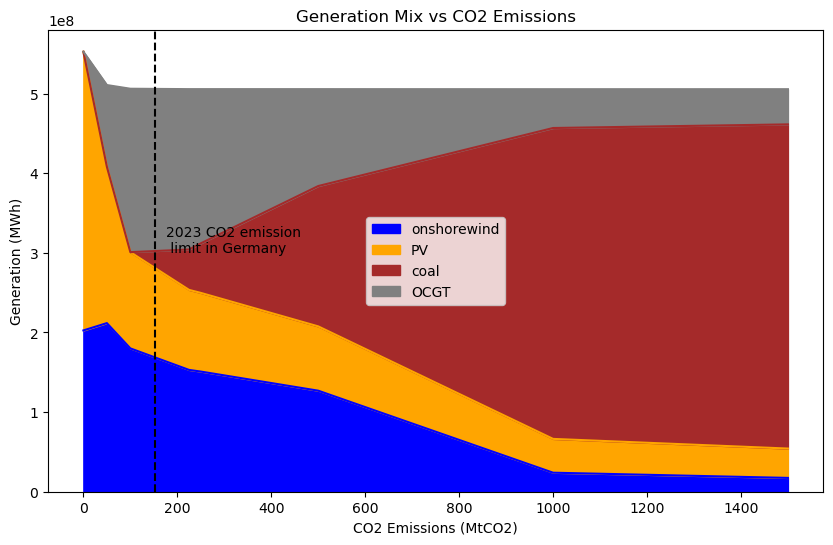

In [70]:
results = pd.DataFrame(
    np.array([onwind, pv, coal, ocgt]).T,
    columns=["onshorewind", "PV", "coal", "OCGT"],
    index=co2_index,
)
results.plot.area(
    stacked=True,
    title="Generation Mix vs CO2 Emissions",
    ylabel="Generation (MWh)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)
plt.vlines(
    152, 0, 6e8, color="black", linestyle="--", label="2023 CO2 emission limit"
)
plt.text(
    175, 3e8, "2023 CO2 emission\n limit in Germany", color="black", fontsize=10, ha="left"
)

#results.to_csv("generation_mix_vs_co2.csv")

<Axes: title={'center': 'Generation Capacity vs CO2 Emissions'}, xlabel='CO2 Emissions (MtCO2)', ylabel='Generation Capacity (MW)'>

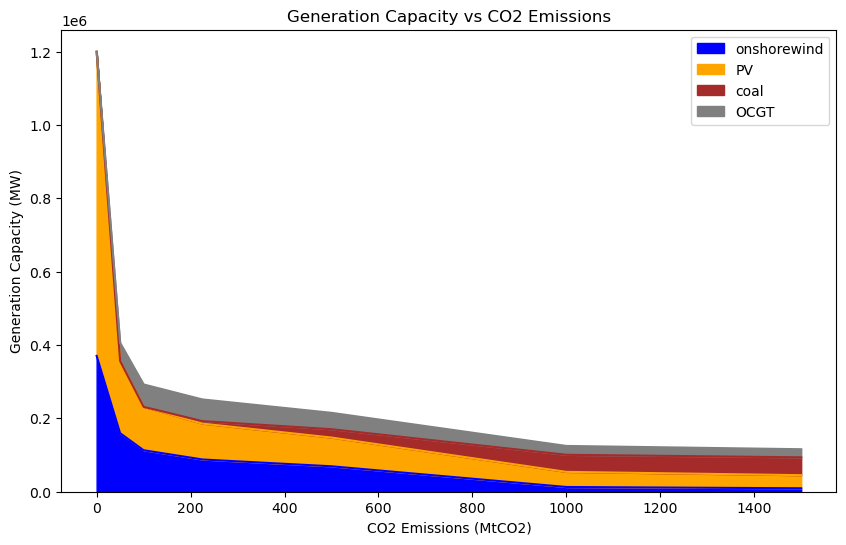

In [71]:
results_cap = pd.DataFrame(
    np.array([onwind_cap, pv_cap, coal_cap, ocgt_cap]).T,
    columns=["onshorewind", "PV", "coal", "OCGT"],
    index=co2_index,
)
results_cap.plot.area(
    stacked=True,
    title="Generation Capacity vs CO2 Emissions",
    ylabel="Generation Capacity (MW)",
    xlabel="CO2 Emissions (MtCO2)",
    color=colors,
    figsize=(10, 6),
)

Text(0, 0.5, 'System Cost (million euros)')

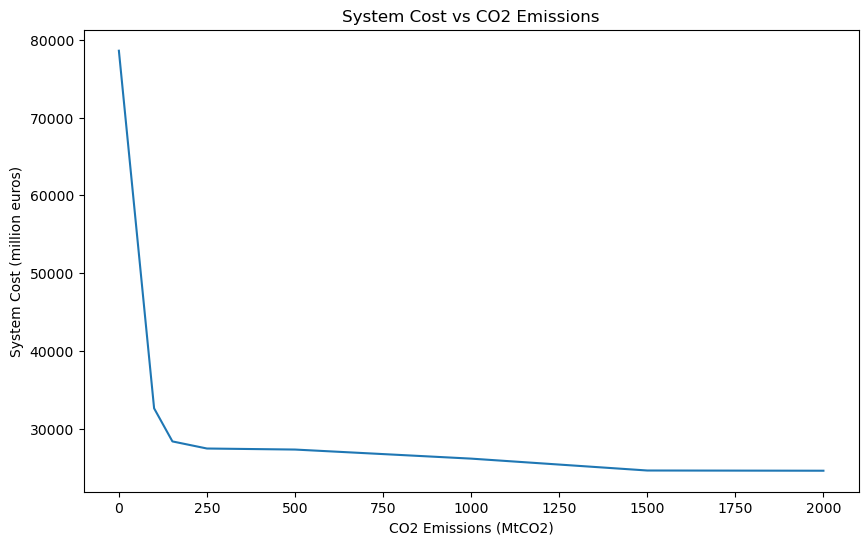

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([2000, 1500, 1000, 500, 250, 152, 100, 0], systemcost)
plt.title("System Cost vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("System Cost (million euros)")

Text(0, 0.5, 'CO2 Tax (EUR/tCO2)')

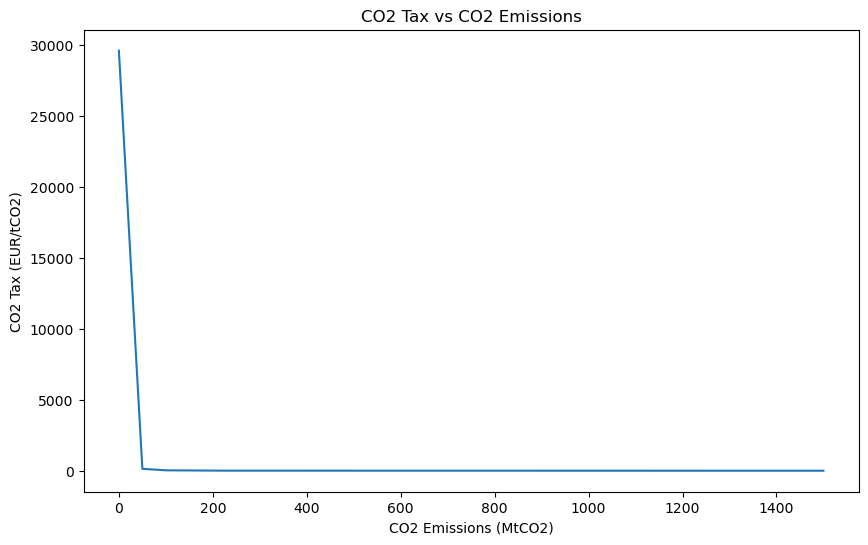

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(co2_index, co2_tax)
plt.title("CO2 Tax vs CO2 Emissions")
plt.xlabel("CO2 Emissions (MtCO2)")
plt.ylabel("CO2 Tax (EUR/tCO2)")